# FairBoostingRegression

This is an example notebook demonstrating the use of FairBoosting, specifically FairBoosting regression, and different implementation approaches. The regressor is implemented based on the academic paper FairBoost: Boosting supervised learning for learning on multiple sensitive features (https://www.sciencedirect.com/science/article/pii/S0950705123007499).
The difference between the implementations of different regressors lies in how the weights are calculated and how poorly classified instances are penalized. FairBoost Regressor is an extension of the AdaBoost Regressor that incorporates fairness-aware adjustments. It ensures balanced performance across protected groups defined by sensitive attributes. The Boston dataset is used for evaluation, but the regressors are implemented in a way that they can be used on any dataset, and the sensitive variable can be singular or multiple.

In [29]:
from sklearn.model_selection import train_test_split
from fairlearn.datasets import fetch_boston
import pandas as pd
from FairBoostRegressor_v1 import FairBoostRegressor_v1
from FairBoostRegressor_v1_improved import FairBoostRegressor_v1_Improved
from FairBoostRegressor_v2 import FairBoostRegressor_v2
from FairBoostRegressor_v2_improved import FairBoostRegressor_v2_Improved
from FairBoostRegressor_v3 import FairBoostRegressor_v3
import numpy as np
from sklearn.metrics import mean_squared_error
from fairlearn.metrics import MetricFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from scipy.stats import rankdata
import sklearn.metrics as skm
from sklearn.tree import plot_tree

In [3]:
data = fetch_boston(as_frame=True)
protected = ['LSTAT']
rnd = 123

/Users/gregorsulcer/PycharmProjects/FairBoostRegression/.venv/lib/python3.12/site-packages/fairlearn/datasets/_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


The Boston Housing dataset is one of the datasets currently callable in fairlearn.datasets module. In the past, it has commonly been used for benchmarking in popular machine learning libraries. I think this dataset provides an interesting case study of how fairness is fundamentally a socio-technical issue by exploring how societal biases manifest in data in ways that can’t simply be fixed with technical mitigation approaches (although the harms they engender may be mitigated).
Harrison and Rubinfeld developed the dataset to illustrate the issues with using housing market data to measure consumer willingness to pay for clean air. The authors use a hedonic pricing approach, which assumes that the price of a good or service can be modeled as a function of features both internal and external to the good or service. The input to this model was a dataset comprising the Boston Standard Metropolitan Statistical Area, with the nitric oxides concentration (NOX) serving as a proxy for air quality.
The paper sought to estimate the median value of owner-occupied homes (now MEDV), and included the remaining variables to capture other neighborhood characteristics. Further, the authors took the derivative of their housing value equation with respect to nitric oxides concentration to measure the “amount of money households were willing to pay when purchasing a home with respect to air pollution levels in their census tracts.” The variables in the dataset were collected in the early 1970s and come from a mixture of surveys, administrative records, and other research papers. While the paper does define each variable and suggest its impact on the housing value equation, it lacks reasoning for including that particular set of variables.

- **CRIM** - per capita crime rate by town
- **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS** - proportion of non-retail business acres per town
- **CHAS** - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX** - nitric oxides concentration (parts per 10 million)
- **RM** - average number of rooms per dwelling
- **AGE** - proportion of owner-occupied units built prior to 1940
- **DIS** - weighted distances to five Boston employment centers
- **RAD** - index of accessibility to radial highways
- **TAX** - full-value property-tax rate per 10,000 dollars
- **PTRATIO** - pupil-teacher ratio by town
- **B** - 1000(Bk - 0.63)^2 where Bk is the proportion of Black people by town
- **LSTAT** - % lower status of the population
- **MEDV** - Median value of owner-occupied homes in 1000 dollars



In [ ]:
preview_data = data.data
print('Data shape:', preview_data.shape)
print('Data columns:', preview_data.columns.tolist())
print('Missing data:', preview_data.isnull().sum().sum())
print('Target data:', data.target.name)
preview_data.head()

First, I will demonstrate the fairness problem on the Boston dataset and use the standard implementation of a decision tree regressor.

In [5]:
X = data.data
Z = X[protected]
X = pd.get_dummies(X.drop(protected, axis=1), dtype='int')
y = data.target

X_train, X_test, \
Z_train, Z_test, \
y_train, y_test = train_test_split(X, Z, y, test_size=0.2, random_state=rnd)

In [6]:
X.head()

CRIM    ZN  INDUS    NOX     RM   AGE     DIS    TAX  PTRATIO       B  \
0  0.00632  18.0   2.31  0.538  6.575  65.2  4.0900  296.0     15.3  396.90   
1  0.02731   0.0   7.07  0.469  6.421  78.9  4.9671  242.0     17.8  396.90   
2  0.02729   0.0   7.07  0.469  7.185  61.1  4.9671  242.0     17.8  392.83   
3  0.03237   0.0   2.18  0.458  6.998  45.8  6.0622  222.0     18.7  394.63   
4  0.06905   0.0   2.18  0.458  7.147  54.2  6.0622  222.0     18.7  396.90   

   ...  CHAS_1  RAD_1  RAD_2  RAD_24  RAD_3  RAD_4  RAD_5  RAD_6  RAD_7  RAD_8  
0  ...       0      1      0       0      0      0      0      0      0      0  
1  ...       0      0      1       0      0      0      0      0      0      0  
2  ...       0      0      1       0      0      0      0      0      0      0  
3  ...       0      0      0       0      1      0      0      0      0      0  
4  ...       0      0      0       0      1      0      0      0      0      0  

[5 rows x 21 columns]

In [7]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_dtr = dtr.predict(X_test)

y_error = y_dtr - y_test
y_error_abs = abs(y_dtr - y_test)

Scatterplot of protected LSTAT feature and absolute errors of target feature MEDV

<Axes: xlabel='LSTAT', ylabel='MEDV'>

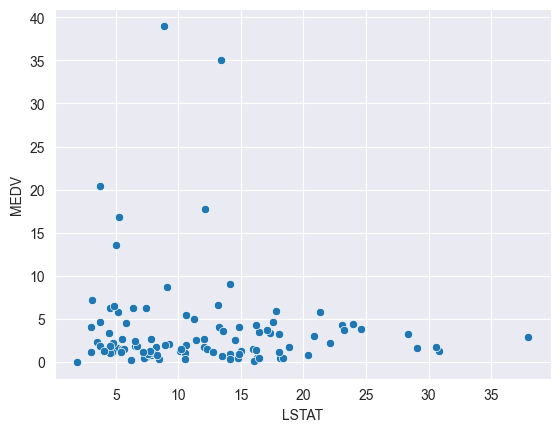

In [8]:
sns.scatterplot(x=Z_test['LSTAT'], y=y_error_abs)

The plot displays the relationship between the PTRATIO (pupil-teacher ratio by town) and the squared ranking of the absolute error in the regression model. The red points represent the data points, while the green curve is a fitted polynomial of degree 2, which best minimizes the squared error. The y-axis represents the normalized squared error ranks, and the x-axis shows the values of PTRATIO from the test dataset. This visualization helps to analyze how the error behaves across different PTRATIO values and provides insight into the trend captured by the fitted curve.

(-0.1, 1.1)

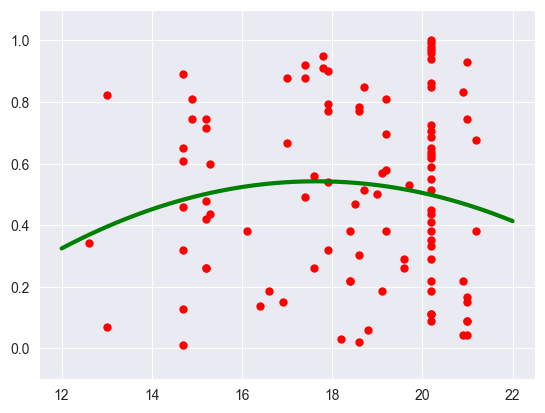

In [9]:
def sqr_error(p, xi, yi):
    diff2 = (p(xi)-yi)**2
    return diff2.sum()

def curve_fit(x, y, max_deg=5):
    curves = []
    errors = []
    for i in range(1, max_deg+1):
        coefs = np.polyfit(x, y, i)
        fun = np.poly1d(coefs)
        curves.append(fun)
        errors.append(sqr_error(fun, x, y))

    return curves[np.argmin(errors)]

df1 = pd.DataFrame({'a': X_test['PTRATIO'].values, 'b':y_error_abs.values})
df1['b'] = df1['b']**2
df1['c'] = rankdata(df1['b']) / df1['b'].shape
plt.plot(df1['a'], df1['c'], 'ro', ms=5)

fn = curve_fit(df1['a'], df1['c'], max_deg=2)
xs = np.linspace(12, 22, 1000)
plt.plot(xs, fn(xs), 'g', lw=3)
plt.ylim((-0.1,1.1))

The boxplot shows the distribution of absolute errors (y_error_abs) across four quartiles of the LSTAT variable (% lower status of the population). The x-axis represents the quartiles of LSTAT, while the y-axis shows the absolute error values. The plot helps to visualize how the error varies within different segments of the LSTAT variable, providing insight into whether certain quartiles of LSTAT are associated with higher or lower prediction errors.

Text(0.5, 1.0, 'Error Distribution by LSTAT Quartiles')

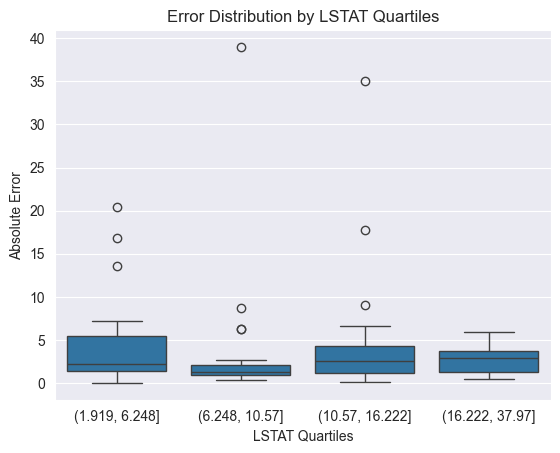

In [10]:
sns.boxplot(x=pd.qcut(Z_test['LSTAT'], q=4), y=y_error_abs)
plt.xlabel("LSTAT Quartiles")
plt.ylabel("Absolute Error")
plt.title("Error Distribution by LSTAT Quartiles")

In [1]:
# sns.heatmap(df1.corr(), annot=True, cmap="coolwarm")

MAE of Fairness by AGLSTATEQUARTILES of LSTAT

Text(0.5, 1.0, 'Fairness Analysis by AGLSTATE Quartiles')

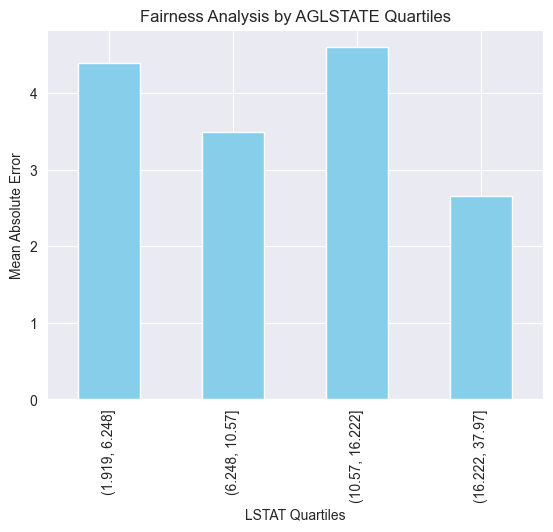

In [12]:
error_means = y_error_abs.groupby(pd.qcut(Z_test['LSTAT'], q=4), observed=False).mean()
error_means.plot(kind='bar', color='skyblue')
plt.xlabel("LSTAT Quartiles")
plt.ylabel("Mean Absolute Error")
plt.title("Fairness Analysis by AGLSTATE Quartiles")

In [13]:
# plt.figure(figsize=(20, 10))
# plot_tree(dtr, filled=True, feature_names=X.columns)
# plt.show()

In [14]:
def scatter_plot_binning(y_test, y_pred):
    # Define bins over the range of y_test
    bins = np.linspace(y_test.min(), y_test.max(), 10)

    # Prepare arrays for binned averages
    bin_means = []

    for i in range(len(bins) - 1):
        # Mask for current bin
        mask = (y_test >= bins[i]) & (y_test < bins[i+1])

        # Avoid empty slices
        if mask.sum() > 0:  # Ensure there are data points in the bin
            bin_mean_true = y_test[mask].mean()
            bin_mean_pred = y_pred[mask].mean()
            bin_means.append((bin_mean_true, bin_mean_pred))

    # Convert to numpy array for plotting
    bin_means = np.array(bin_means)

    # Plot the binned averages
    plt.figure(figsize=(8, 6))
    plt.scatter(bin_means[:, 0], bin_means[:, 1], color='orange', label="Binned Averages")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label="Perfect Fit")
    plt.xlabel("True Values (Binned Means)")
    plt.ylabel("Predicted Values (Binned Means)")
    plt.title("Scatter Plot with Binning")
    plt.legend()
    plt.show()

Using FairBoostRegressors and displaying scatter plots and scatter plots with binning.

Regressor: FairBoostRegressor_v1
Overall RMSE: 7.1430093425377805
Fairness Metrics by Group:
LSTAT
1.92      6.656400
2.98     23.458487
3.01      2.016400
3.13     96.432400
3.53     27.493204
           ...    
28.32     0.035793
29.05    12.057148
30.63     3.505659
30.81    37.010735
37.97     9.782254
Name: mean_squared_error, Length: 98, dtype: float64
Metric Difference: 1546.6578111426786


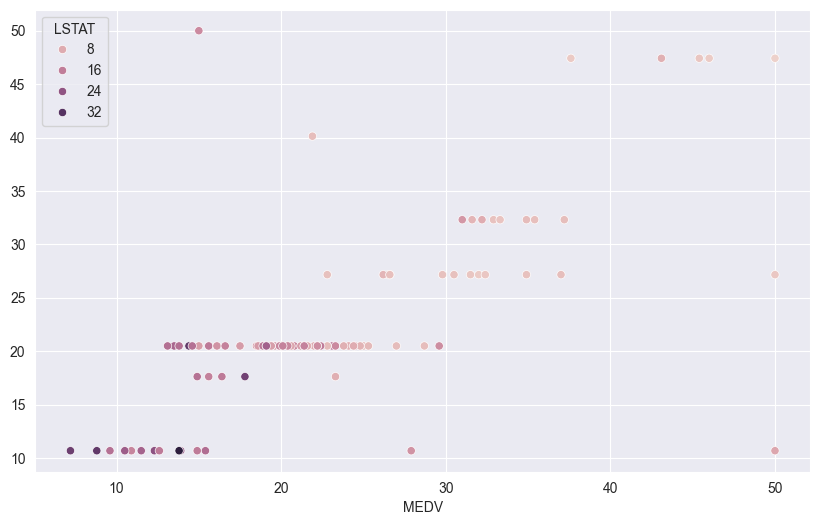

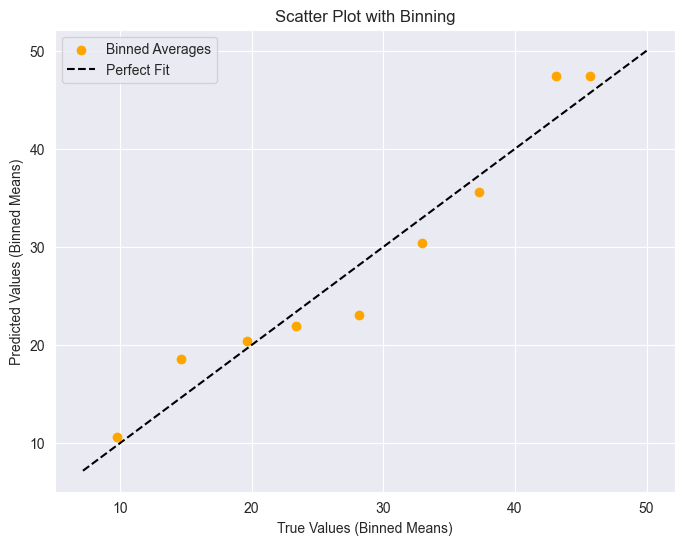

Regressor: FairBoostRegressor_v1_Improved
Overall RMSE: 7.1430093425377805
Fairness Metrics by Group:
LSTAT
1.92      6.656400
2.98     23.458487
3.01      2.016400
3.13     96.432400
3.53     27.493204
           ...    
28.32     0.035793
29.05    12.057148
30.63     3.505659
30.81    37.010735
37.97     9.782254
Name: mean_squared_error, Length: 98, dtype: float64
Metric Difference: 1546.6578111426782


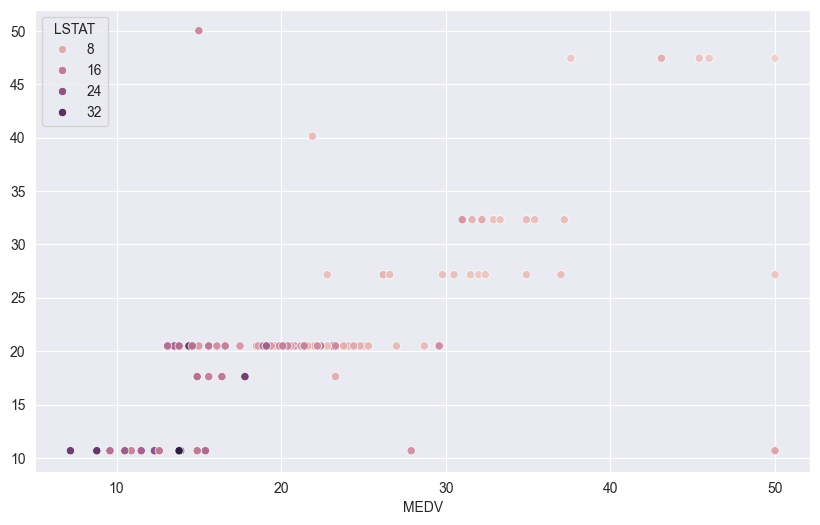

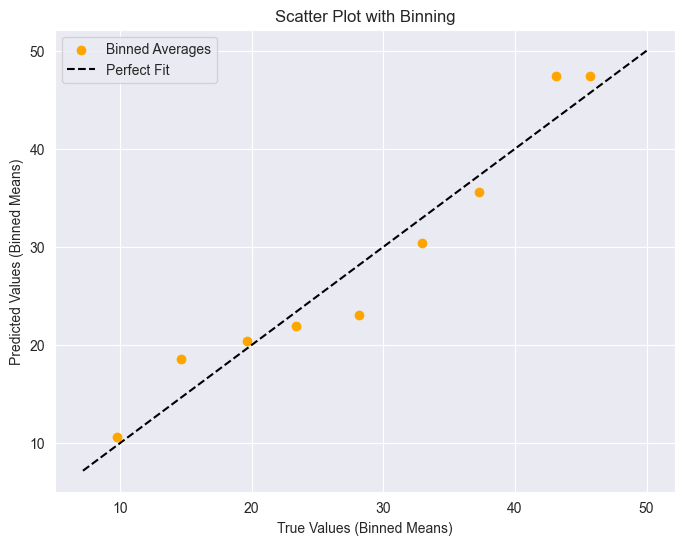

Regressor: FairBoostRegressor_v2
Overall RMSE: 7.036614429957923
Fairness Metrics by Group:
LSTAT
1.92       0.010000
2.98     113.737377
3.01      95.201837
3.13      54.760000
3.53     122.429196
            ...    
28.32      3.455615
29.05      3.671885
30.63      0.099993
30.81     48.097377
37.97     21.937831
Name: mean_squared_error, Length: 98, dtype: float64
Metric Difference: 1160.0106154336731


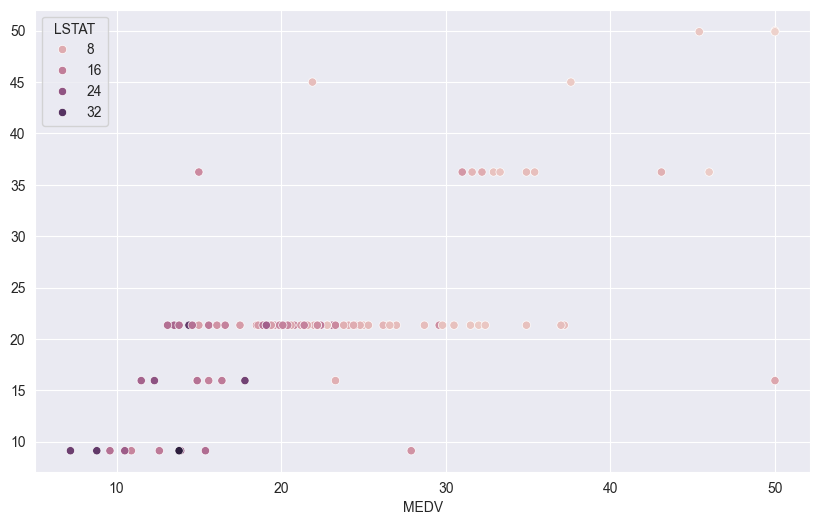

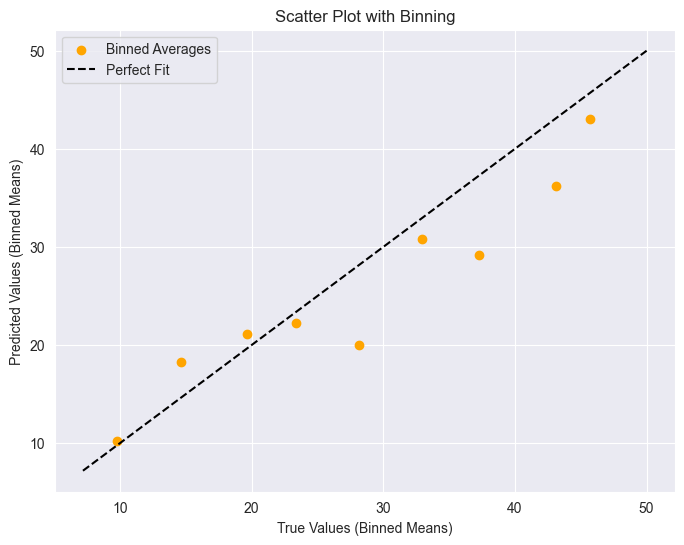

Regressor: FairBoostRegressor_v2_Improved
Overall RMSE: 7.396392333067202
Fairness Metrics by Group:
LSTAT
1.92      10.627600
2.98     110.477554
3.01      50.694400
3.13      83.539600
3.53     119.046218
            ...    
28.32      0.005487
29.05     15.409473
30.63      5.407905
30.81     50.256327
37.97      7.153003
Name: mean_squared_error, Length: 98, dtype: float64
Metric Difference: 1511.2220255267448


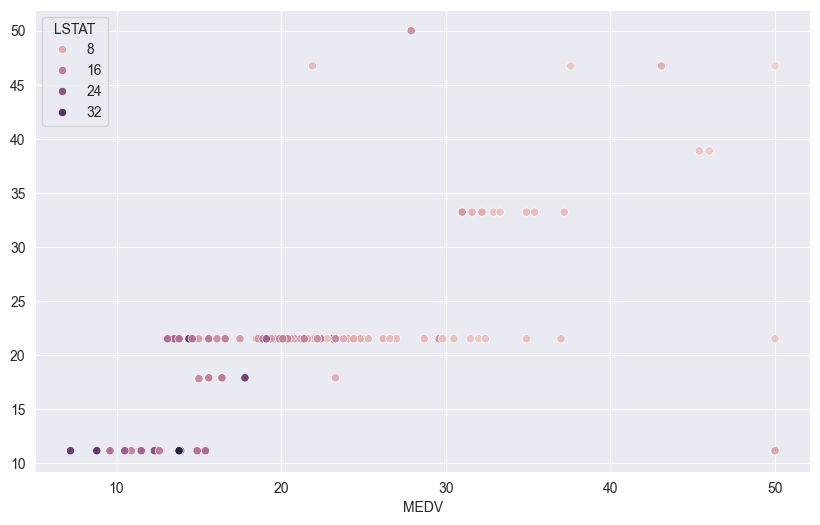

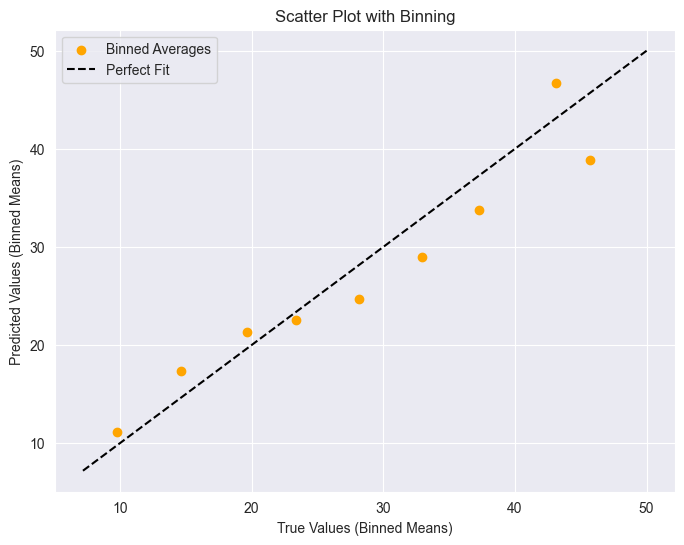

Regressor: FairBoostRegressor_v3
Overall RMSE: 7.637288810338389
Fairness Metrics by Group:
LSTAT
1.92     16.761799
2.98     22.865785
3.01     59.804444
3.13     68.987682
3.53     26.851240
           ...    
28.32     8.200874
29.05    17.624731
30.63     6.750549
30.81    39.234148
37.97     5.768731
Name: mean_squared_error, Length: 98, dtype: float64
Metric Difference: 1490.0963071097426


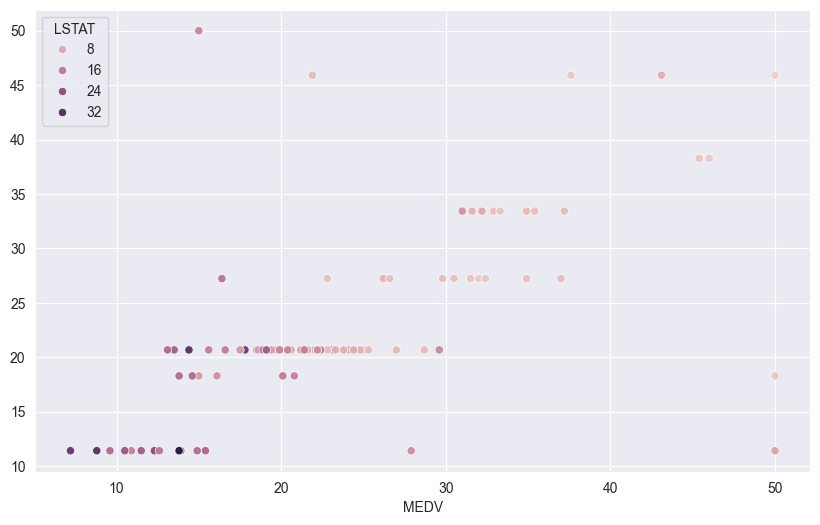

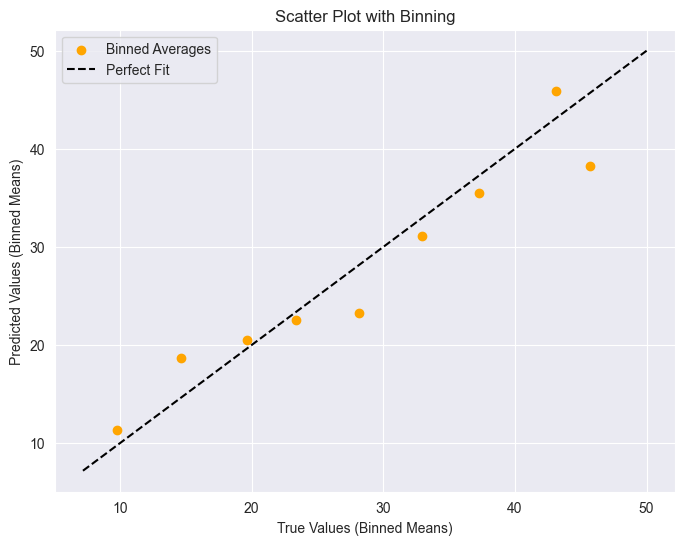

In [15]:
fair_regressors = [FairBoostRegressor_v1,
                   FairBoostRegressor_v1_Improved,
                   FairBoostRegressor_v2,
                   FairBoostRegressor_v2_Improved,
                   FairBoostRegressor_v3]

for fair_regressor in fair_regressors:
    # Initialize FairBoostRegressor
    fair_regressor = fair_regressor(n_estimators=50, fairness_weight=0.5, learning_rate=0.01)

    # Set the protected feature for training
    fair_regressor.set_Z(Z_train)

    # Train the regressor
    fair_regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = fair_regressor.predict(X_test)

    # Evaluate overall RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    metric_frame = MetricFrame(
        metrics=mean_squared_error,
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=Z_test
    )

    print(f"Regressor: {fair_regressor.__class__.__name__}")
    print(f"Overall RMSE: {rmse}")
    print(f"Fairness Metrics by Group:\n{metric_frame.by_group}")
    print(f"Metric Difference: {metric_frame.difference()}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, hue=Z_test['LSTAT'])
    plt.show()

    scatter_plot_binning(y_test, y_pred)

Preparing datasets for using regressors on the Boston dataset with different choices of the protected feature.

In [16]:
X = data.data
y = data.target
protected1 = ['B']
protected2 = ['LSTAT']

datasets = [
    {
        'name': 'B',
        'X': pd.get_dummies(X.drop('B', axis=1), dtype='int'),
        'y': y,
        'Z': X[protected1]
    },
    {
        'name': 'LSTAT',
        'X': pd.get_dummies(X.drop('LSTAT', axis=1), dtype='int'),
        'y': y,
        'Z': X[protected2]
    }
]

Performing regression using cross-validation and fairness-weight adjustment. The results are displayed as a scatter plot and the absolute error for the value of the protected variable, along with the distribution of the error across quartiles for the protected variable.

Processing dataset with protected feature: B
Evaluating: FairBoostRegressor_v1, Fold: 0, Fairness weight: 0.25


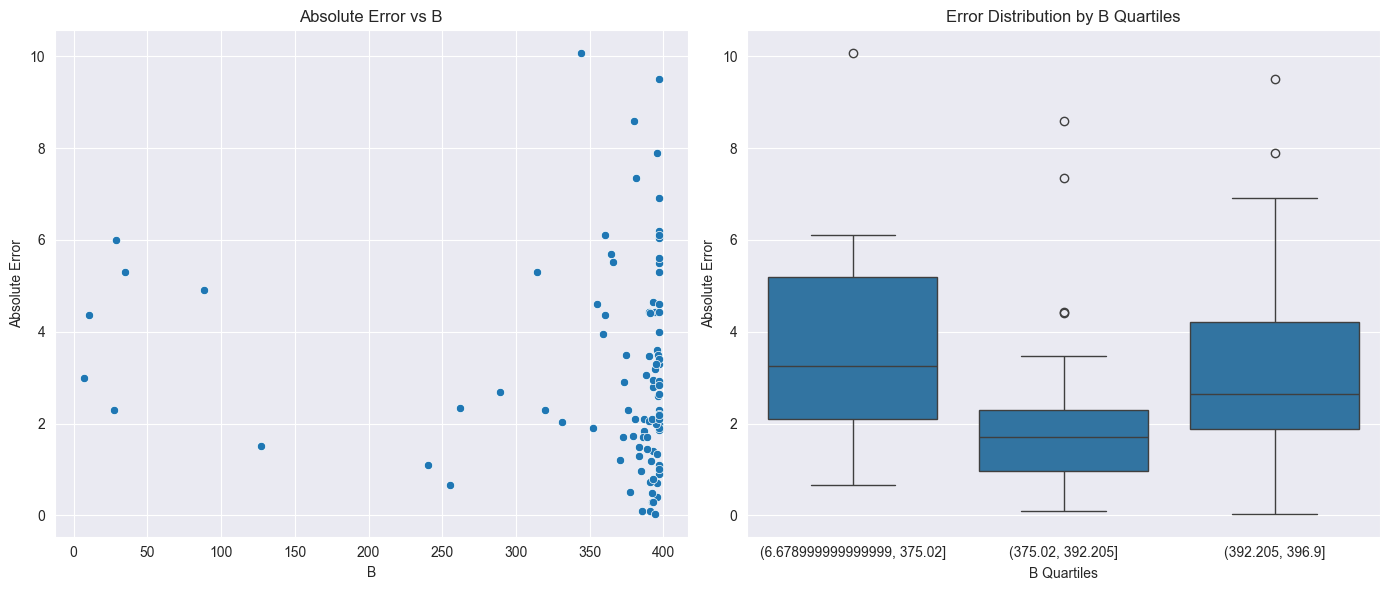

Evaluating: FairBoostRegressor_v1, Fold: 0, Fairness weight: 0.5


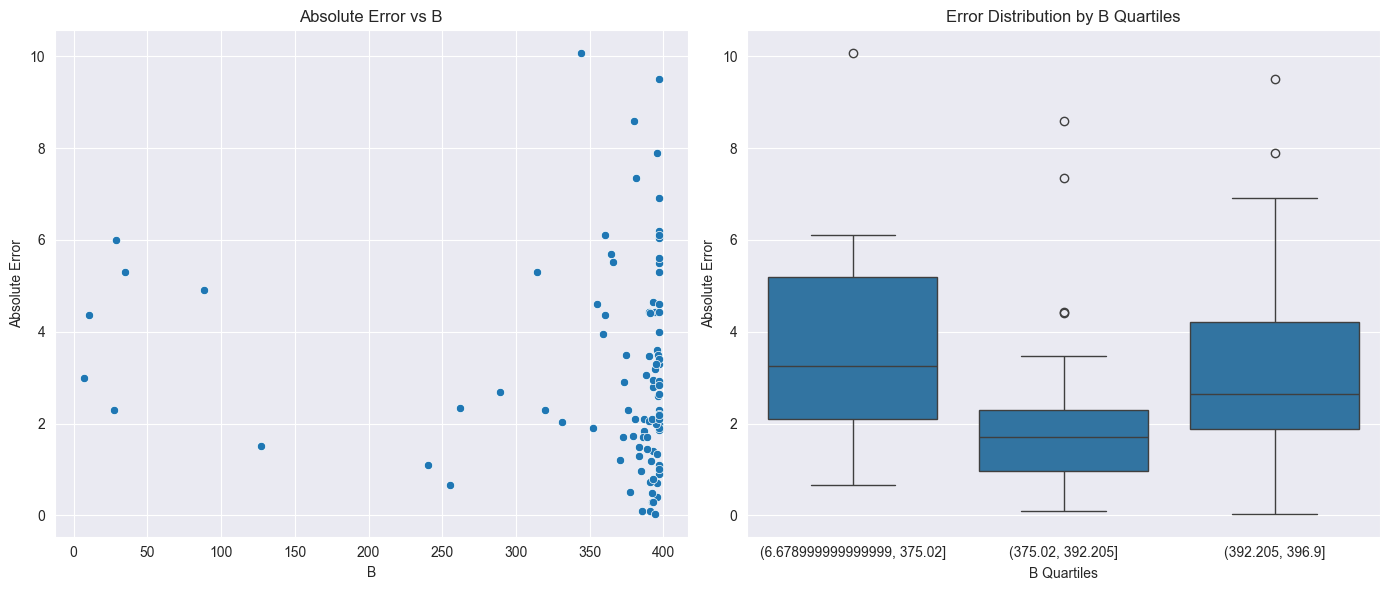

Evaluating: FairBoostRegressor_v1, Fold: 0, Fairness weight: 0.75


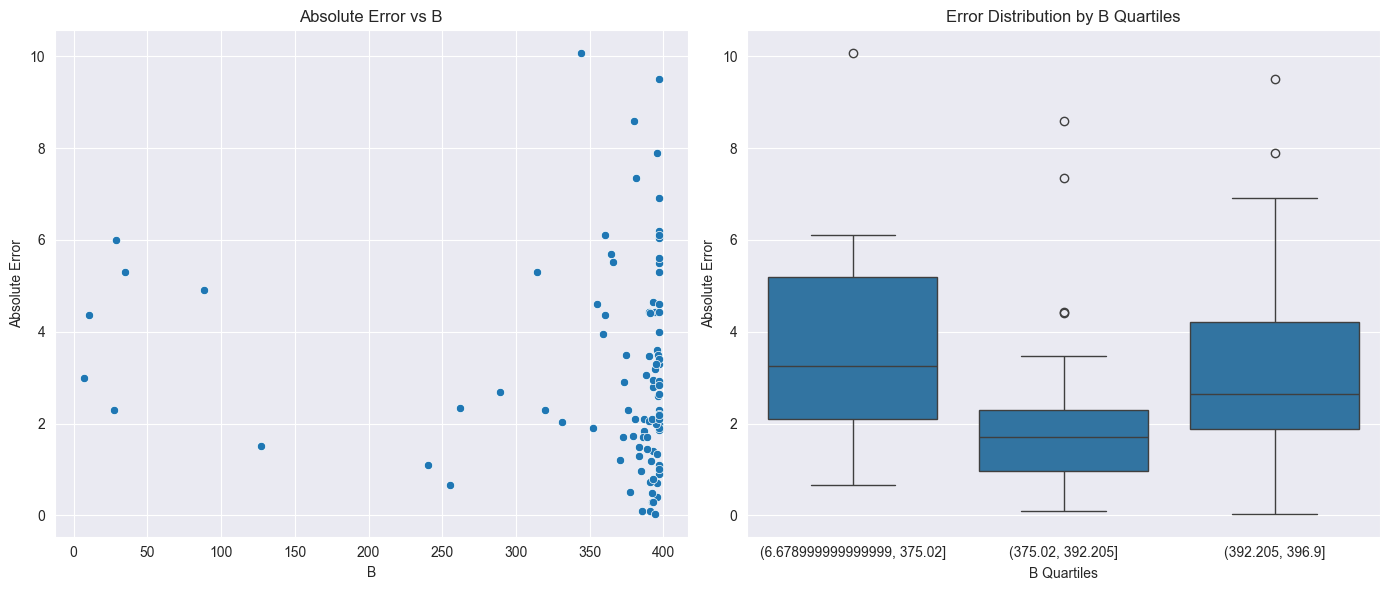

Evaluating: FairBoostRegressor_v1_Improved, Fold: 0, Fairness weight: 0.25


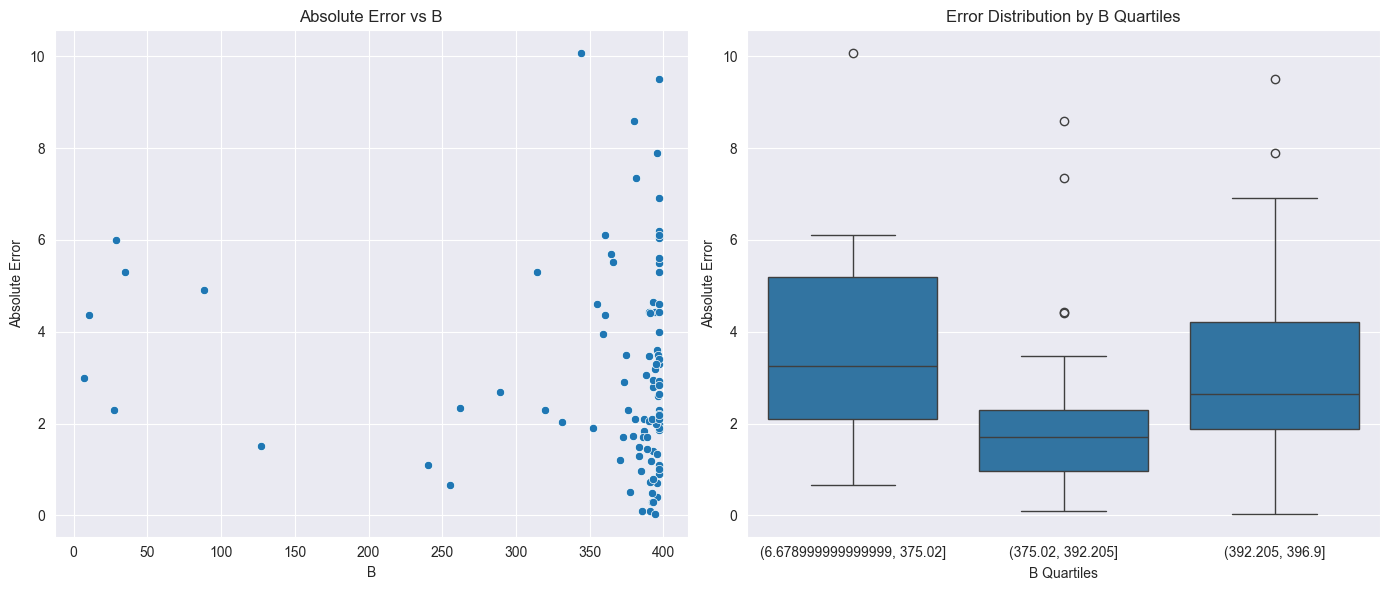

Evaluating: FairBoostRegressor_v1_Improved, Fold: 0, Fairness weight: 0.5


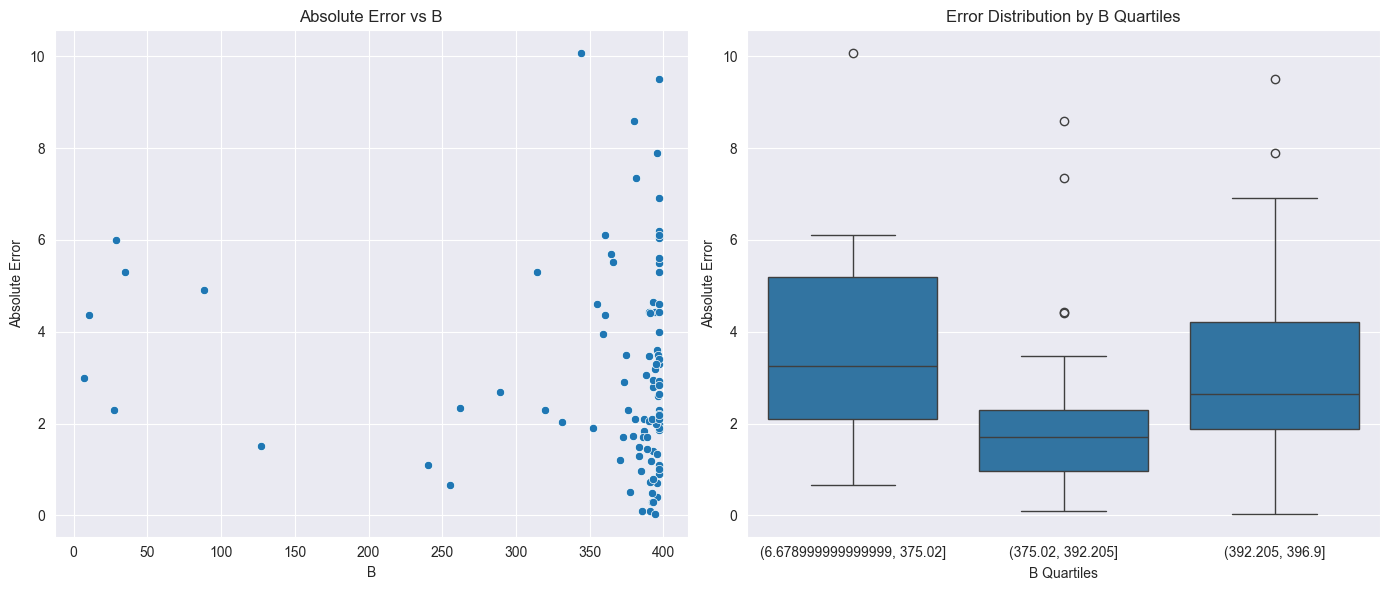

Evaluating: FairBoostRegressor_v1_Improved, Fold: 0, Fairness weight: 0.75


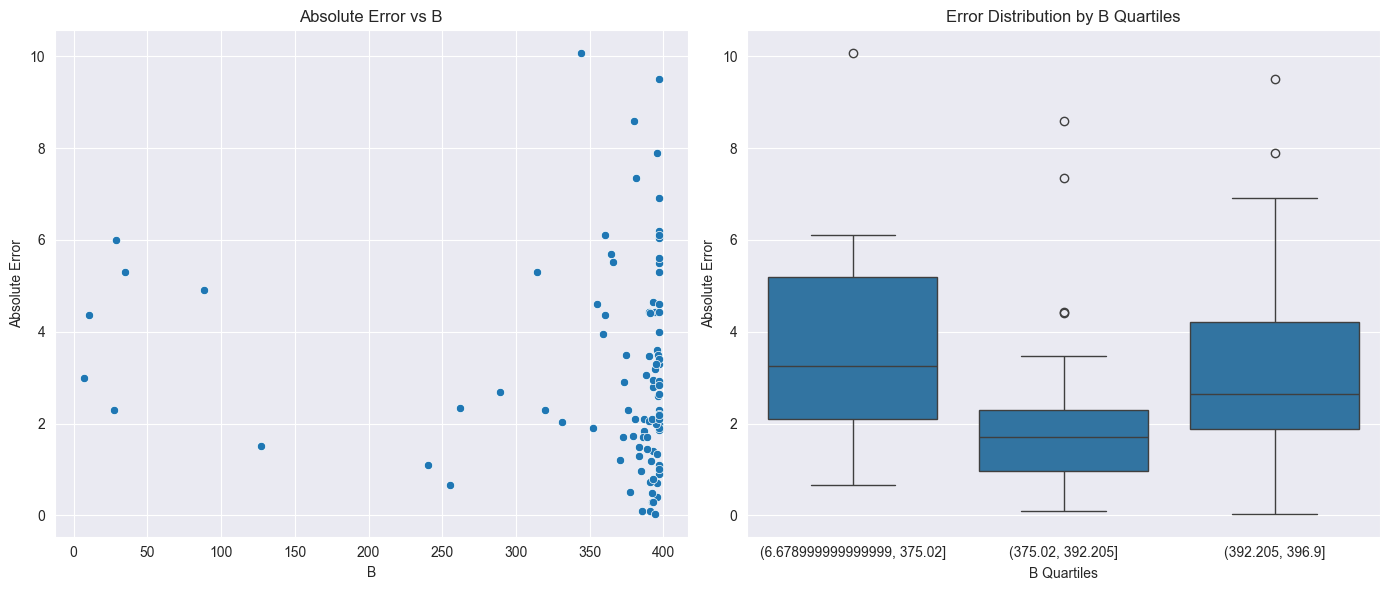

Evaluating: FairBoostRegressor_v2, Fold: 0, Fairness weight: 0.25


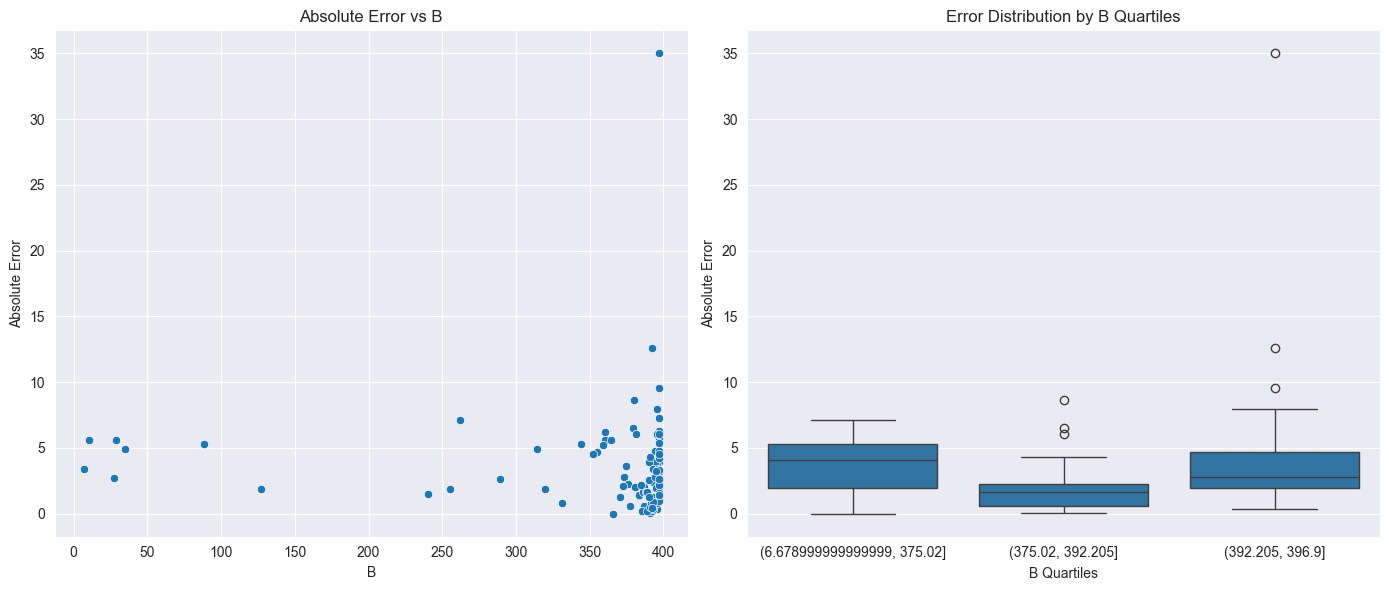

Evaluating: FairBoostRegressor_v2, Fold: 0, Fairness weight: 0.5


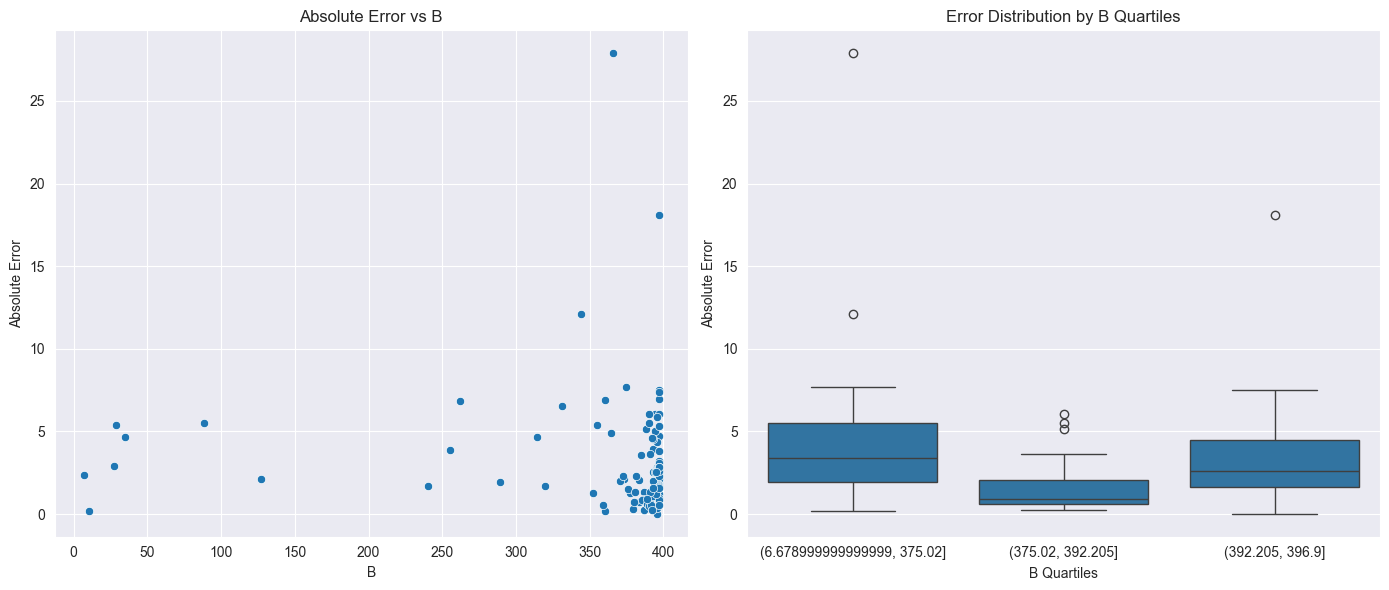

Evaluating: FairBoostRegressor_v2, Fold: 0, Fairness weight: 0.75


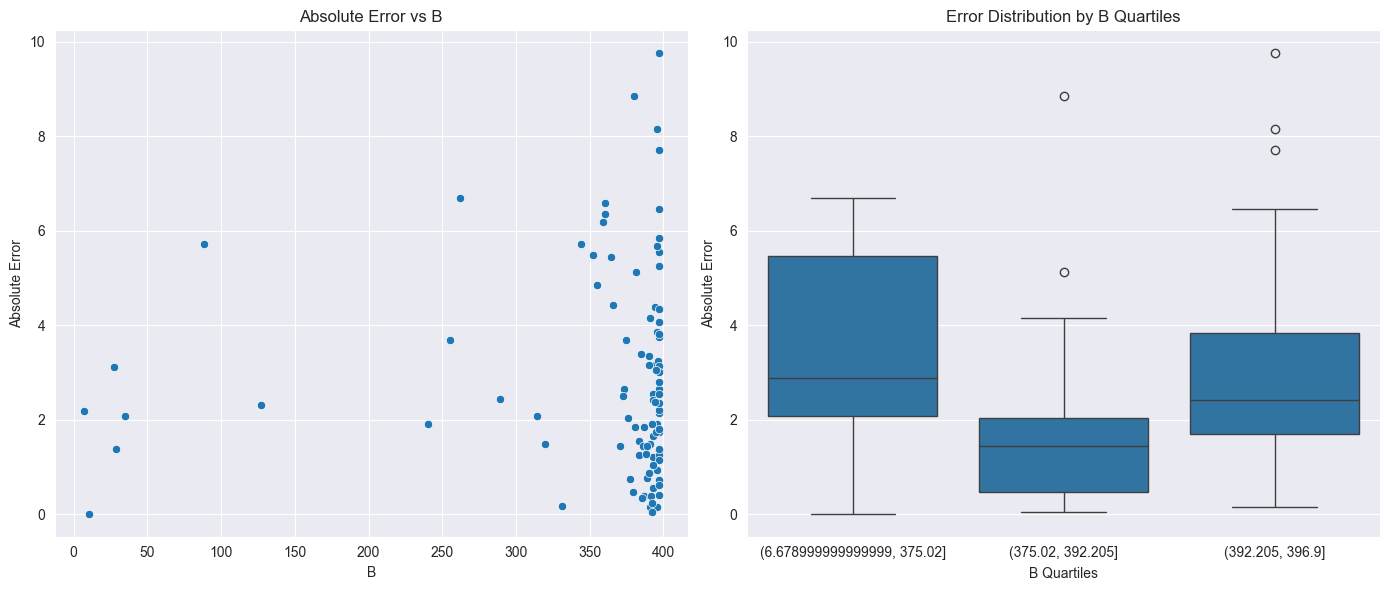

Evaluating: FairBoostRegressor_v2_Improved, Fold: 0, Fairness weight: 0.25


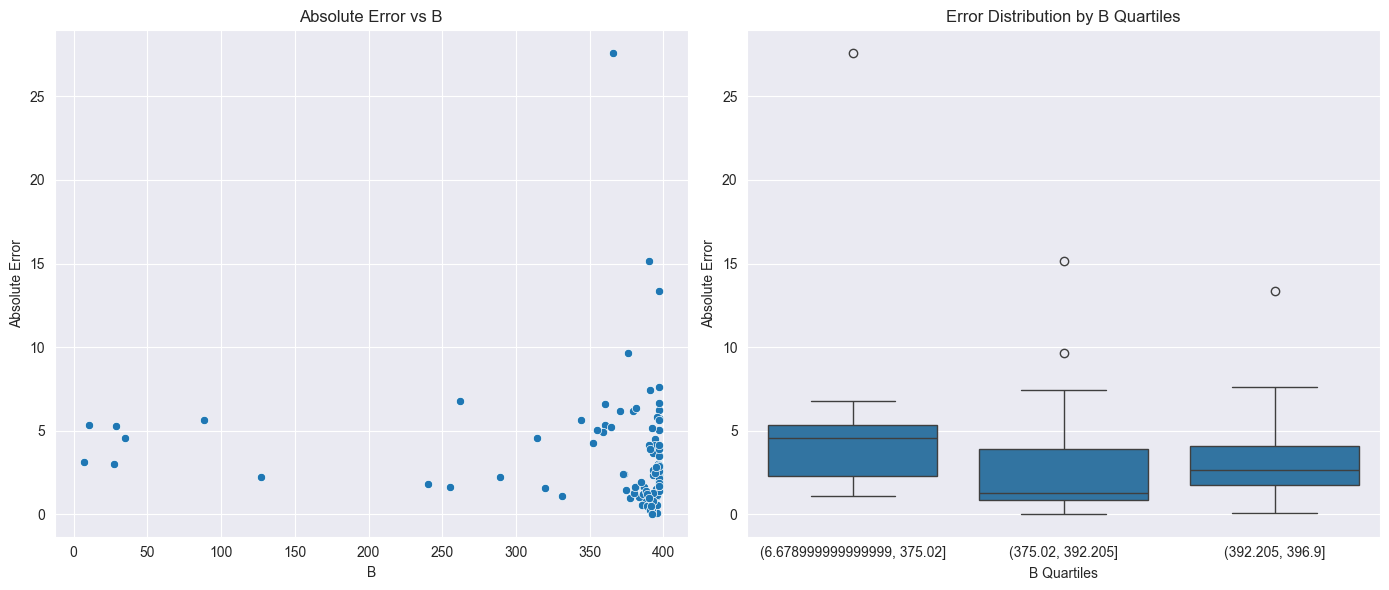

Evaluating: FairBoostRegressor_v2_Improved, Fold: 0, Fairness weight: 0.5


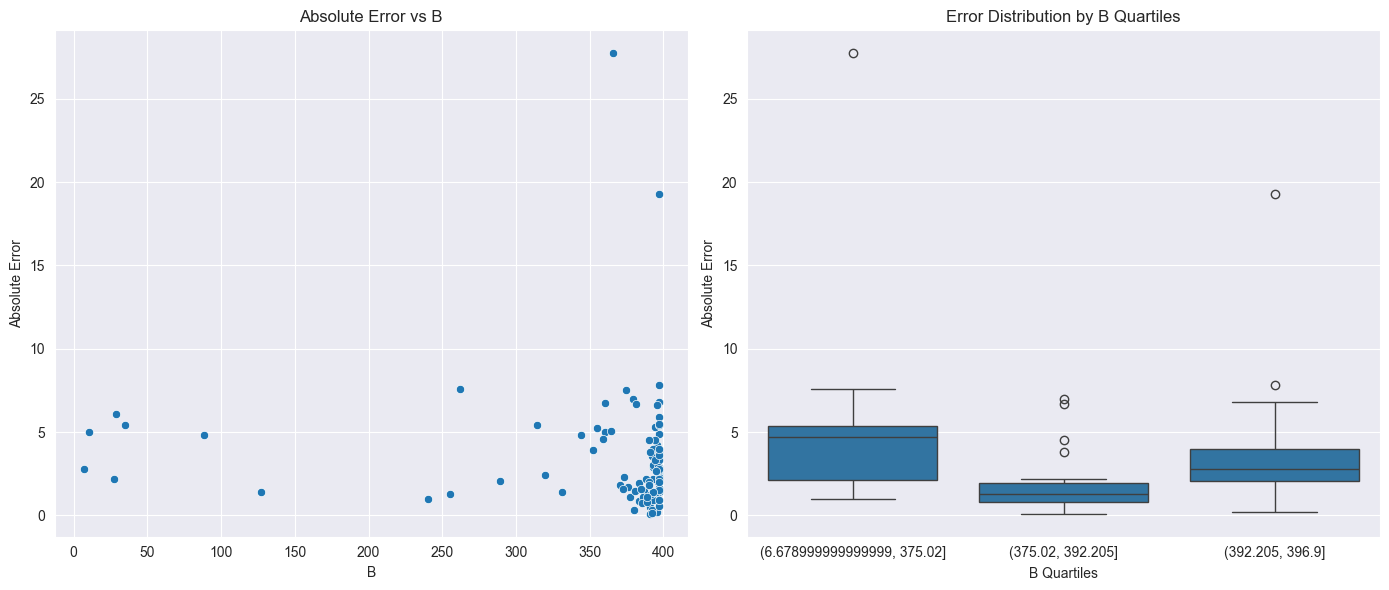

Evaluating: FairBoostRegressor_v2_Improved, Fold: 0, Fairness weight: 0.75


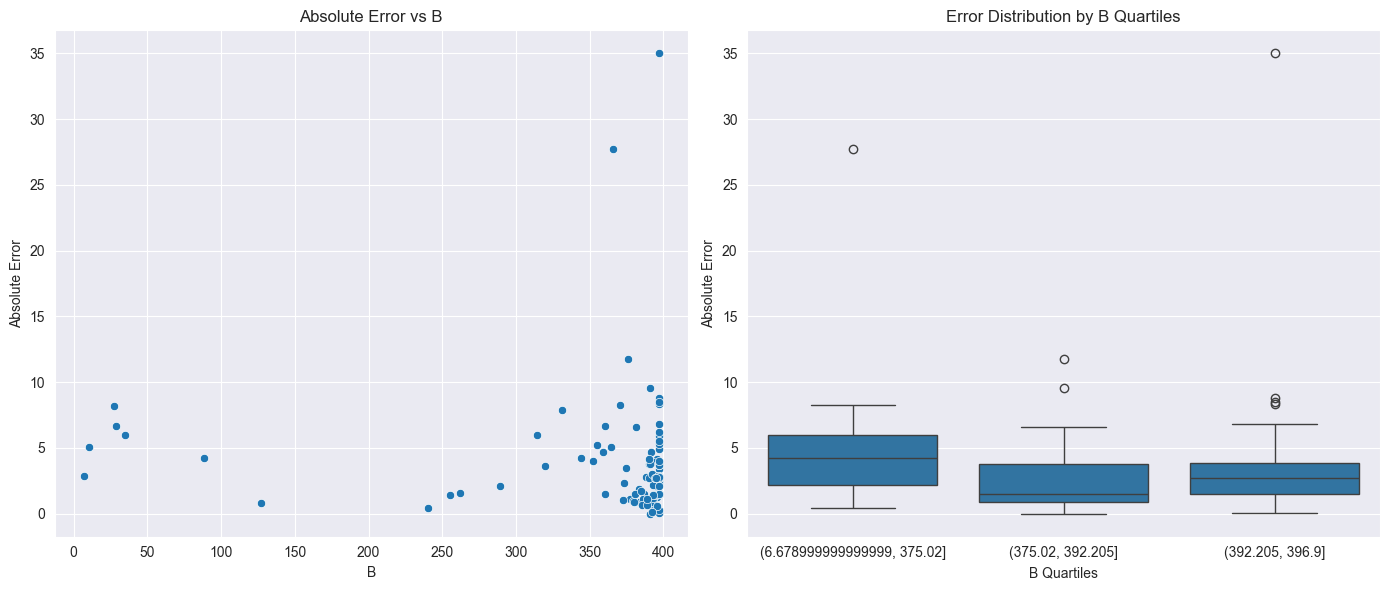

Evaluating: FairBoostRegressor_v3, Fold: 0, Fairness weight: 0.25


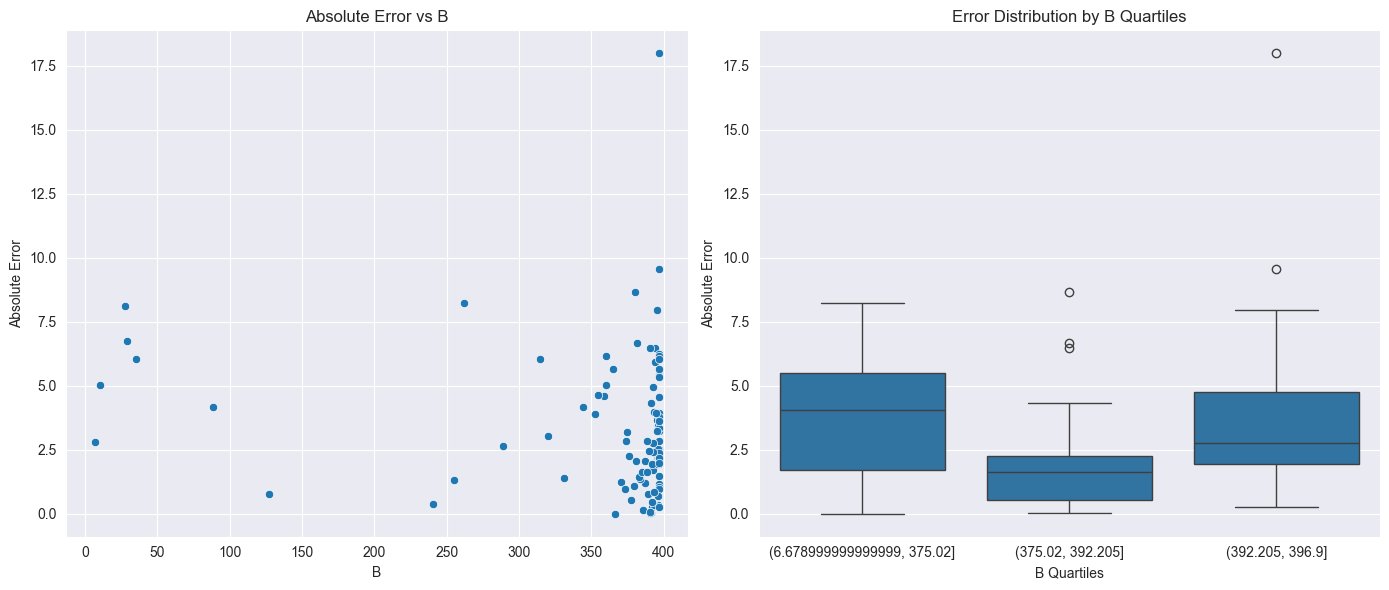

Evaluating: FairBoostRegressor_v3, Fold: 0, Fairness weight: 0.5


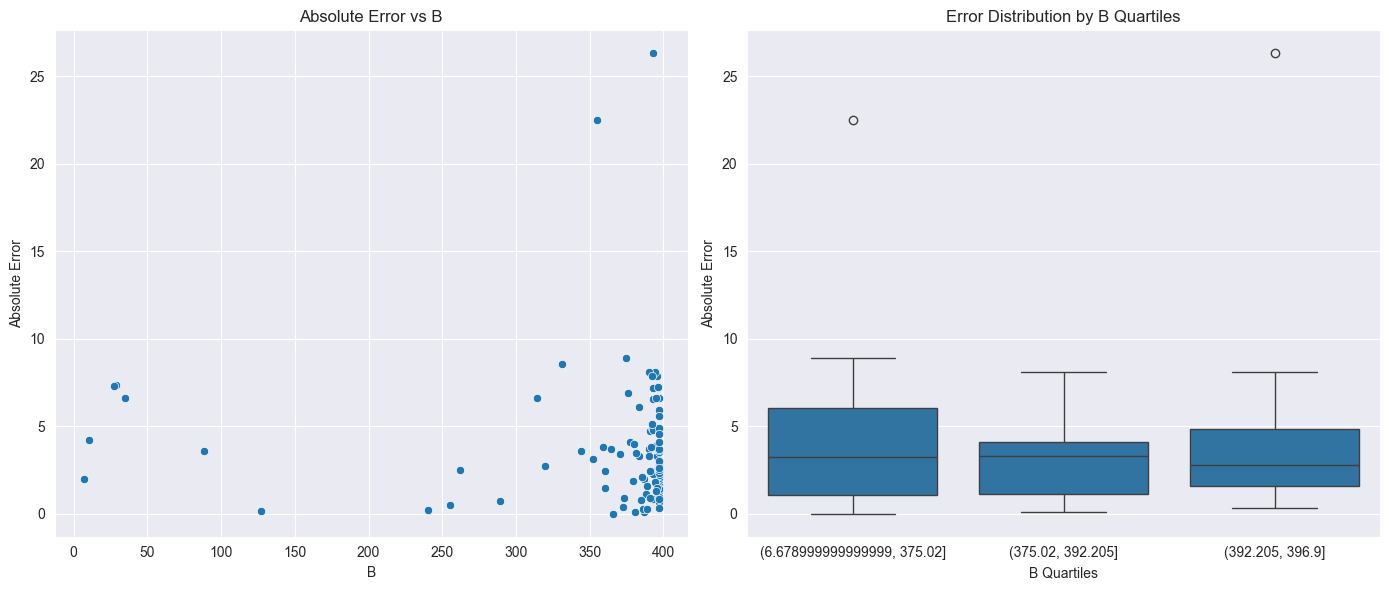

Evaluating: FairBoostRegressor_v3, Fold: 0, Fairness weight: 0.75


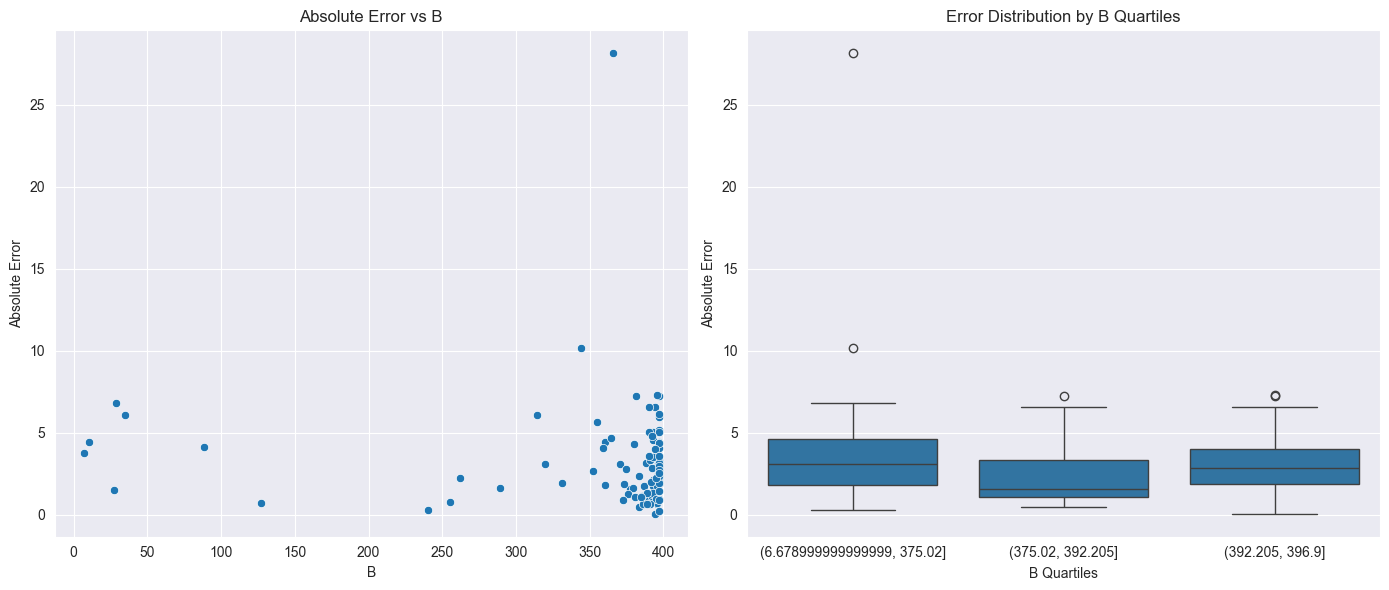

Evaluating: FairBoostRegressor_v1, Fold: 1, Fairness weight: 0.25


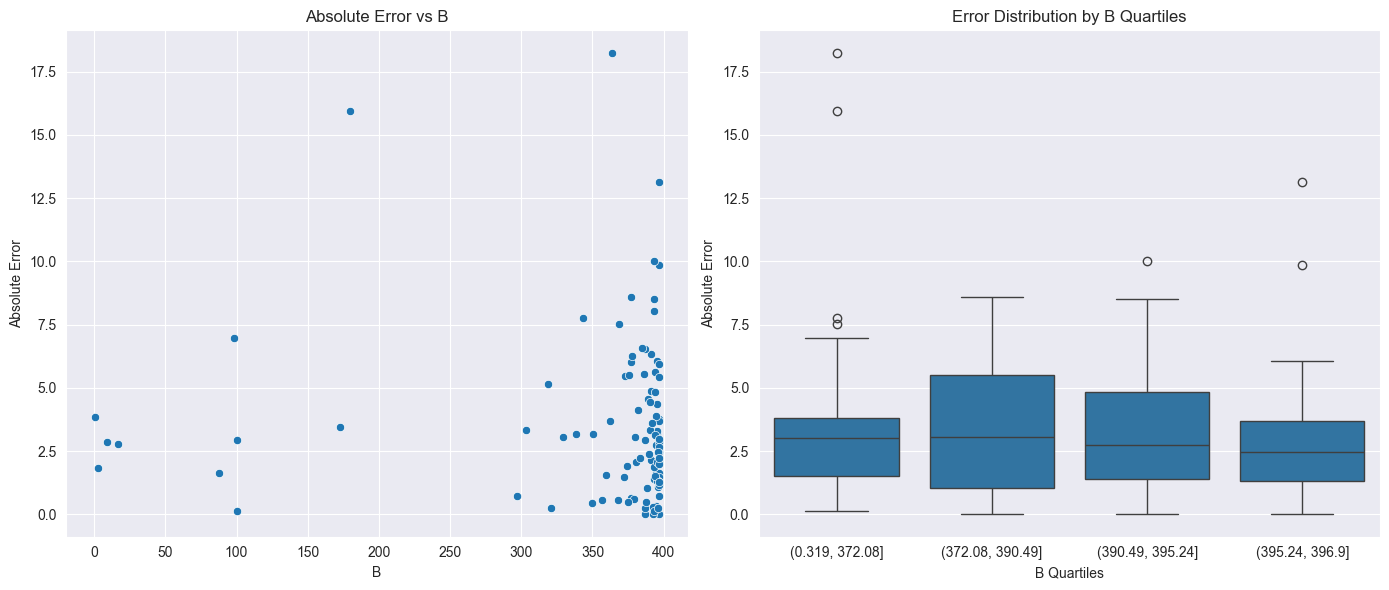

Evaluating: FairBoostRegressor_v1, Fold: 1, Fairness weight: 0.5


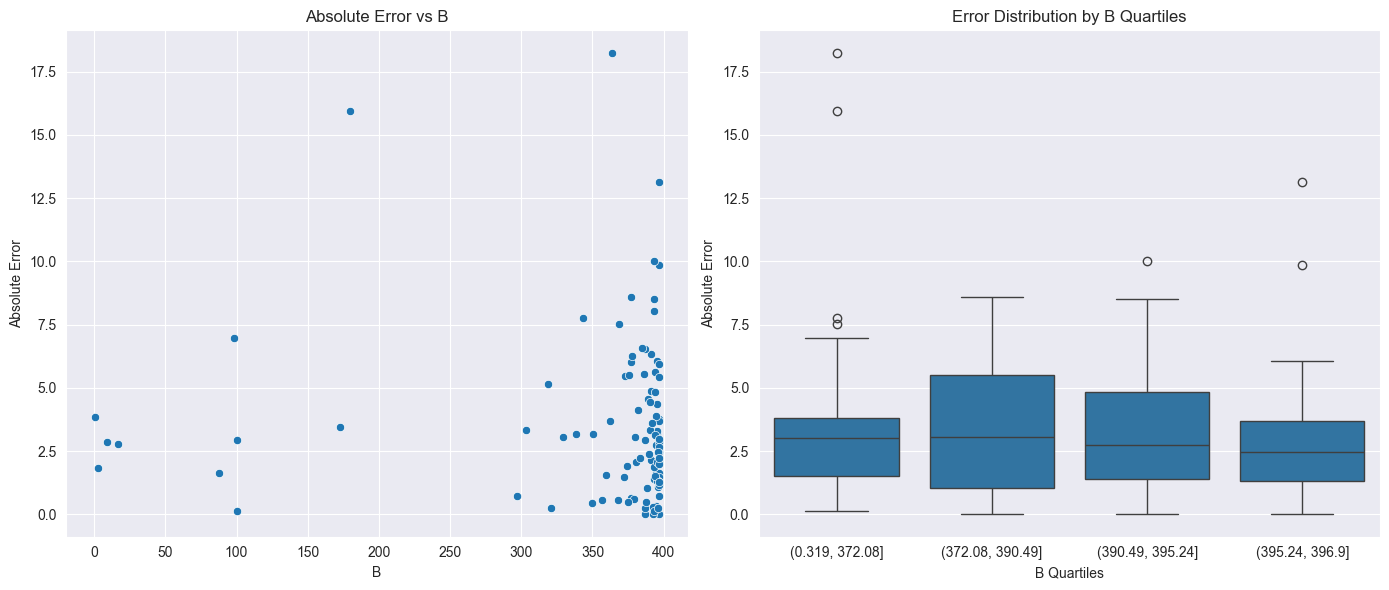

Evaluating: FairBoostRegressor_v1, Fold: 1, Fairness weight: 0.75


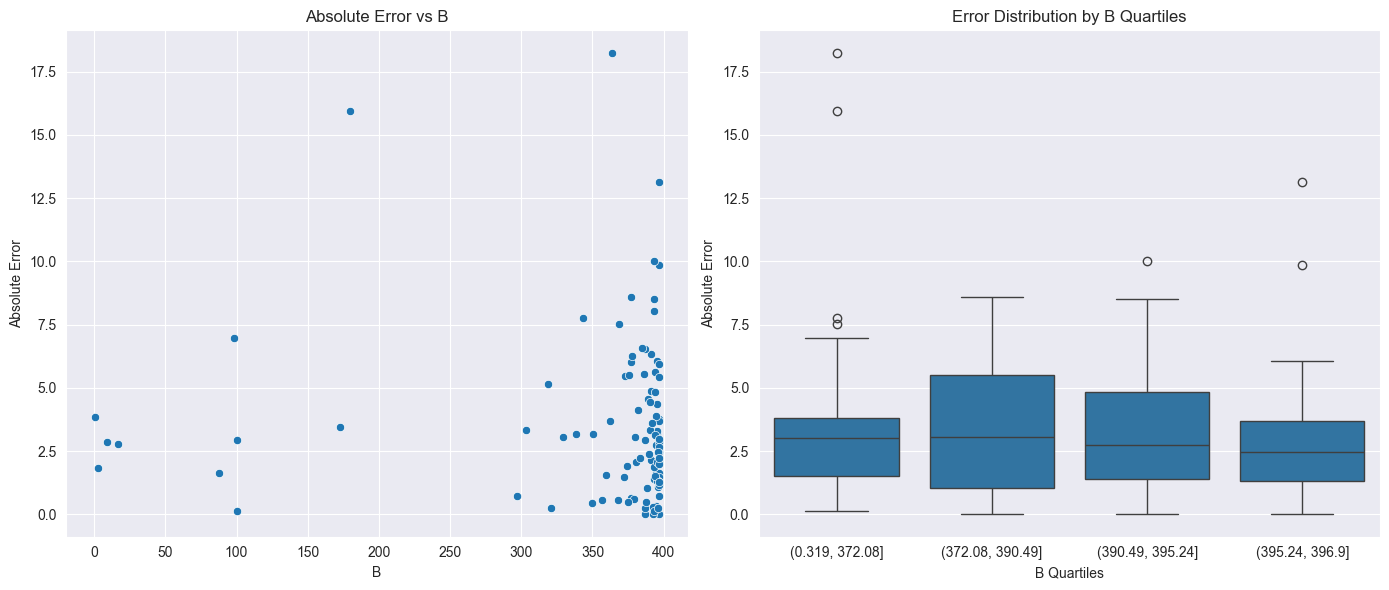

Evaluating: FairBoostRegressor_v1_Improved, Fold: 1, Fairness weight: 0.25


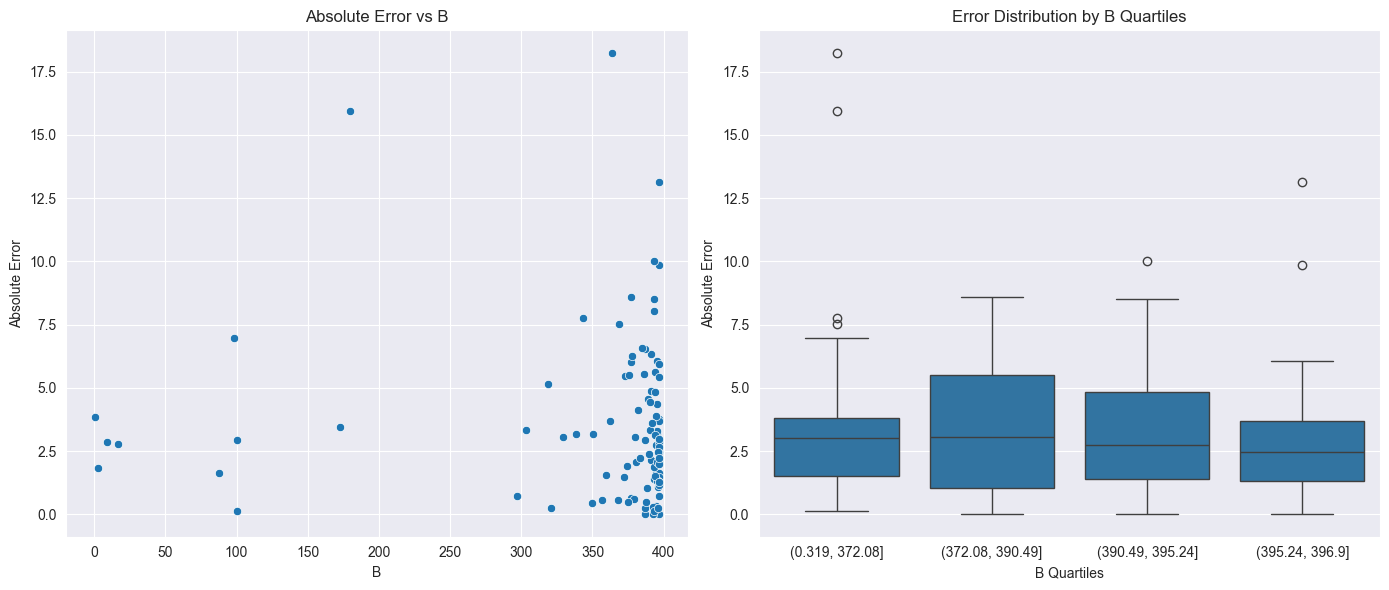

Evaluating: FairBoostRegressor_v1_Improved, Fold: 1, Fairness weight: 0.5


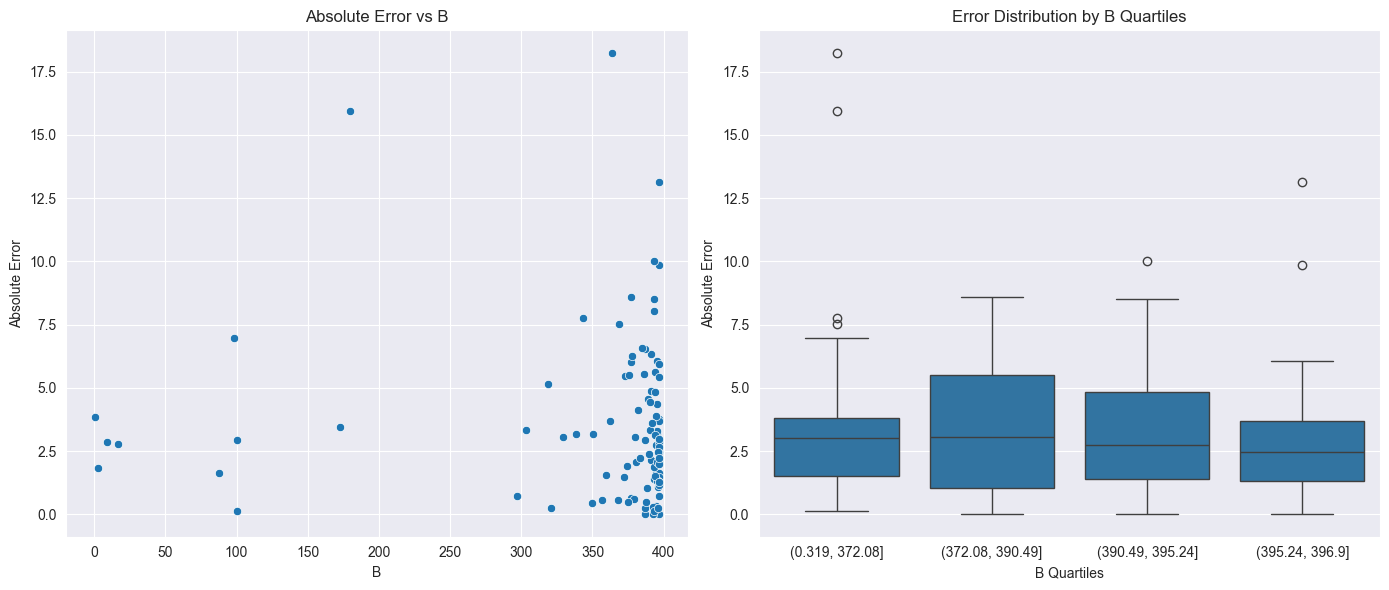

Evaluating: FairBoostRegressor_v1_Improved, Fold: 1, Fairness weight: 0.75


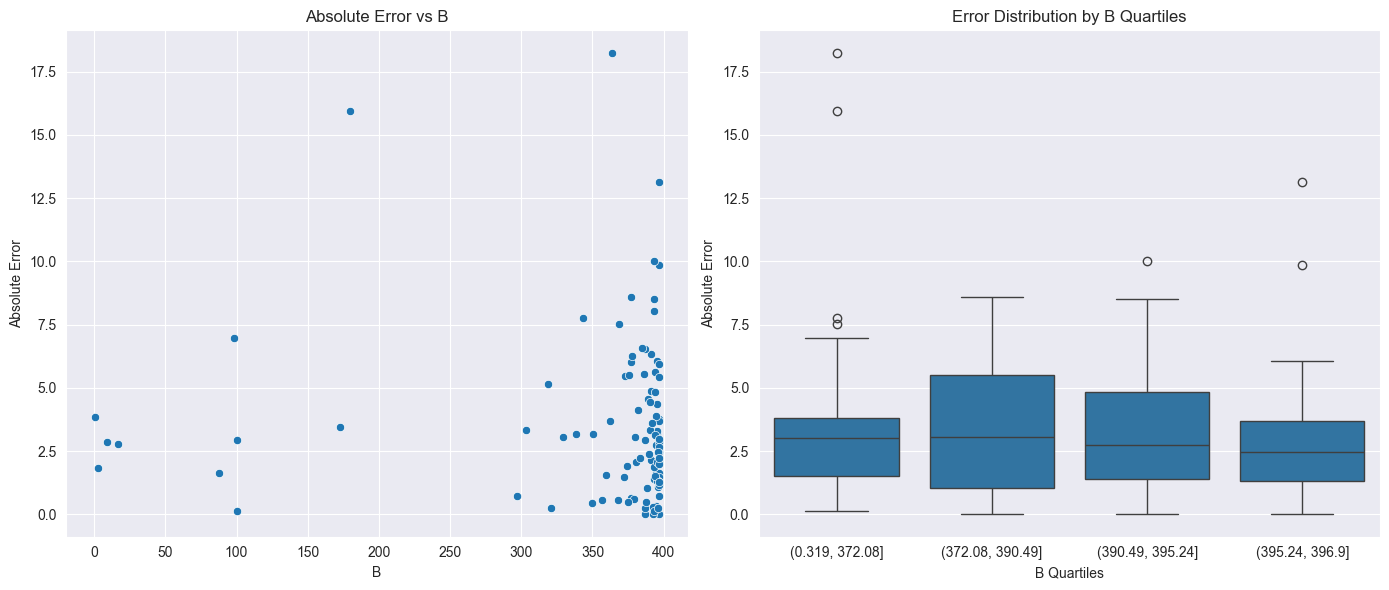

Evaluating: FairBoostRegressor_v2, Fold: 1, Fairness weight: 0.25


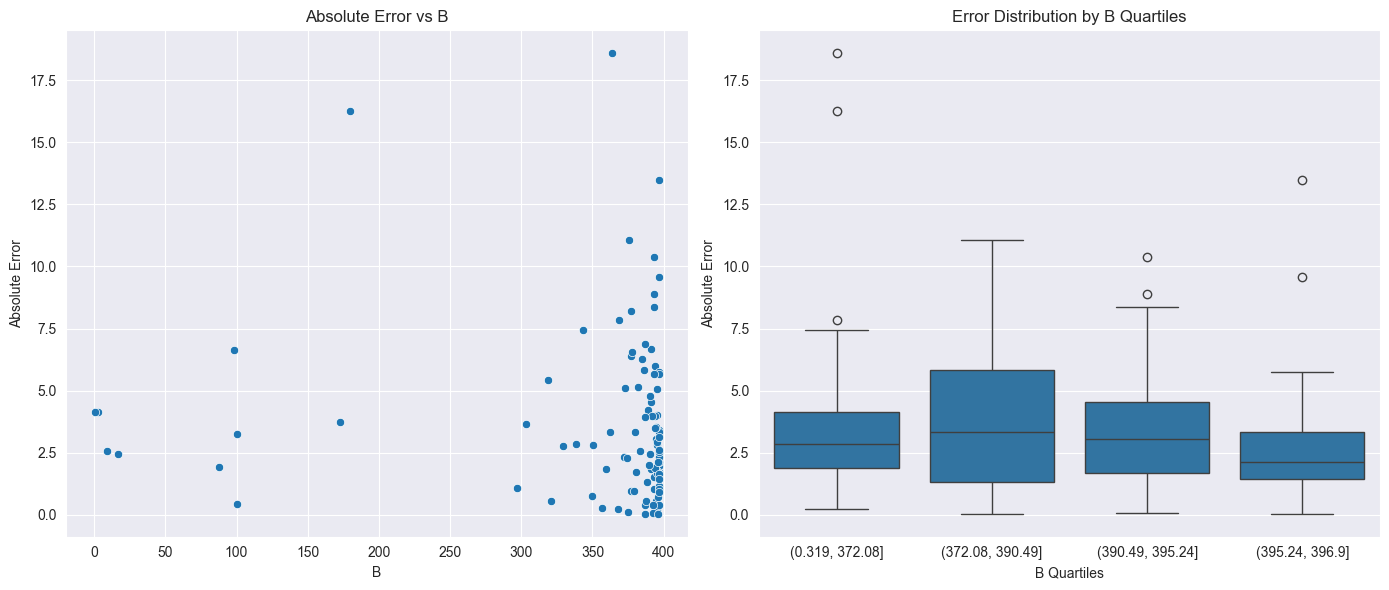

Evaluating: FairBoostRegressor_v2, Fold: 1, Fairness weight: 0.5


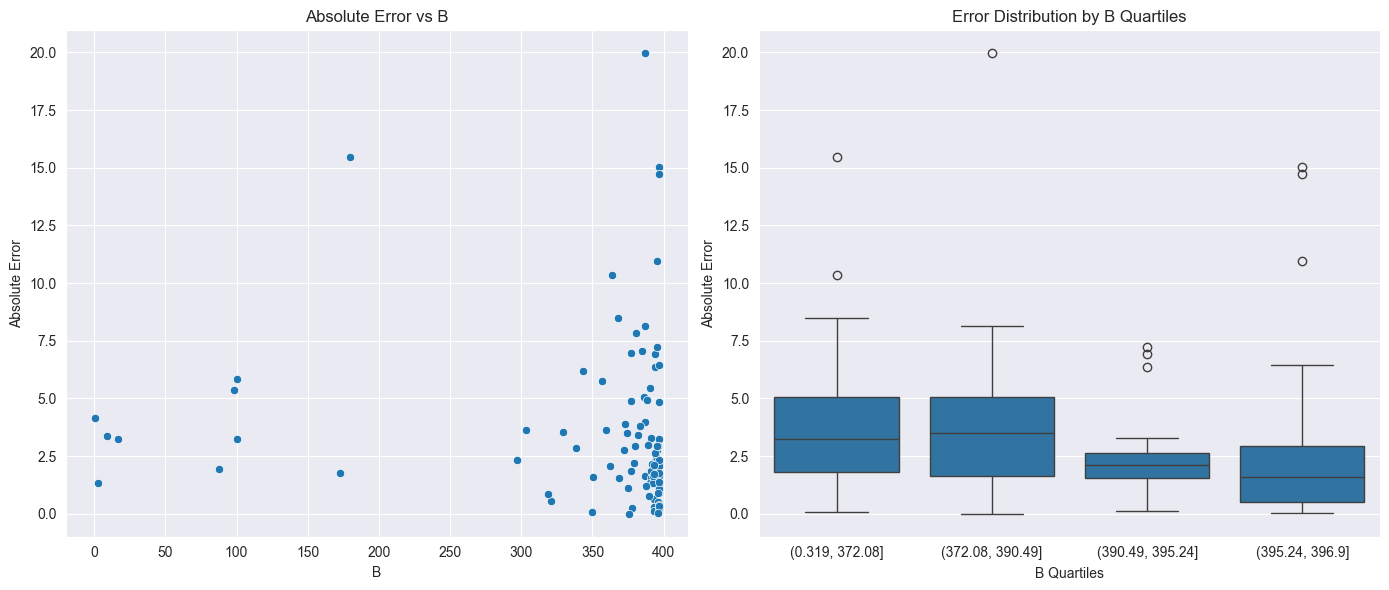

Evaluating: FairBoostRegressor_v2, Fold: 1, Fairness weight: 0.75


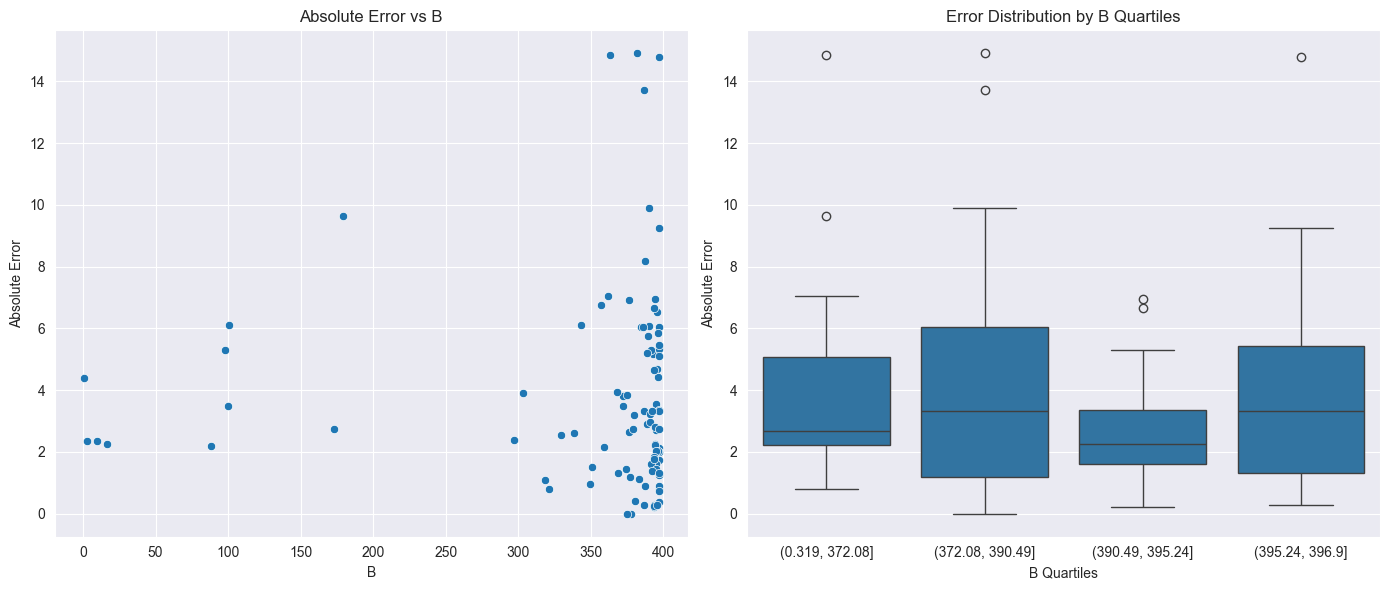

Evaluating: FairBoostRegressor_v2_Improved, Fold: 1, Fairness weight: 0.25


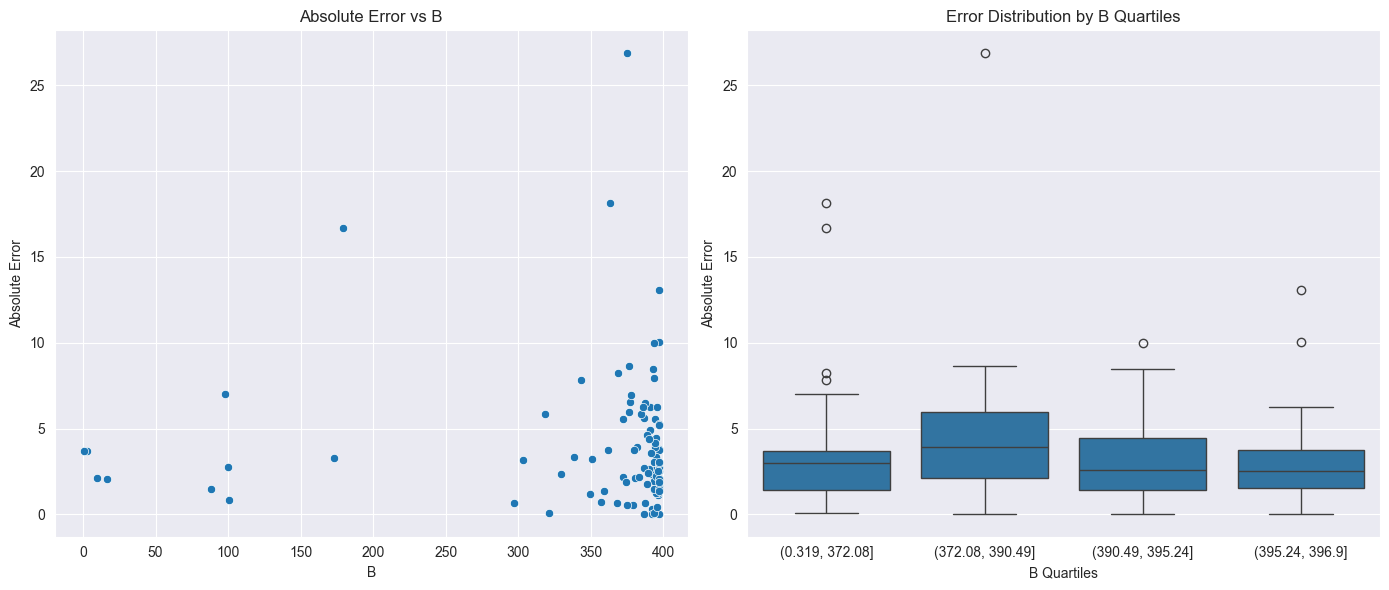

Evaluating: FairBoostRegressor_v2_Improved, Fold: 1, Fairness weight: 0.5


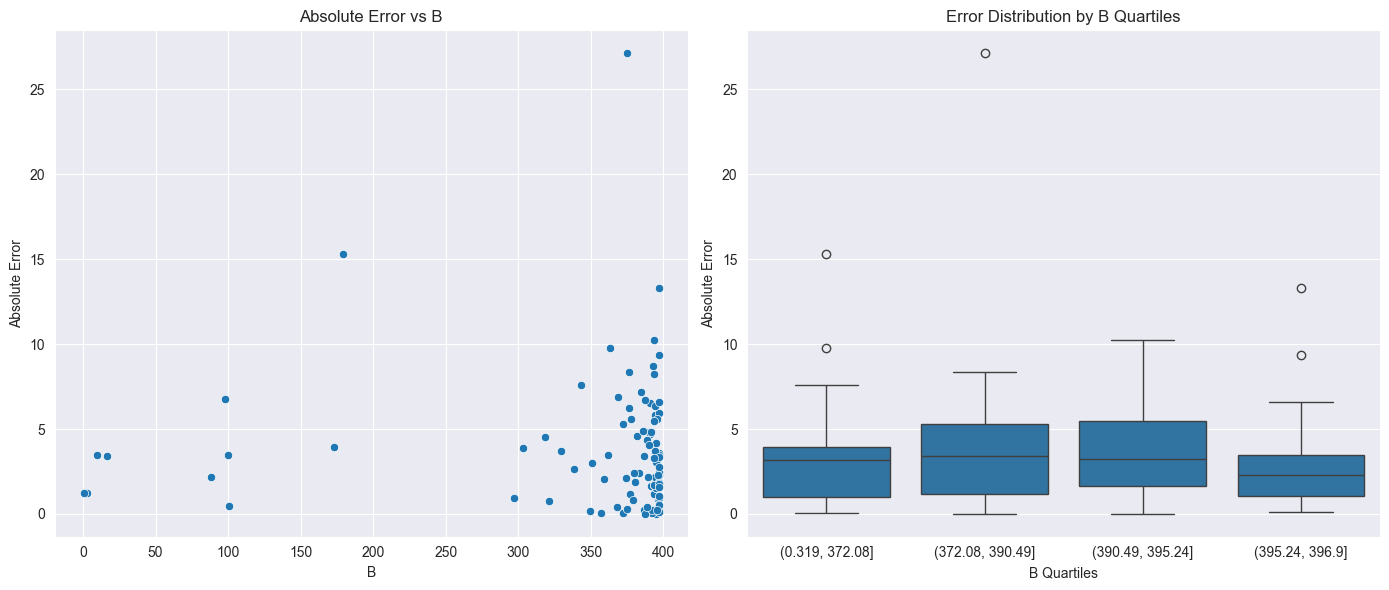

Evaluating: FairBoostRegressor_v2_Improved, Fold: 1, Fairness weight: 0.75


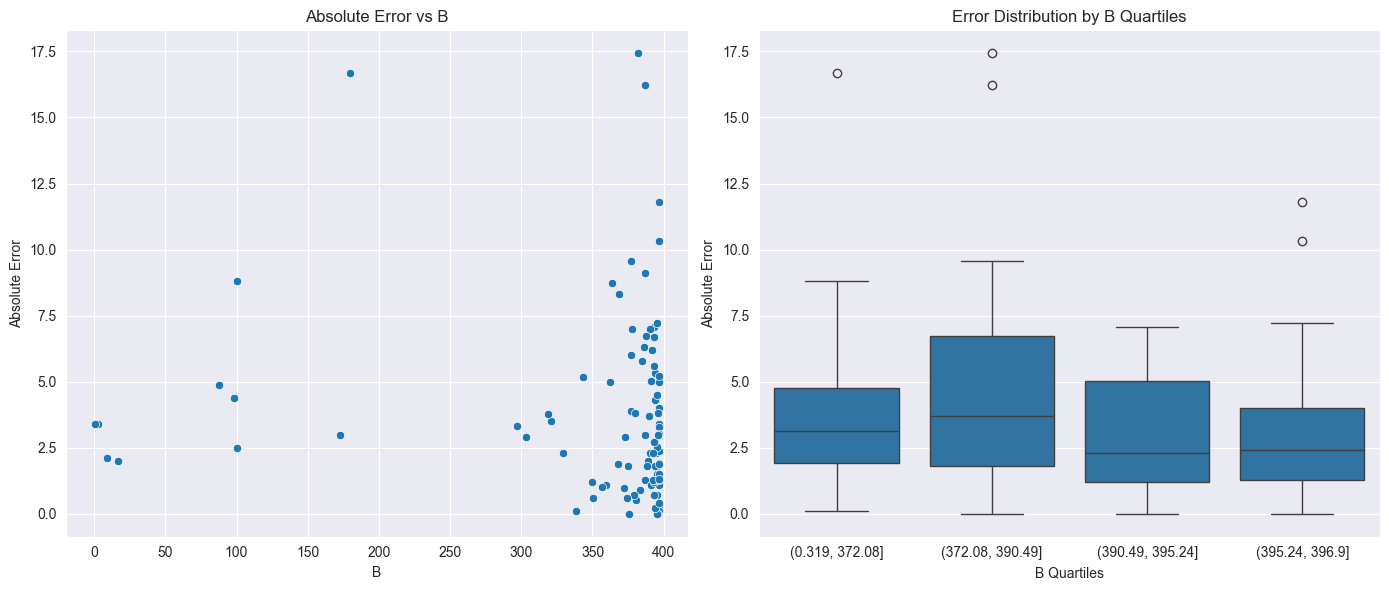

Evaluating: FairBoostRegressor_v3, Fold: 1, Fairness weight: 0.25


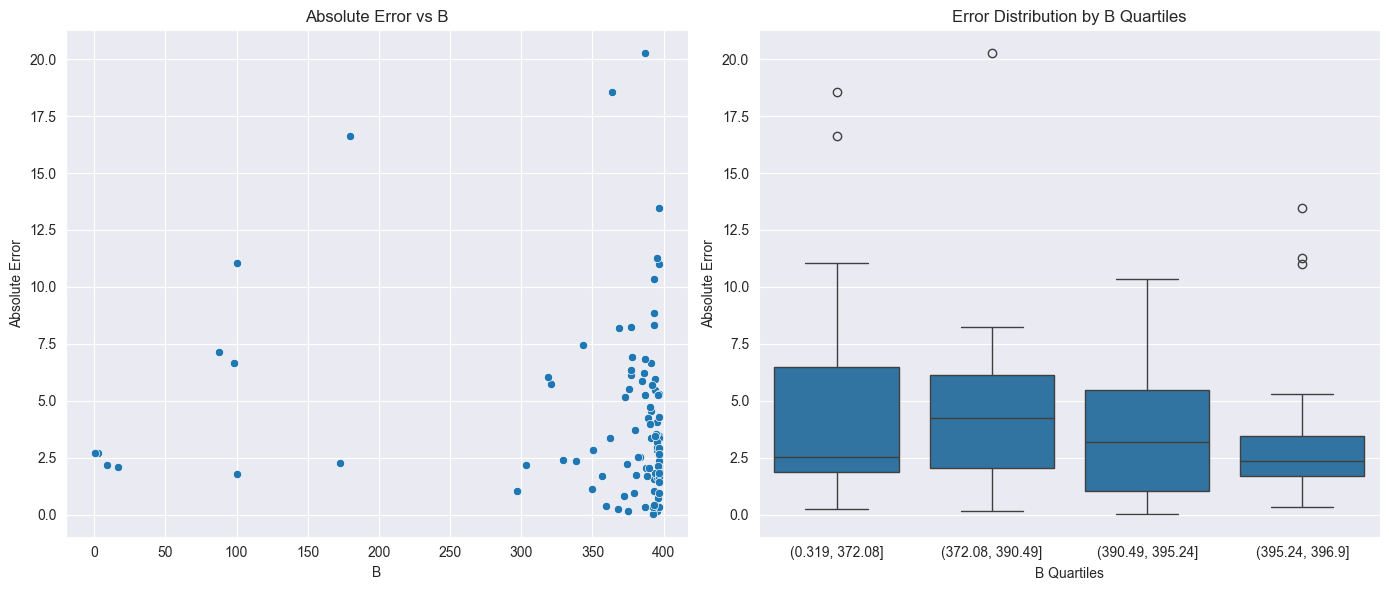

Evaluating: FairBoostRegressor_v3, Fold: 1, Fairness weight: 0.5


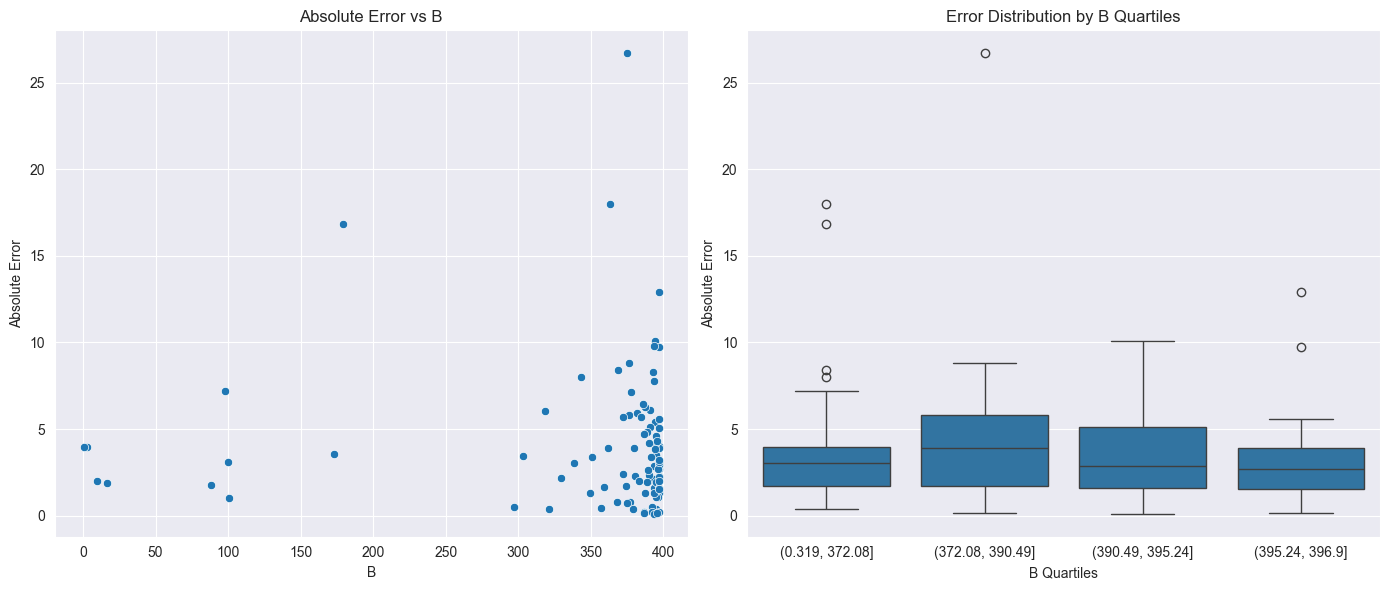

Evaluating: FairBoostRegressor_v3, Fold: 1, Fairness weight: 0.75


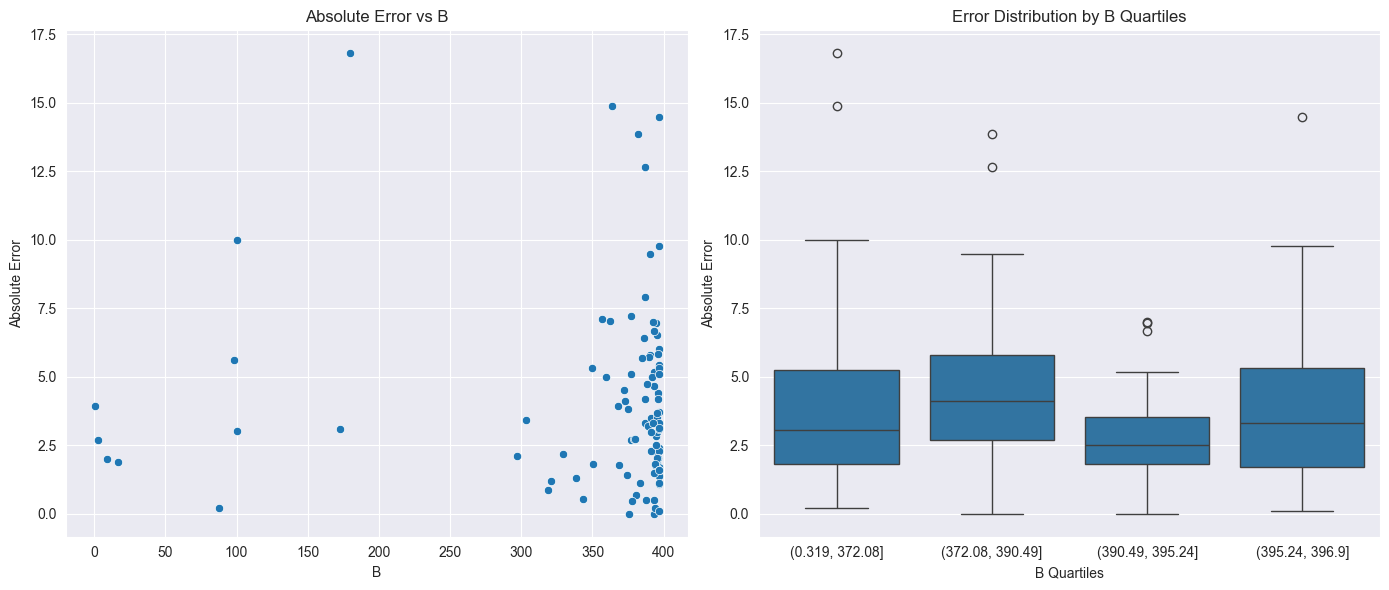

Evaluating: FairBoostRegressor_v1, Fold: 2, Fairness weight: 0.25


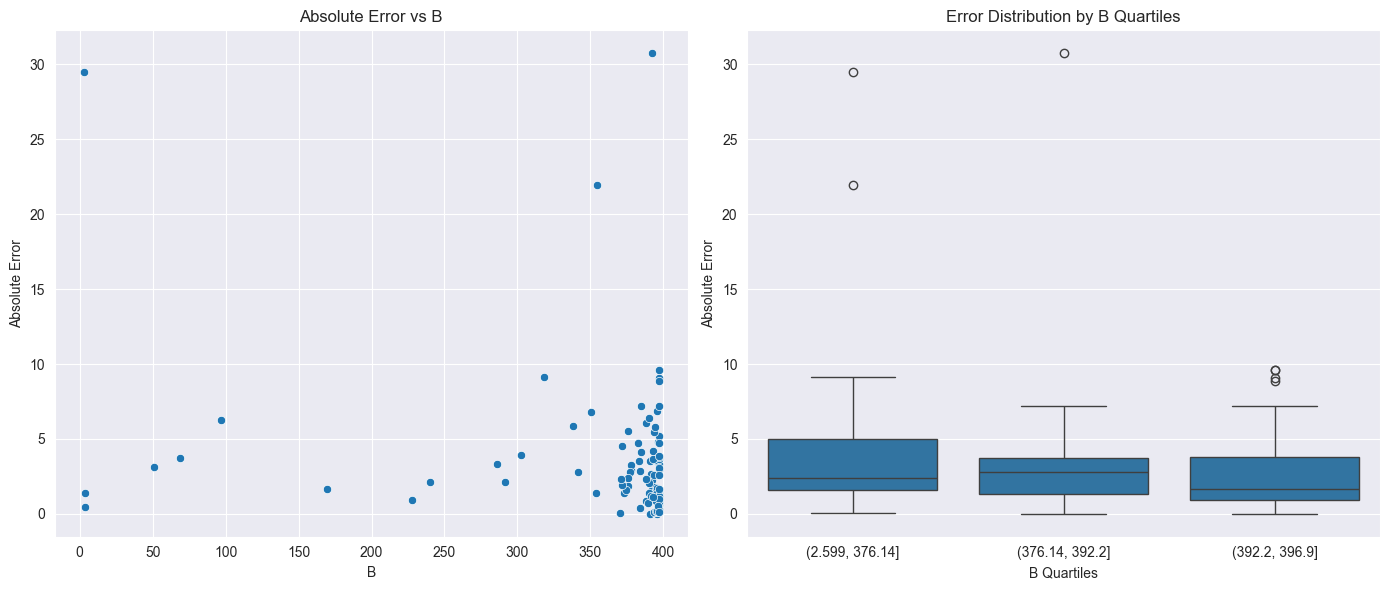

Evaluating: FairBoostRegressor_v1, Fold: 2, Fairness weight: 0.5


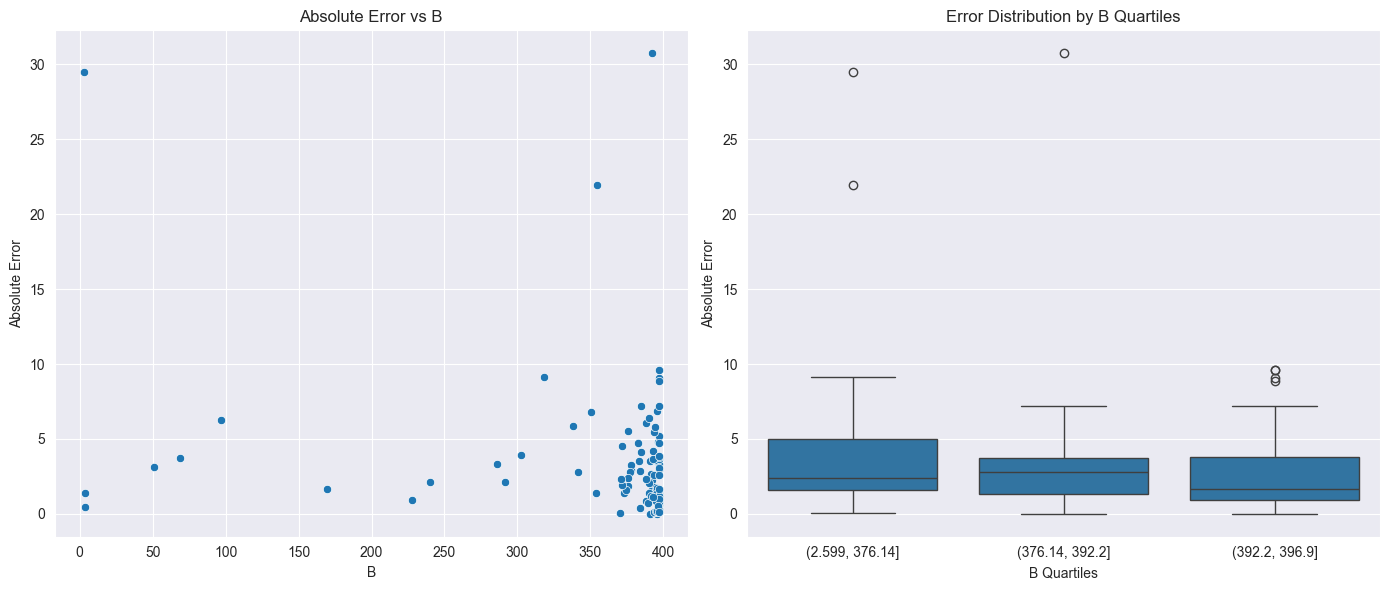

Evaluating: FairBoostRegressor_v1, Fold: 2, Fairness weight: 0.75


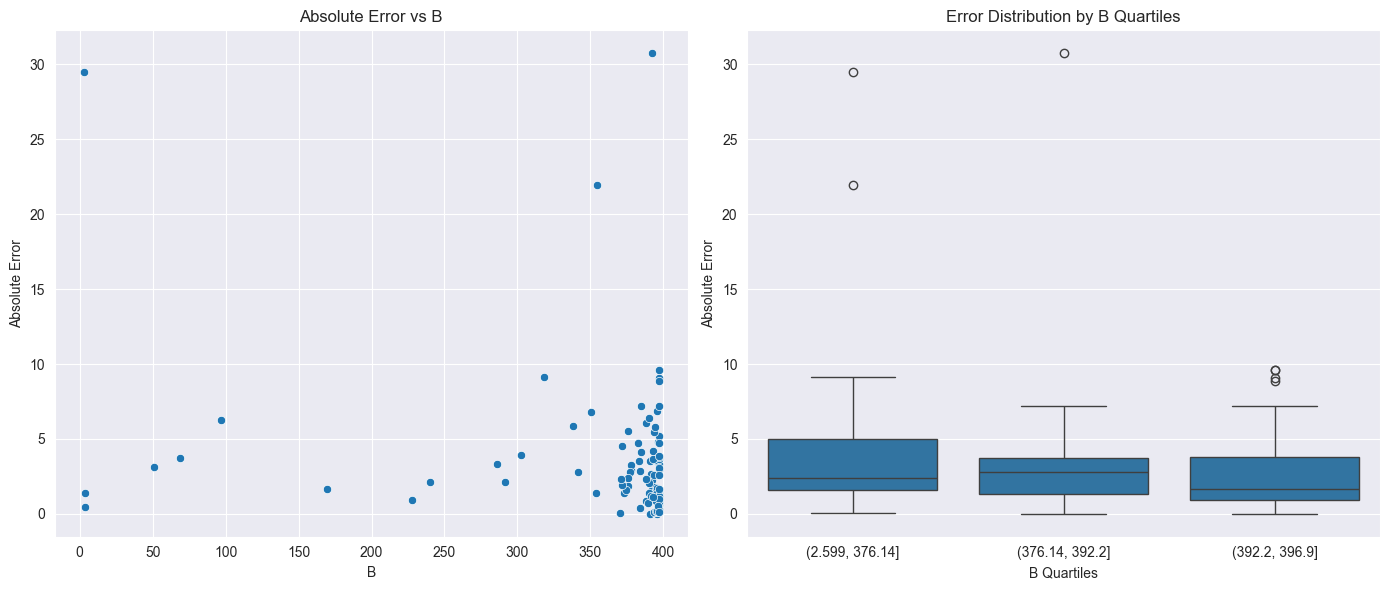

Evaluating: FairBoostRegressor_v1_Improved, Fold: 2, Fairness weight: 0.25


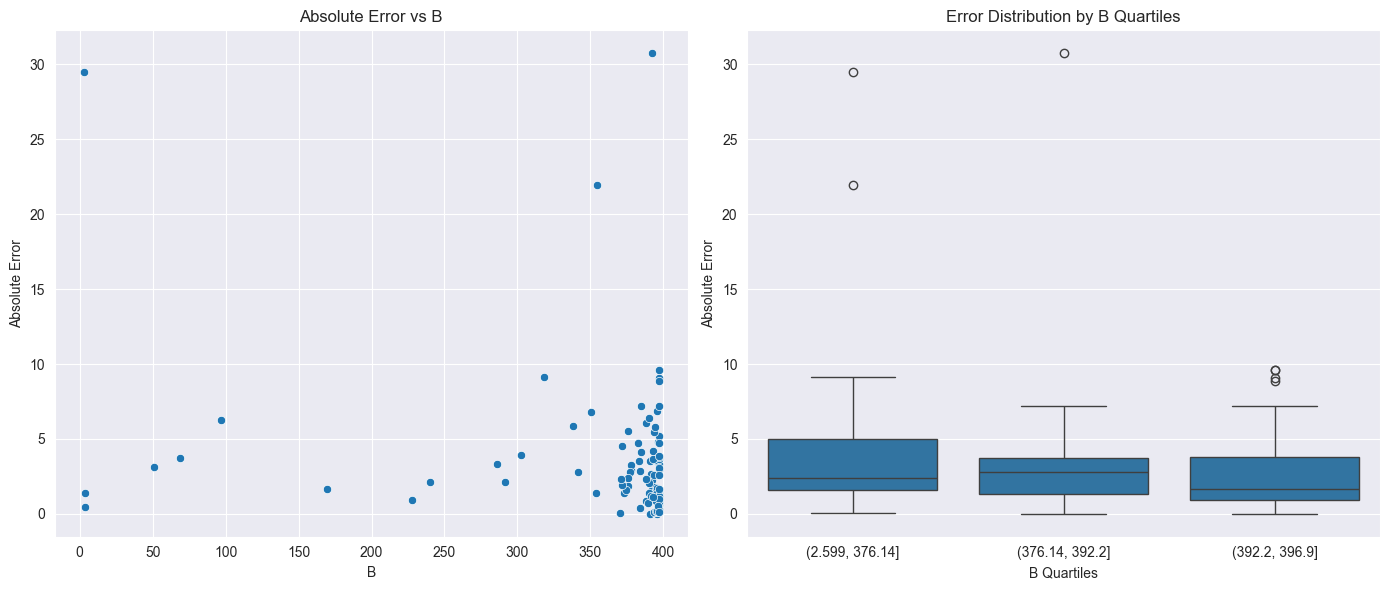

Evaluating: FairBoostRegressor_v1_Improved, Fold: 2, Fairness weight: 0.5


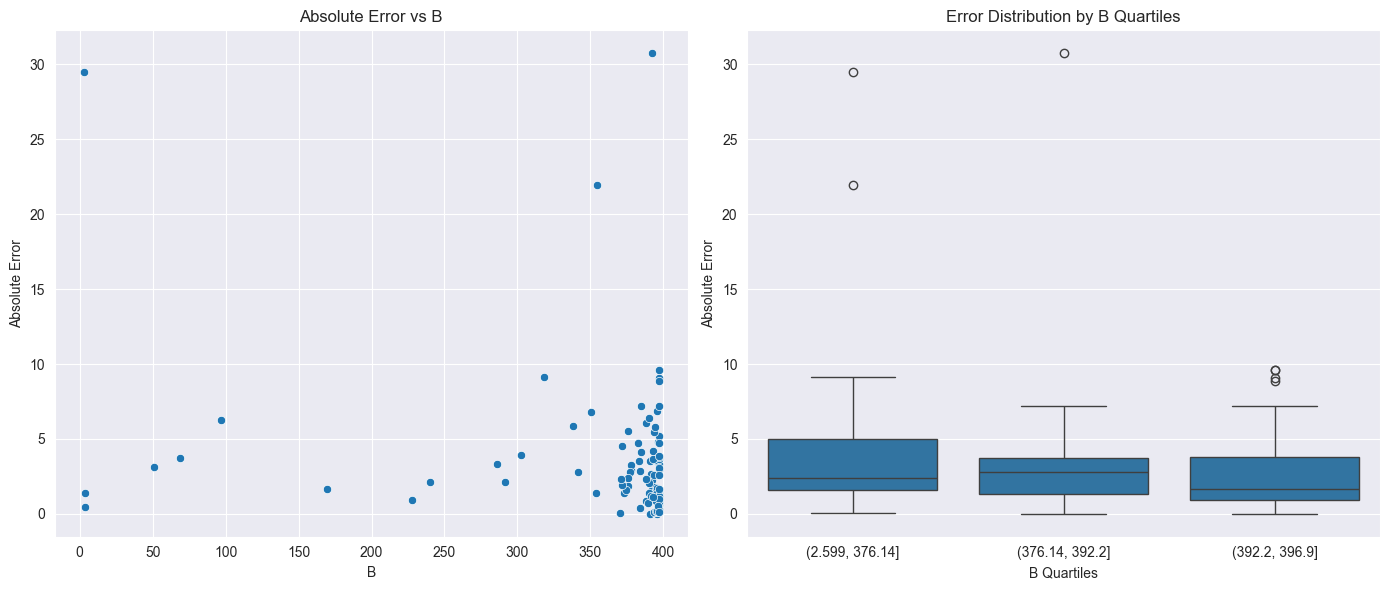

Evaluating: FairBoostRegressor_v1_Improved, Fold: 2, Fairness weight: 0.75


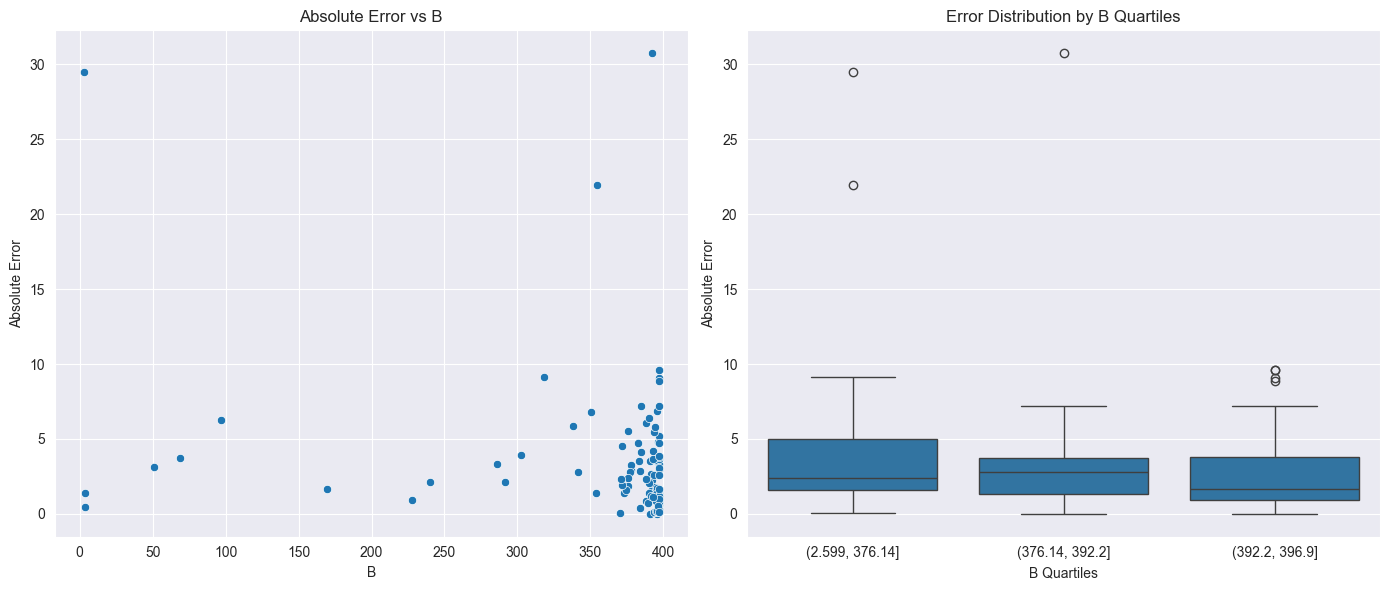

Evaluating: FairBoostRegressor_v2, Fold: 2, Fairness weight: 0.25


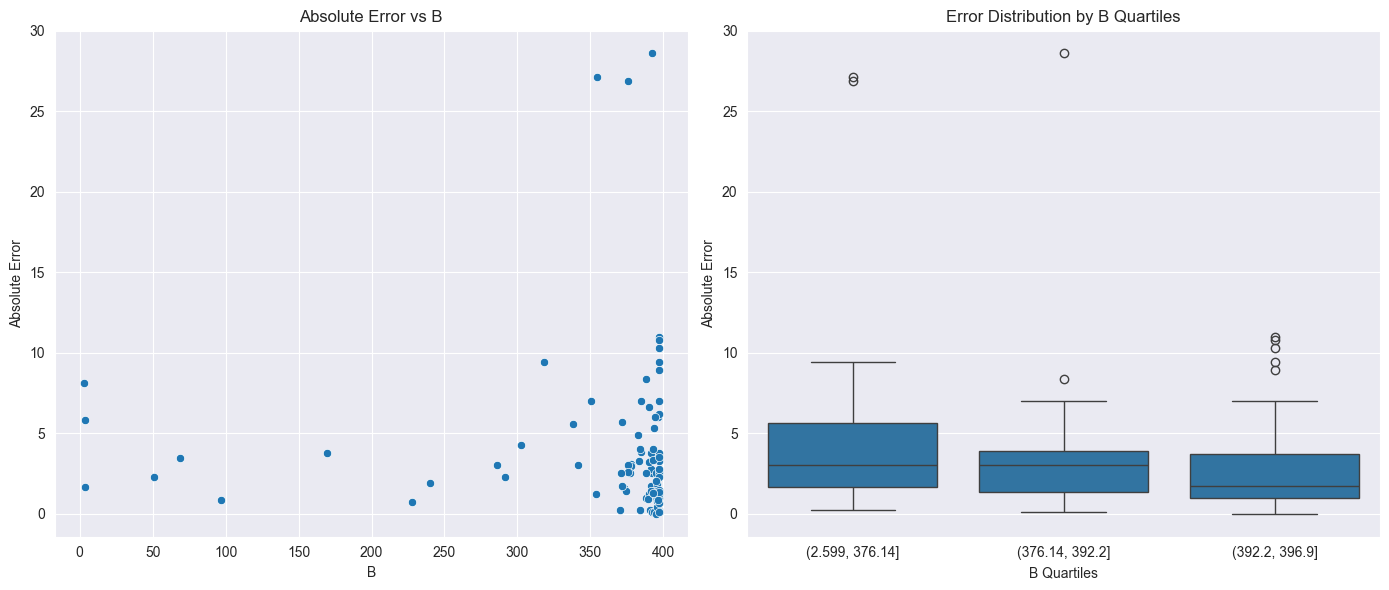

Evaluating: FairBoostRegressor_v2, Fold: 2, Fairness weight: 0.5


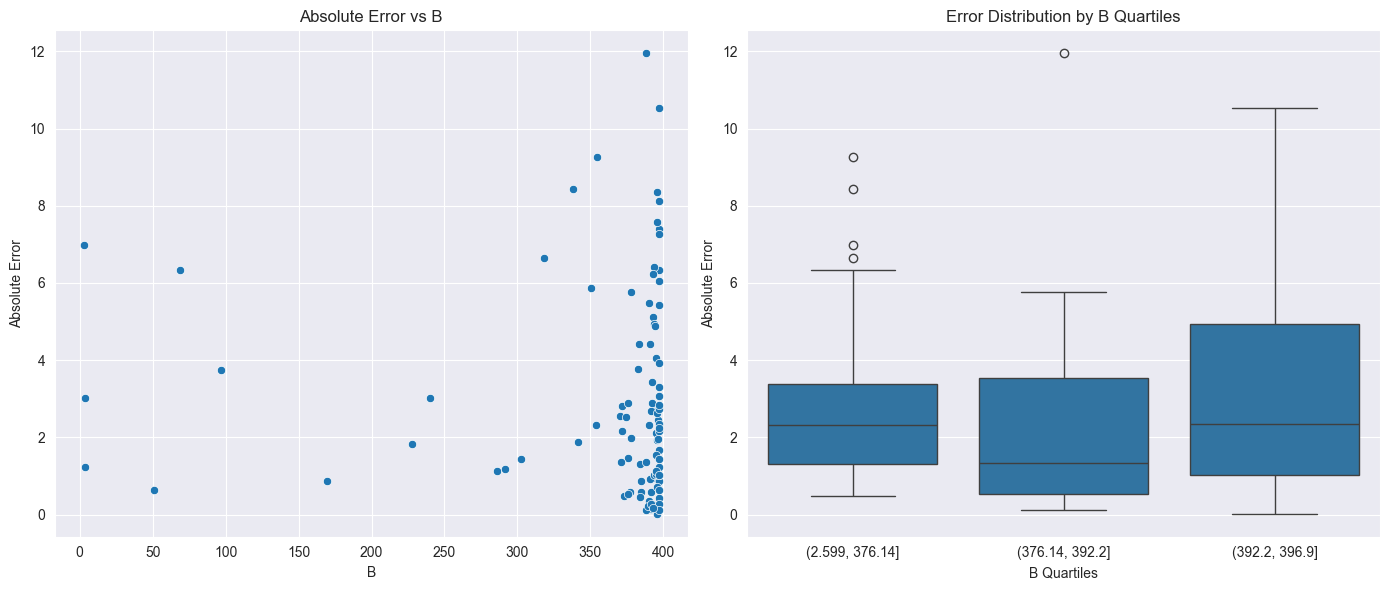

Evaluating: FairBoostRegressor_v2, Fold: 2, Fairness weight: 0.75


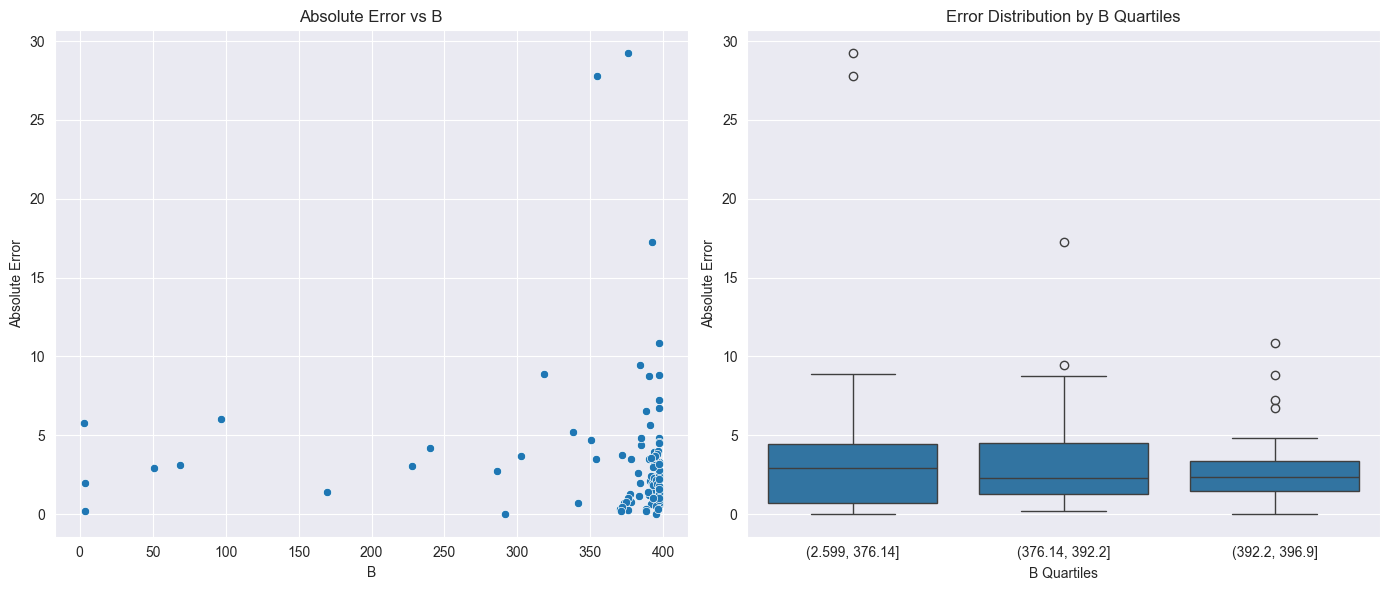

Evaluating: FairBoostRegressor_v2_Improved, Fold: 2, Fairness weight: 0.25


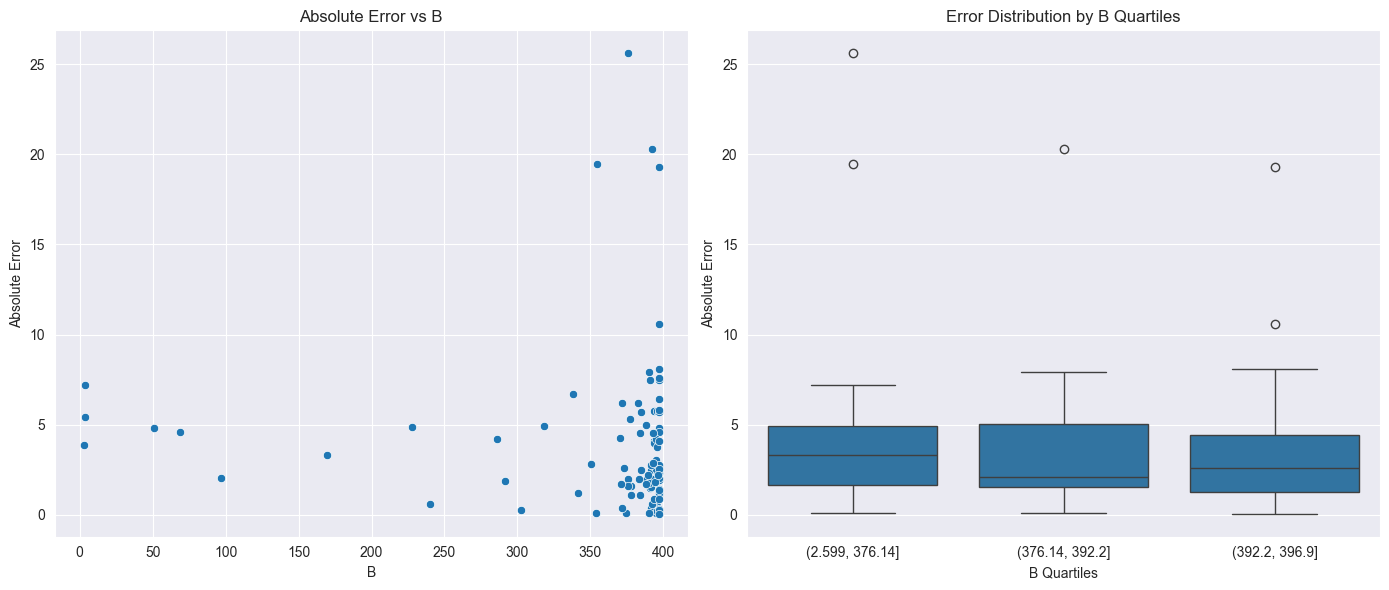

Evaluating: FairBoostRegressor_v2_Improved, Fold: 2, Fairness weight: 0.5


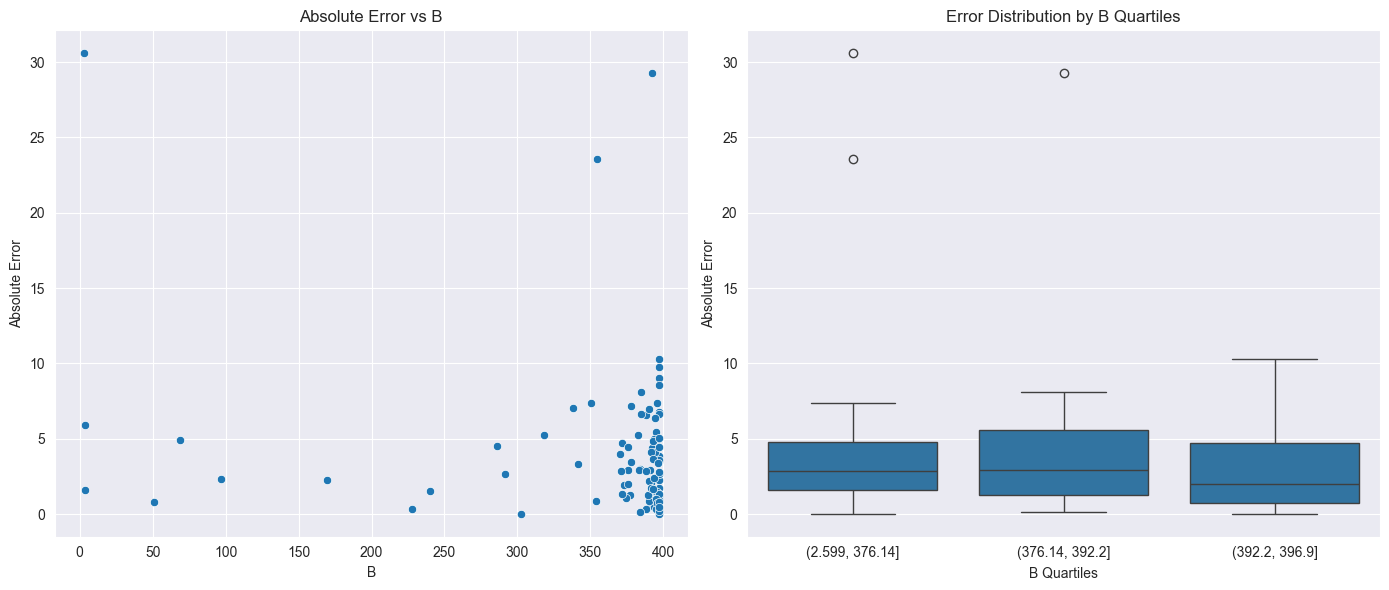

Evaluating: FairBoostRegressor_v2_Improved, Fold: 2, Fairness weight: 0.75


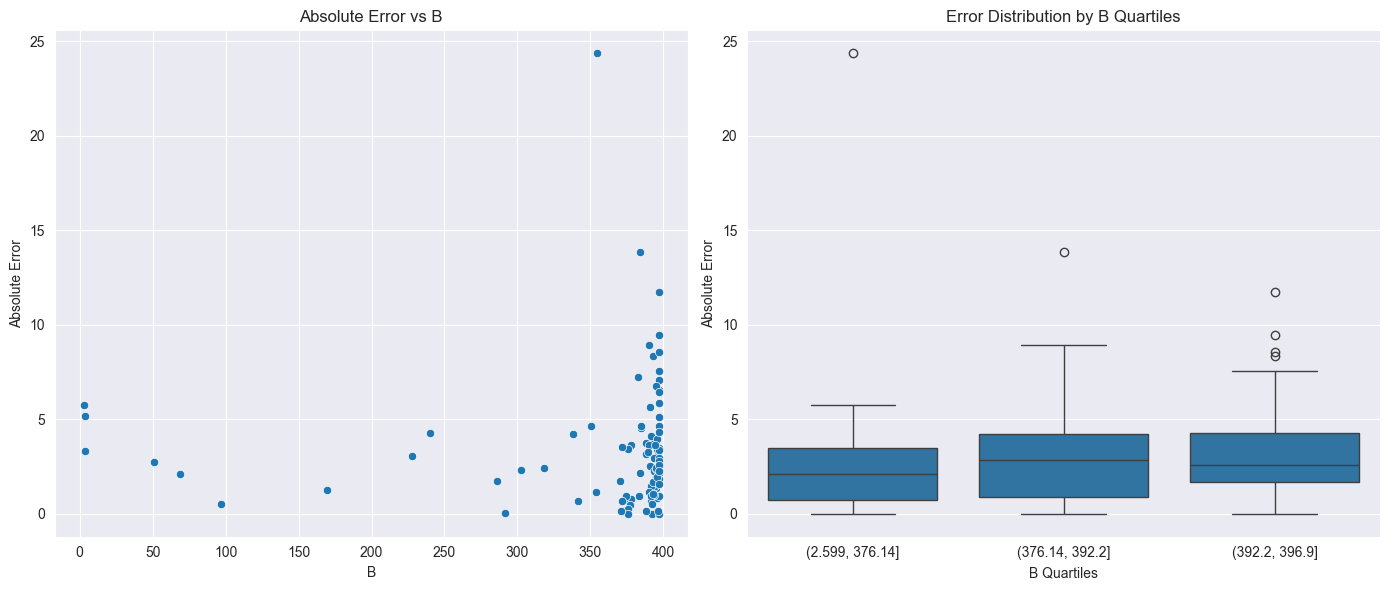

Evaluating: FairBoostRegressor_v3, Fold: 2, Fairness weight: 0.25


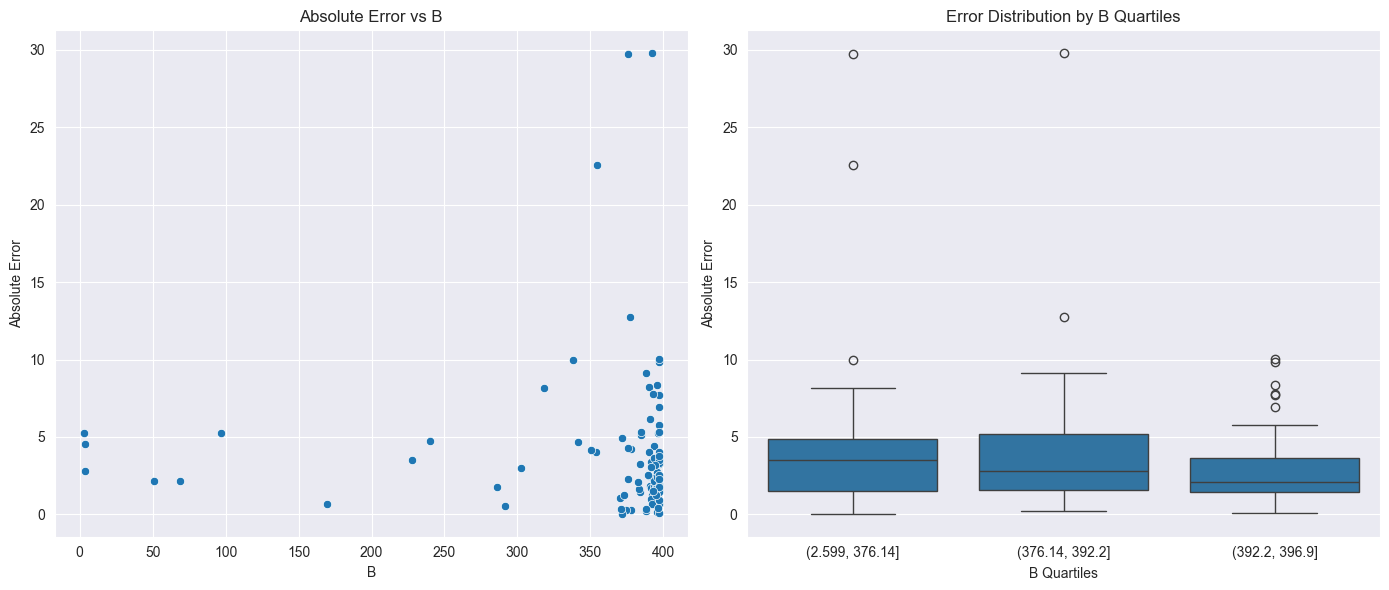

Evaluating: FairBoostRegressor_v3, Fold: 2, Fairness weight: 0.5


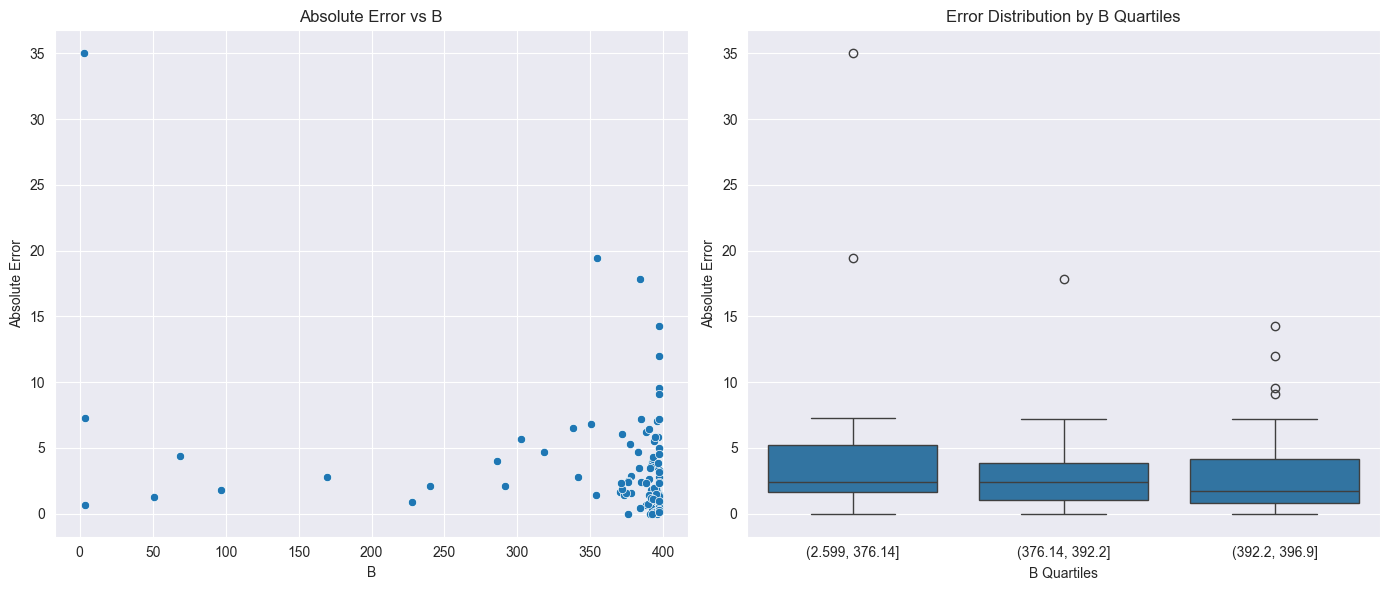

Evaluating: FairBoostRegressor_v3, Fold: 2, Fairness weight: 0.75


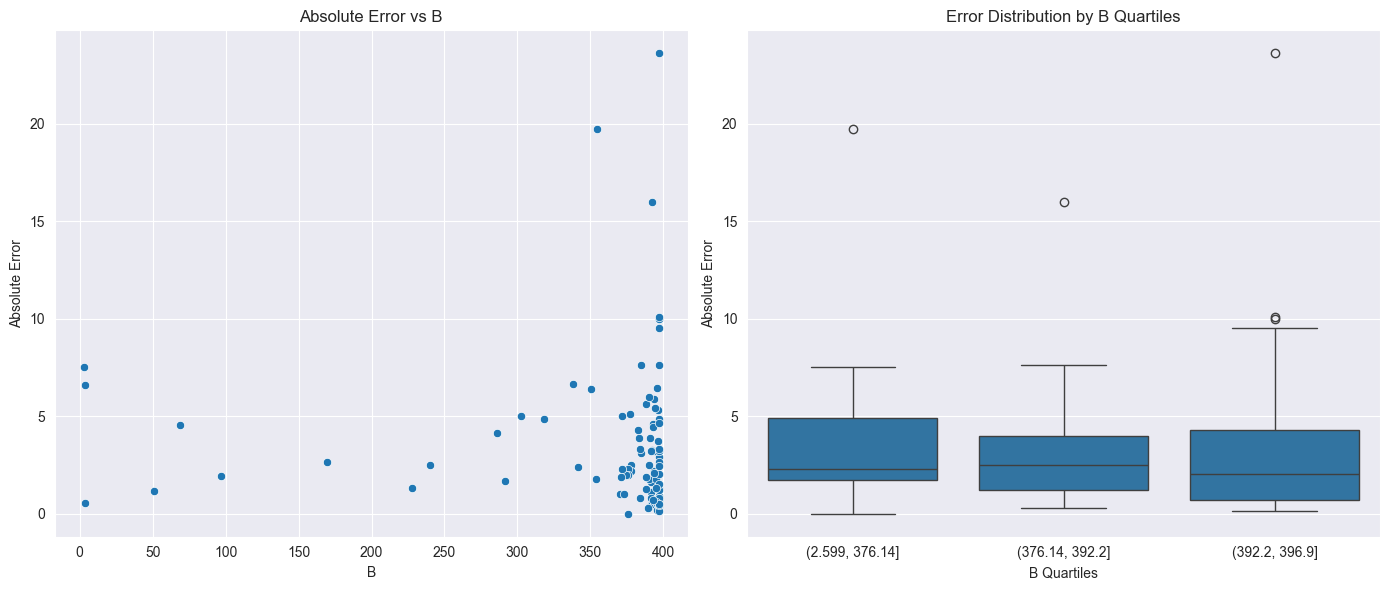

Evaluating: FairBoostRegressor_v1, Fold: 3, Fairness weight: 0.25


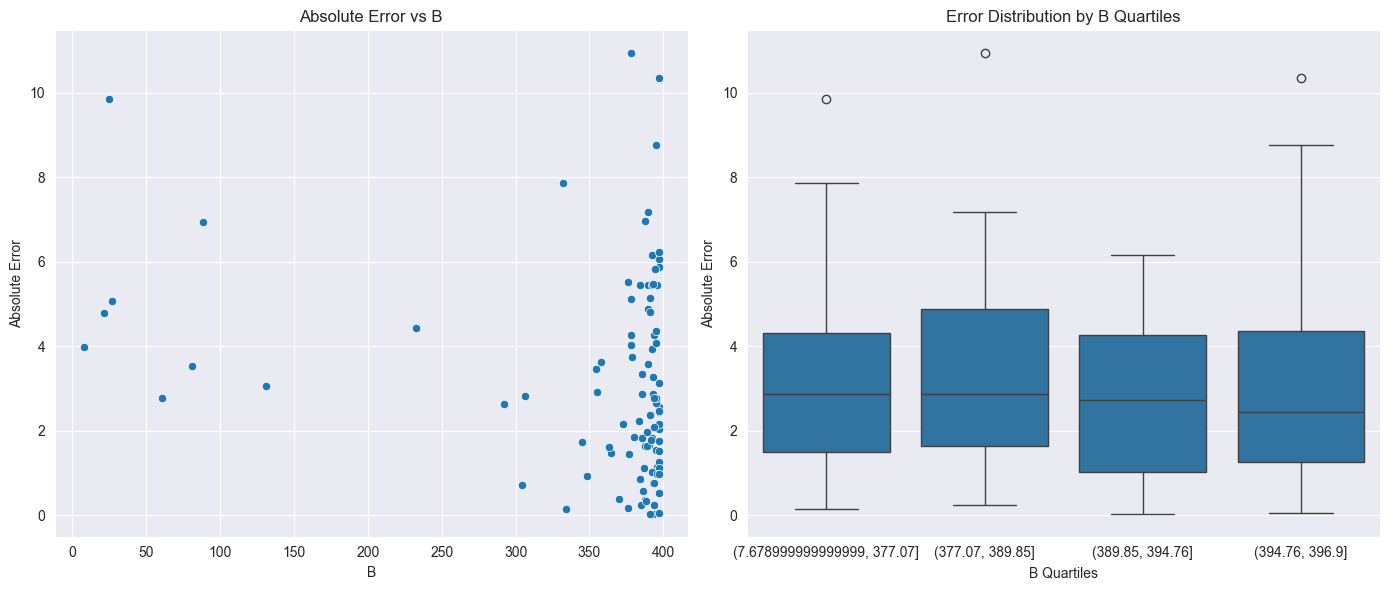

Evaluating: FairBoostRegressor_v1, Fold: 3, Fairness weight: 0.5


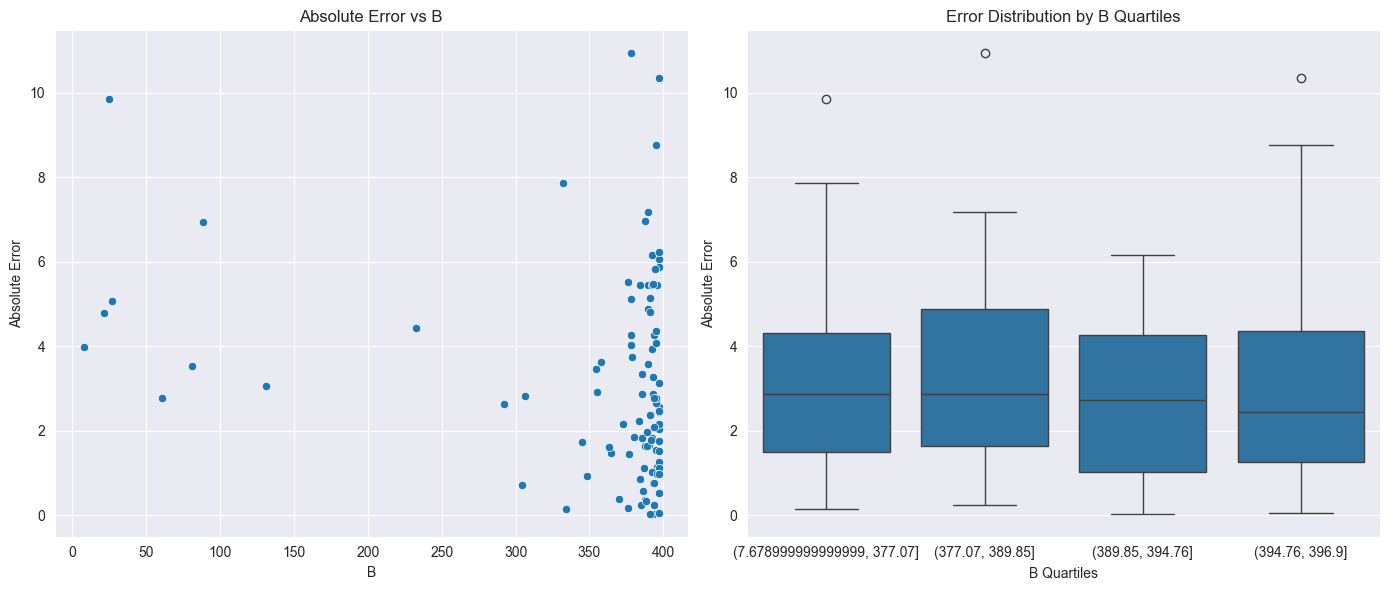

Evaluating: FairBoostRegressor_v1, Fold: 3, Fairness weight: 0.75


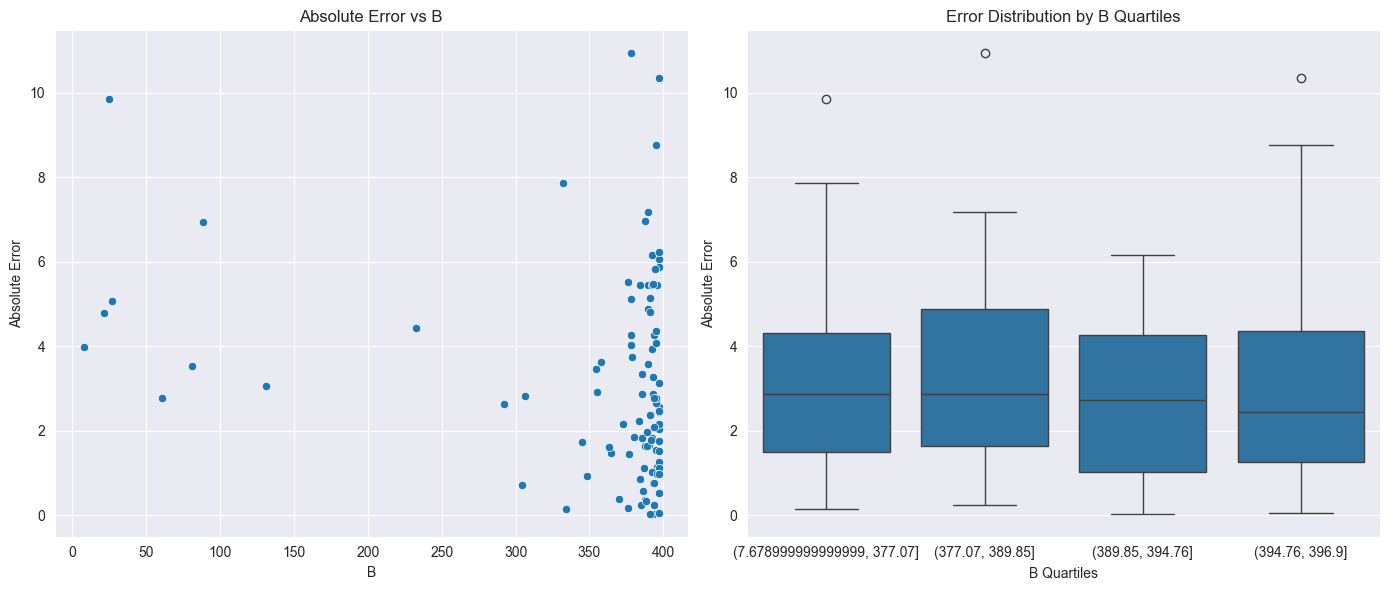

Evaluating: FairBoostRegressor_v1_Improved, Fold: 3, Fairness weight: 0.25


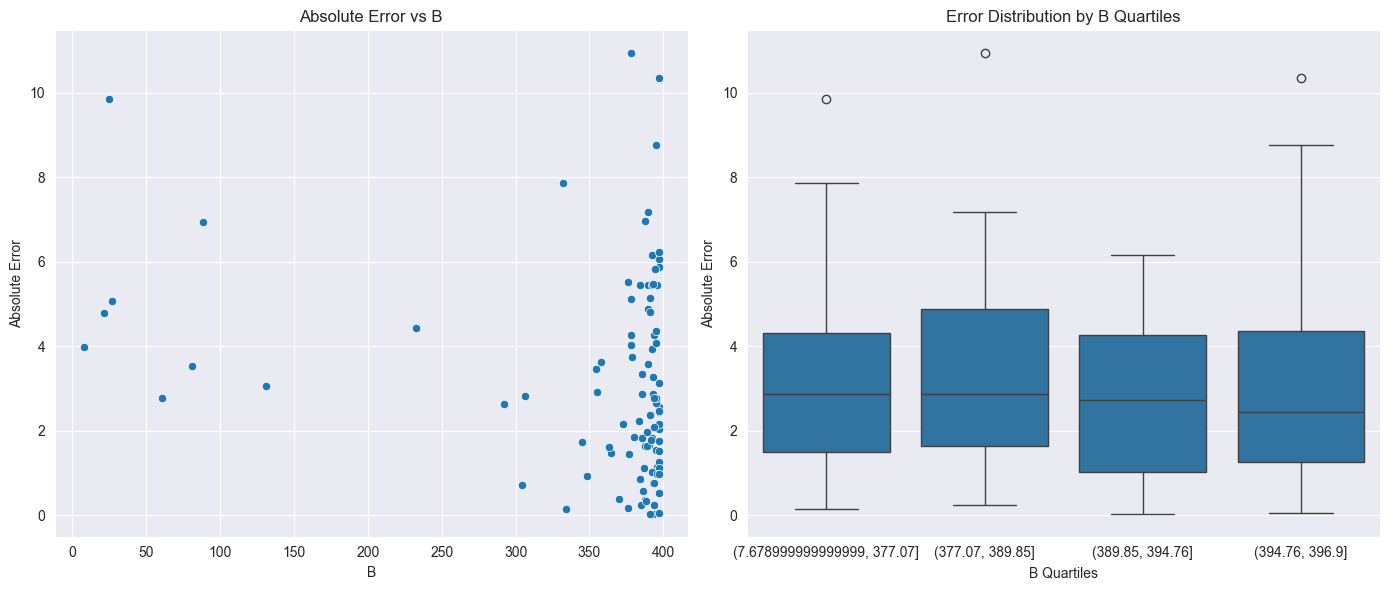

Evaluating: FairBoostRegressor_v1_Improved, Fold: 3, Fairness weight: 0.5


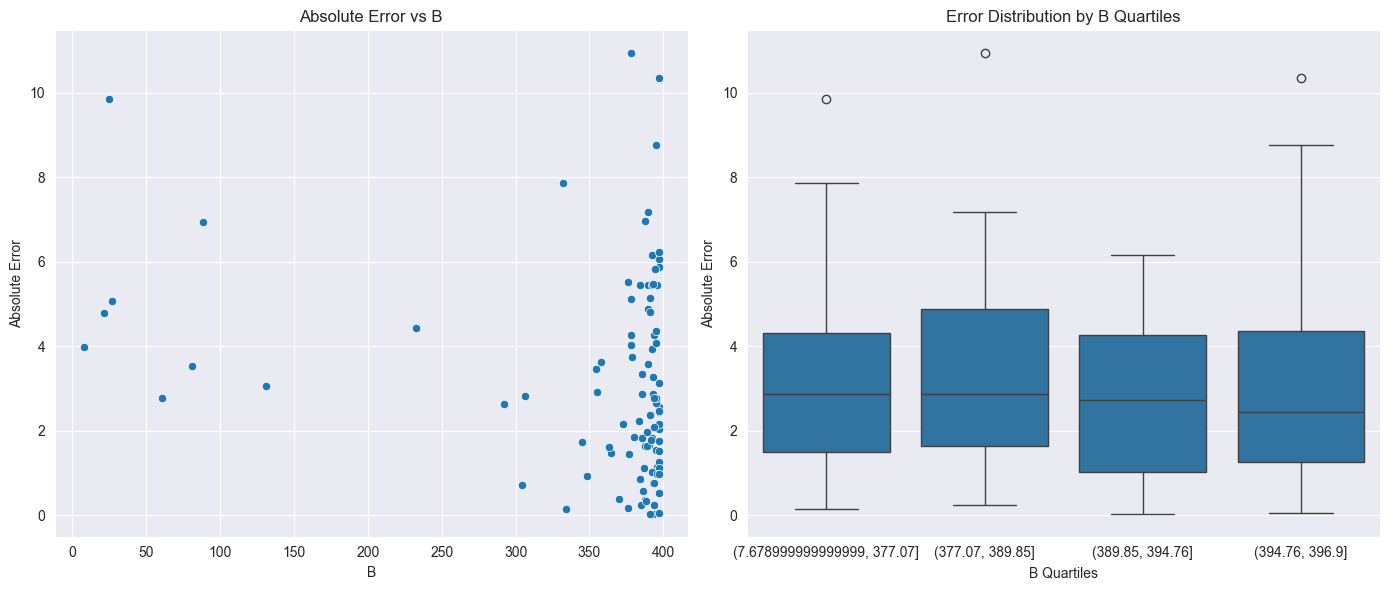

Evaluating: FairBoostRegressor_v1_Improved, Fold: 3, Fairness weight: 0.75


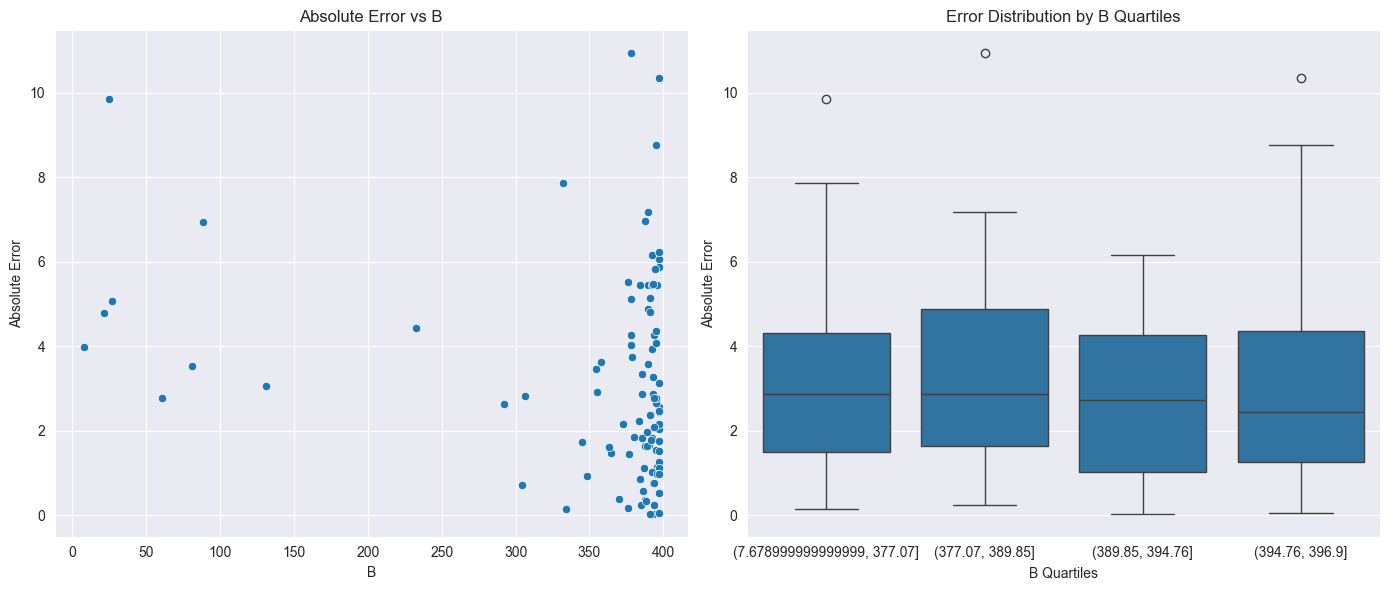

Evaluating: FairBoostRegressor_v2, Fold: 3, Fairness weight: 0.25


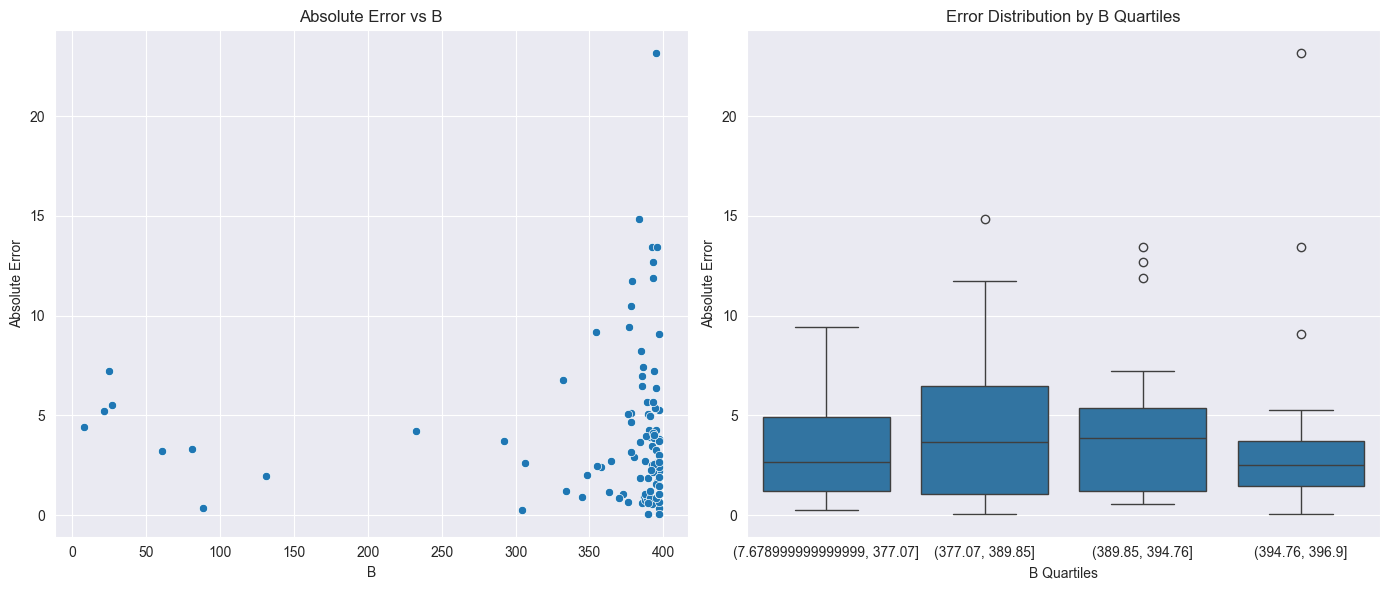

Evaluating: FairBoostRegressor_v2, Fold: 3, Fairness weight: 0.5


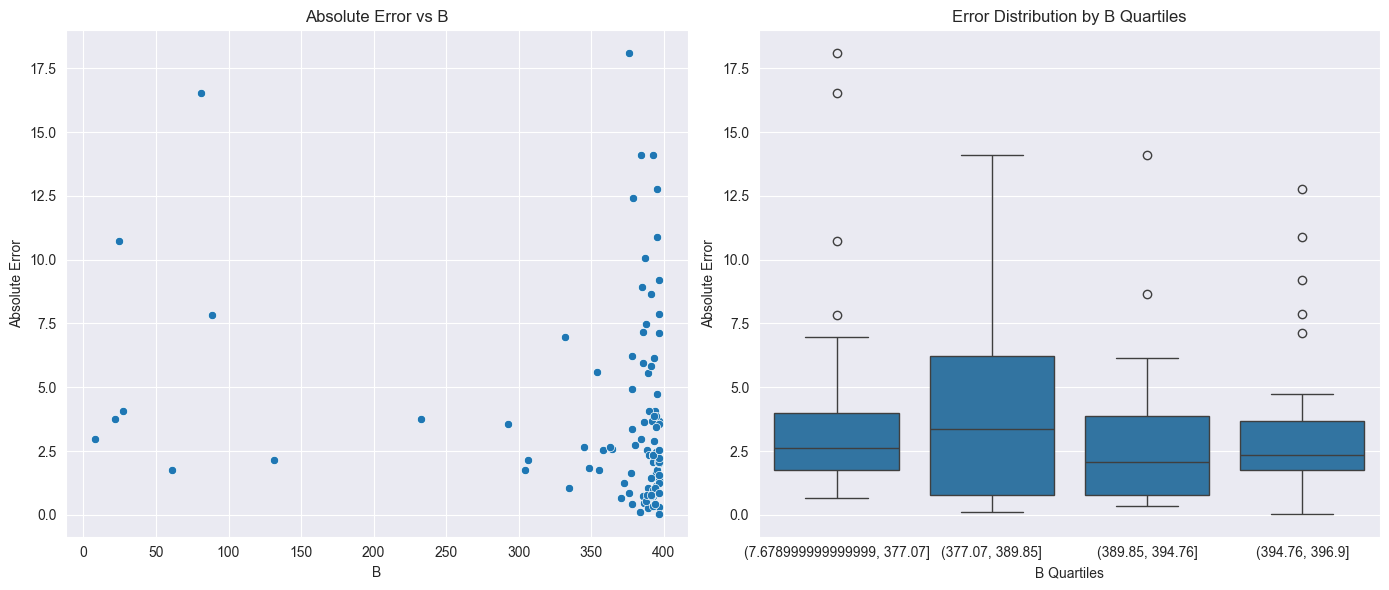

Evaluating: FairBoostRegressor_v2, Fold: 3, Fairness weight: 0.75


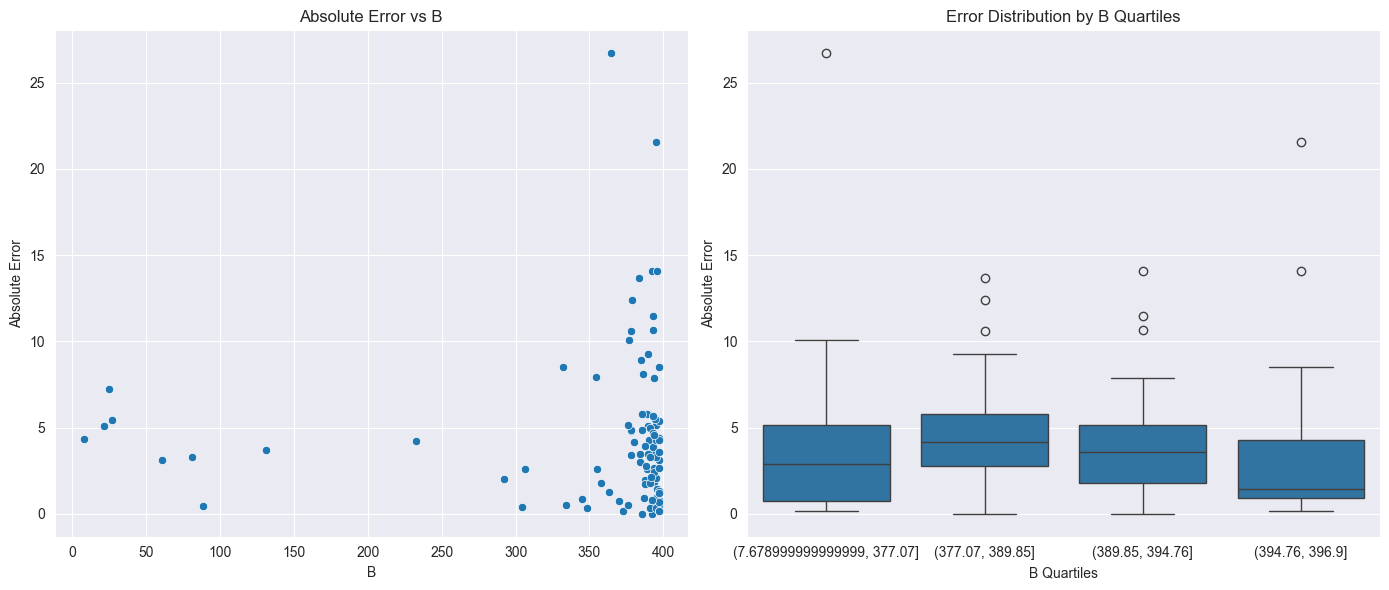

Evaluating: FairBoostRegressor_v2_Improved, Fold: 3, Fairness weight: 0.25


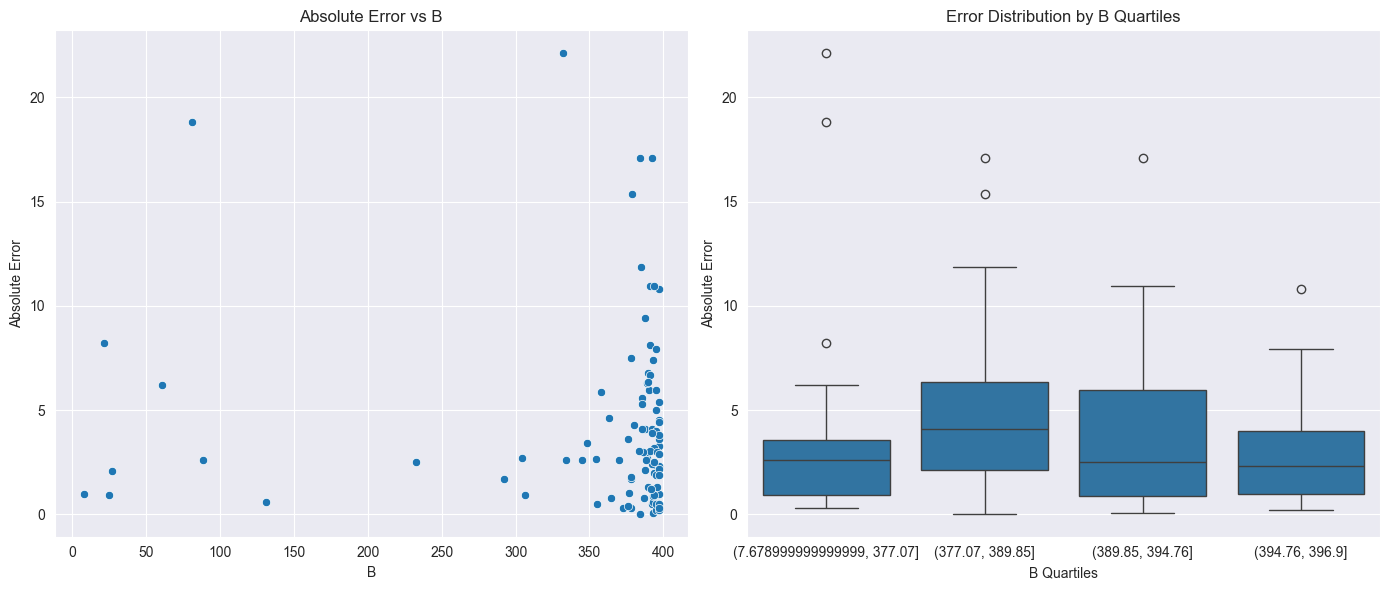

Evaluating: FairBoostRegressor_v2_Improved, Fold: 3, Fairness weight: 0.5


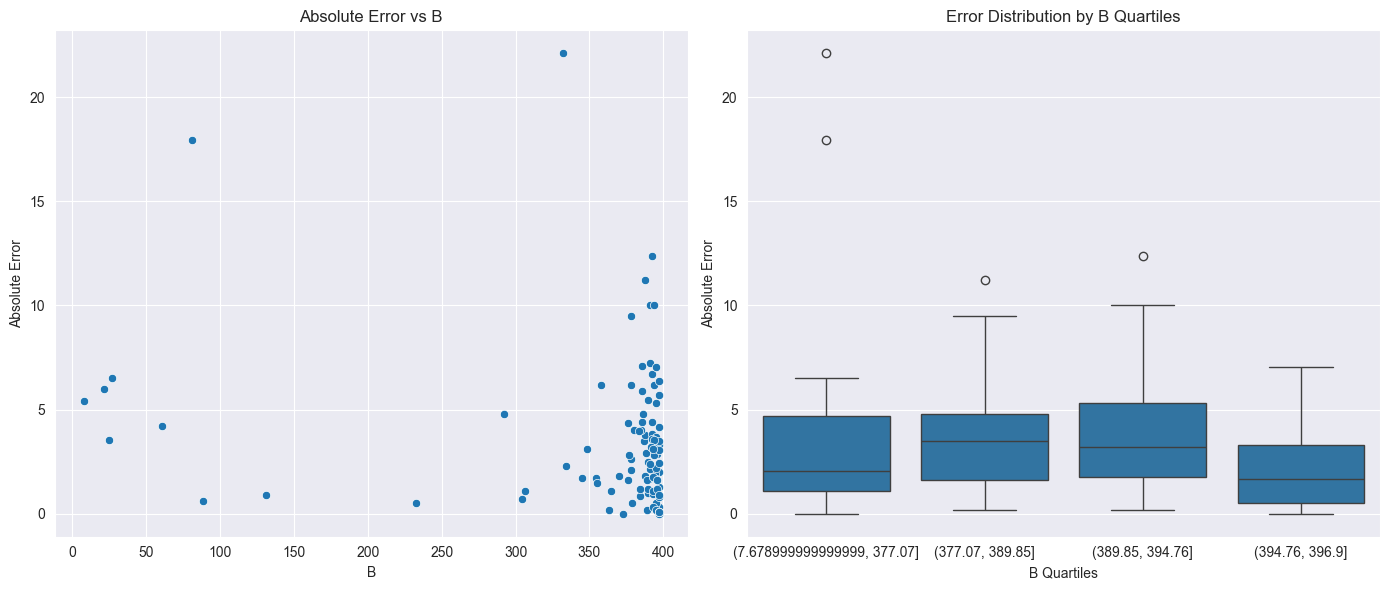

Evaluating: FairBoostRegressor_v2_Improved, Fold: 3, Fairness weight: 0.75


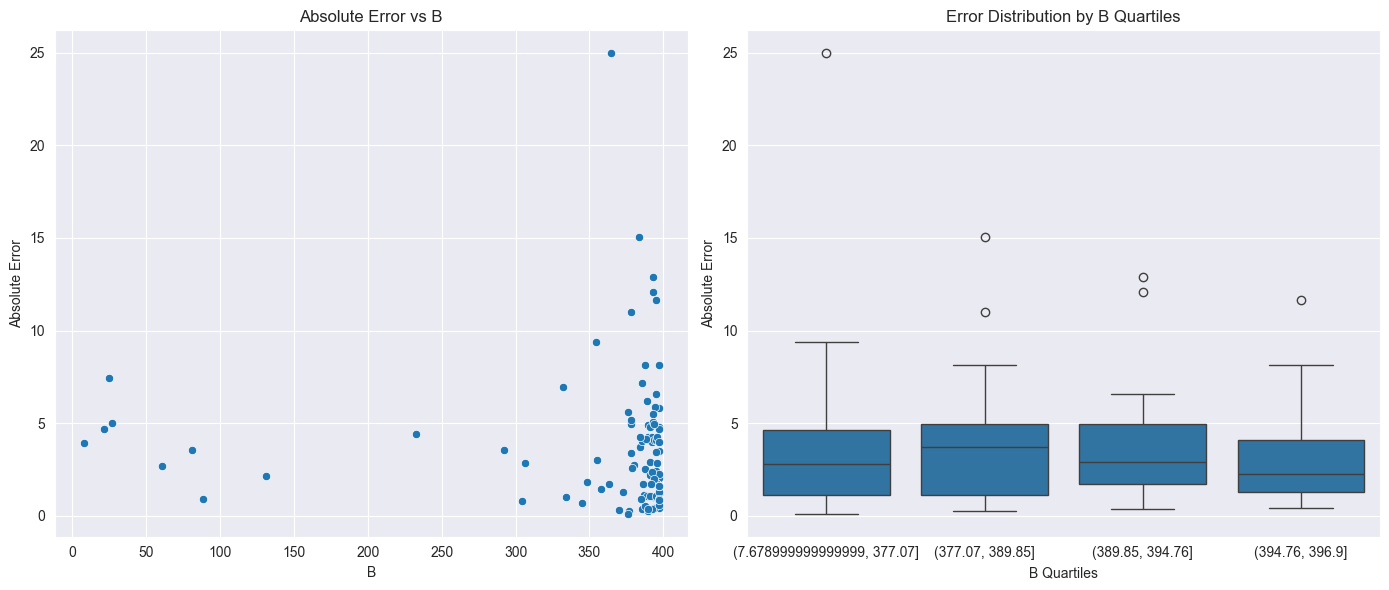

Evaluating: FairBoostRegressor_v3, Fold: 3, Fairness weight: 0.25


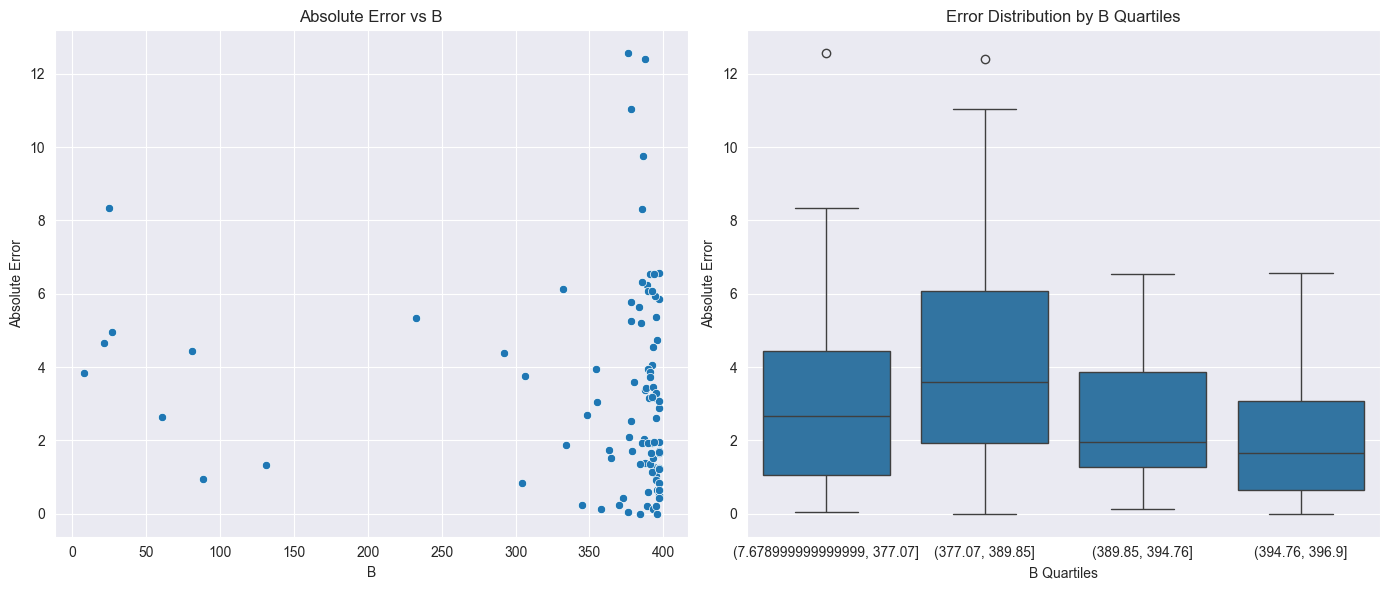

Evaluating: FairBoostRegressor_v3, Fold: 3, Fairness weight: 0.5


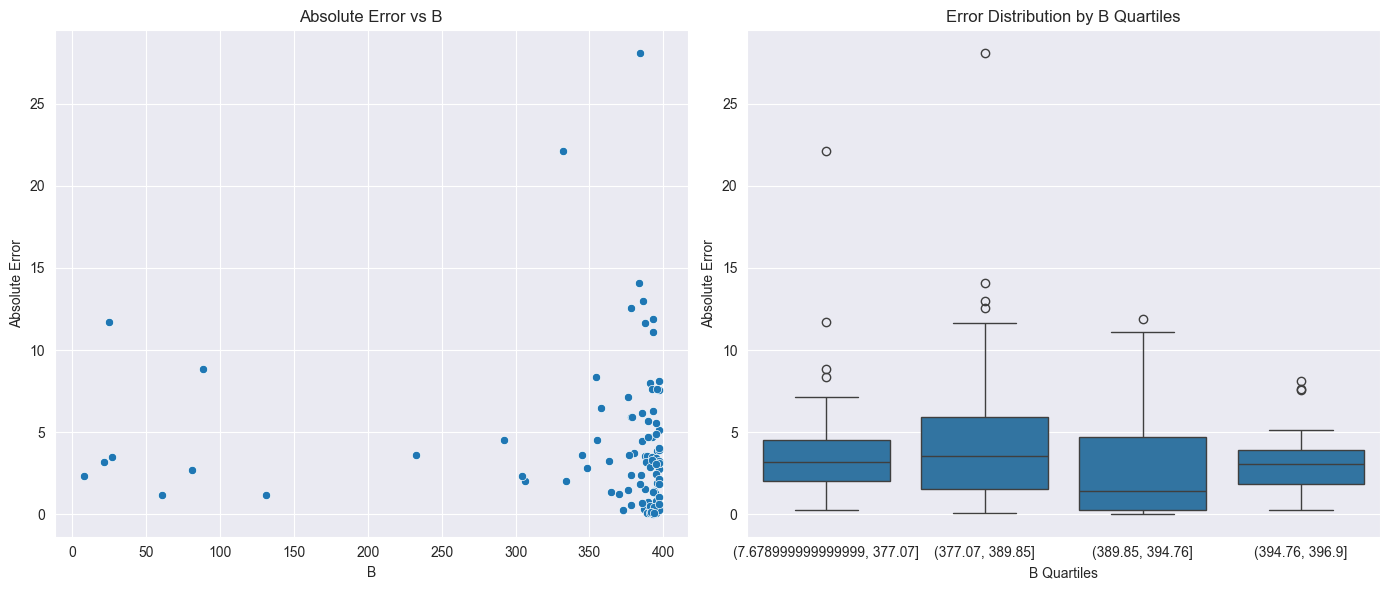

Evaluating: FairBoostRegressor_v3, Fold: 3, Fairness weight: 0.75


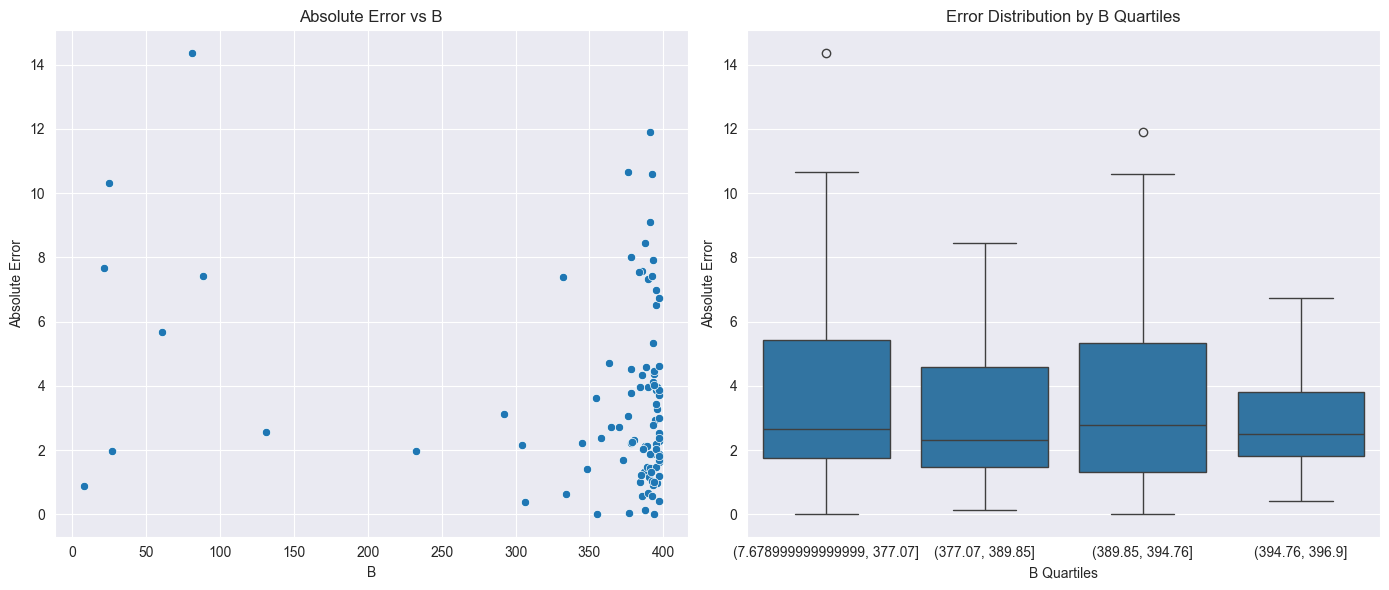

Evaluating: FairBoostRegressor_v1, Fold: 4, Fairness weight: 0.25


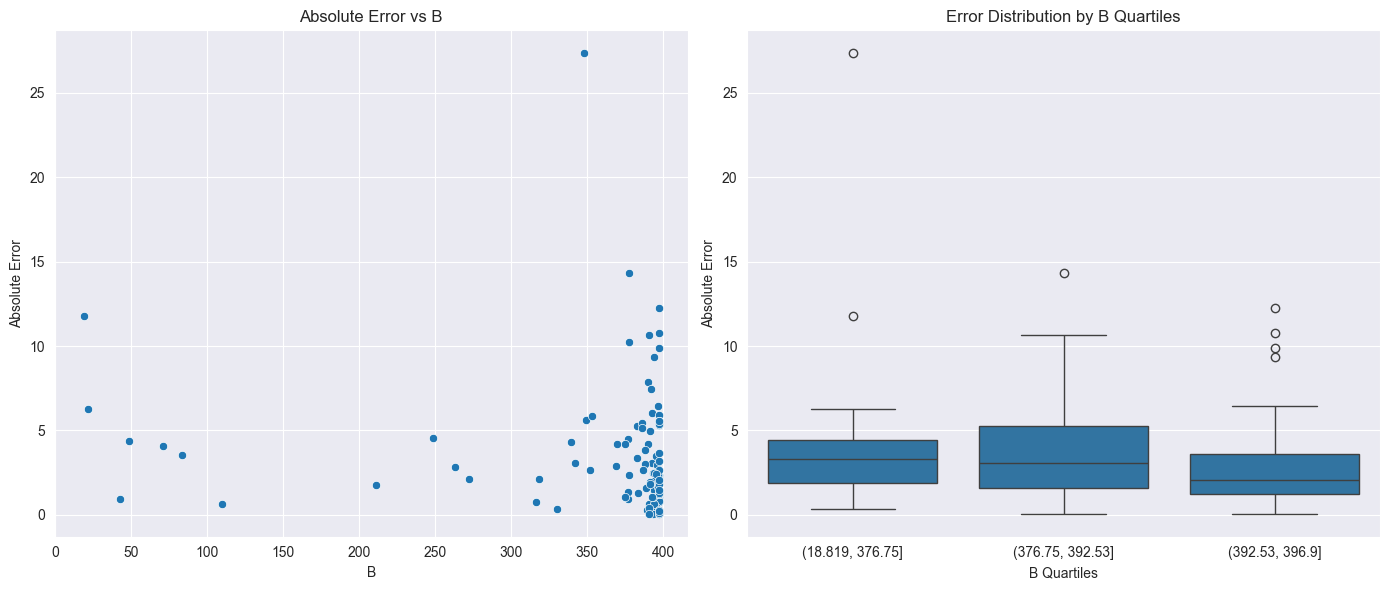

Evaluating: FairBoostRegressor_v1, Fold: 4, Fairness weight: 0.5


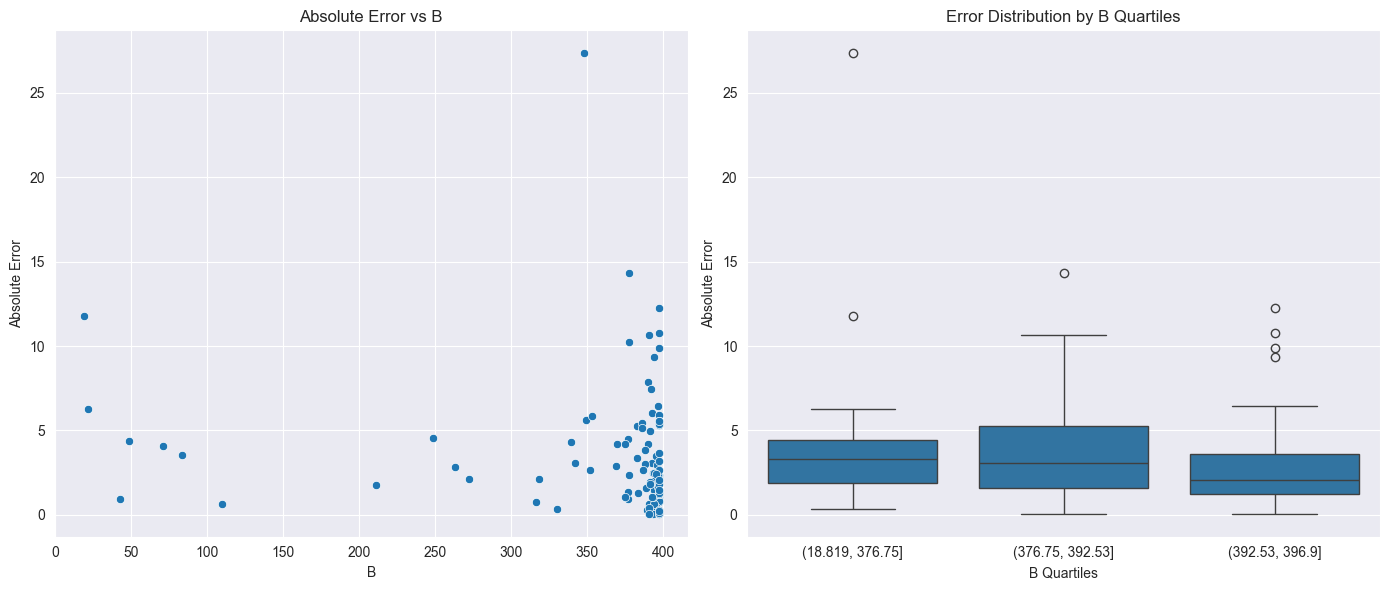

Evaluating: FairBoostRegressor_v1, Fold: 4, Fairness weight: 0.75


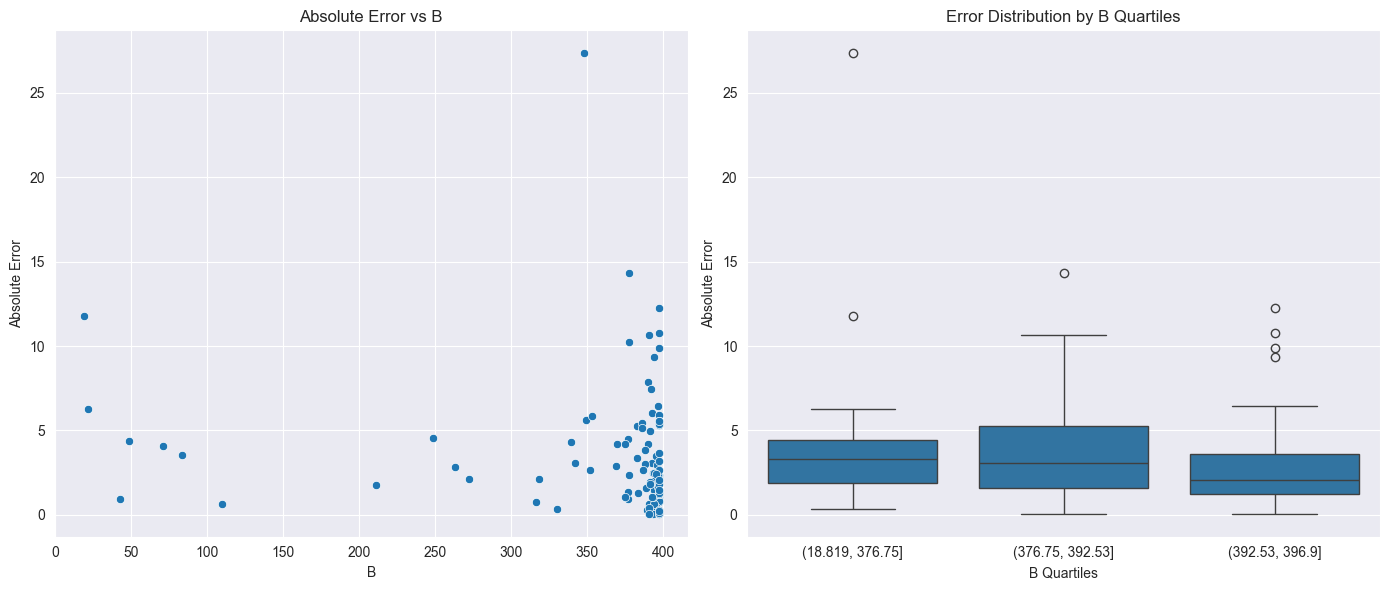

Evaluating: FairBoostRegressor_v1_Improved, Fold: 4, Fairness weight: 0.25


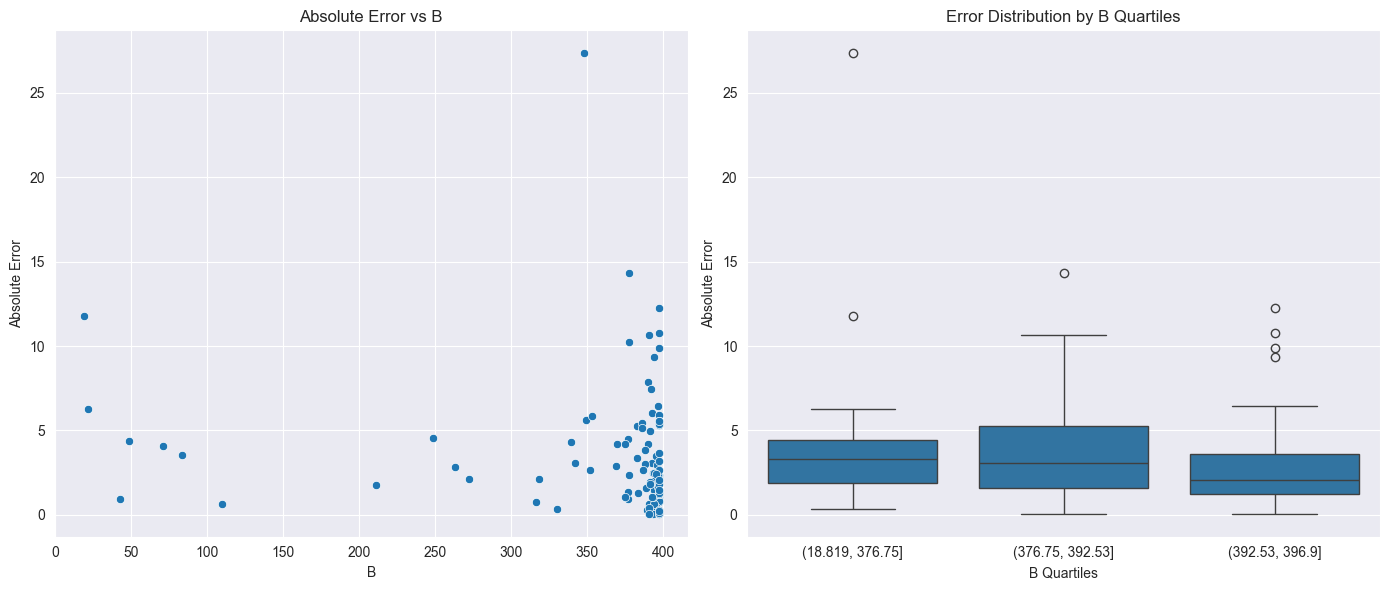

Evaluating: FairBoostRegressor_v1_Improved, Fold: 4, Fairness weight: 0.5


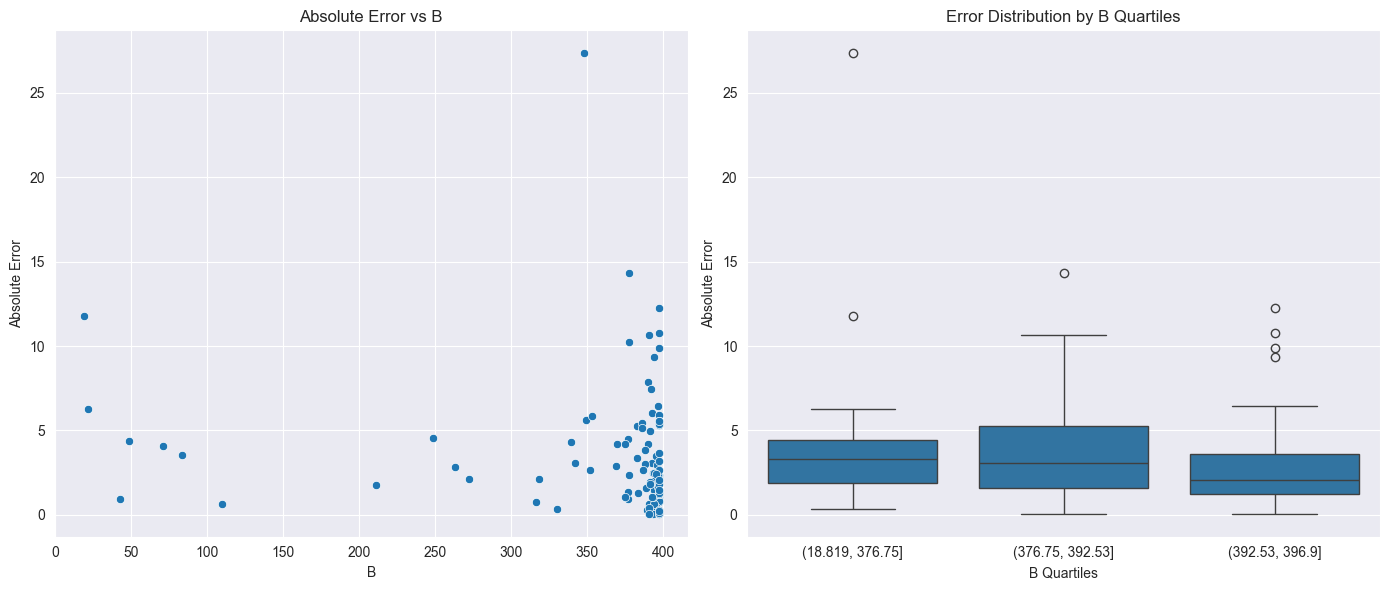

Evaluating: FairBoostRegressor_v1_Improved, Fold: 4, Fairness weight: 0.75


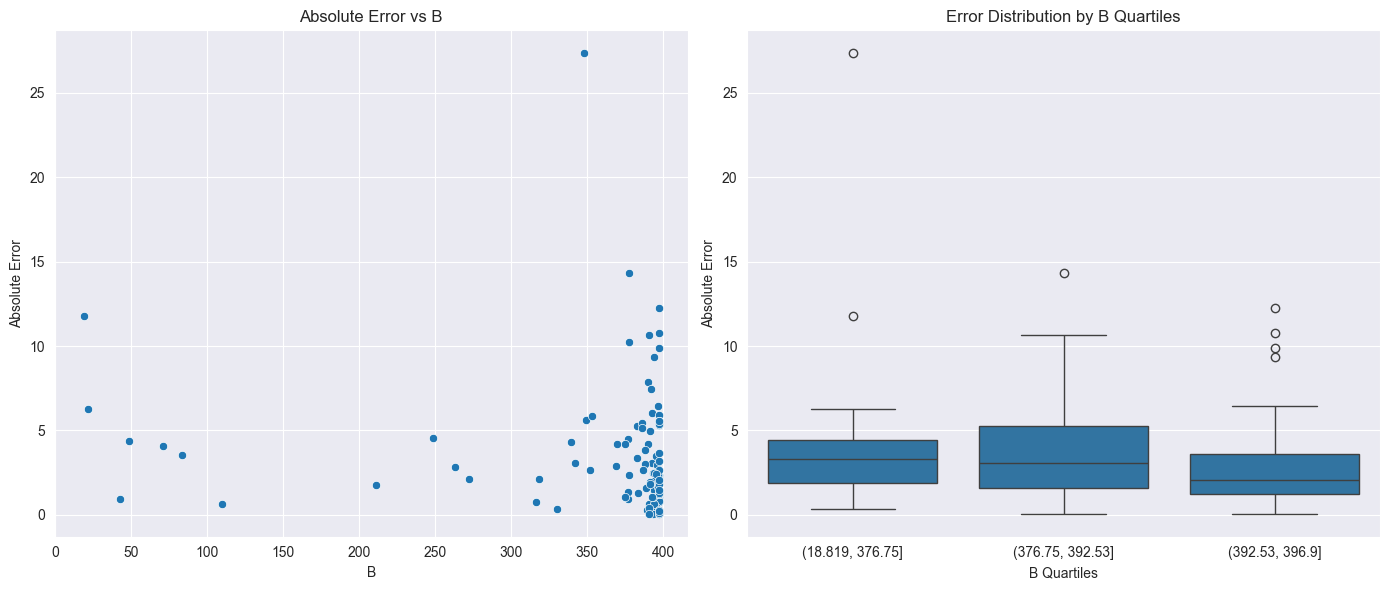

Evaluating: FairBoostRegressor_v2, Fold: 4, Fairness weight: 0.25


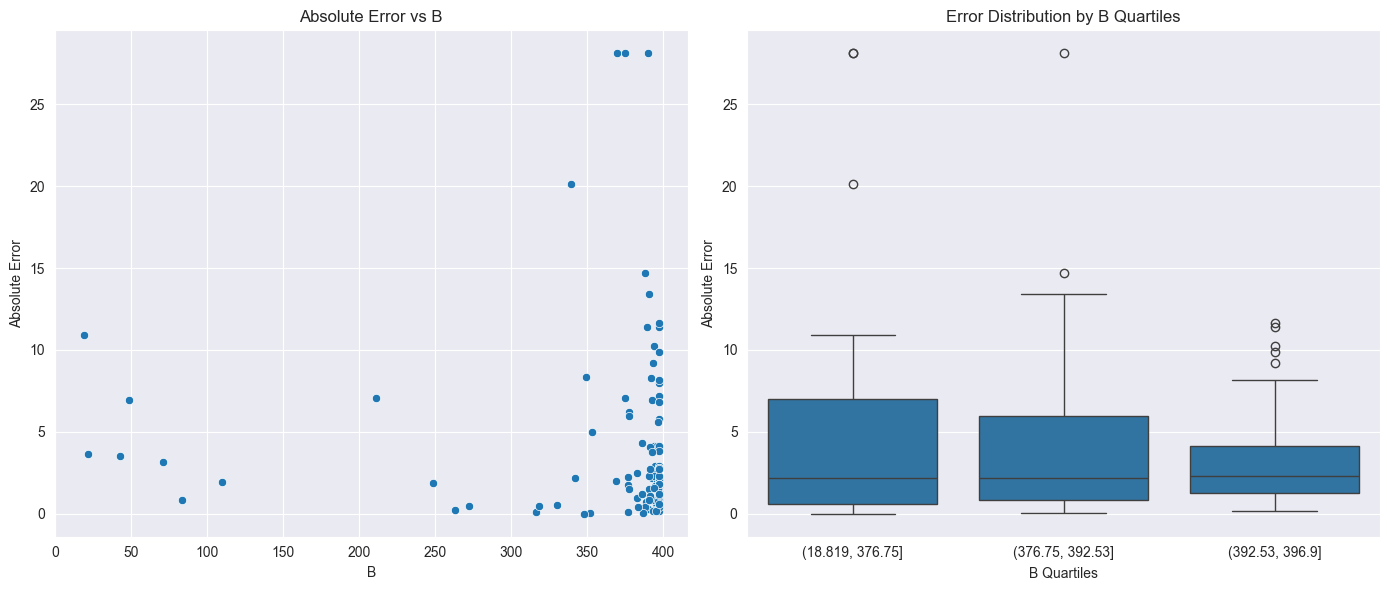

Evaluating: FairBoostRegressor_v2, Fold: 4, Fairness weight: 0.5


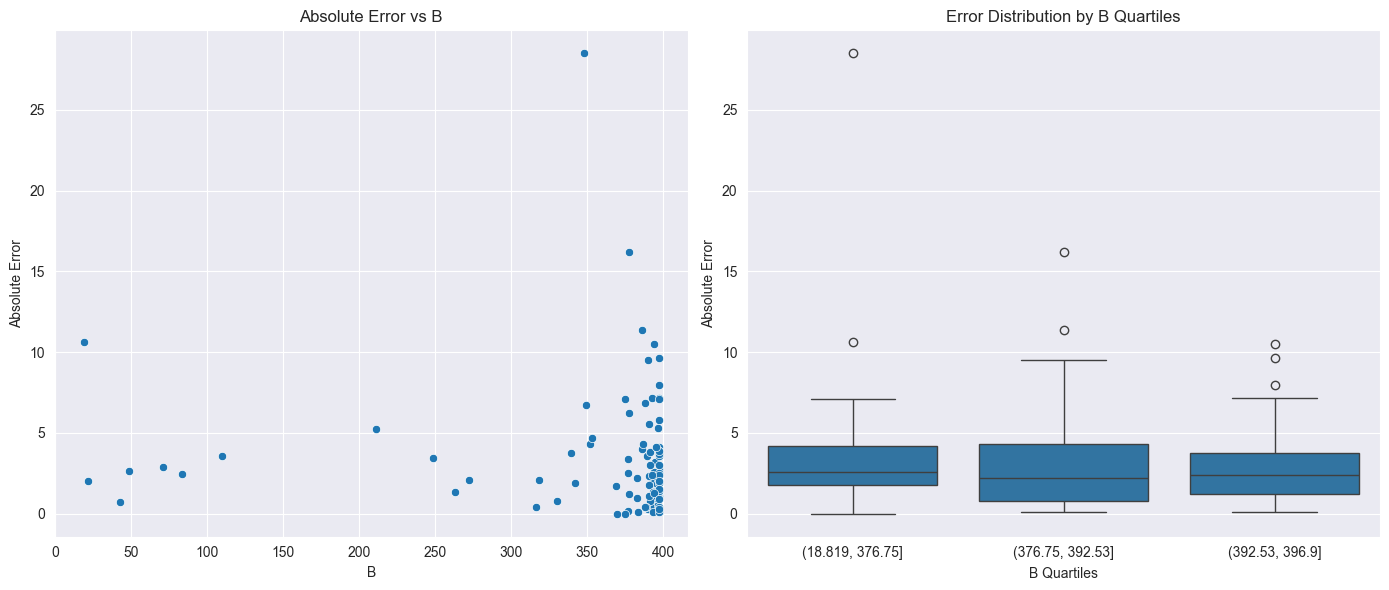

Evaluating: FairBoostRegressor_v2, Fold: 4, Fairness weight: 0.75


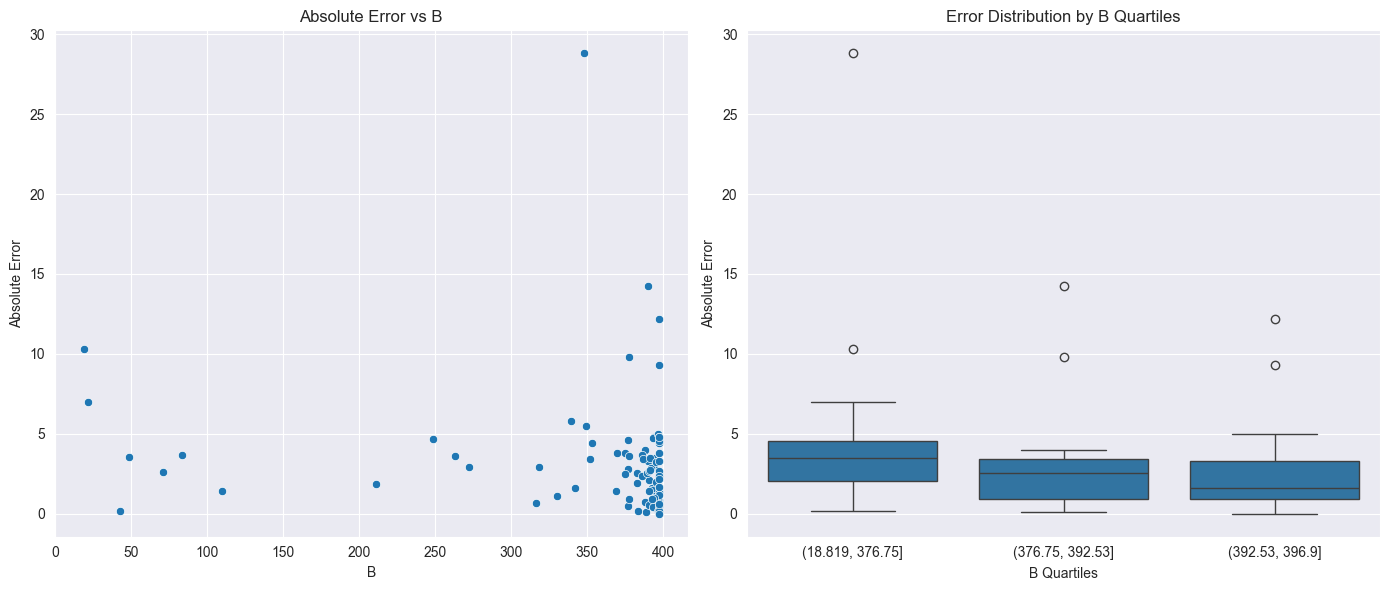

Evaluating: FairBoostRegressor_v2_Improved, Fold: 4, Fairness weight: 0.25


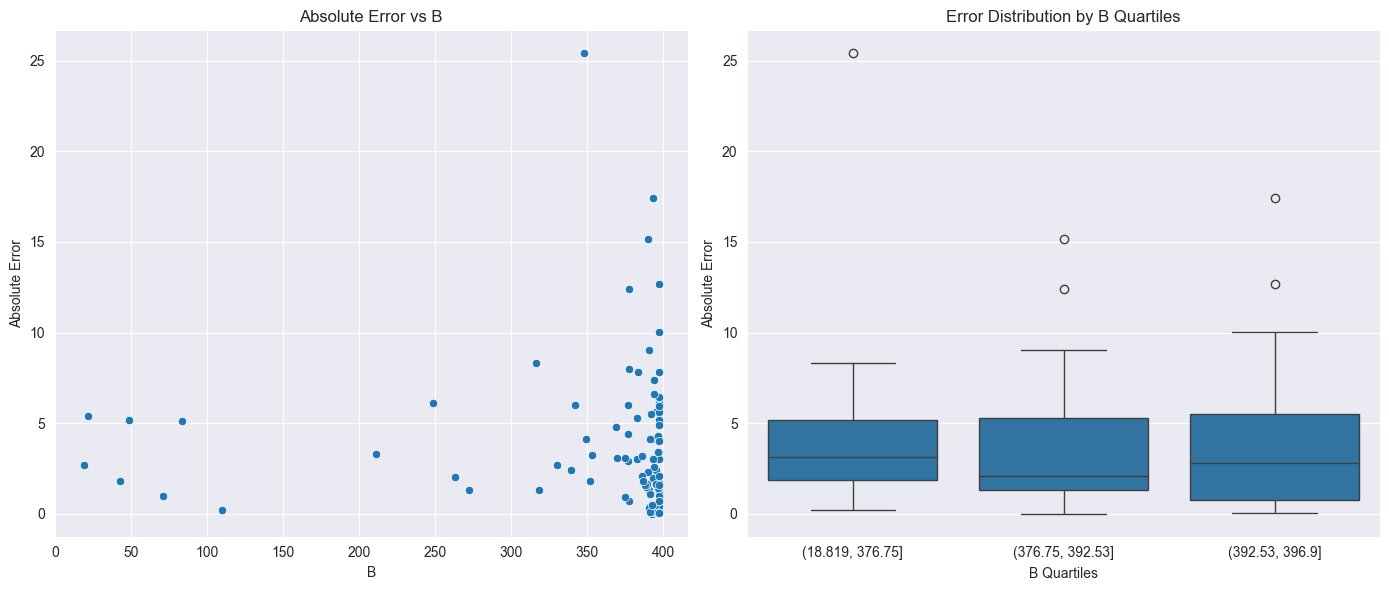

Evaluating: FairBoostRegressor_v2_Improved, Fold: 4, Fairness weight: 0.5


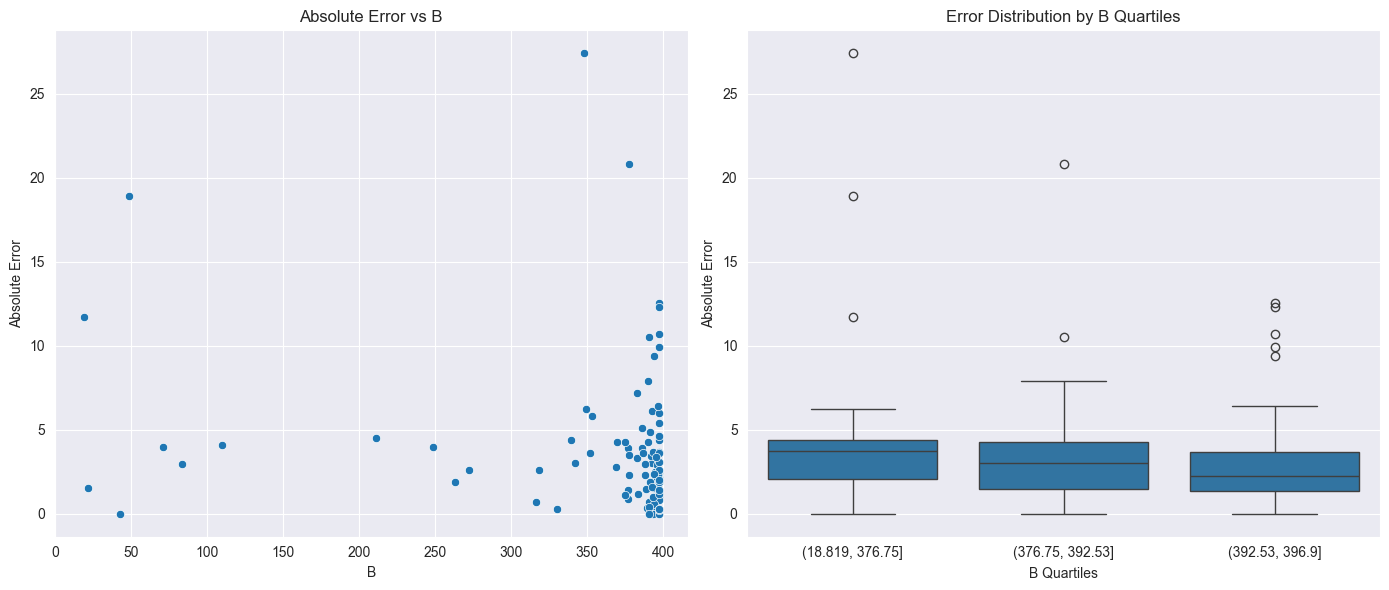

Evaluating: FairBoostRegressor_v2_Improved, Fold: 4, Fairness weight: 0.75


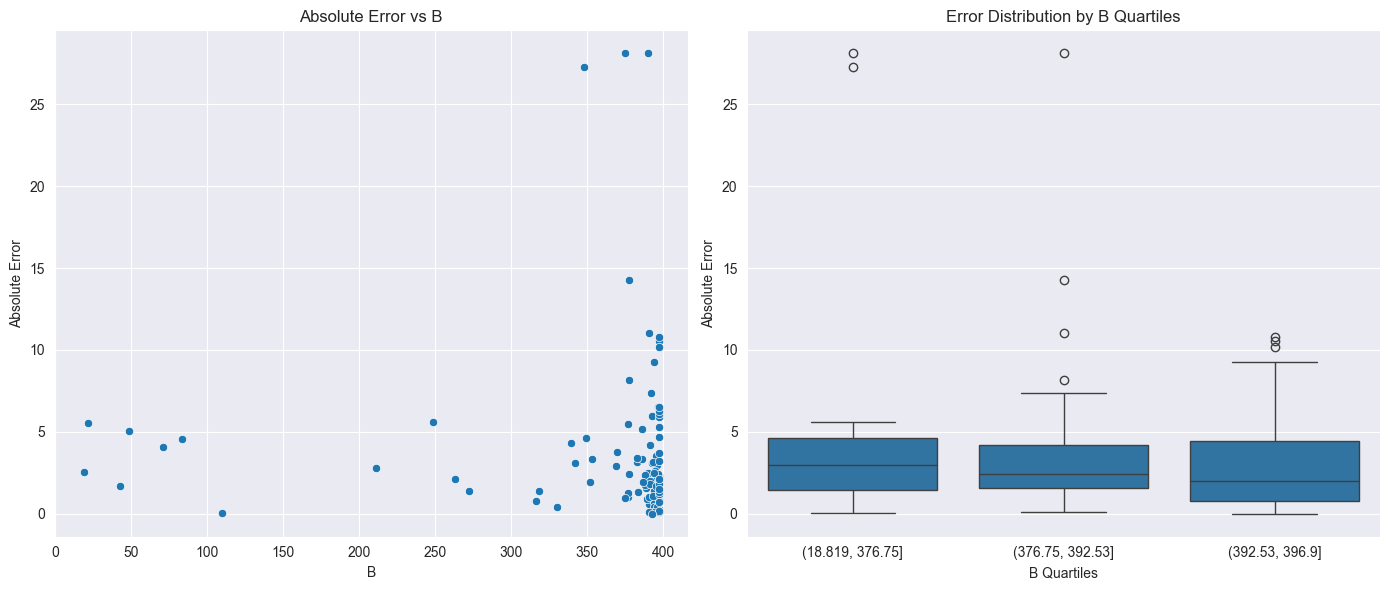

Evaluating: FairBoostRegressor_v3, Fold: 4, Fairness weight: 0.25


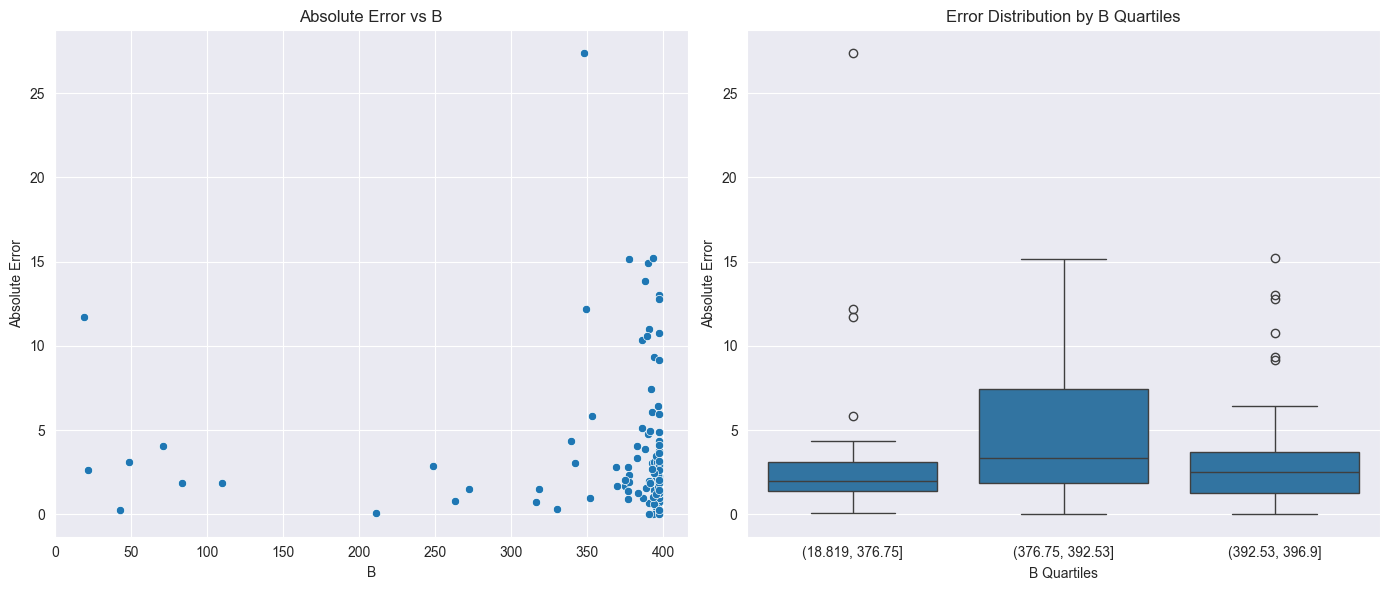

Evaluating: FairBoostRegressor_v3, Fold: 4, Fairness weight: 0.5


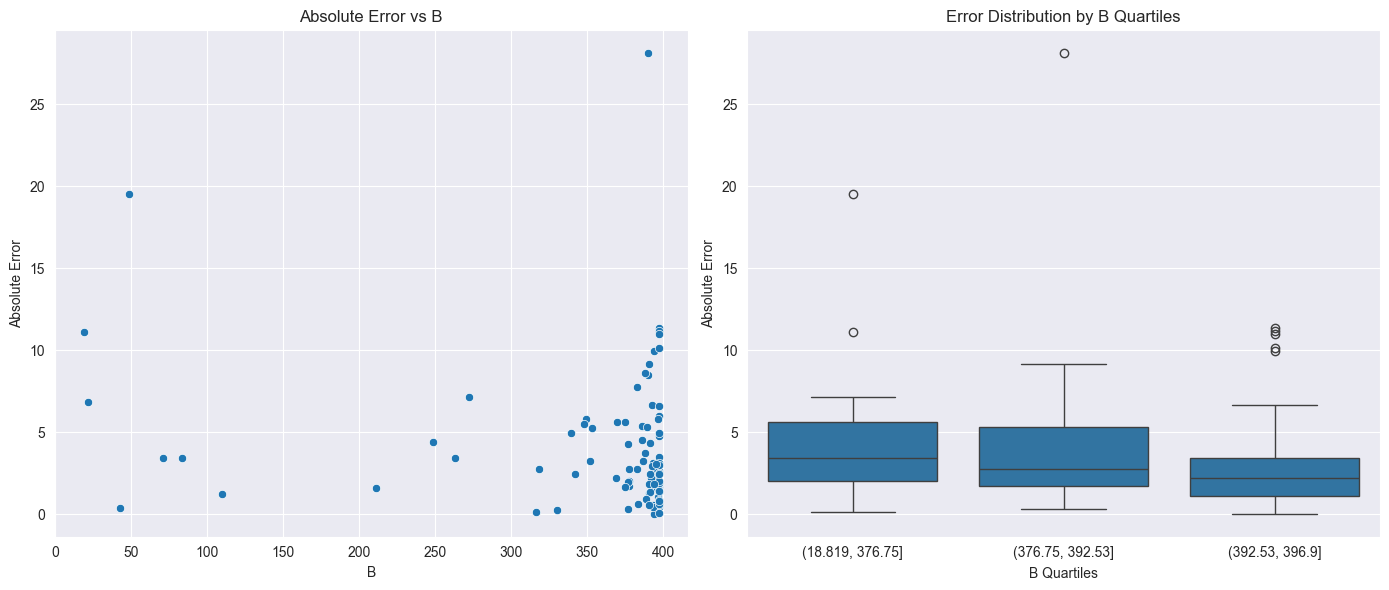

Evaluating: FairBoostRegressor_v3, Fold: 4, Fairness weight: 0.75


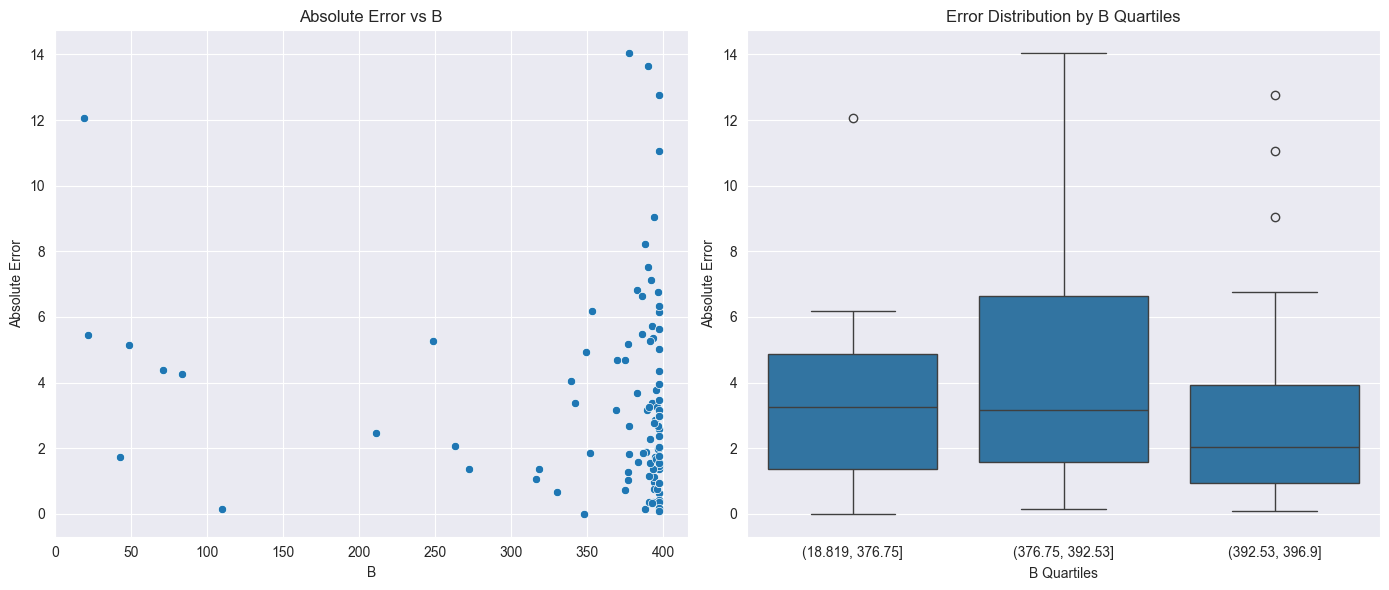

Processing dataset with protected feature: LSTAT
Evaluating: FairBoostRegressor_v1, Fold: 0, Fairness weight: 0.25


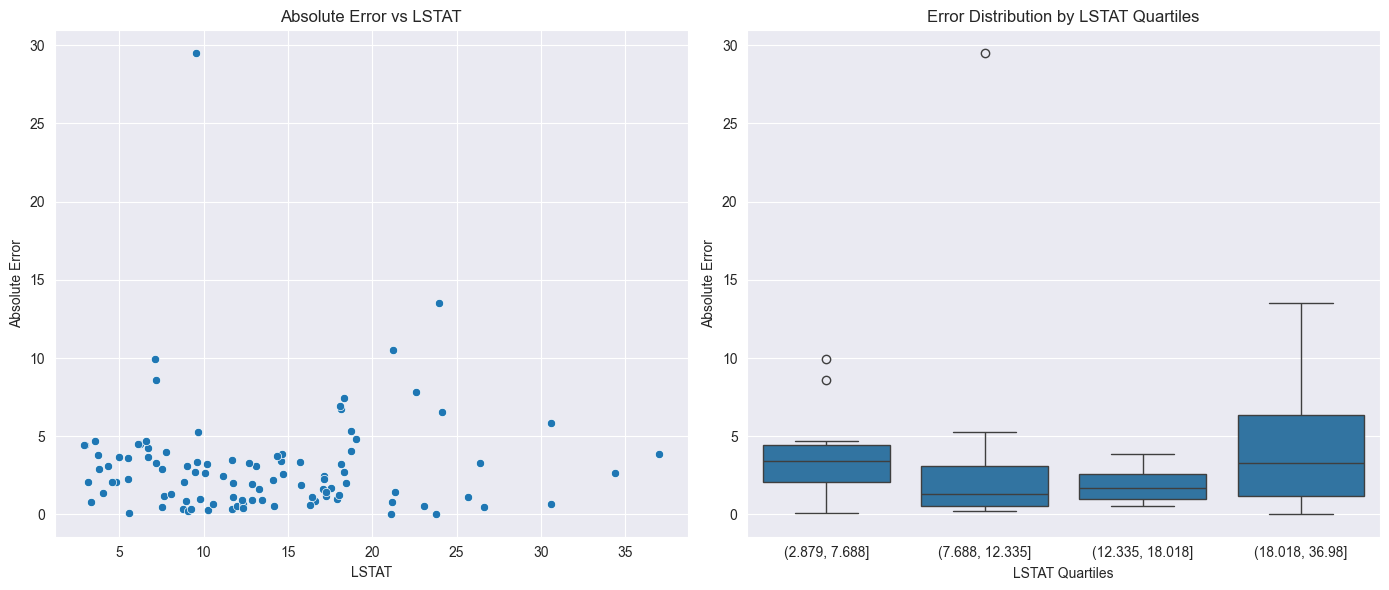

Evaluating: FairBoostRegressor_v1, Fold: 0, Fairness weight: 0.5


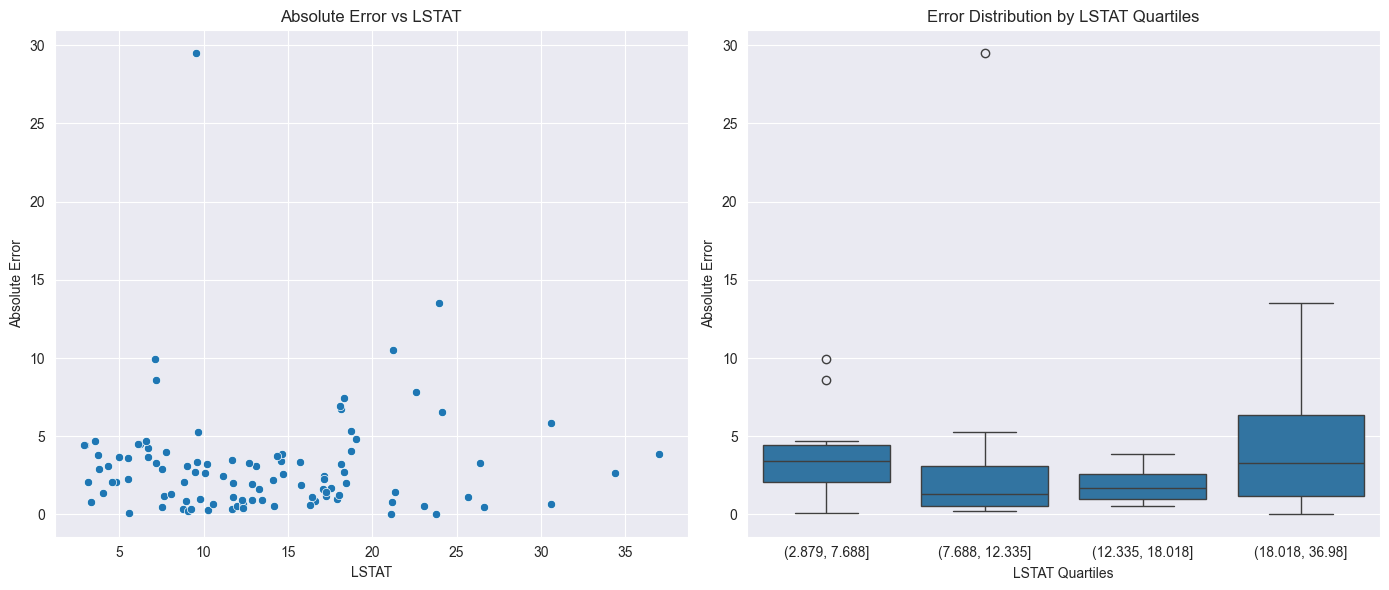

Evaluating: FairBoostRegressor_v1, Fold: 0, Fairness weight: 0.75


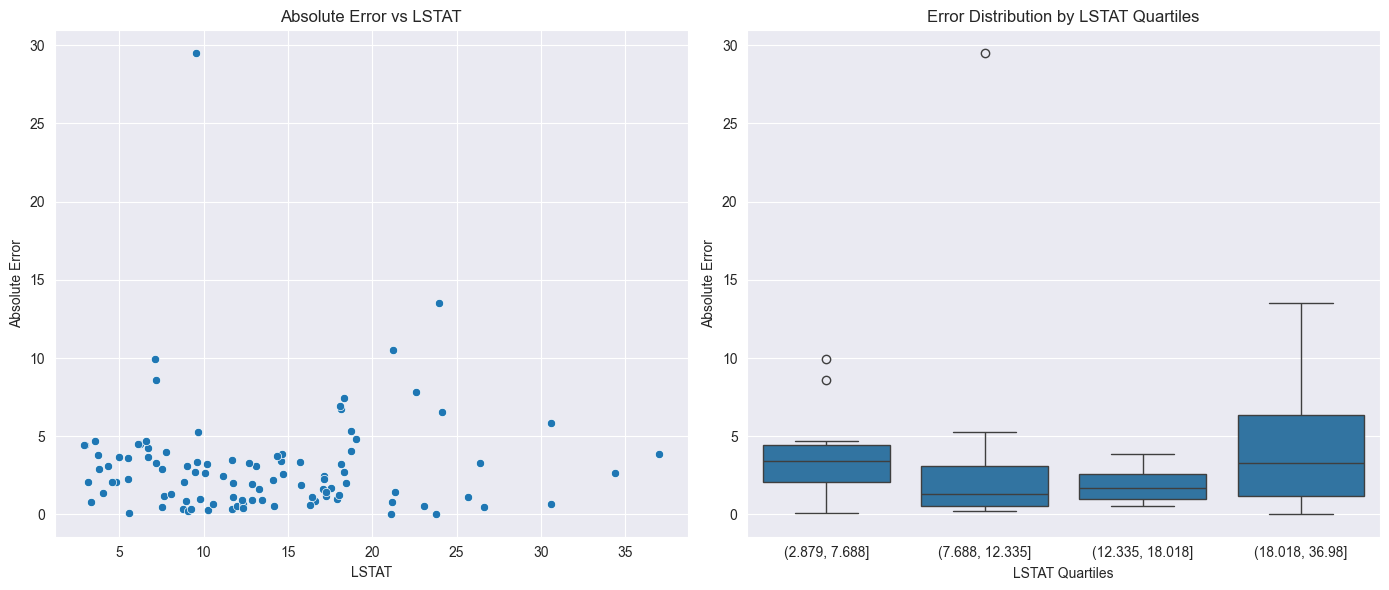

Evaluating: FairBoostRegressor_v1_Improved, Fold: 0, Fairness weight: 0.25


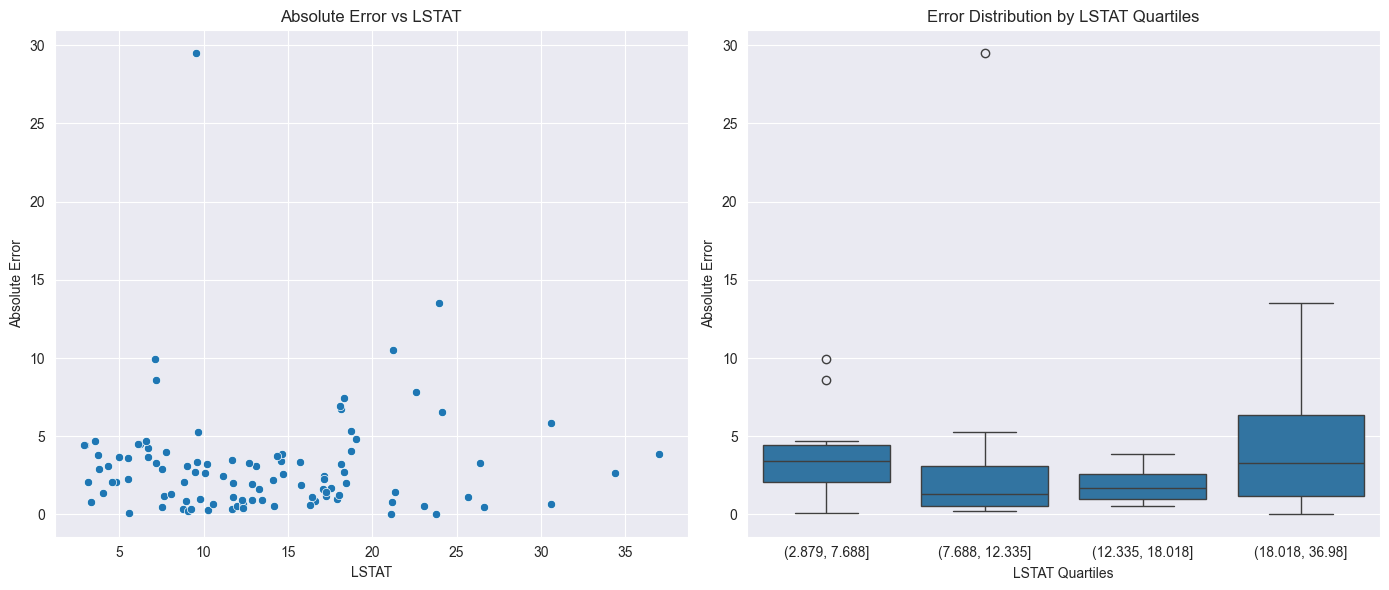

Evaluating: FairBoostRegressor_v1_Improved, Fold: 0, Fairness weight: 0.5


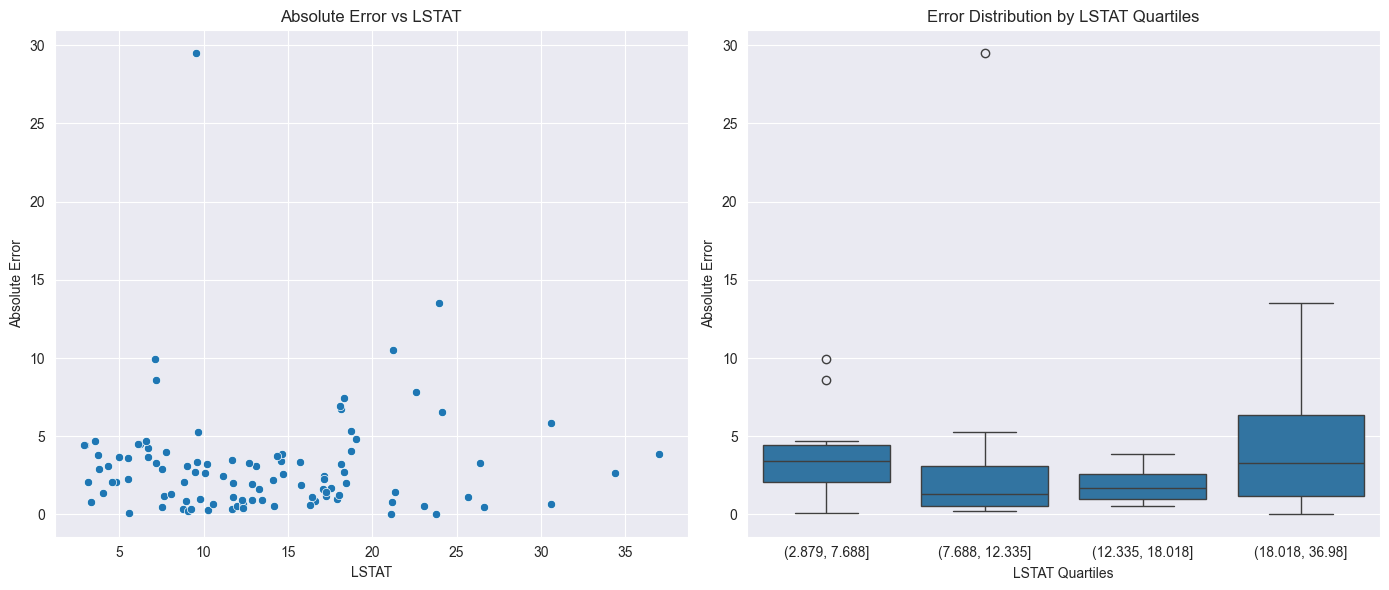

Evaluating: FairBoostRegressor_v1_Improved, Fold: 0, Fairness weight: 0.75


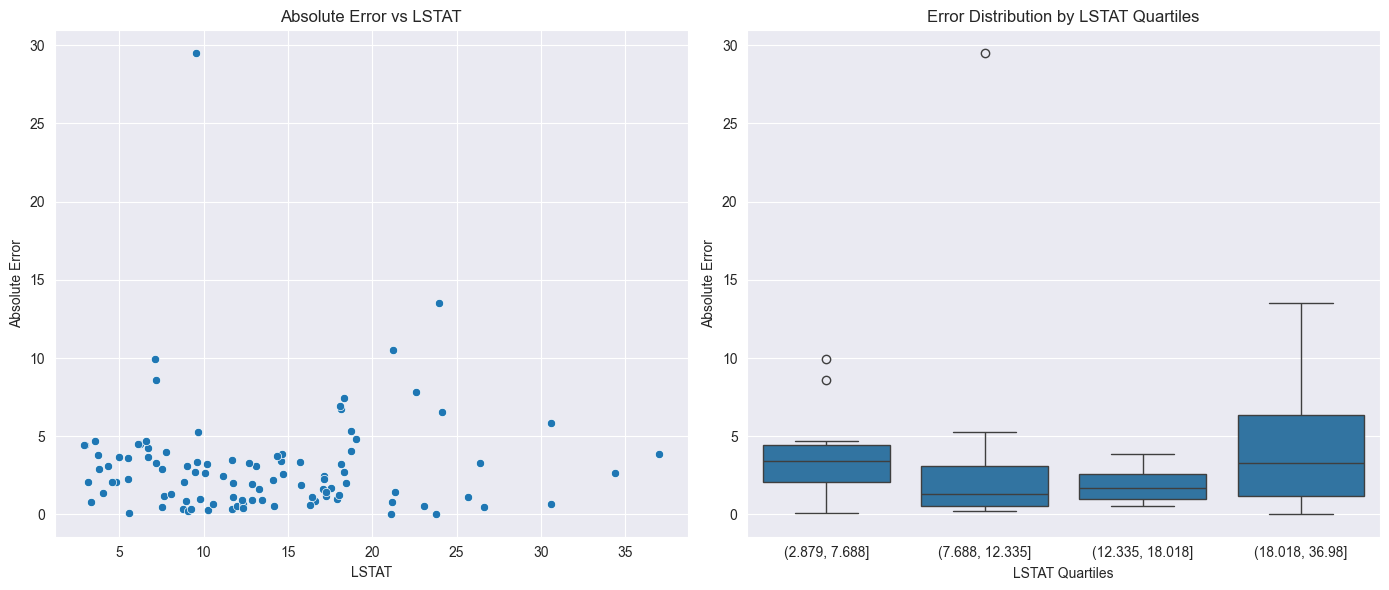

Evaluating: FairBoostRegressor_v2, Fold: 0, Fairness weight: 0.25


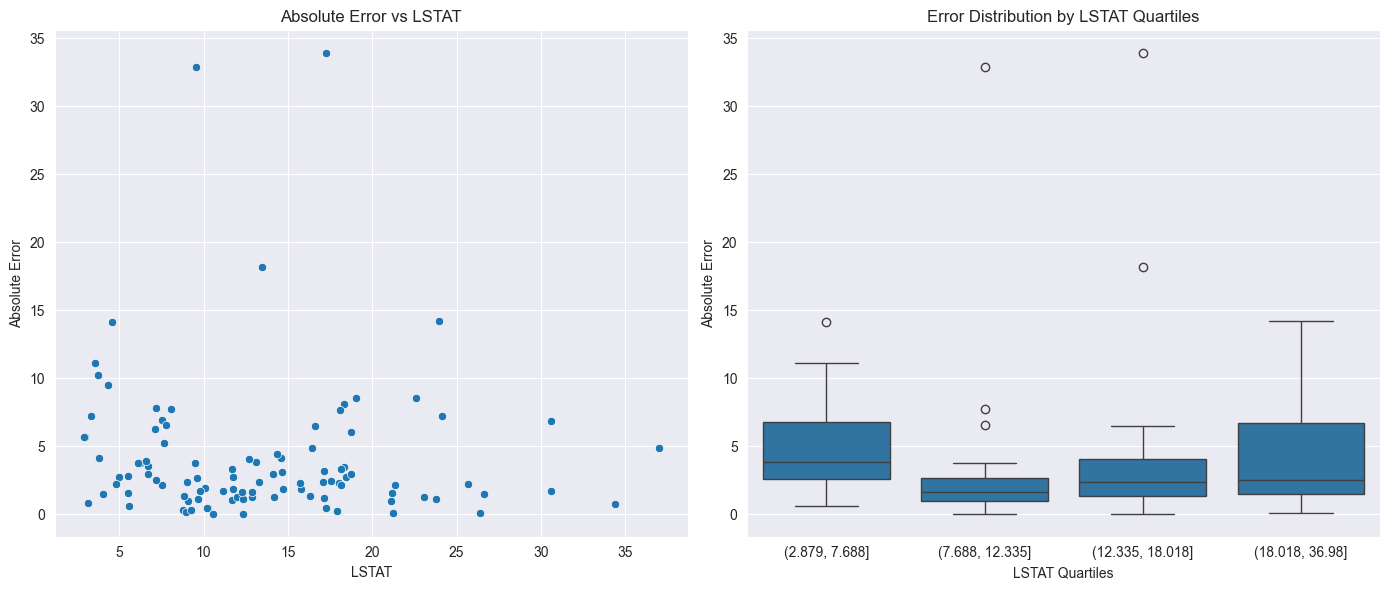

Evaluating: FairBoostRegressor_v2, Fold: 0, Fairness weight: 0.5


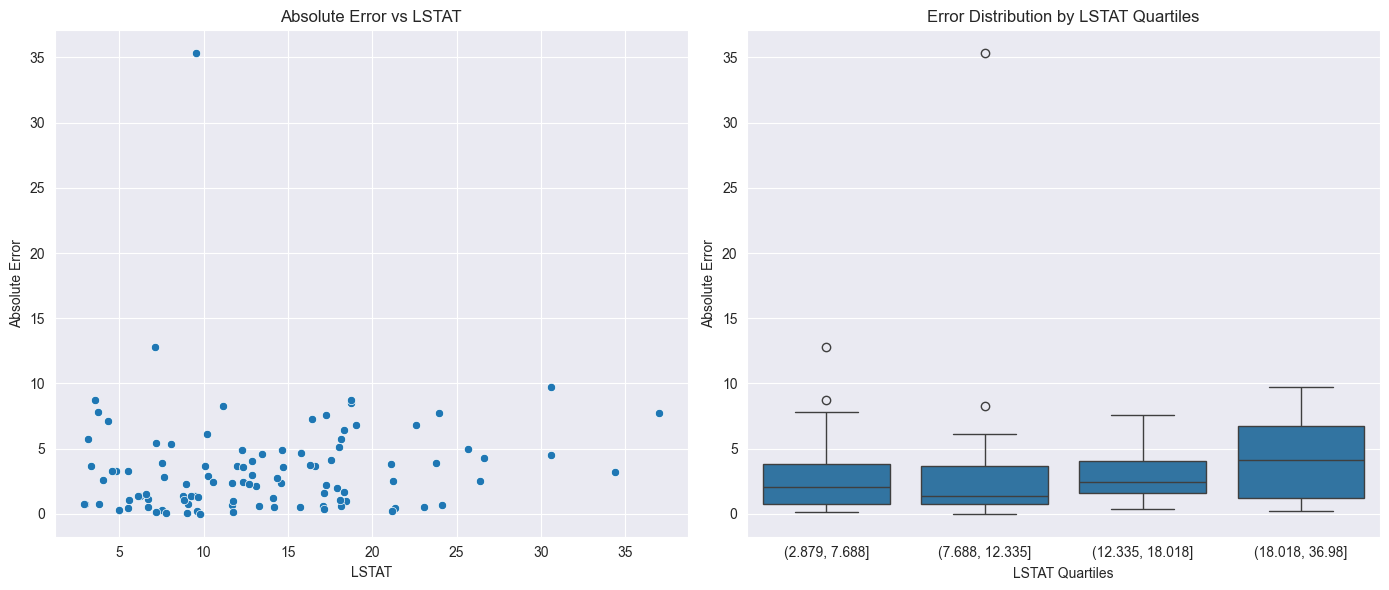

Evaluating: FairBoostRegressor_v2, Fold: 0, Fairness weight: 0.75


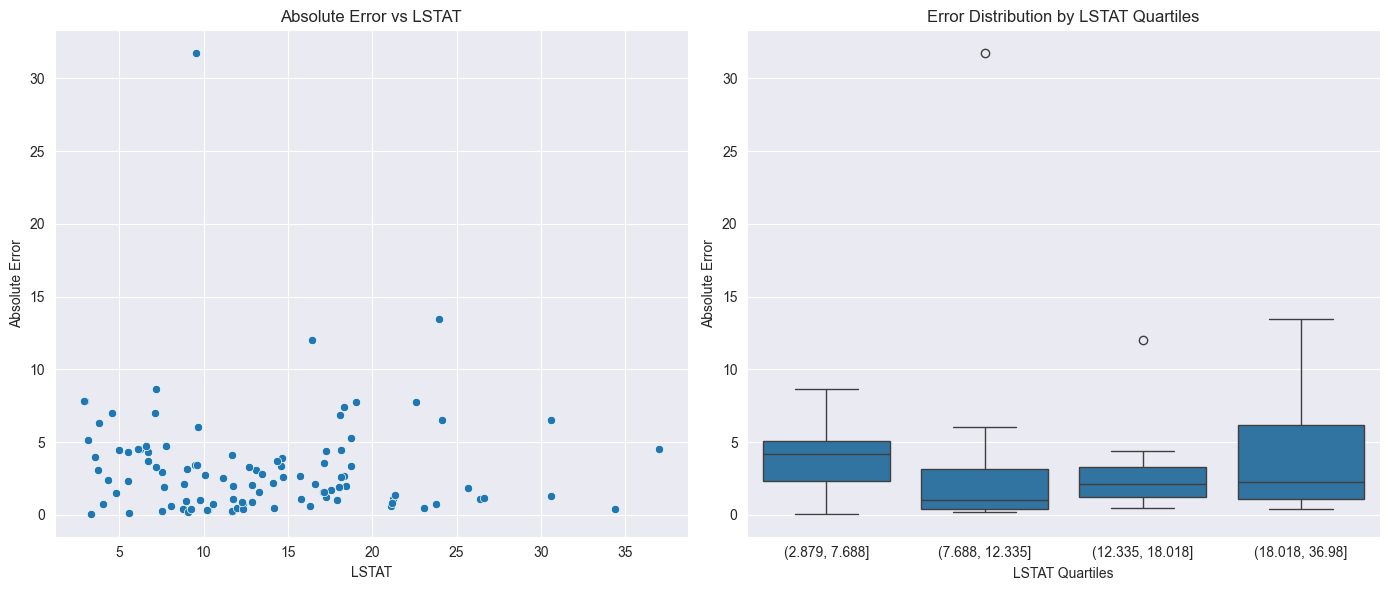

Evaluating: FairBoostRegressor_v2_Improved, Fold: 0, Fairness weight: 0.25


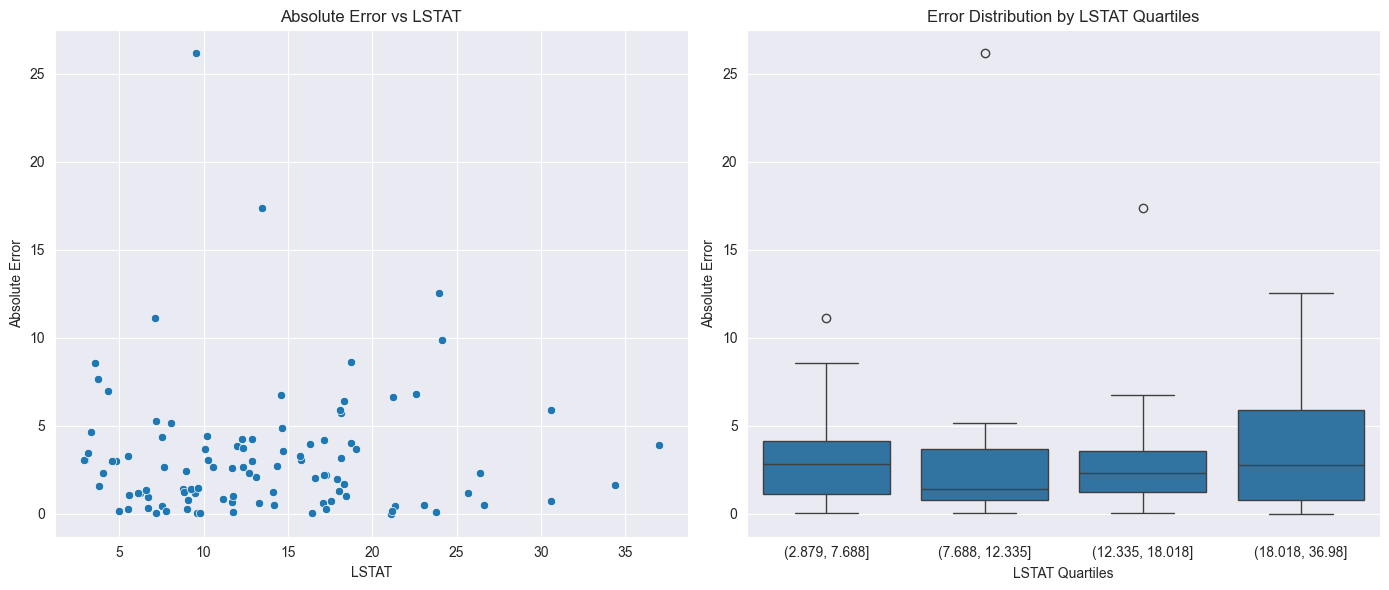

Evaluating: FairBoostRegressor_v2_Improved, Fold: 0, Fairness weight: 0.5


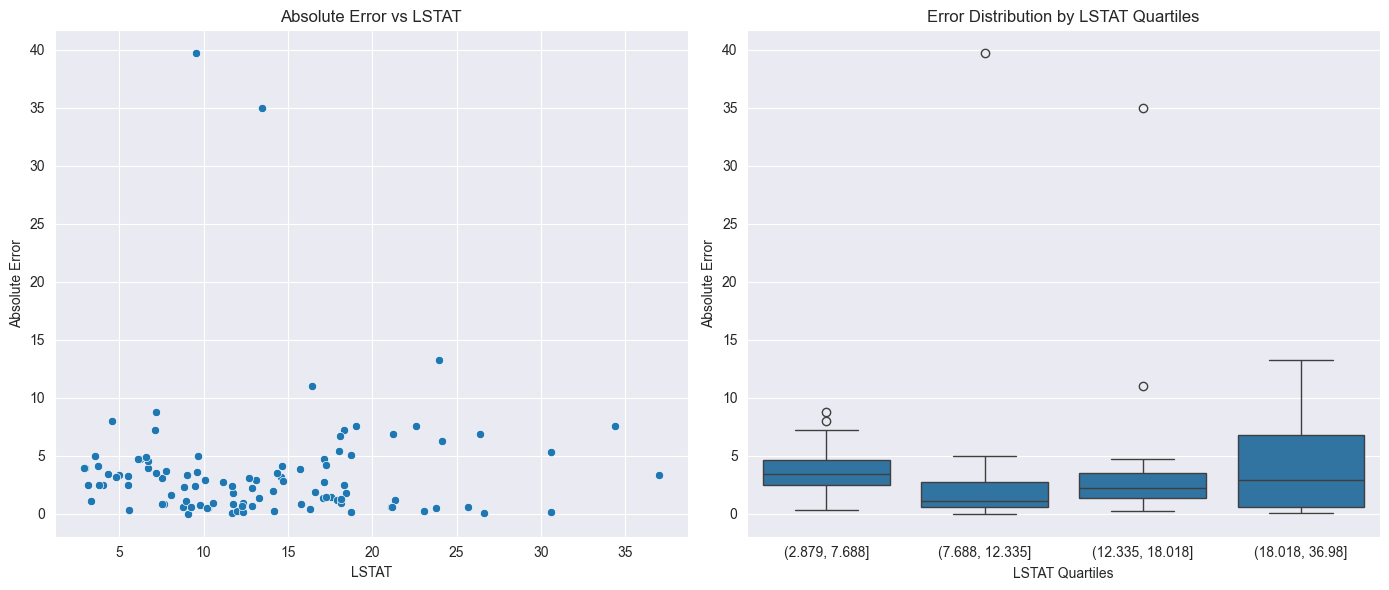

Evaluating: FairBoostRegressor_v2_Improved, Fold: 0, Fairness weight: 0.75


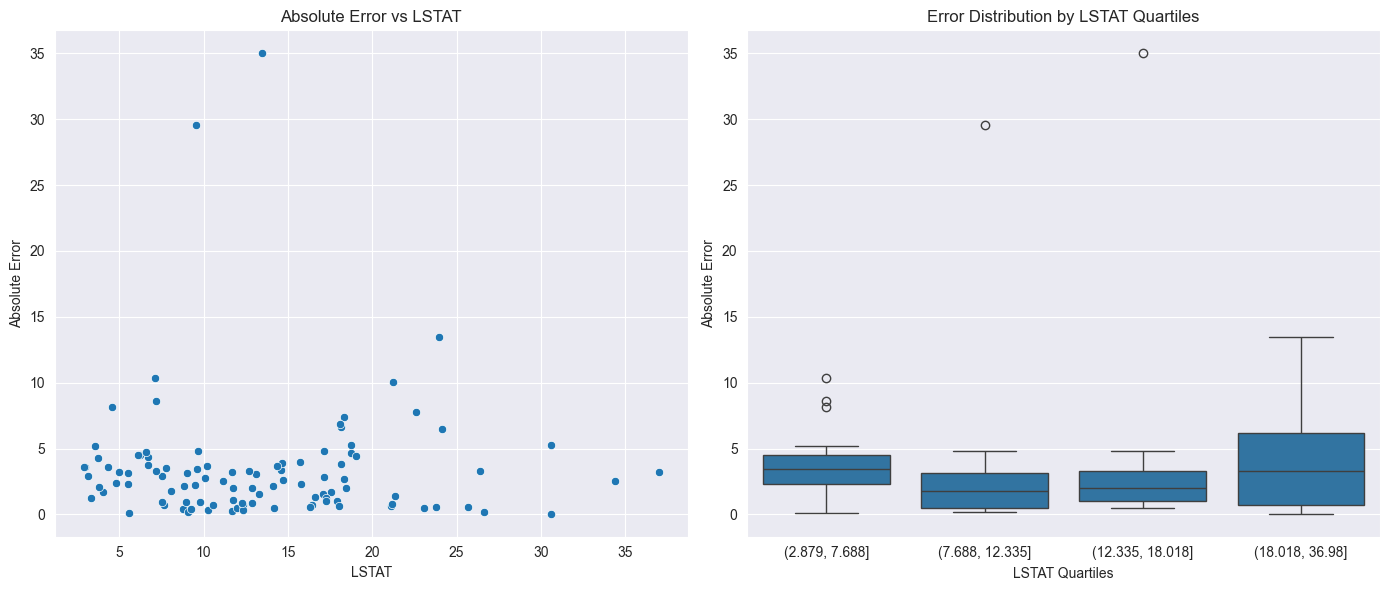

Evaluating: FairBoostRegressor_v3, Fold: 0, Fairness weight: 0.25


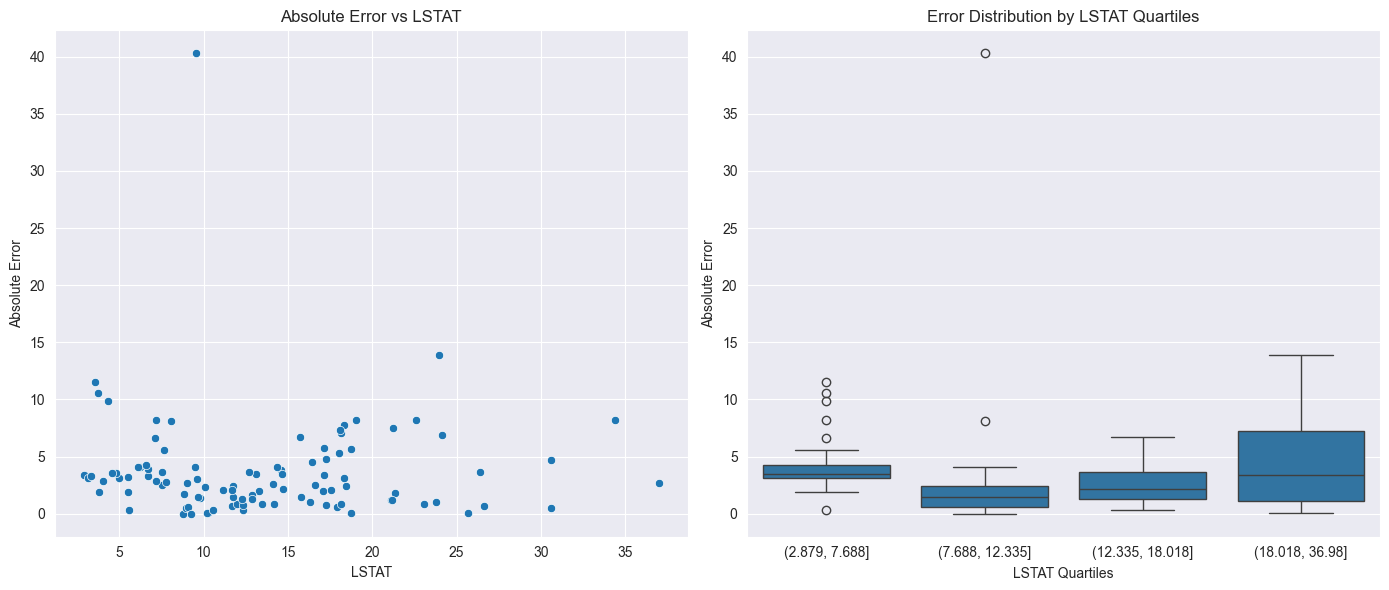

Evaluating: FairBoostRegressor_v3, Fold: 0, Fairness weight: 0.5


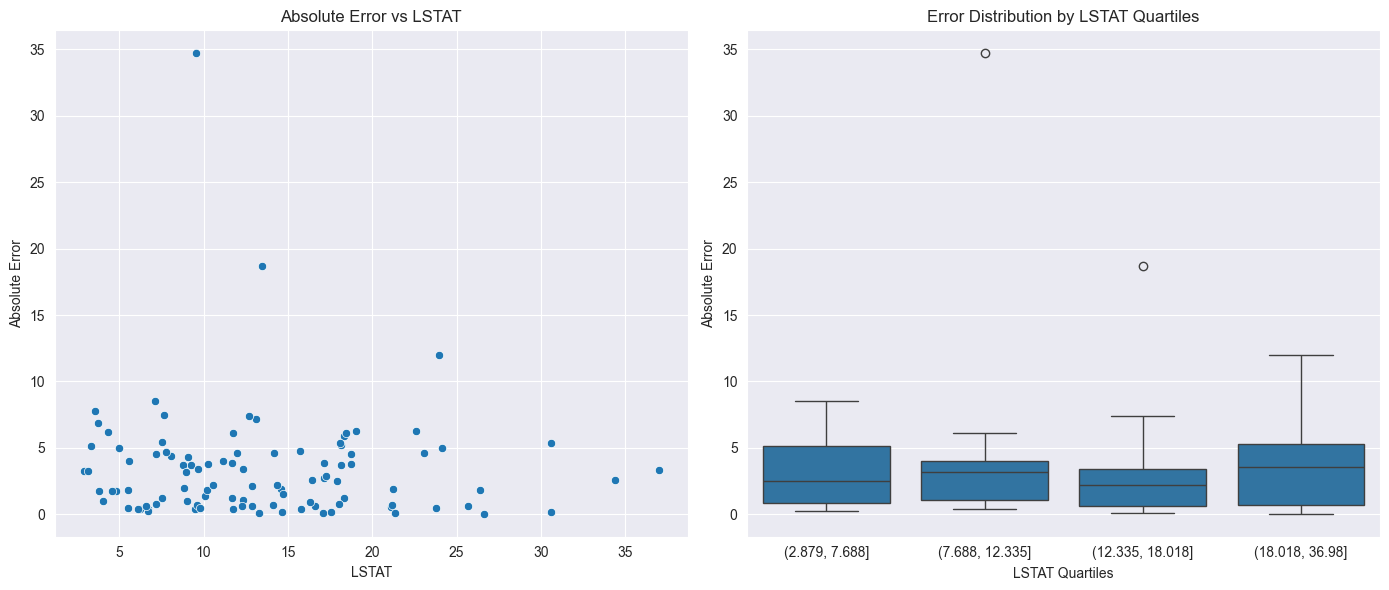

Evaluating: FairBoostRegressor_v3, Fold: 0, Fairness weight: 0.75


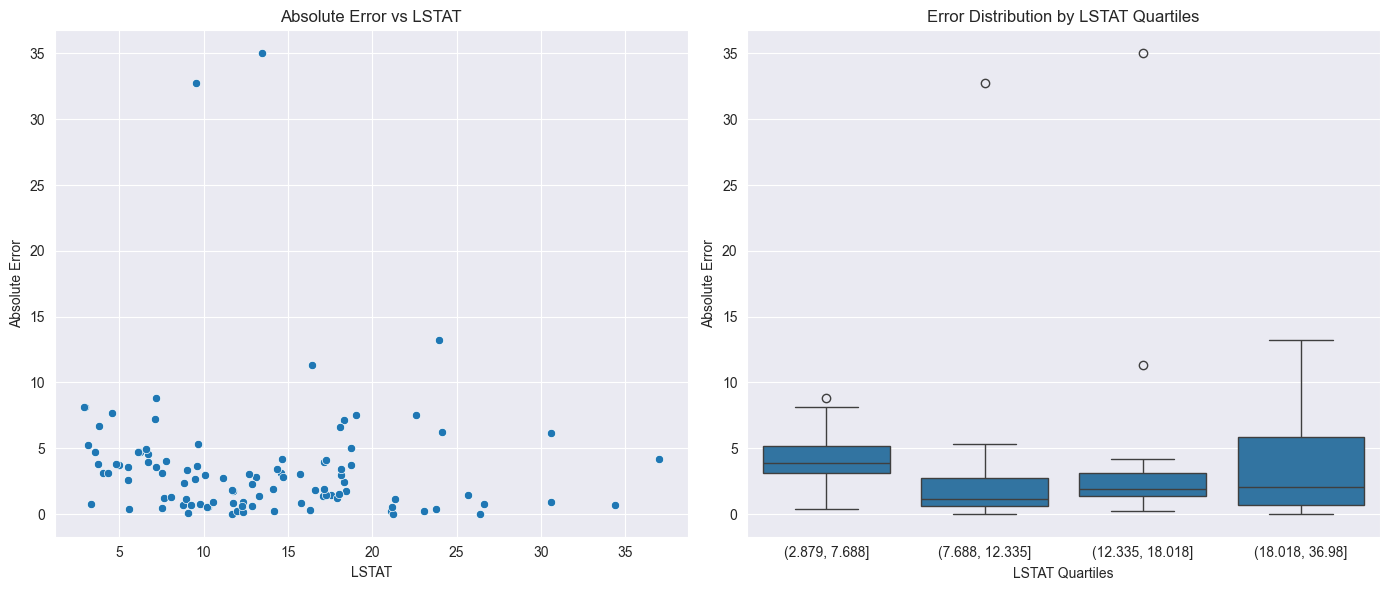

Evaluating: FairBoostRegressor_v1, Fold: 1, Fairness weight: 0.25


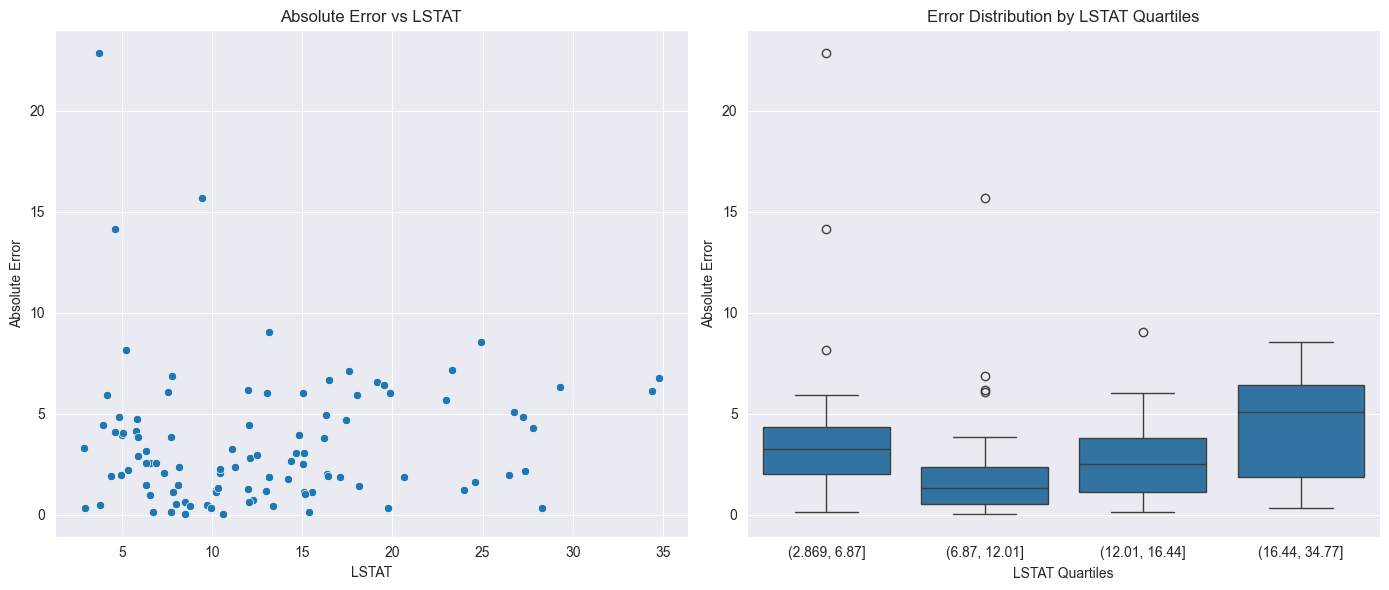

Evaluating: FairBoostRegressor_v1, Fold: 1, Fairness weight: 0.5


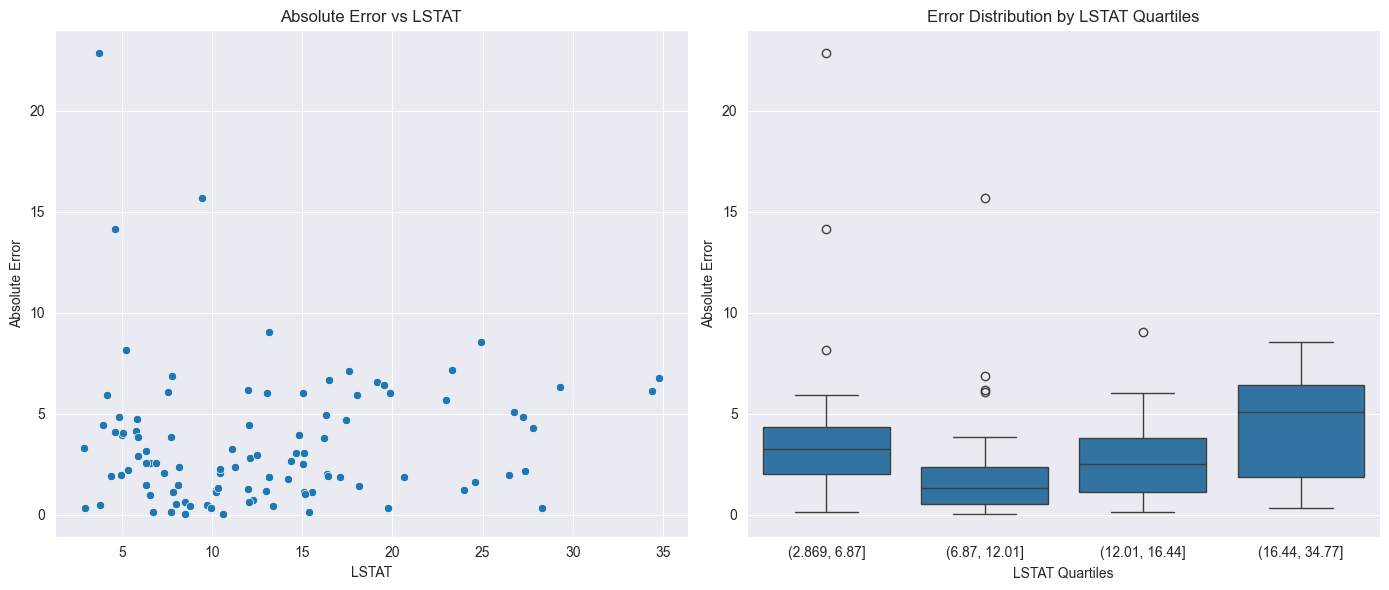

Evaluating: FairBoostRegressor_v1, Fold: 1, Fairness weight: 0.75


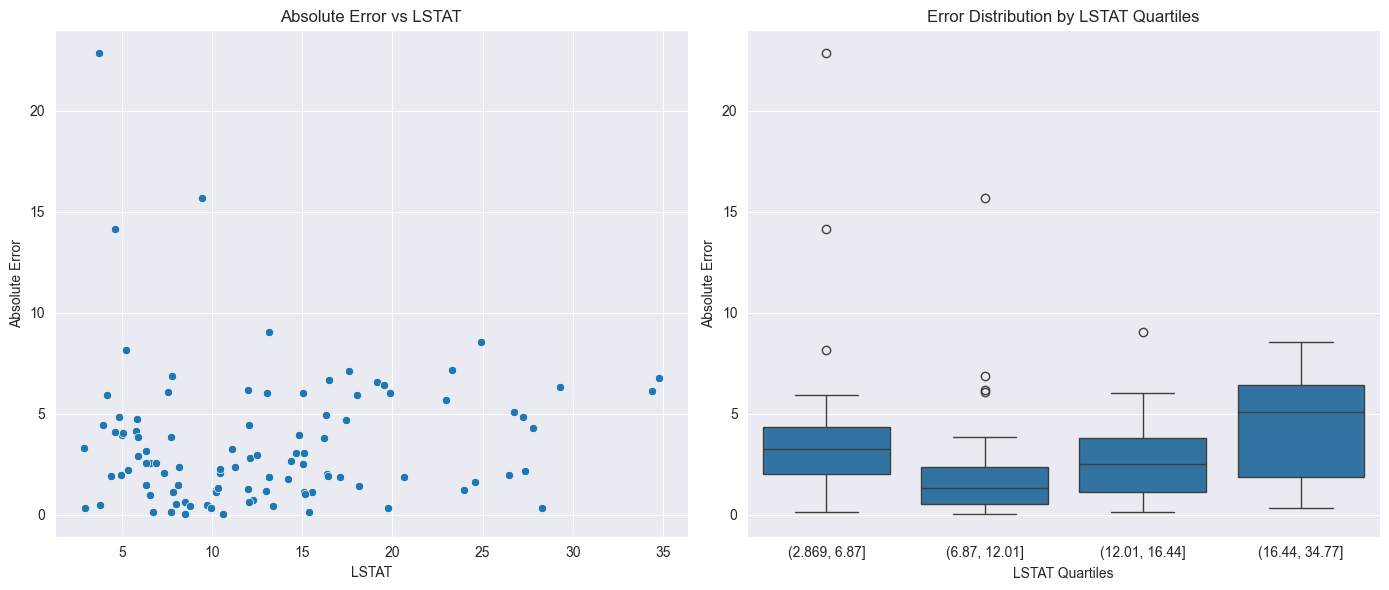

Evaluating: FairBoostRegressor_v1_Improved, Fold: 1, Fairness weight: 0.25


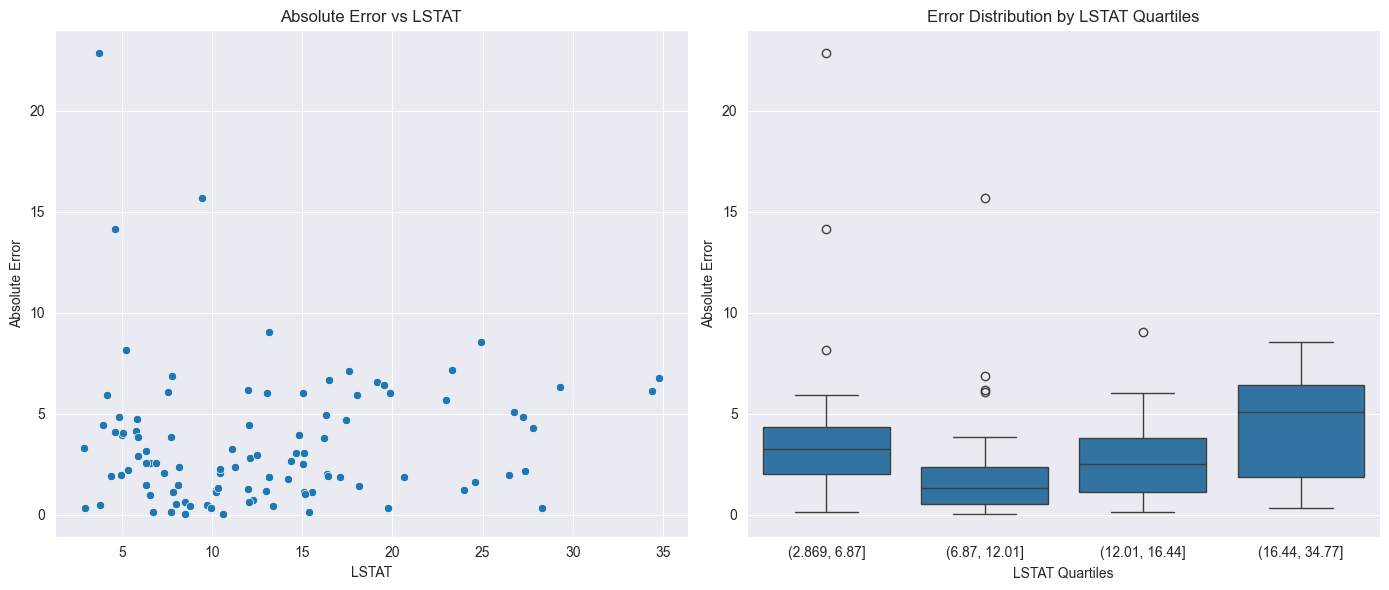

Evaluating: FairBoostRegressor_v1_Improved, Fold: 1, Fairness weight: 0.5


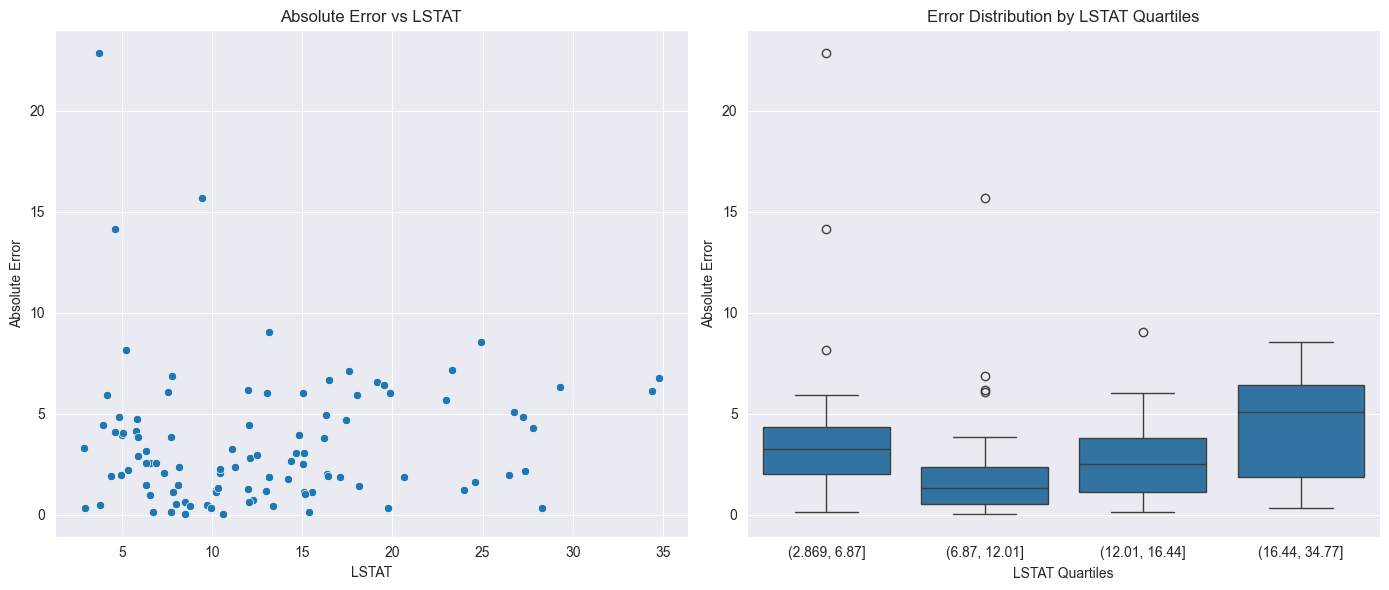

Evaluating: FairBoostRegressor_v1_Improved, Fold: 1, Fairness weight: 0.75


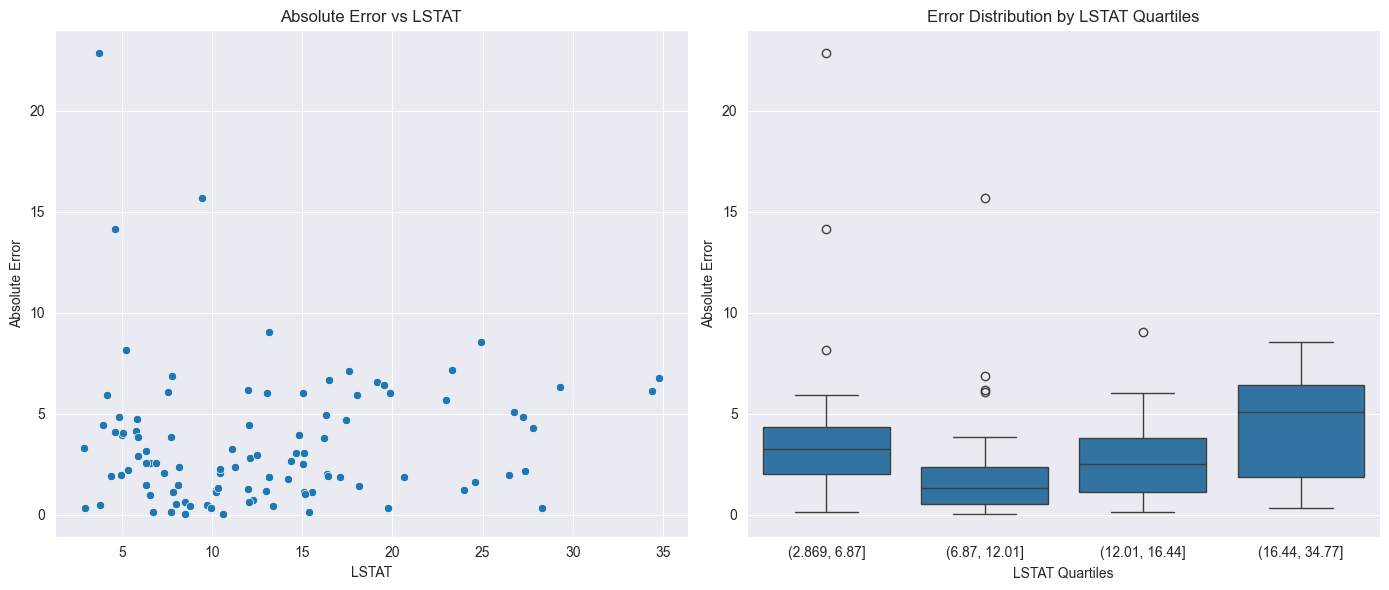

Evaluating: FairBoostRegressor_v2, Fold: 1, Fairness weight: 0.25


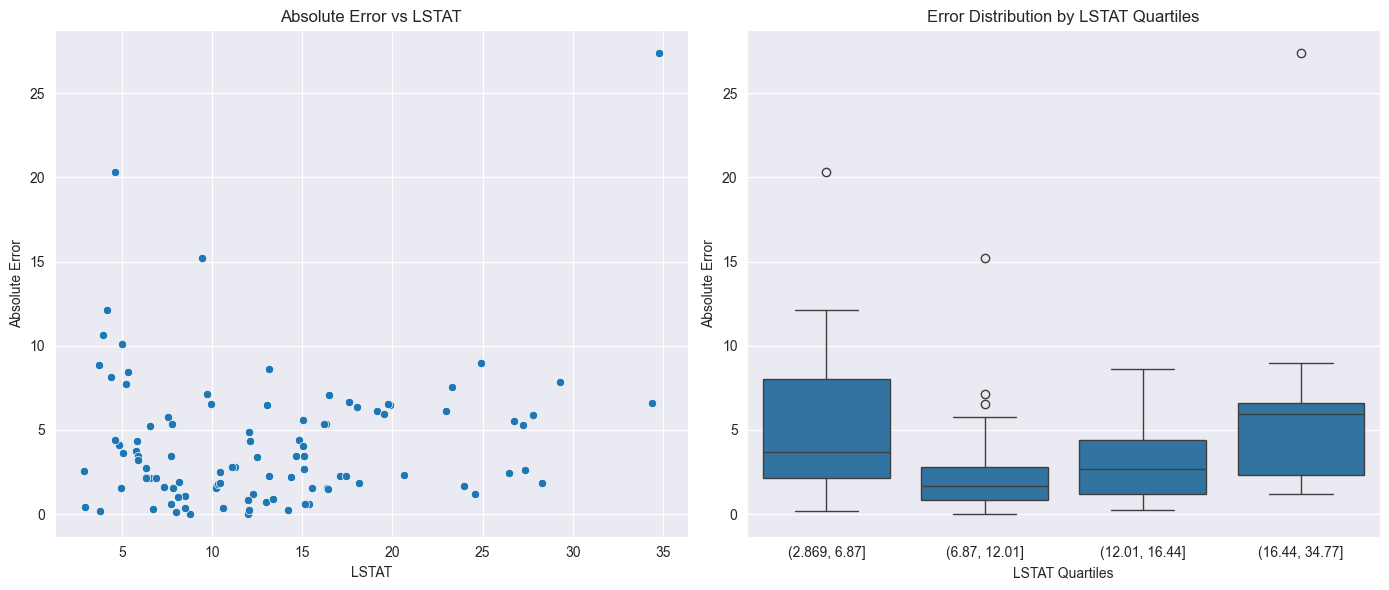

Evaluating: FairBoostRegressor_v2, Fold: 1, Fairness weight: 0.5


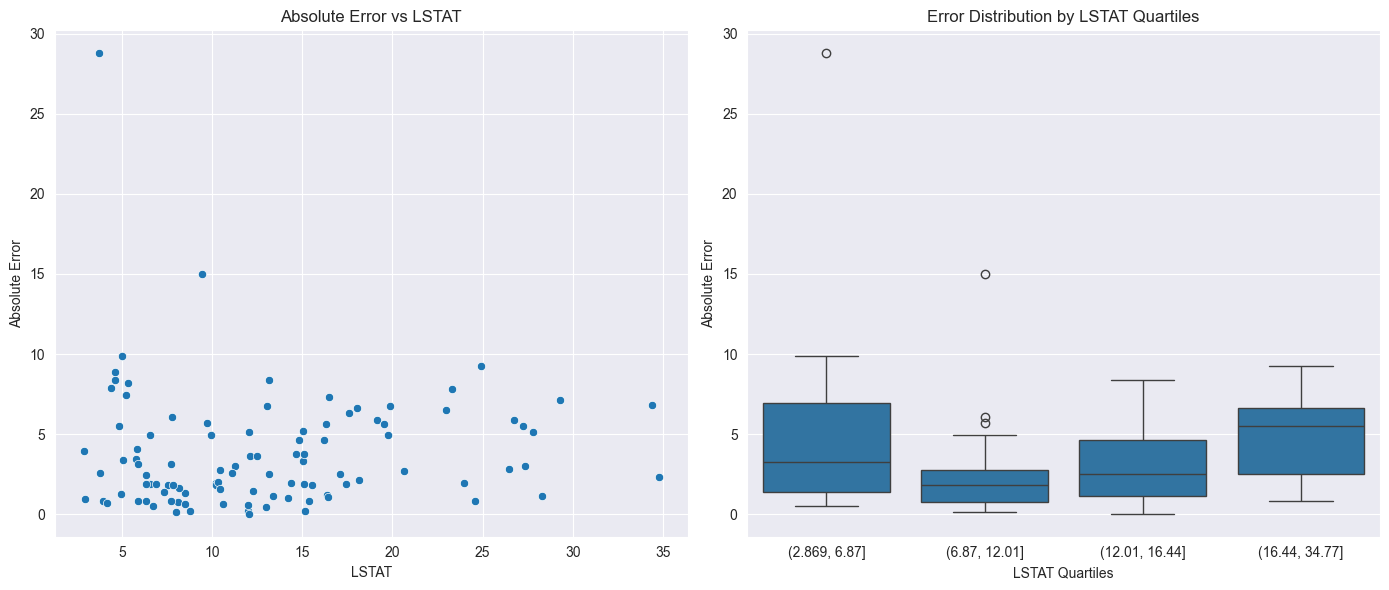

Evaluating: FairBoostRegressor_v2, Fold: 1, Fairness weight: 0.75


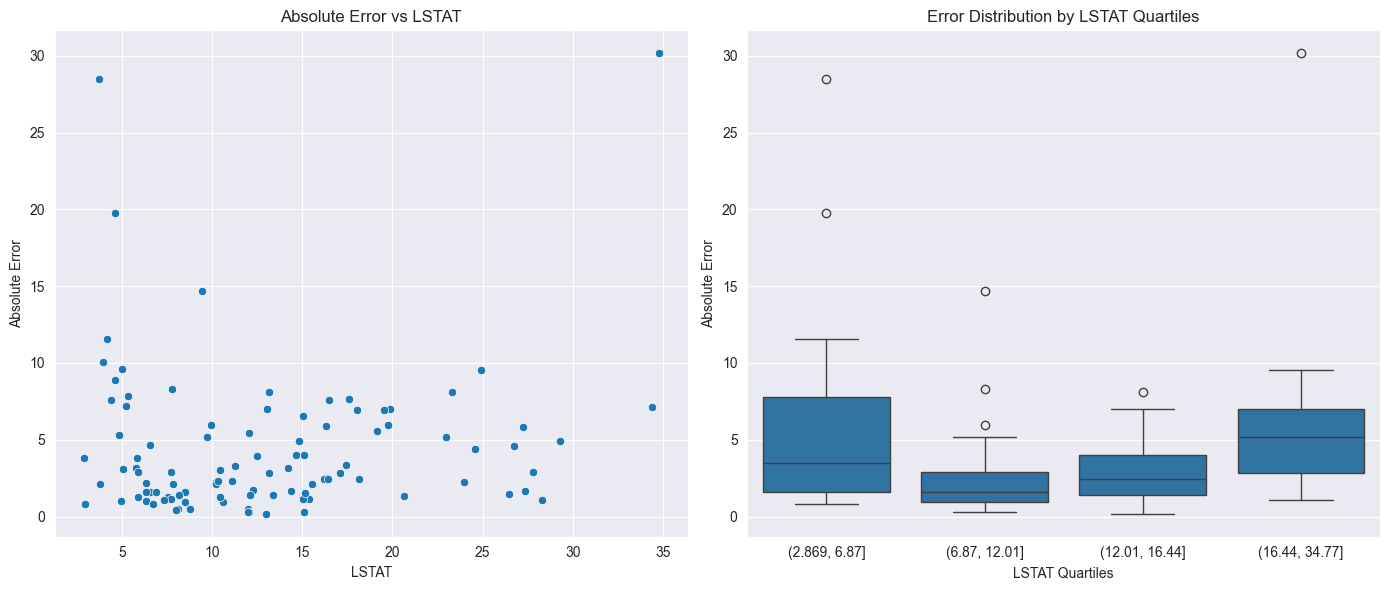

Evaluating: FairBoostRegressor_v2_Improved, Fold: 1, Fairness weight: 0.25


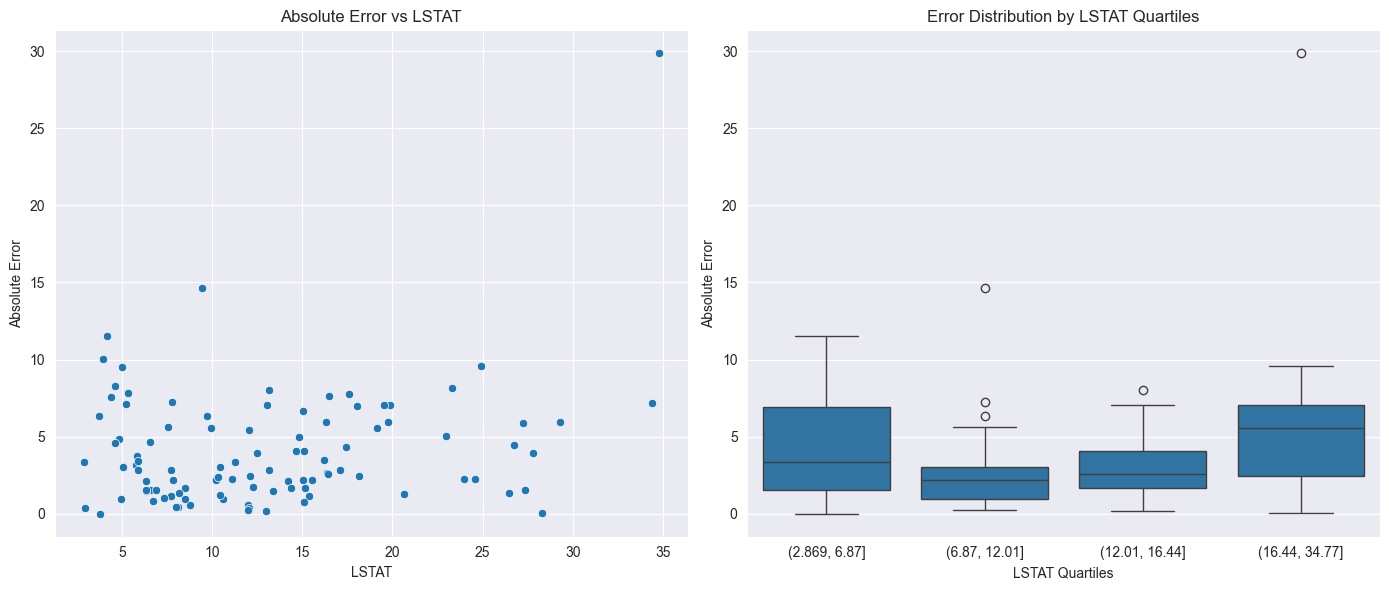

Evaluating: FairBoostRegressor_v2_Improved, Fold: 1, Fairness weight: 0.5


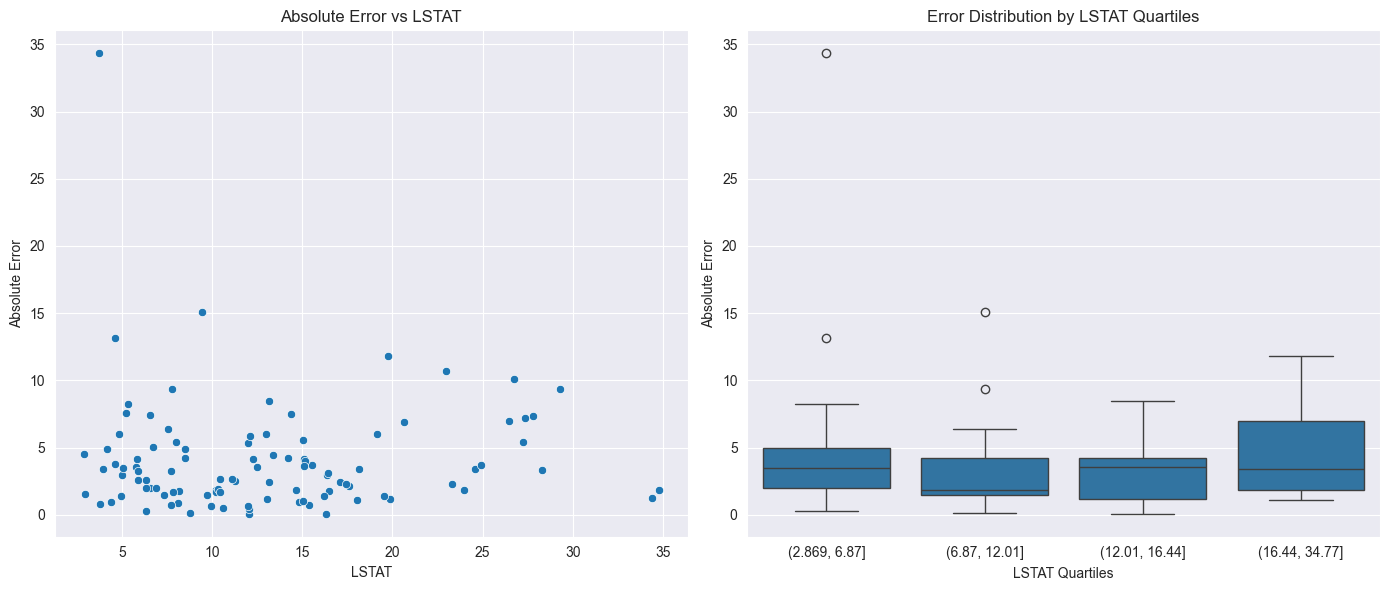

Evaluating: FairBoostRegressor_v2_Improved, Fold: 1, Fairness weight: 0.75


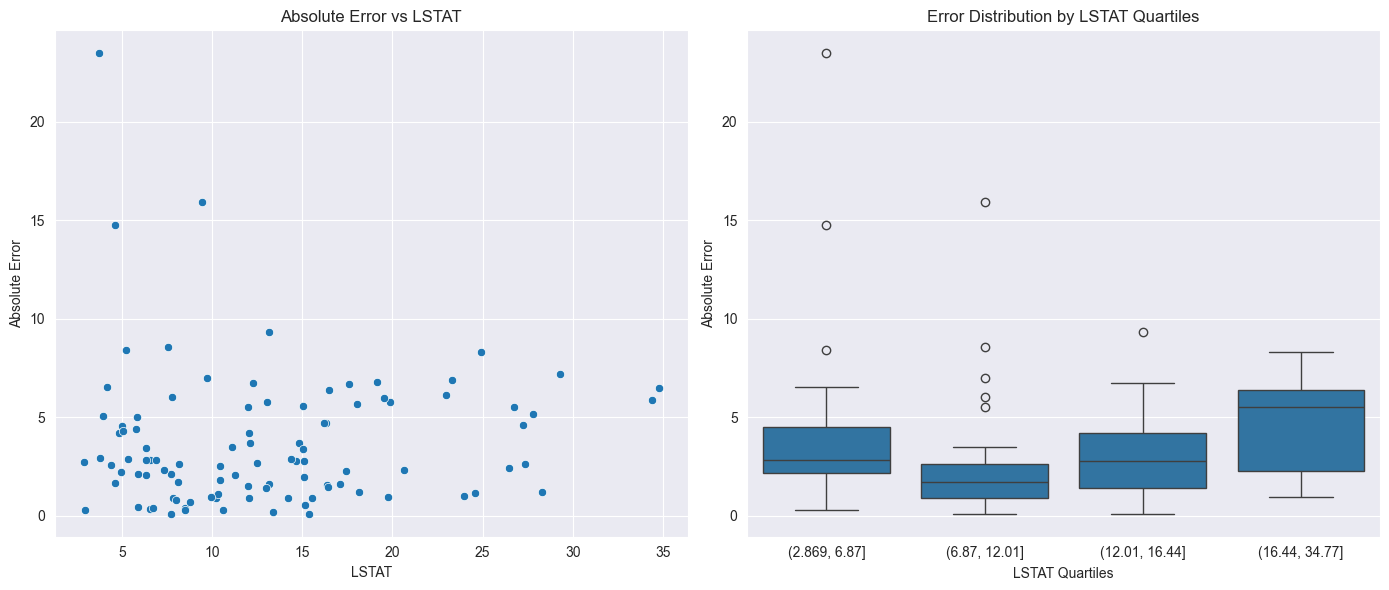

Evaluating: FairBoostRegressor_v3, Fold: 1, Fairness weight: 0.25


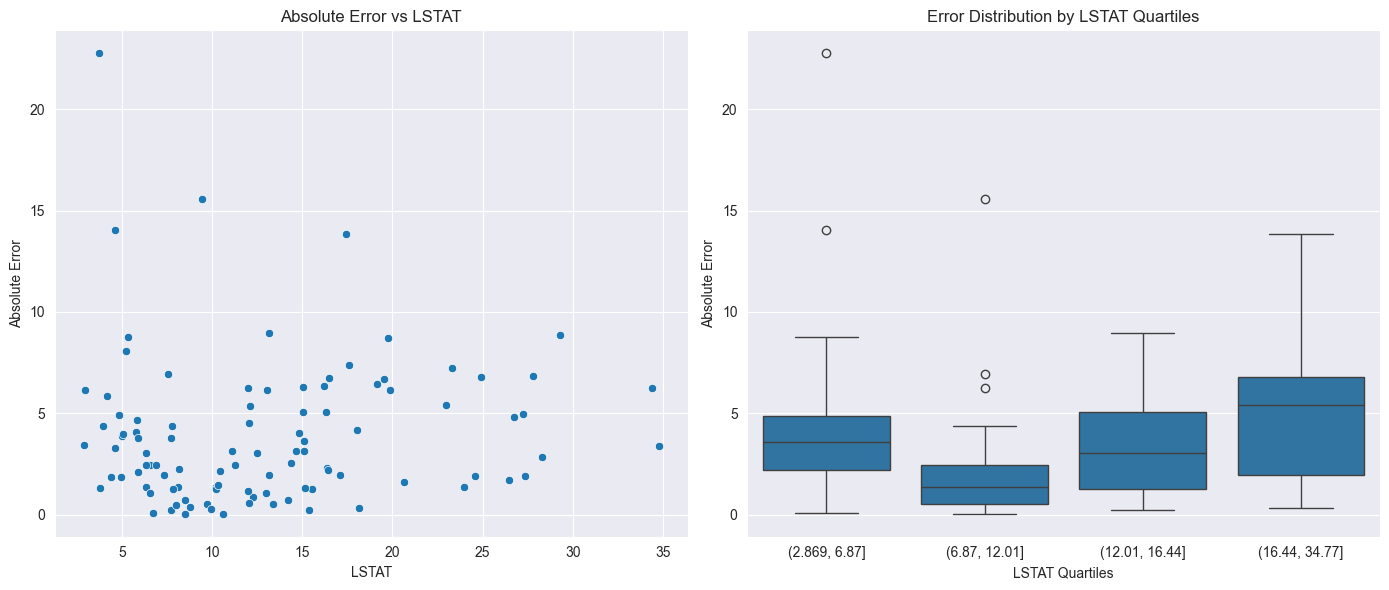

Evaluating: FairBoostRegressor_v3, Fold: 1, Fairness weight: 0.5


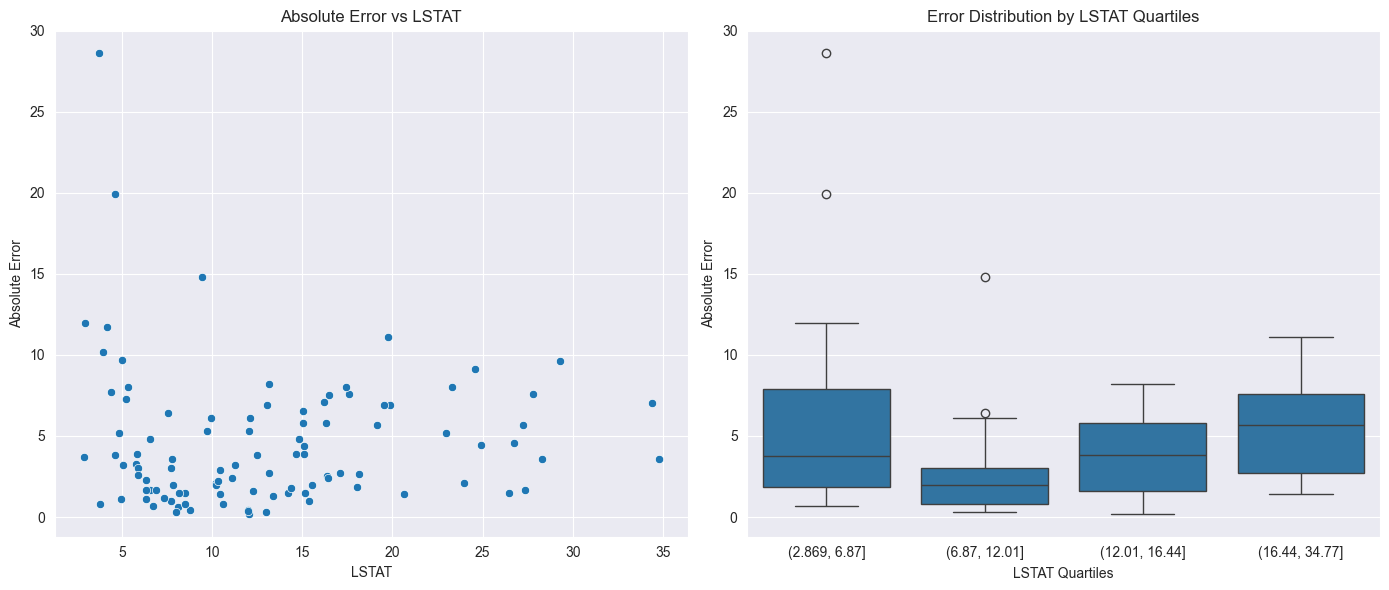

Evaluating: FairBoostRegressor_v3, Fold: 1, Fairness weight: 0.75


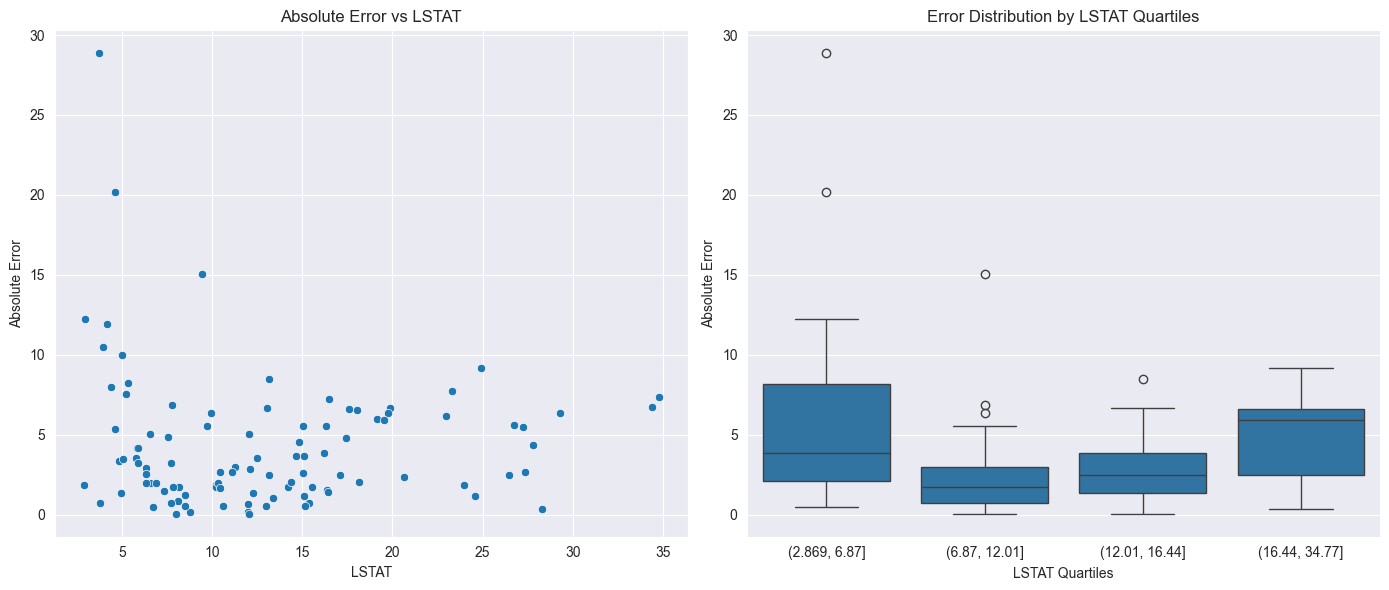

Evaluating: FairBoostRegressor_v1, Fold: 2, Fairness weight: 0.25


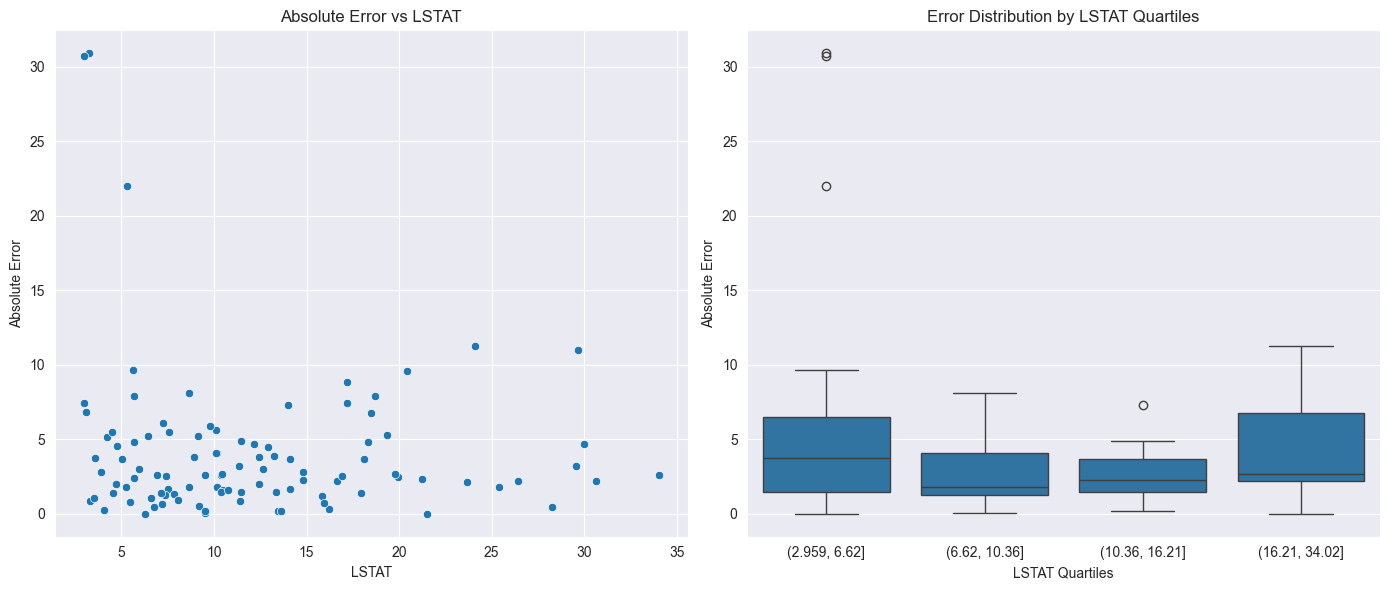

Evaluating: FairBoostRegressor_v1, Fold: 2, Fairness weight: 0.5


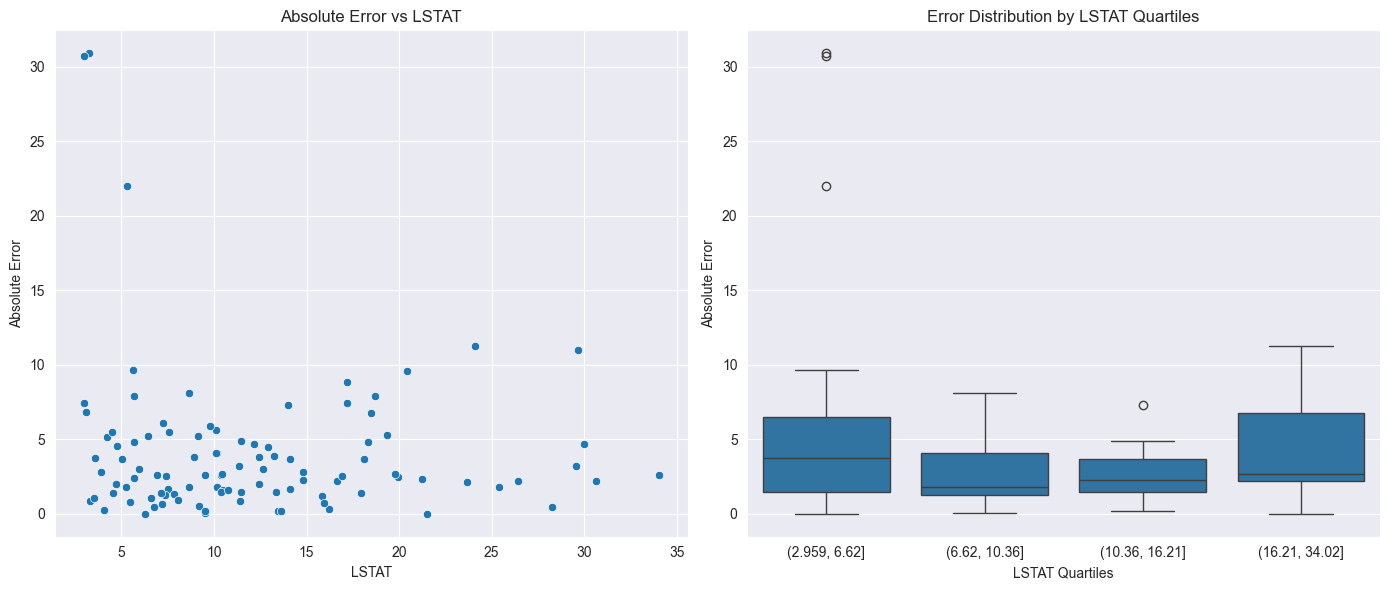

Evaluating: FairBoostRegressor_v1, Fold: 2, Fairness weight: 0.75


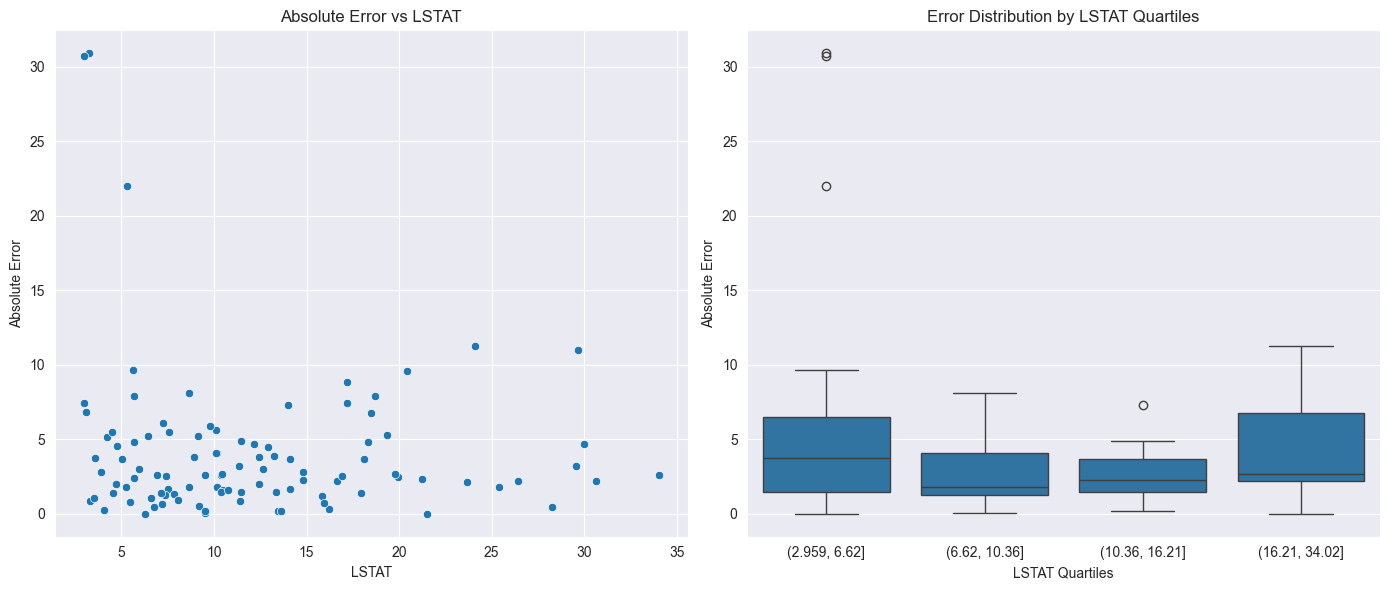

Evaluating: FairBoostRegressor_v1_Improved, Fold: 2, Fairness weight: 0.25


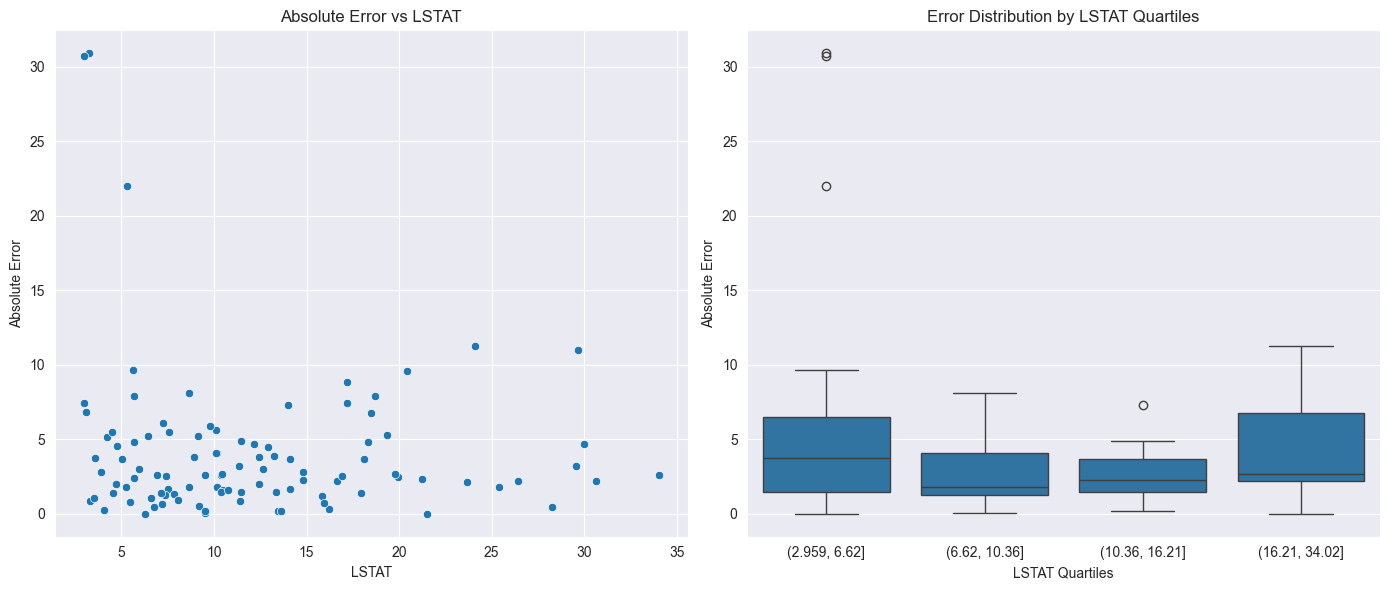

Evaluating: FairBoostRegressor_v1_Improved, Fold: 2, Fairness weight: 0.5


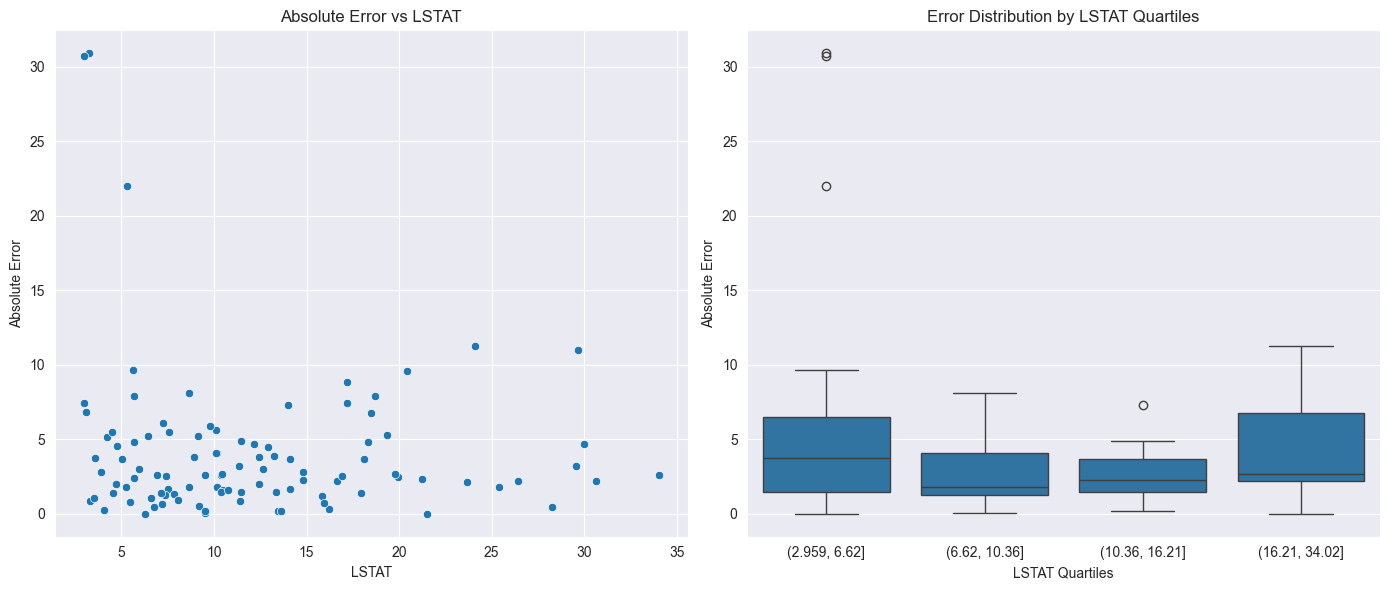

Evaluating: FairBoostRegressor_v1_Improved, Fold: 2, Fairness weight: 0.75


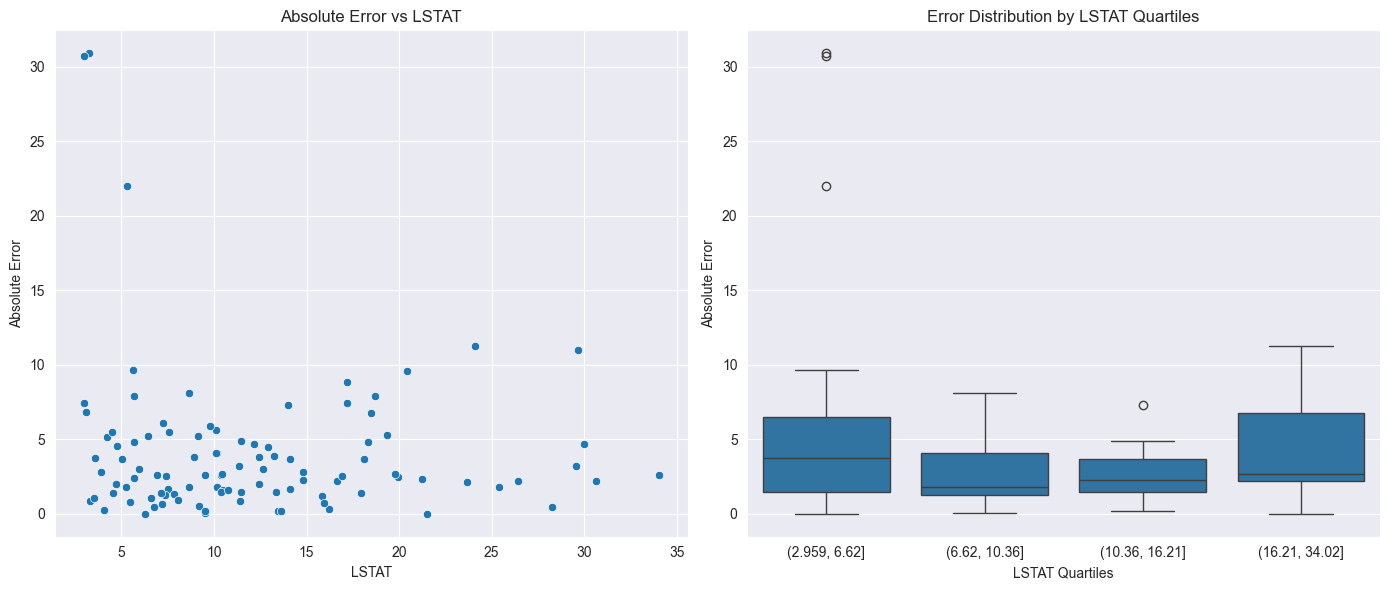

Evaluating: FairBoostRegressor_v2, Fold: 2, Fairness weight: 0.25


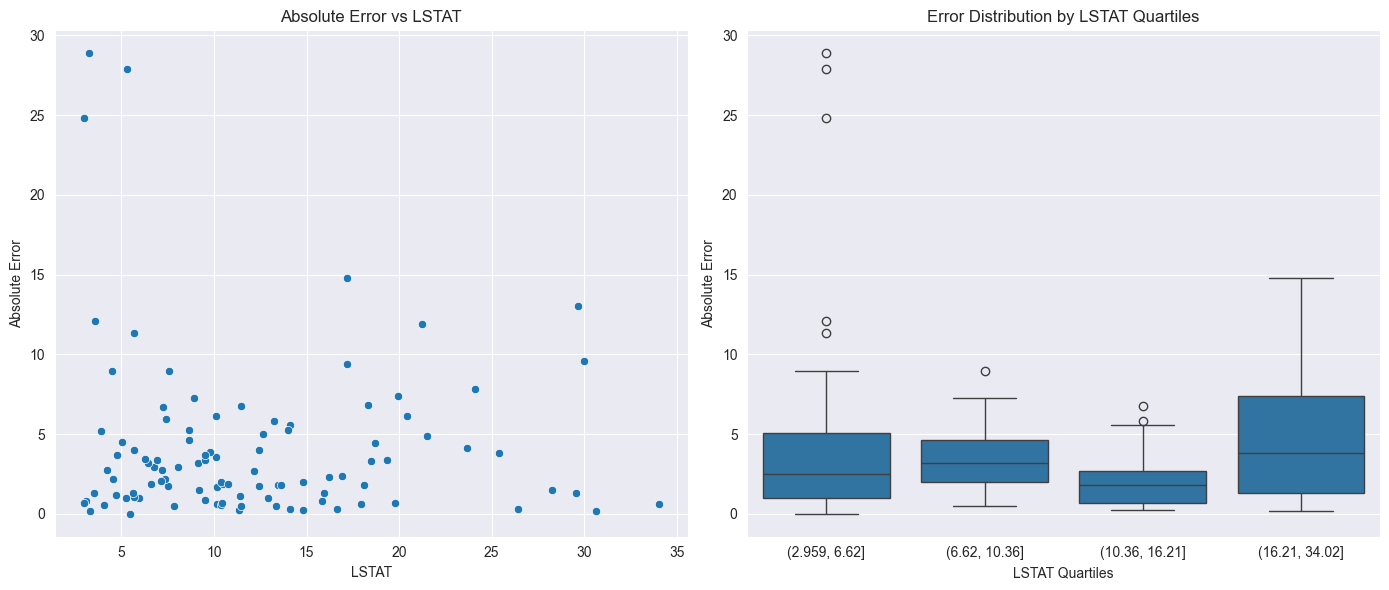

Evaluating: FairBoostRegressor_v2, Fold: 2, Fairness weight: 0.5


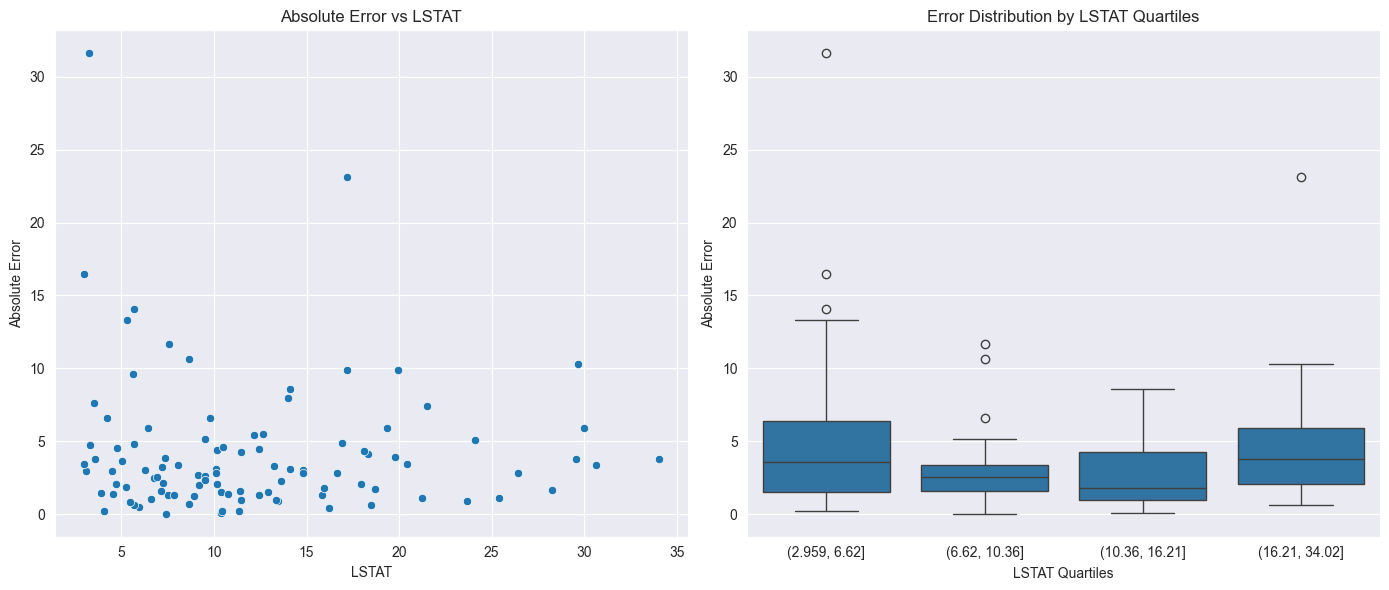

Evaluating: FairBoostRegressor_v2, Fold: 2, Fairness weight: 0.75


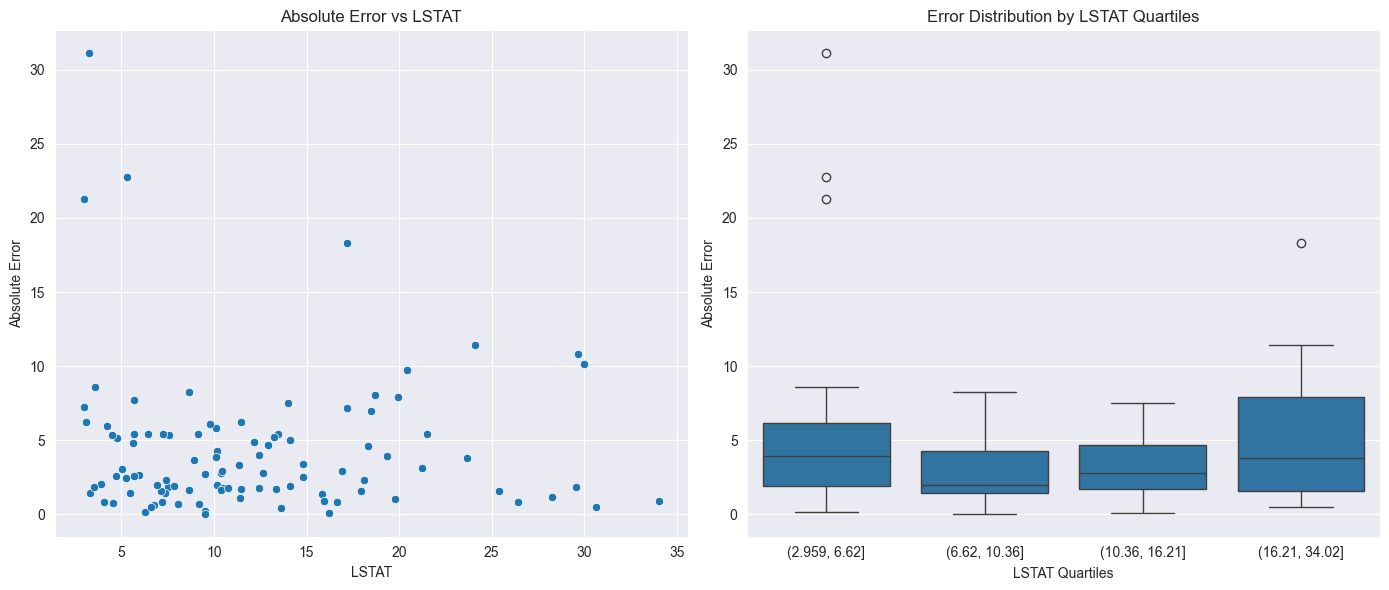

Evaluating: FairBoostRegressor_v2_Improved, Fold: 2, Fairness weight: 0.25


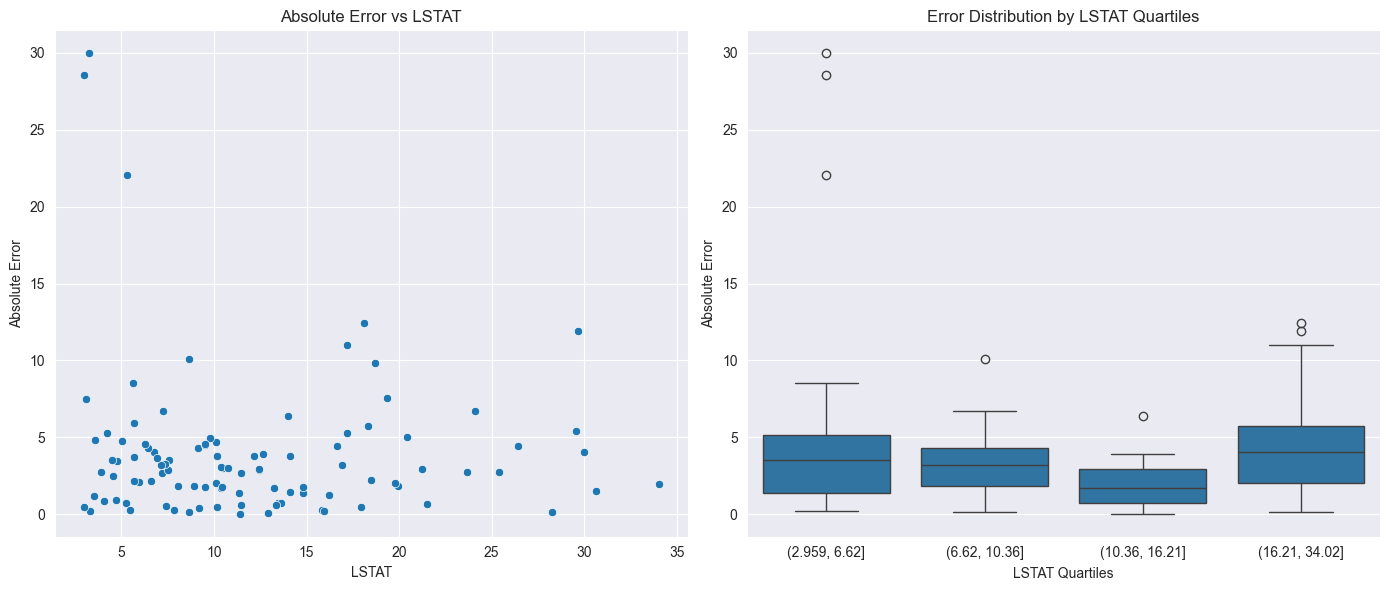

Evaluating: FairBoostRegressor_v2_Improved, Fold: 2, Fairness weight: 0.5


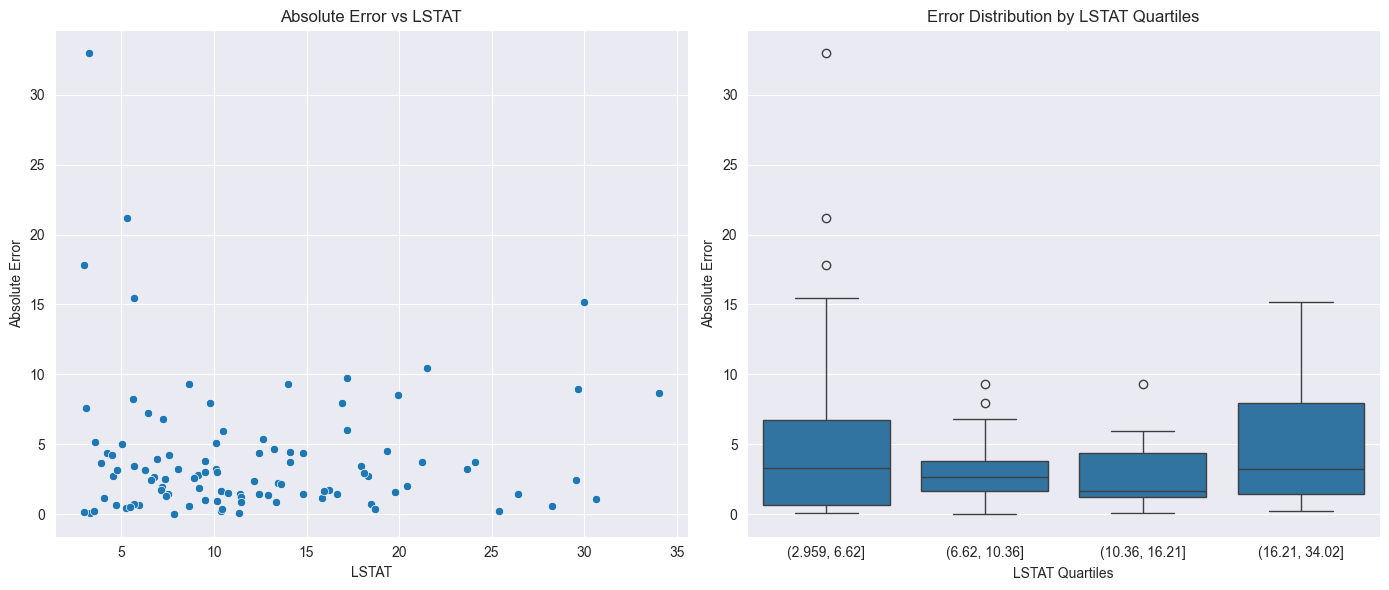

Evaluating: FairBoostRegressor_v2_Improved, Fold: 2, Fairness weight: 0.75


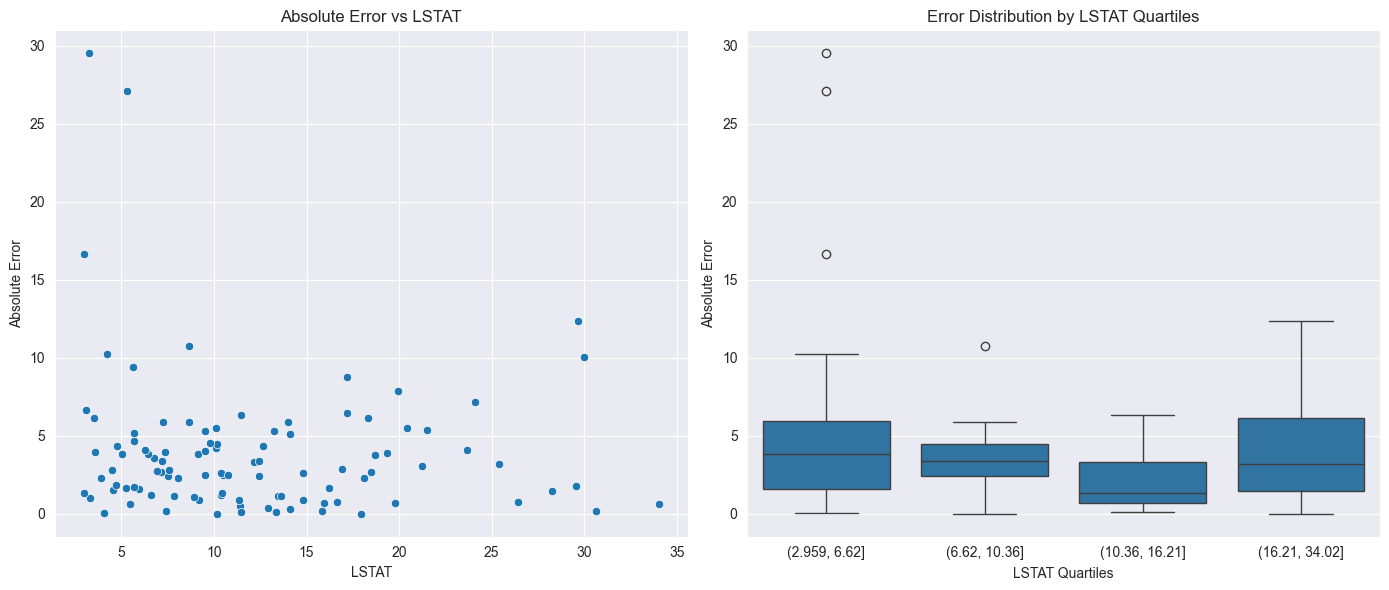

Evaluating: FairBoostRegressor_v3, Fold: 2, Fairness weight: 0.25


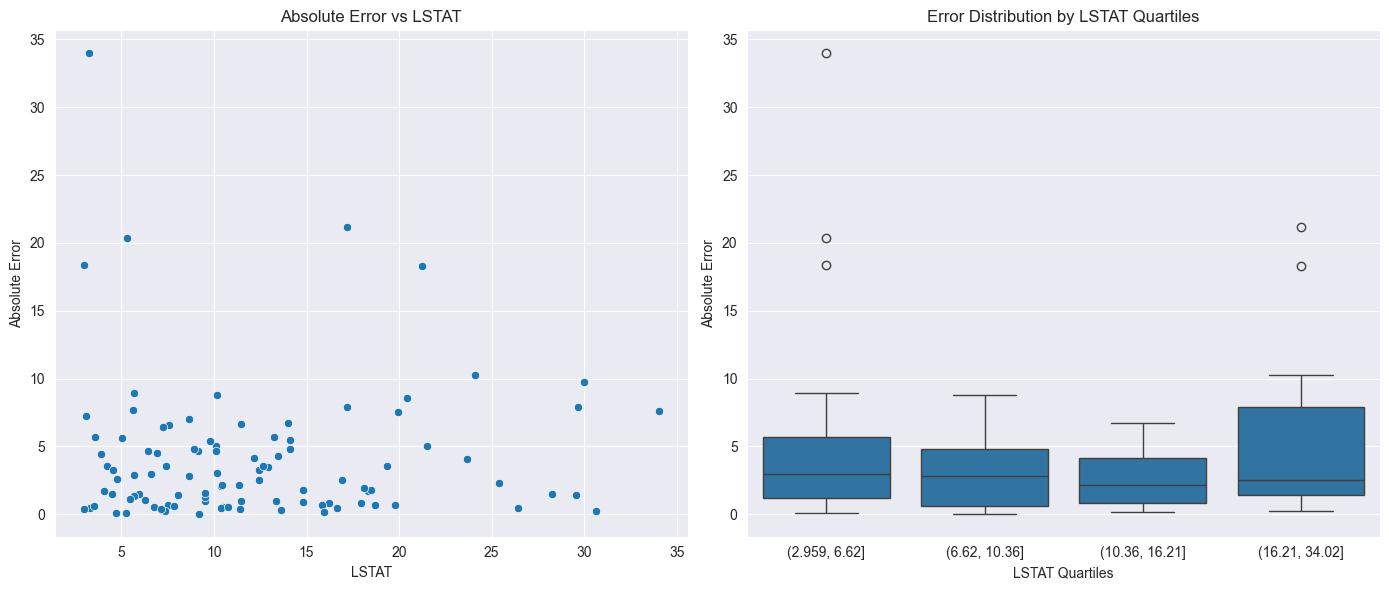

Evaluating: FairBoostRegressor_v3, Fold: 2, Fairness weight: 0.5


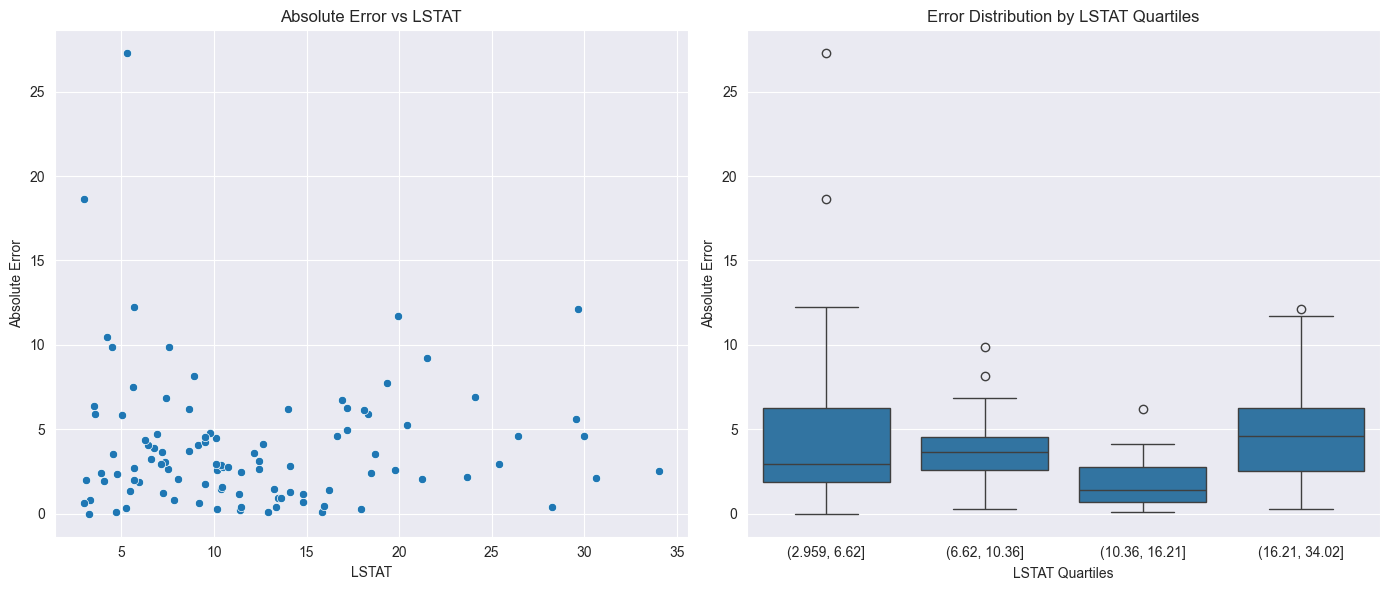

Evaluating: FairBoostRegressor_v3, Fold: 2, Fairness weight: 0.75


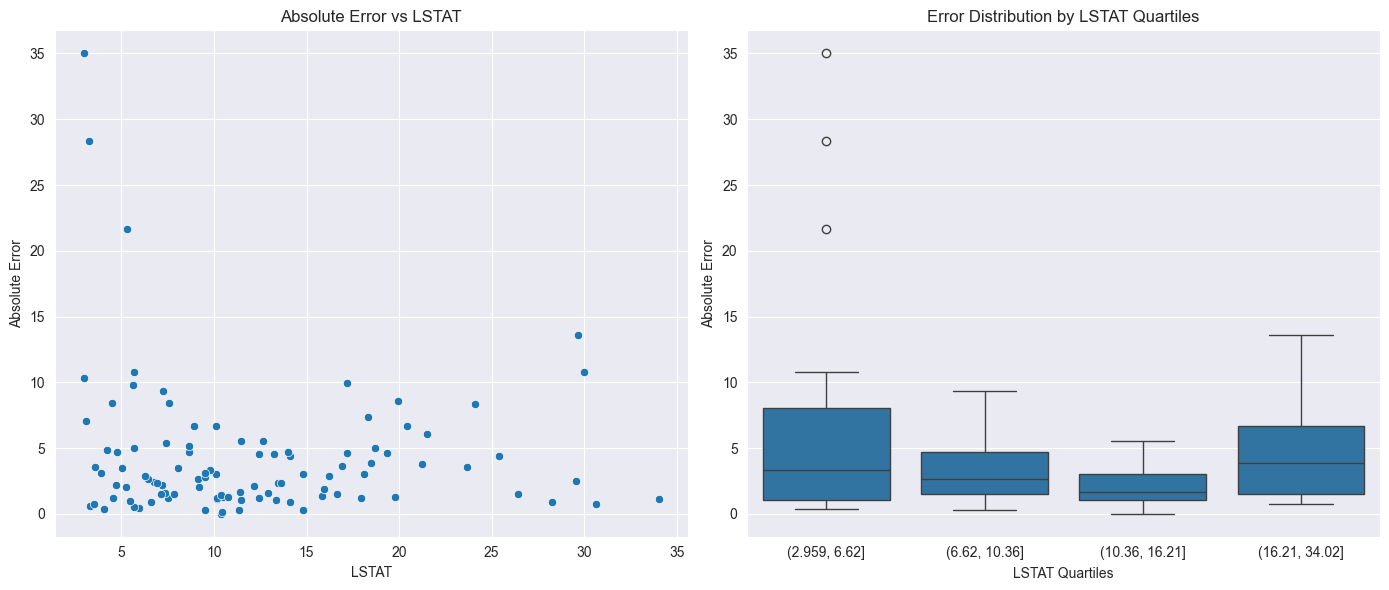

Evaluating: FairBoostRegressor_v1, Fold: 3, Fairness weight: 0.25


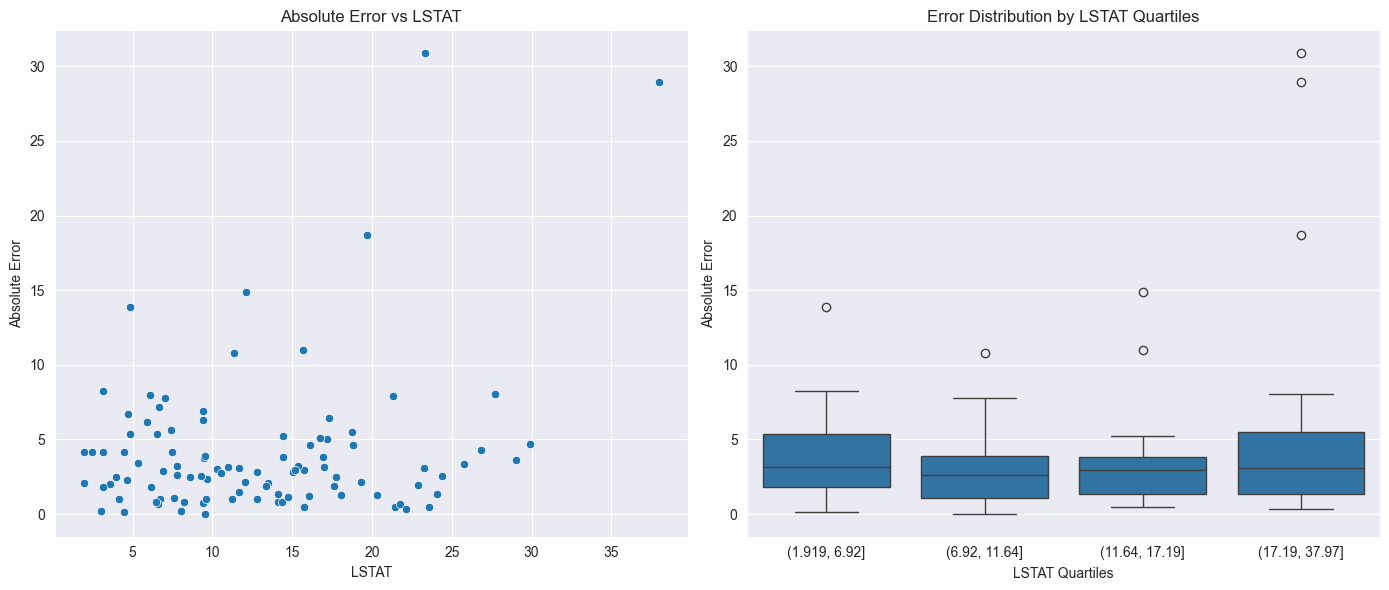

Evaluating: FairBoostRegressor_v1, Fold: 3, Fairness weight: 0.5


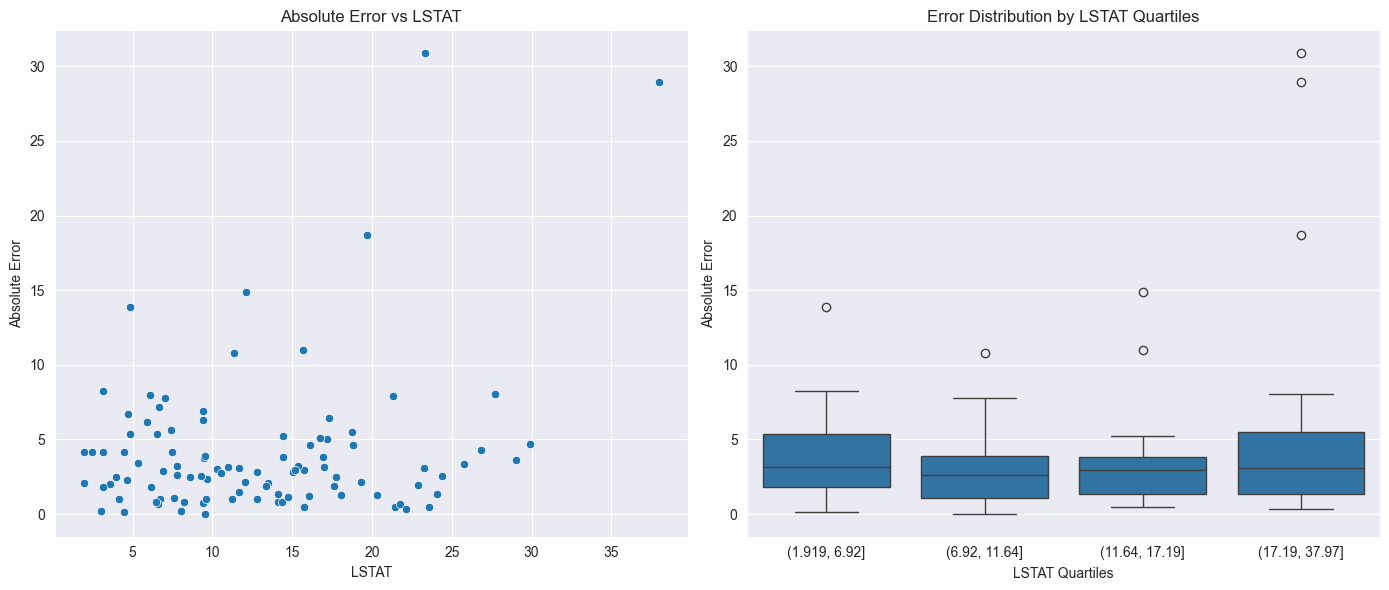

Evaluating: FairBoostRegressor_v1, Fold: 3, Fairness weight: 0.75


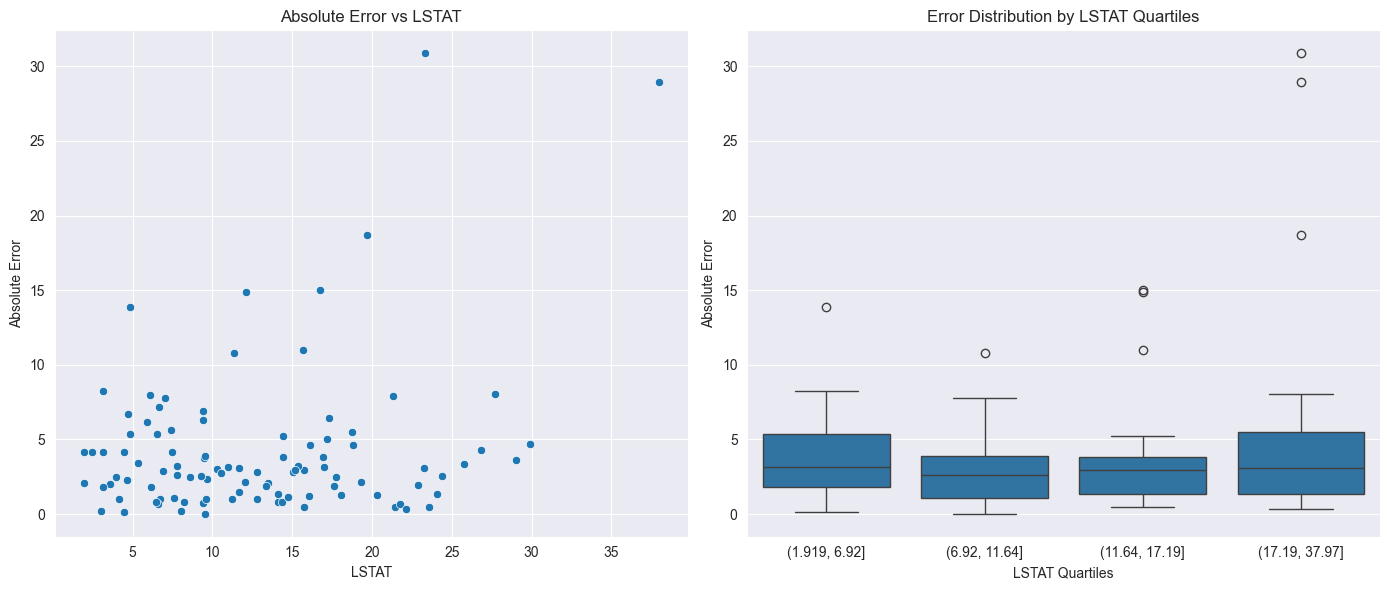

Evaluating: FairBoostRegressor_v1_Improved, Fold: 3, Fairness weight: 0.25


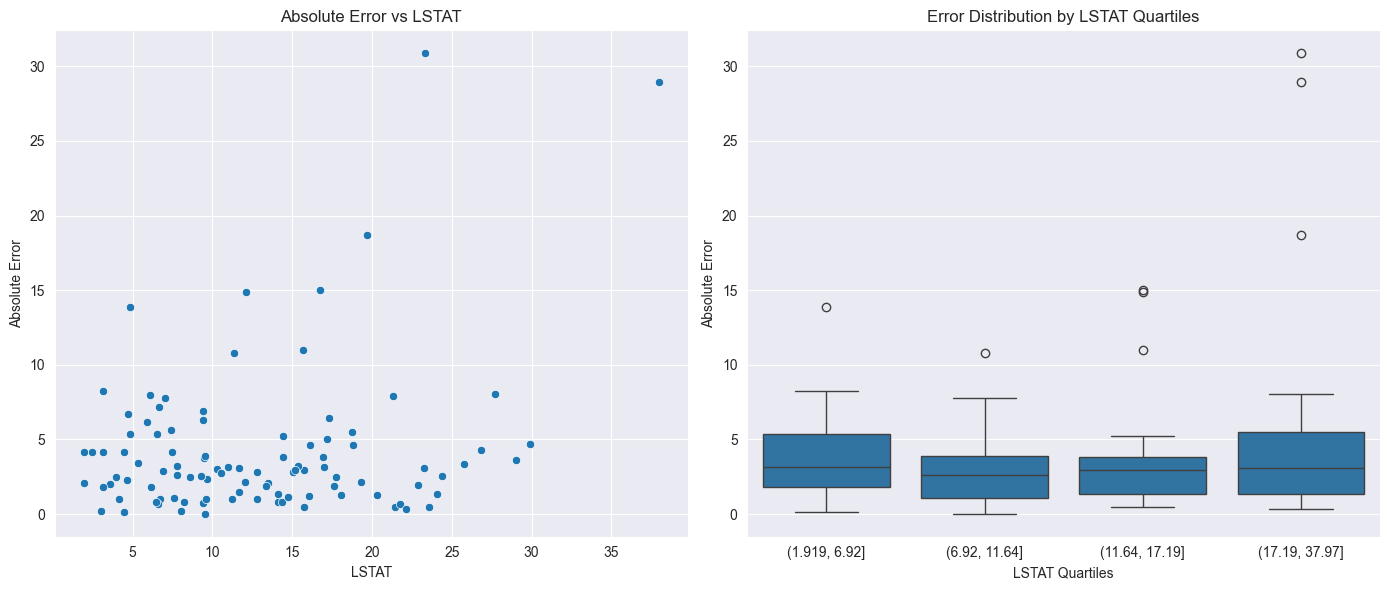

Evaluating: FairBoostRegressor_v1_Improved, Fold: 3, Fairness weight: 0.5


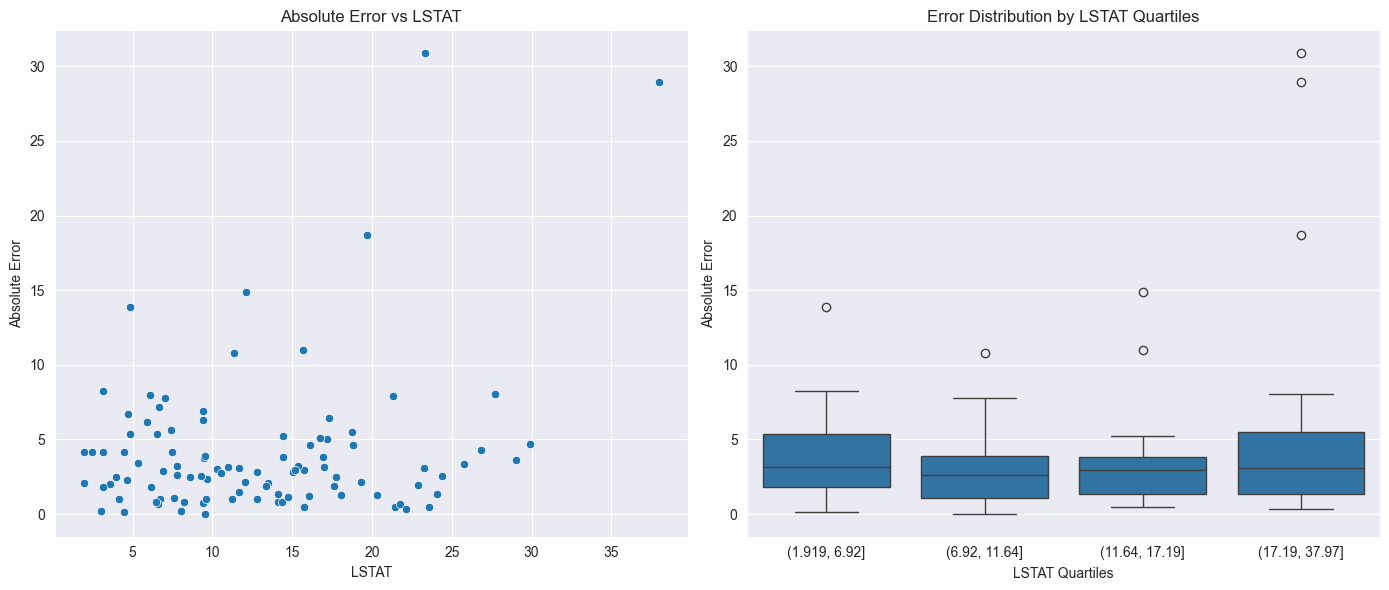

Evaluating: FairBoostRegressor_v1_Improved, Fold: 3, Fairness weight: 0.75


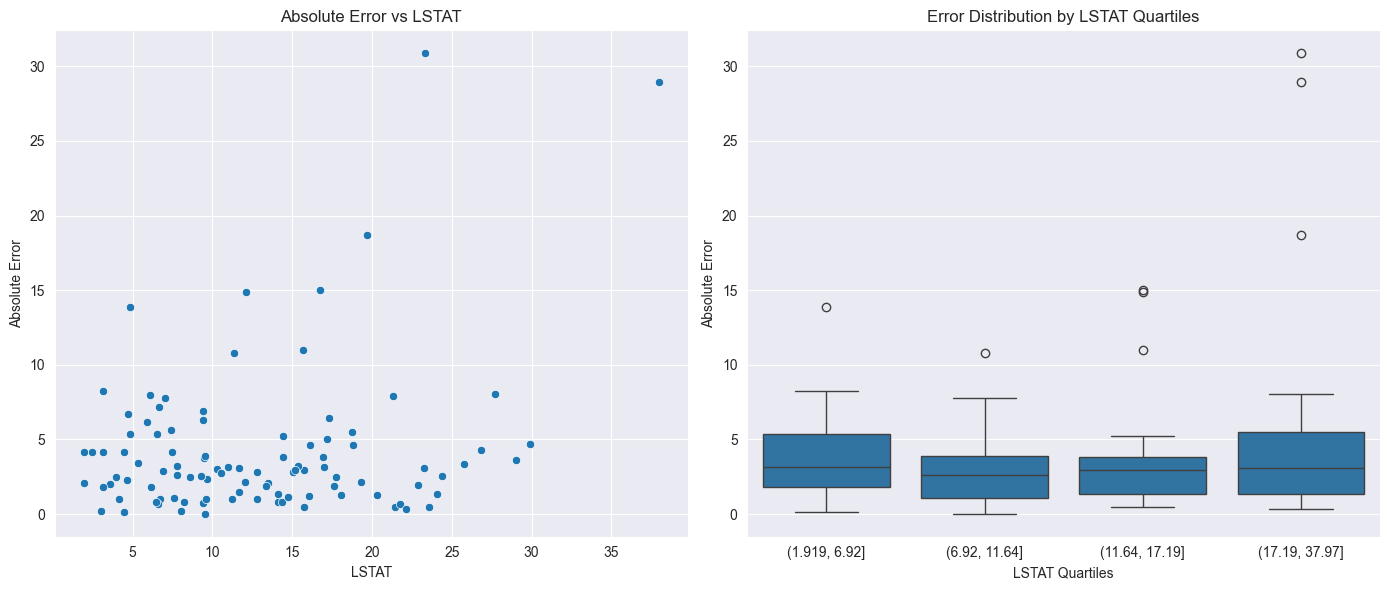

Evaluating: FairBoostRegressor_v2, Fold: 3, Fairness weight: 0.25


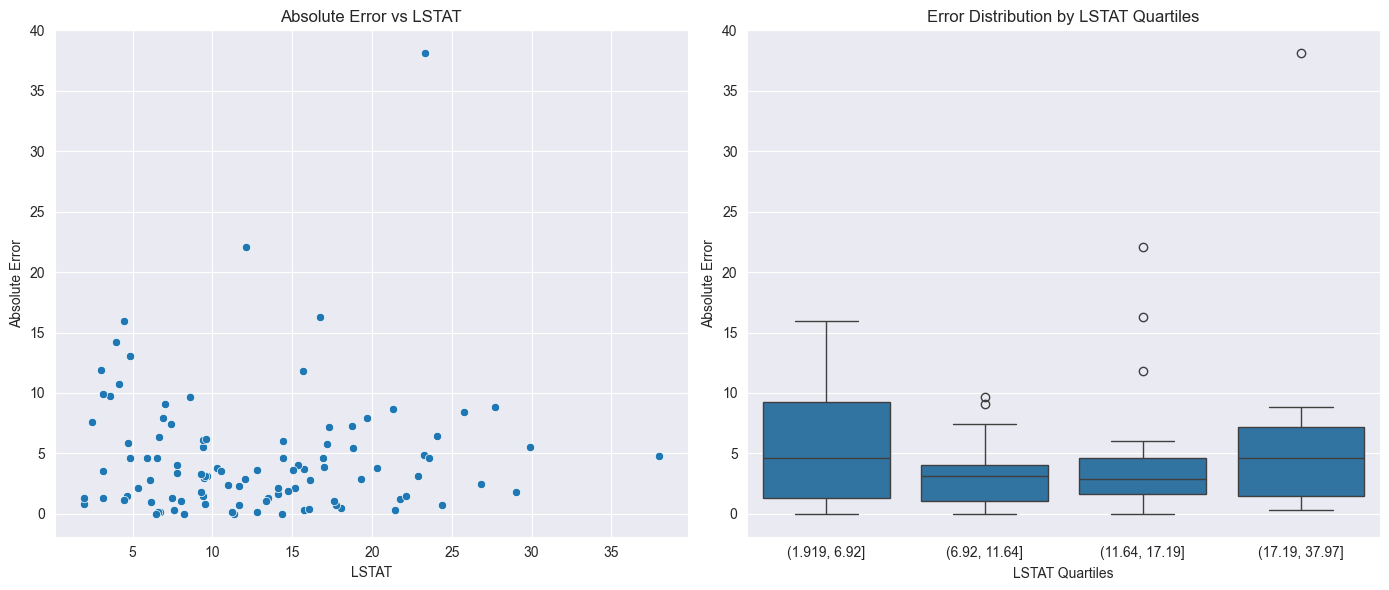

Evaluating: FairBoostRegressor_v2, Fold: 3, Fairness weight: 0.5


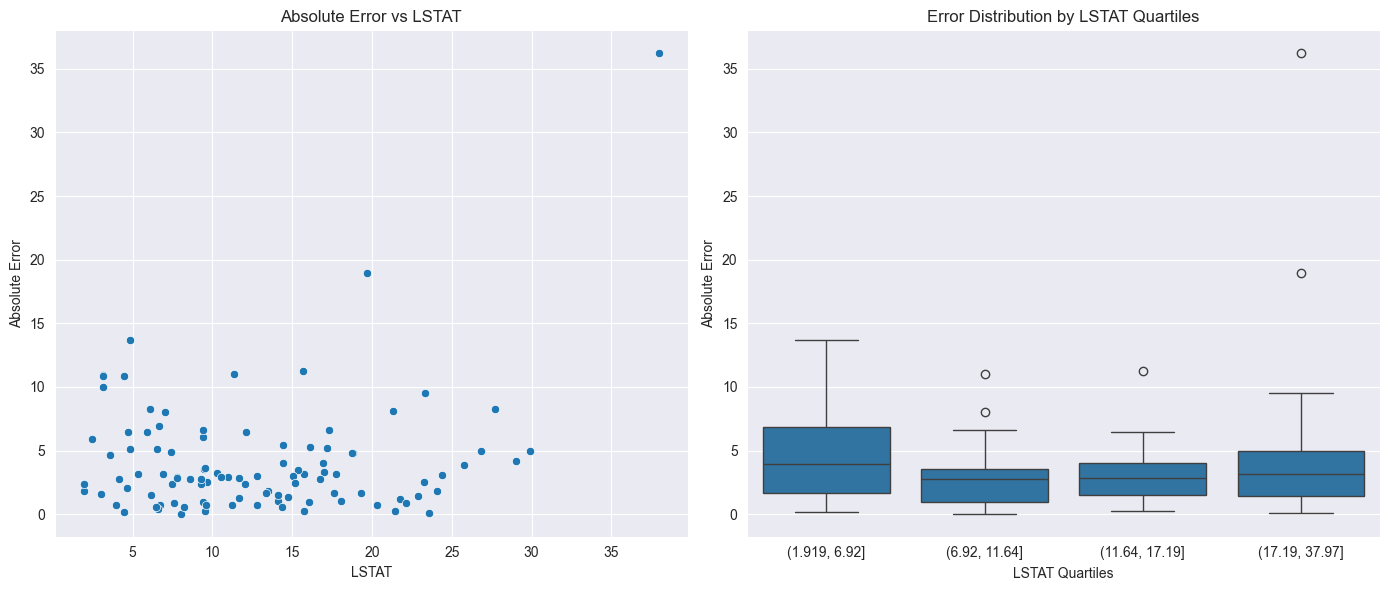

Evaluating: FairBoostRegressor_v2, Fold: 3, Fairness weight: 0.75


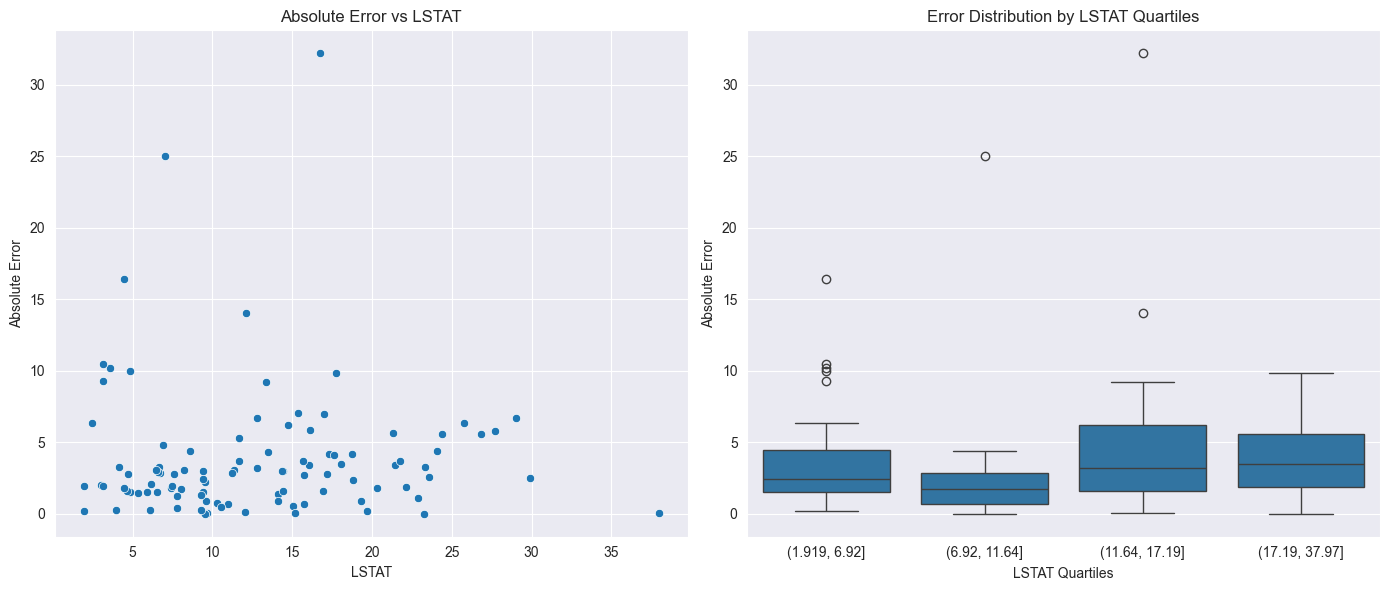

Evaluating: FairBoostRegressor_v2_Improved, Fold: 3, Fairness weight: 0.25


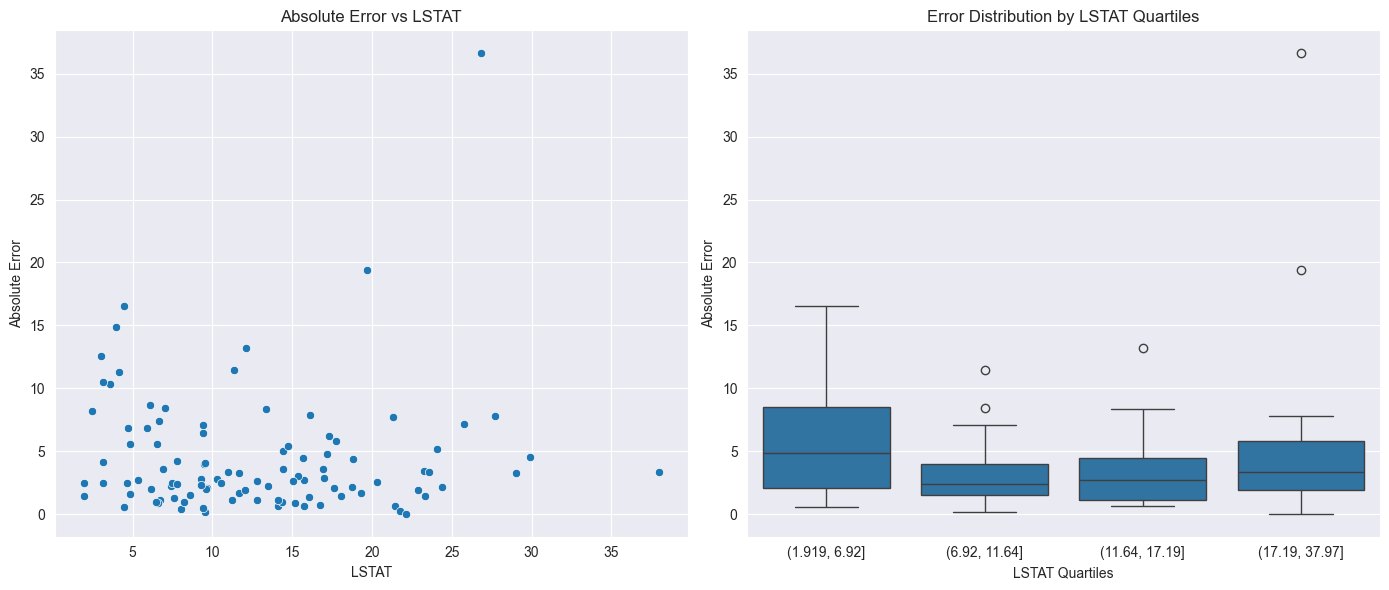

Evaluating: FairBoostRegressor_v2_Improved, Fold: 3, Fairness weight: 0.5


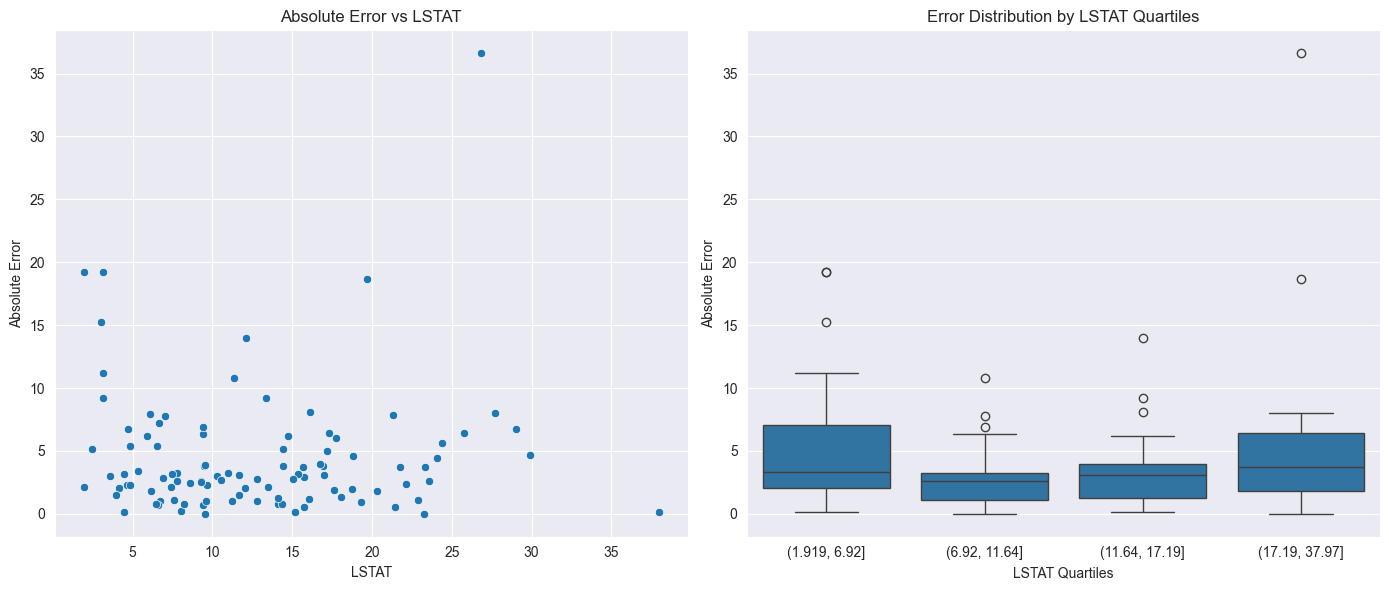

Evaluating: FairBoostRegressor_v2_Improved, Fold: 3, Fairness weight: 0.75


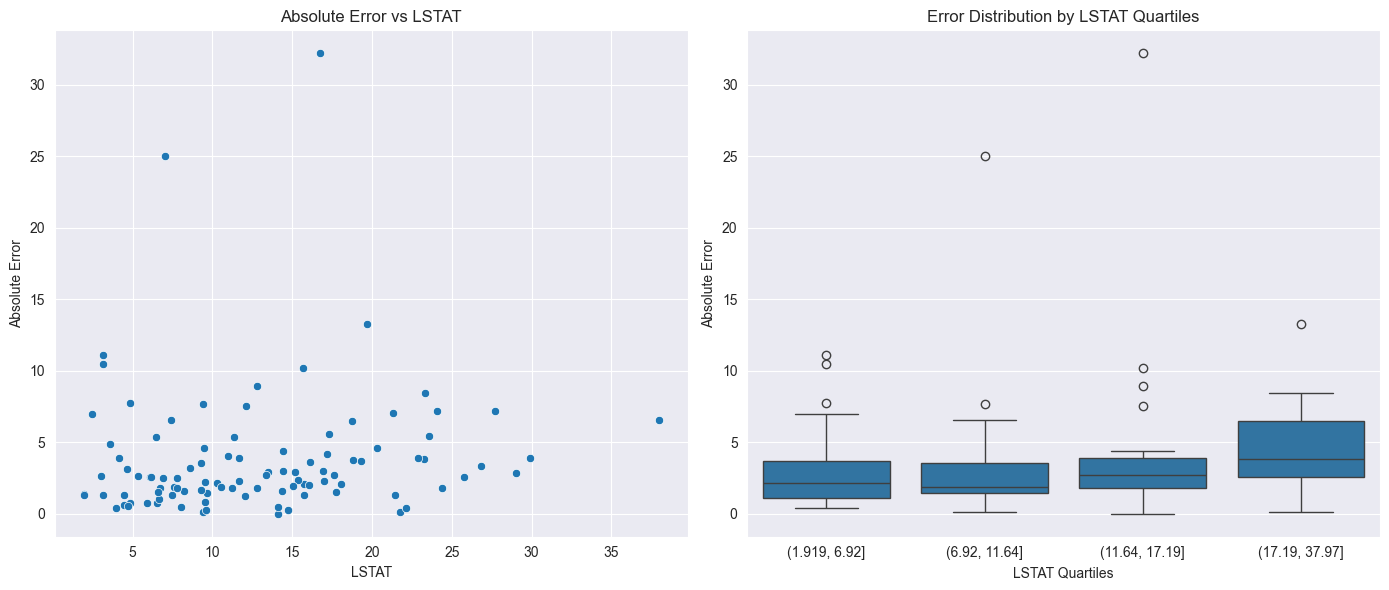

Evaluating: FairBoostRegressor_v3, Fold: 3, Fairness weight: 0.25


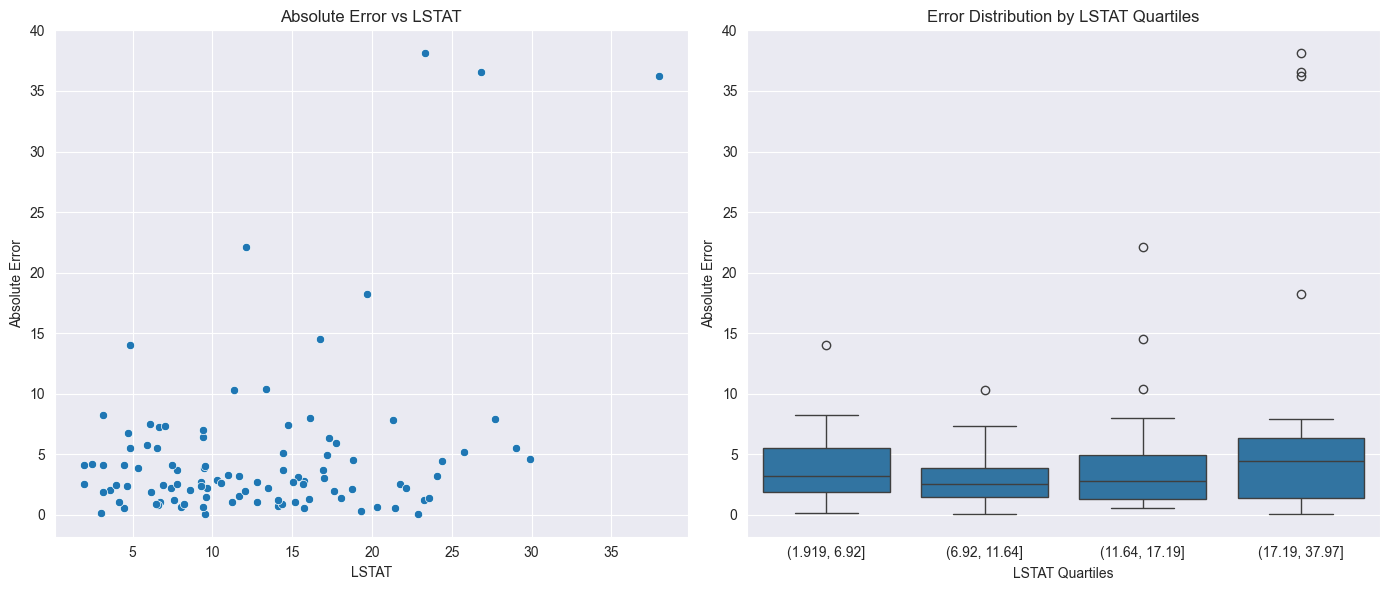

Evaluating: FairBoostRegressor_v3, Fold: 3, Fairness weight: 0.5


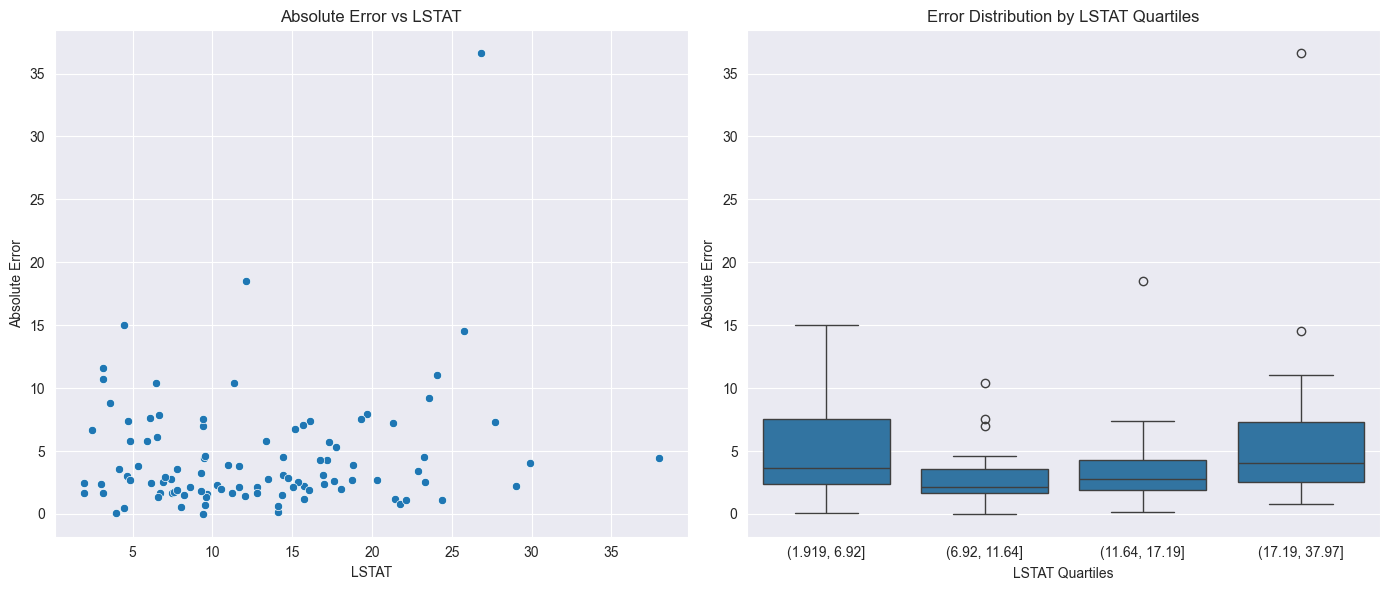

Evaluating: FairBoostRegressor_v3, Fold: 3, Fairness weight: 0.75


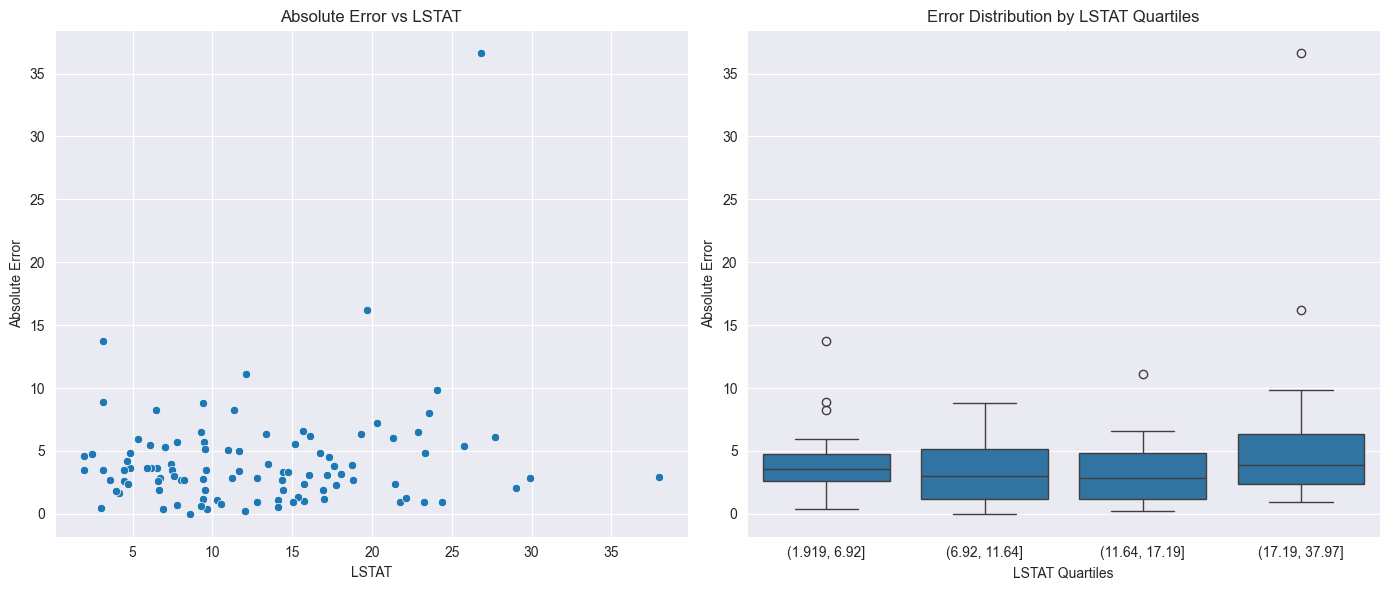

Evaluating: FairBoostRegressor_v1, Fold: 4, Fairness weight: 0.25


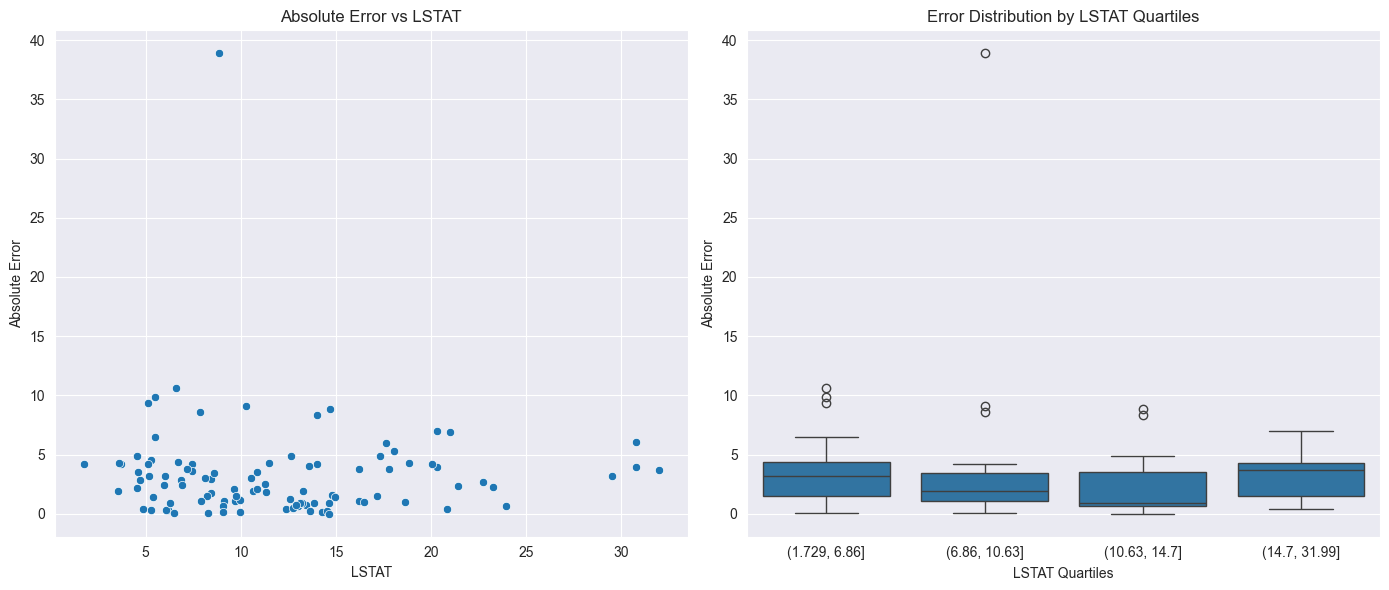

Evaluating: FairBoostRegressor_v1, Fold: 4, Fairness weight: 0.5


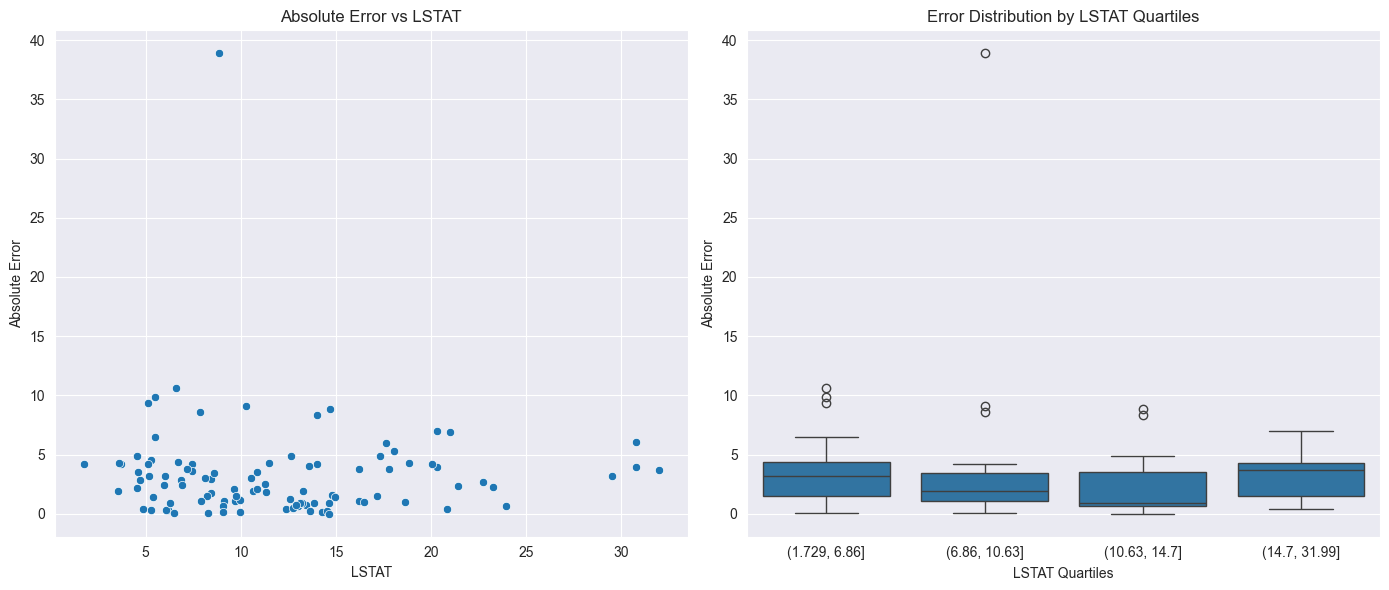

Evaluating: FairBoostRegressor_v1, Fold: 4, Fairness weight: 0.75


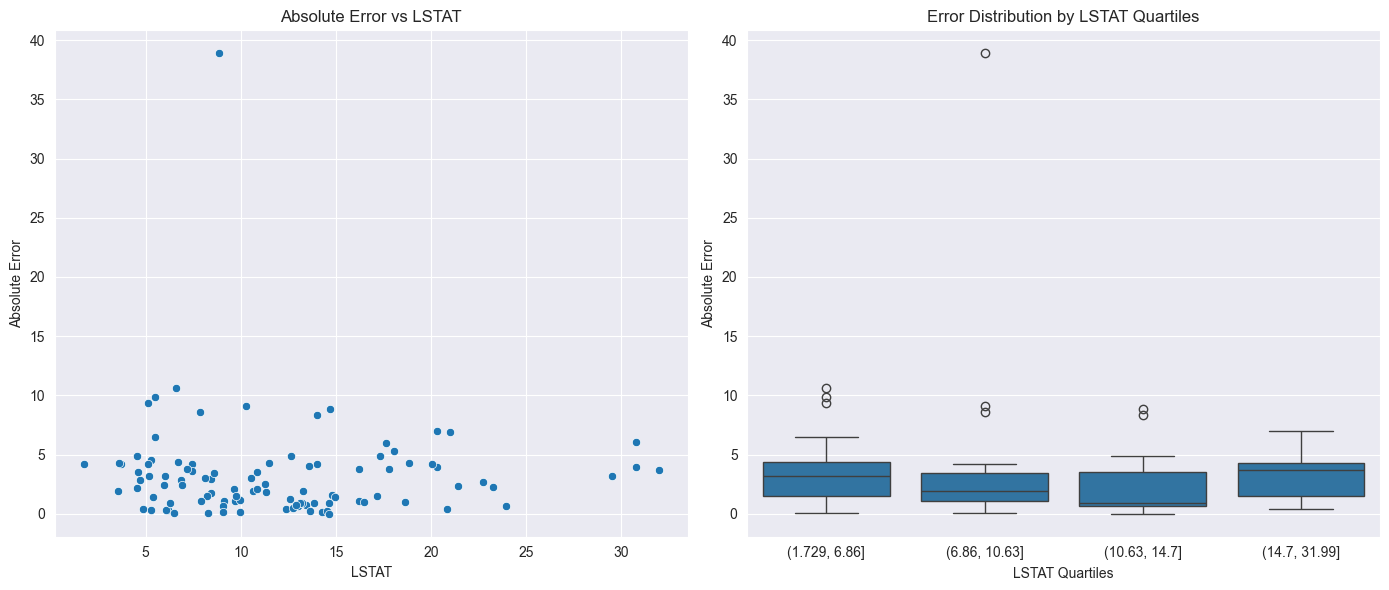

Evaluating: FairBoostRegressor_v1_Improved, Fold: 4, Fairness weight: 0.25


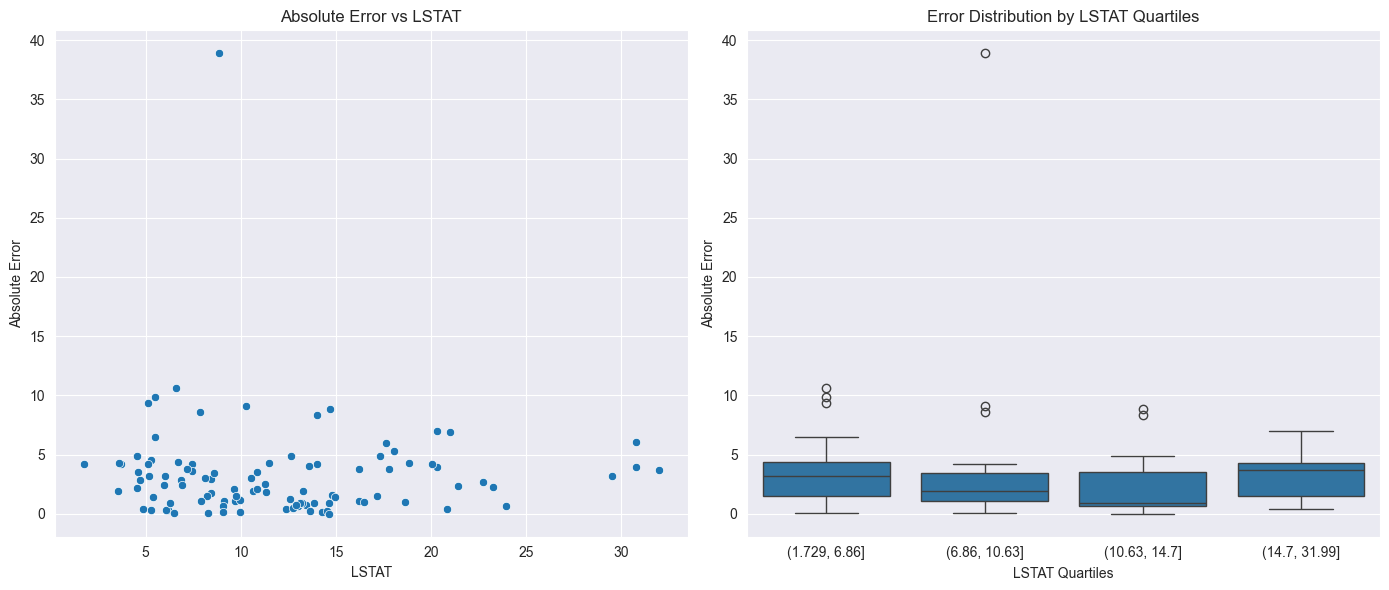

Evaluating: FairBoostRegressor_v1_Improved, Fold: 4, Fairness weight: 0.5


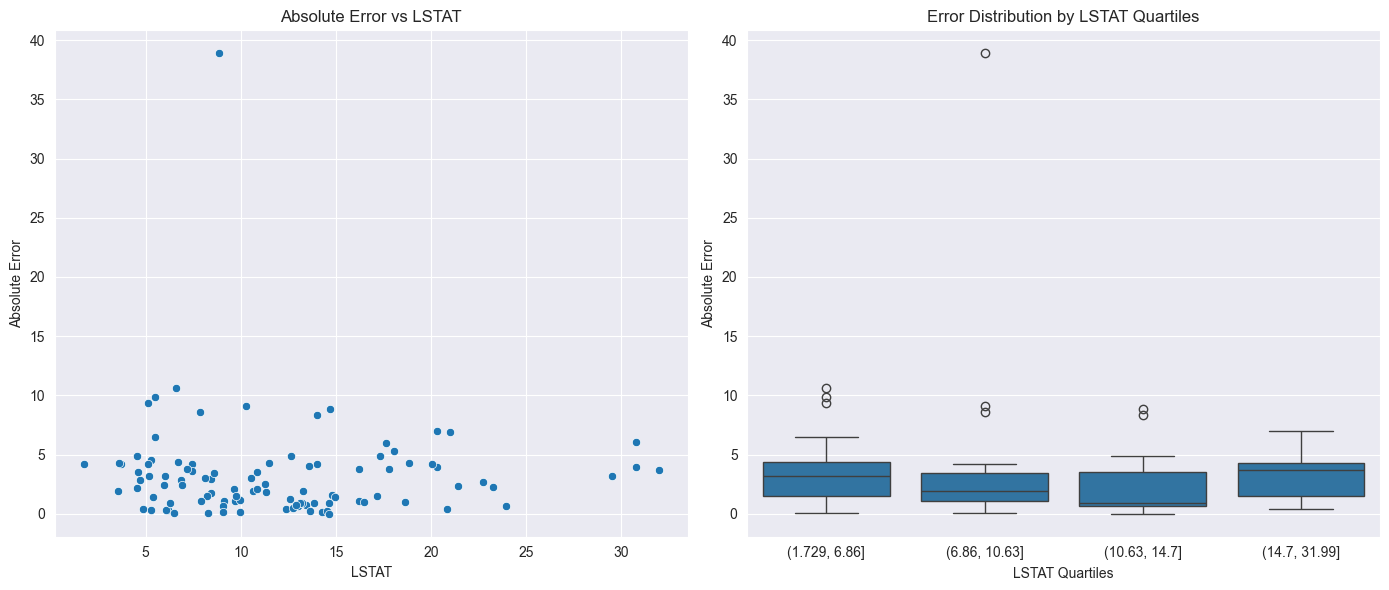

Evaluating: FairBoostRegressor_v1_Improved, Fold: 4, Fairness weight: 0.75


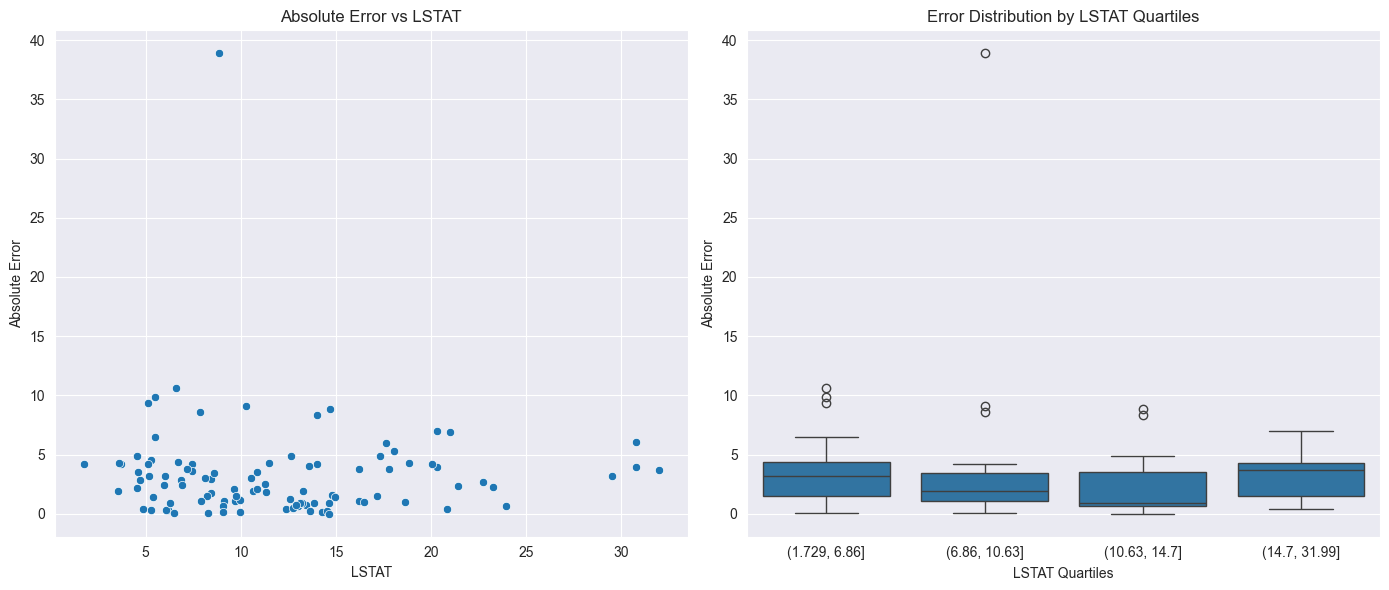

Evaluating: FairBoostRegressor_v2, Fold: 4, Fairness weight: 0.25


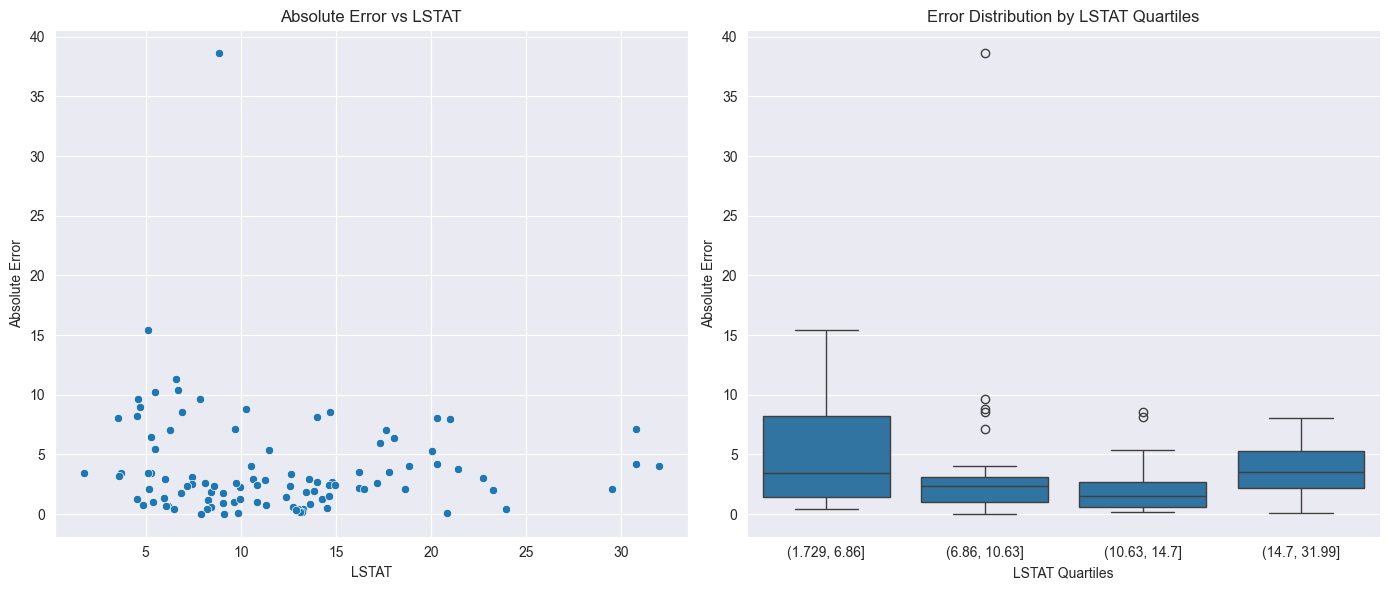

Evaluating: FairBoostRegressor_v2, Fold: 4, Fairness weight: 0.5


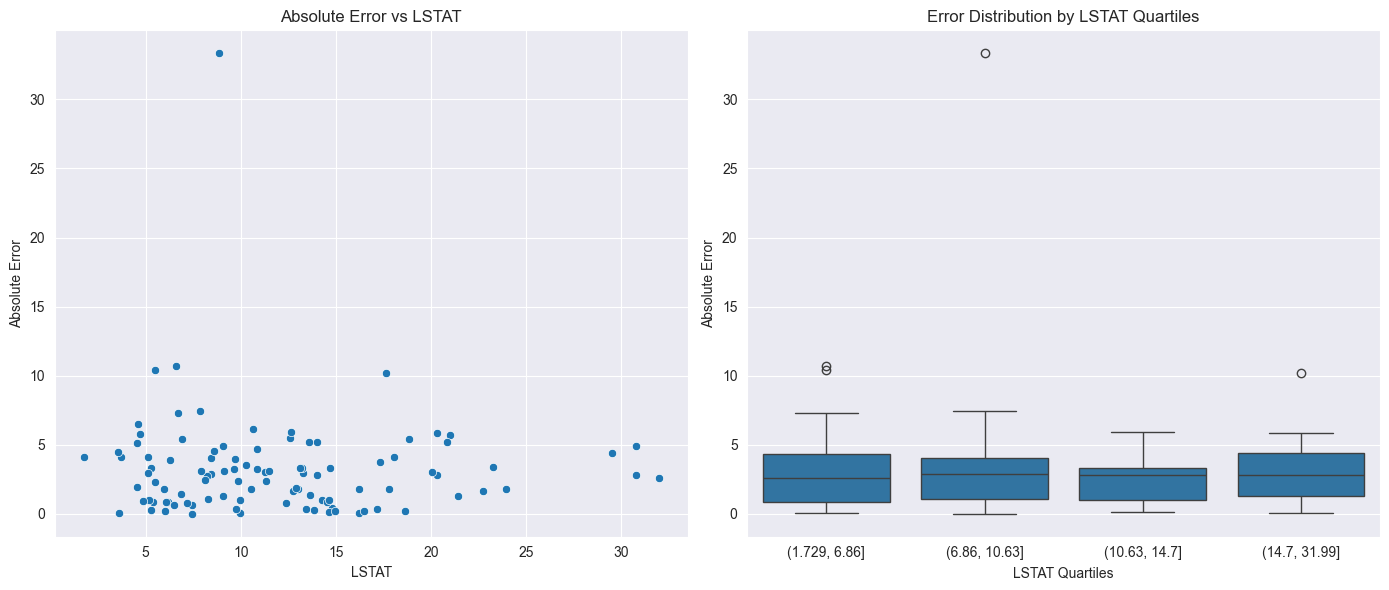

Evaluating: FairBoostRegressor_v2, Fold: 4, Fairness weight: 0.75


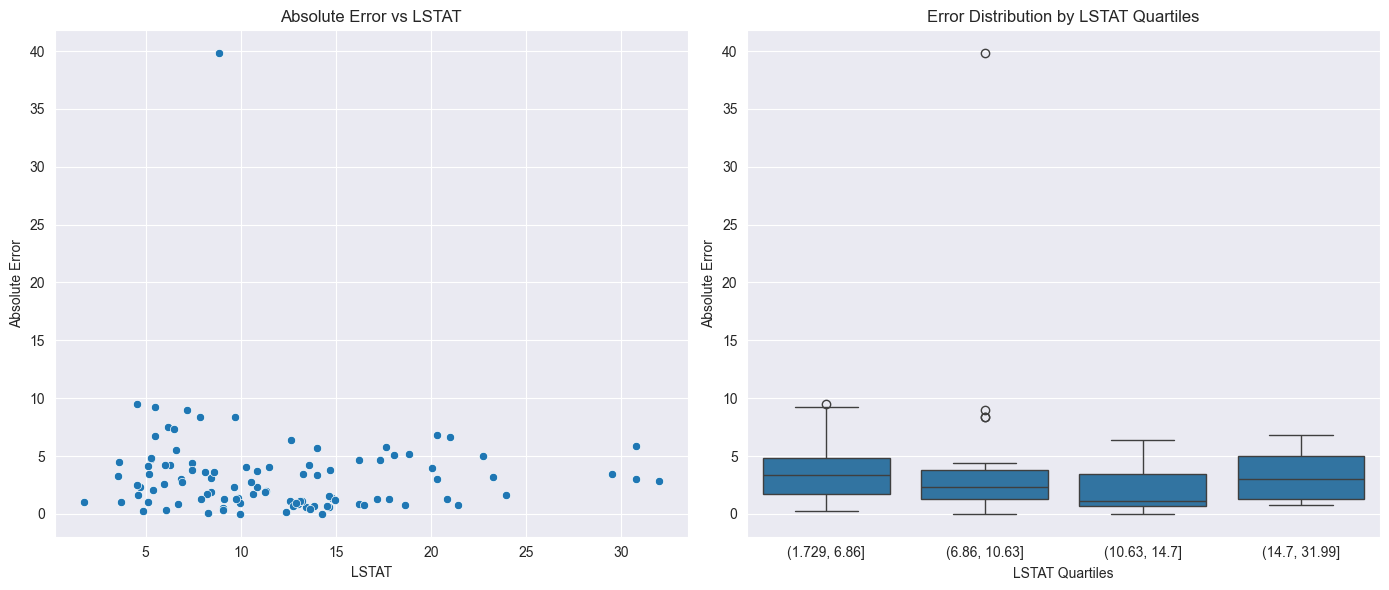

Evaluating: FairBoostRegressor_v2_Improved, Fold: 4, Fairness weight: 0.25


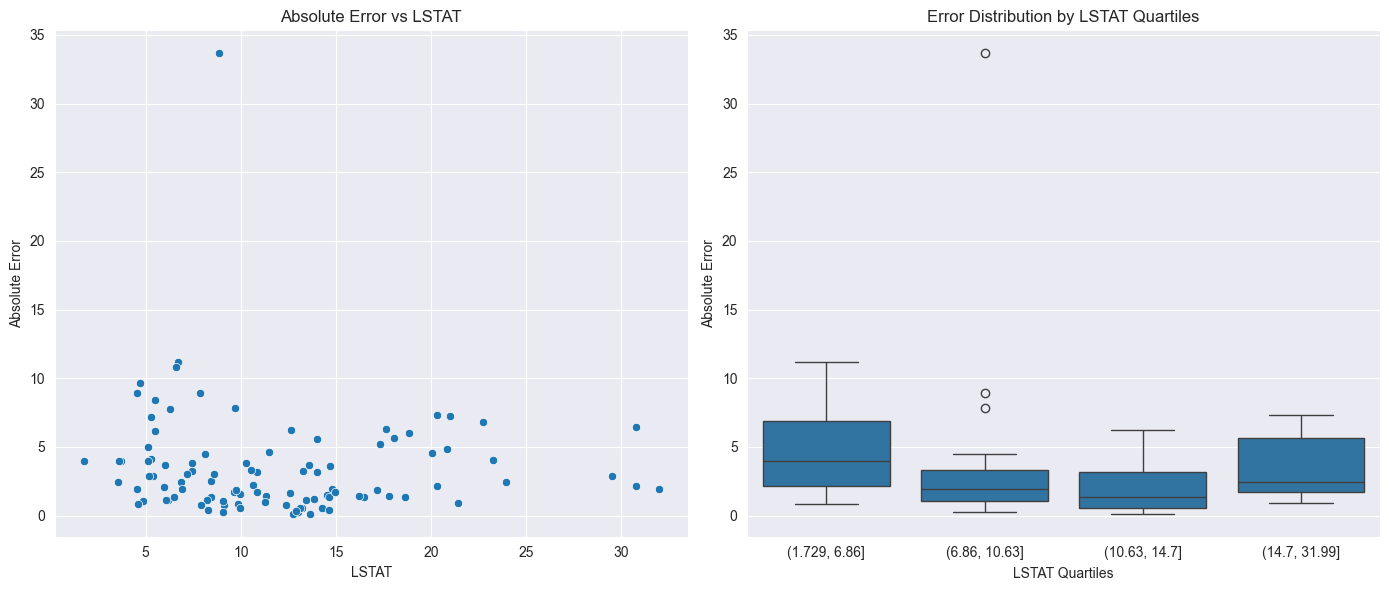

Evaluating: FairBoostRegressor_v2_Improved, Fold: 4, Fairness weight: 0.5


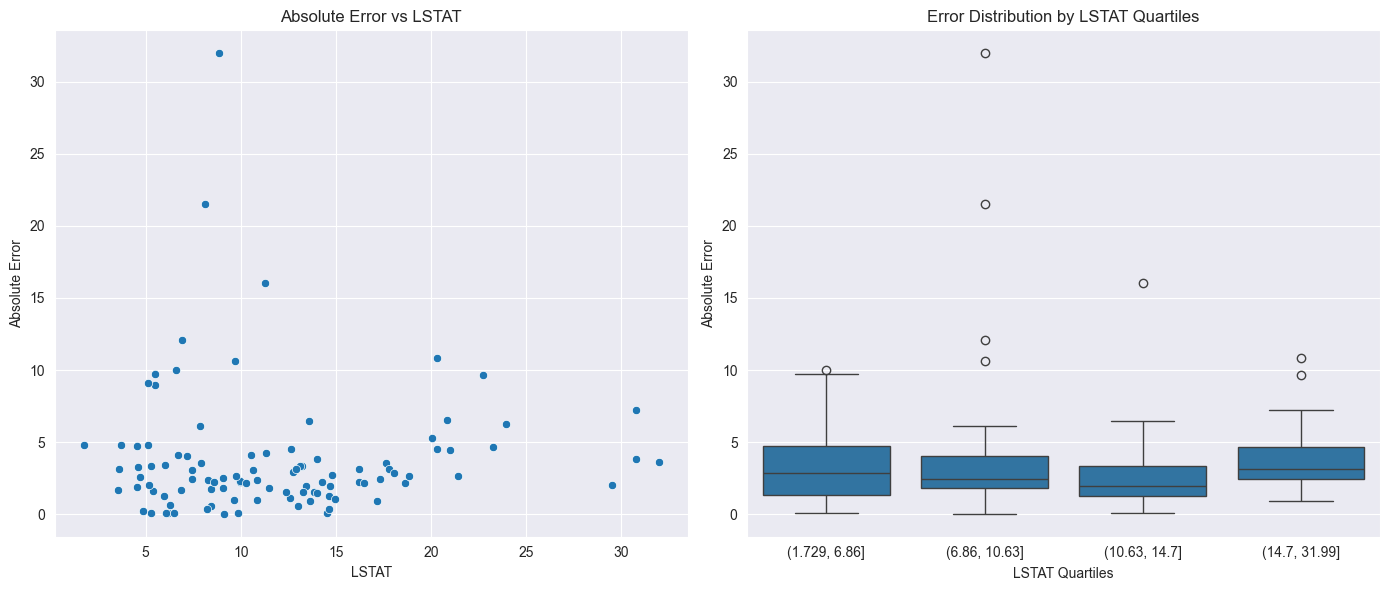

Evaluating: FairBoostRegressor_v2_Improved, Fold: 4, Fairness weight: 0.75


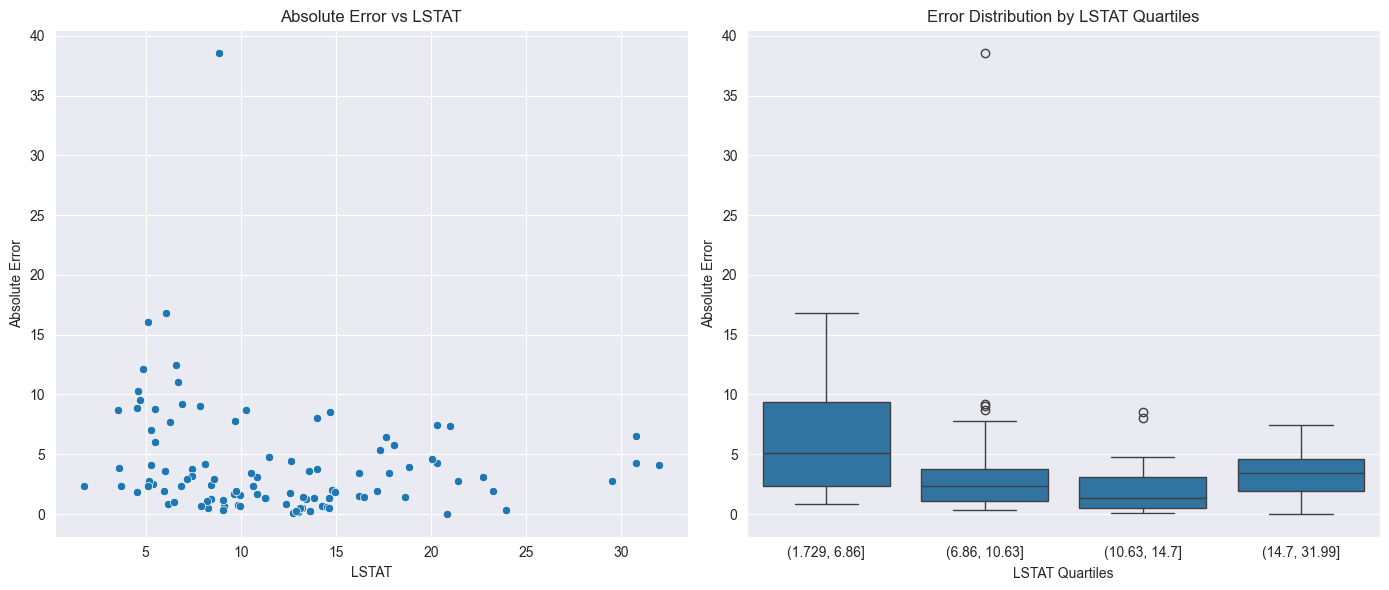

Evaluating: FairBoostRegressor_v3, Fold: 4, Fairness weight: 0.25


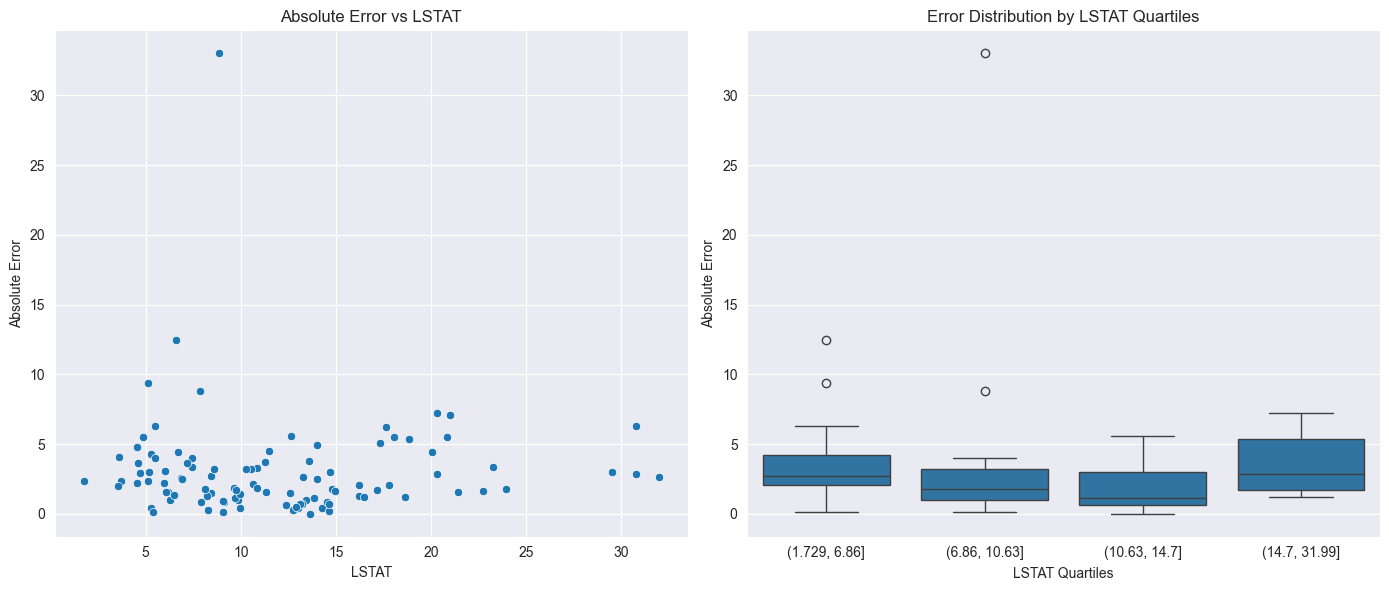

Evaluating: FairBoostRegressor_v3, Fold: 4, Fairness weight: 0.5


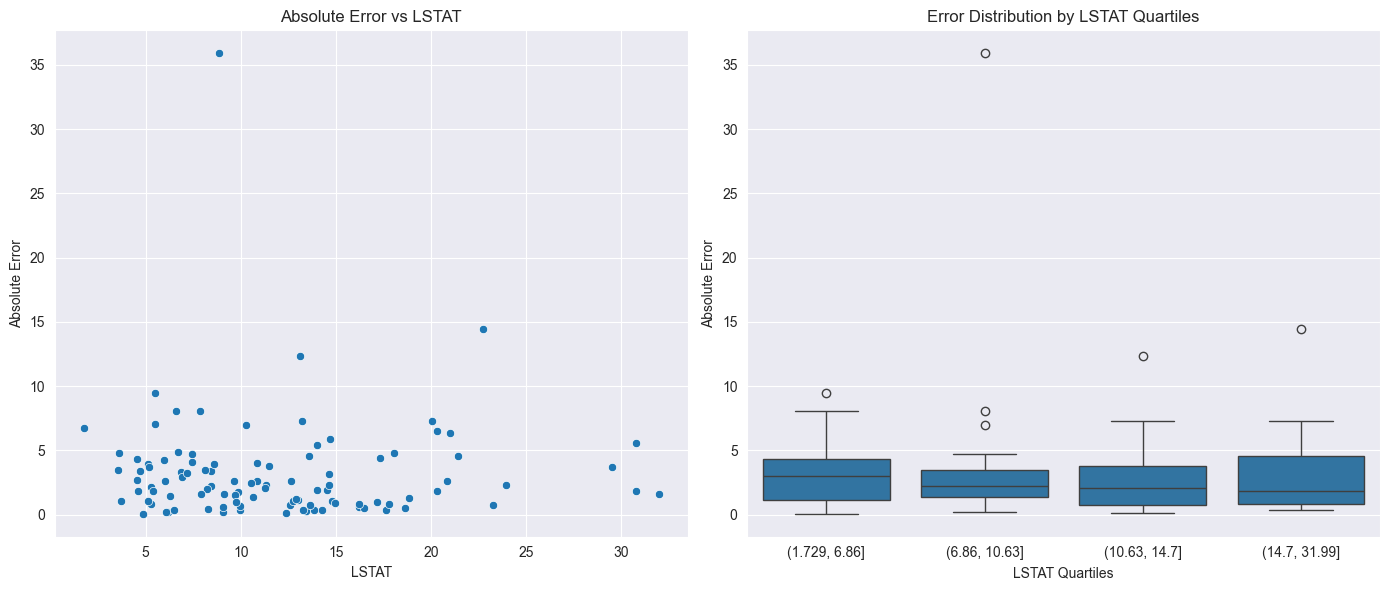

Evaluating: FairBoostRegressor_v3, Fold: 4, Fairness weight: 0.75


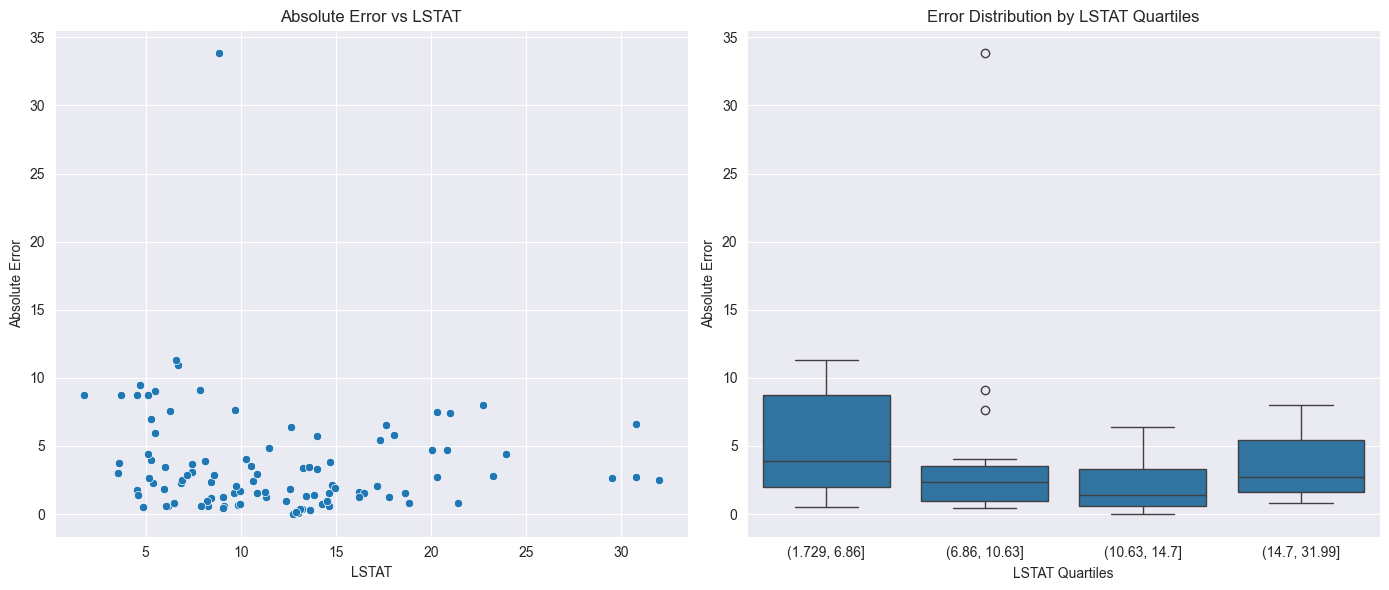

In [17]:
fairness_weights = [0.25, 0.5, 0.75]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

res = {
    'Dataset_feature': [],
    'Fold': [],
    'Fairness weight': [],
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'Group difference (RMSE)': [],
    'Group difference (MAE)': [],
    'Group max (RMSE)': [],
    'Group max (MAE)': [],
    'Group min (RMSE)': [],
    'Group min (MAE)': [],
}

groups = {
    'Dataset_feature': [],
    'Fold': [],
    'Model': [],
    'Fairness weight': [],
    'Metric': [],
    'Group': [],
    'Value': [],
}

results = []
group_results = []

for ds in datasets:
    dataset_name = ds['name']
    X = ds['X']
    y = ds['y']
    Z = ds['Z']

    print(f"Processing dataset with protected feature: {dataset_name}")

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        Z_train, Z_test = Z.iloc[train_index], Z.iloc[test_index]

        for regressor in fair_regressors:
            for fw in fairness_weights:
                fair_regressor = regressor(n_estimators=50, fairness_weight=fw, learning_rate=0.01)
                model_name = type(fair_regressor).__name__
                fair_regressor.set_Z(Z_train)

                print(f"Evaluating: {model_name}, Fold: {fold}, Fairness weight: {fw}")

                fair_regressor.fit(X_train, y_train)
                y_pred = fair_regressor.predict(X_test)

                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = np.mean(np.abs(y_test - y_pred))

                grouped_metric = MetricFrame(
                    metrics={"MSE": mean_squared_error},
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=Z_test
                )

                by_group_mse = grouped_metric.by_group["MSE"]
                by_group_rmse = {group: np.sqrt(value) for group, value in by_group_mse.items()}

                for group, value in by_group_rmse.items():
                    group_results.append({
                        "Dataset_feature": dataset_name,
                        "Fold": fold,
                        "Model": model_name,
                        "Fairness weight": fw,
                        "Metric": "RMSE",
                        "Group": group,
                        "Value": value
                    })

                results.append({
                    "Dataset_feature": dataset_name,
                    "Fold": fold,
                    "Model": model_name,
                    "Fairness weight": fw,
                    "RMSE": rmse,
                    "MAE": mae,
                    "Group difference (RMSE)": max(by_group_rmse.values()) - min(by_group_rmse.values()),
                    "Group max (RMSE)": max(by_group_rmse.values()),
                    "Group min (RMSE)": min(by_group_rmse.values()),
                })

                y_error = y_pred - y_test
                y_error_abs = np.abs(y_error)

                plt.figure(figsize=(14, 6))

                plt.subplot(1, 2, 1)
                sns.scatterplot(x=Z_test[dataset_name], y=y_error_abs)

                plt.xlabel(dataset_name)
                plt.ylabel('Absolute Error')
                plt.title(f'Absolute Error vs {dataset_name}')

                plt.subplot(1, 2, 2)
                sns.boxplot(x=pd.qcut(Z_test[dataset_name], q=4, duplicates="drop"), y=y_error_abs)

                plt.xlabel(f"{dataset_name} Quartiles")
                plt.ylabel("Absolute Error")
                plt.title(f"Error Distribution by {dataset_name} Quartiles")

                plt.tight_layout()
                plt.show()

Results shown in table for each feature, fold, model and fairness weight.

In [18]:
results_df = pd.DataFrame(results)
group_results_df = pd.DataFrame(group_results)
results_df.head(100)

Dataset_feature  Fold                           Model  Fairness weight  \
0                B     0           FairBoostRegressor_v1             0.25   
1                B     0           FairBoostRegressor_v1             0.50   
2                B     0           FairBoostRegressor_v1             0.75   
3                B     0  FairBoostRegressor_v1_Improved             0.25   
4                B     0  FairBoostRegressor_v1_Improved             0.50   
..             ...   ...                             ...              ...   
95           LSTAT     1  FairBoostRegressor_v1_Improved             0.75   
96           LSTAT     1           FairBoostRegressor_v2             0.25   
97           LSTAT     1           FairBoostRegressor_v2             0.50   
98           LSTAT     1           FairBoostRegressor_v2             0.75   
99           LSTAT     1  FairBoostRegressor_v2_Improved             0.25   

        RMSE       MAE  Group difference (RMSE)  Group max (RMSE)  \
0   3.673047  3.007147                10.023684         10.061842   
1   3.673047  3.007147                10.023684         10.061842   
2   3.673047  3.007147                10.023684         10.061842   
3   3.673047  3.007147                10.023684         10.061842   
4   3.673047  3.007147                10.023684         10.061842   
..       ...       ...                      ...               ...   
95  4.878182  3.518817                22.777281         22.830769   
96  5.854999  4.187898                27.335862         27.360000   
97  5.285470  3.759270                28.733054         28.766527   
98  6.515572  4.364625                29.984712         30.166667   
99  5.592803  4.044684                29.850000         29.850000   

    Group min (RMSE)  
0       3.815789e-02  
1       3.815789e-02  
2       3.815789e-02  
3       3.815789e-02  
4       3.815789e-02  
..               ...  
95      5.348837e-02  
96      2.413793e-02  
97      3.347280e-02  
98      1.819549e-01  
99      7.105427e-15  

[100 rows x 9 columns]

RMSE and Fairness weight for each model

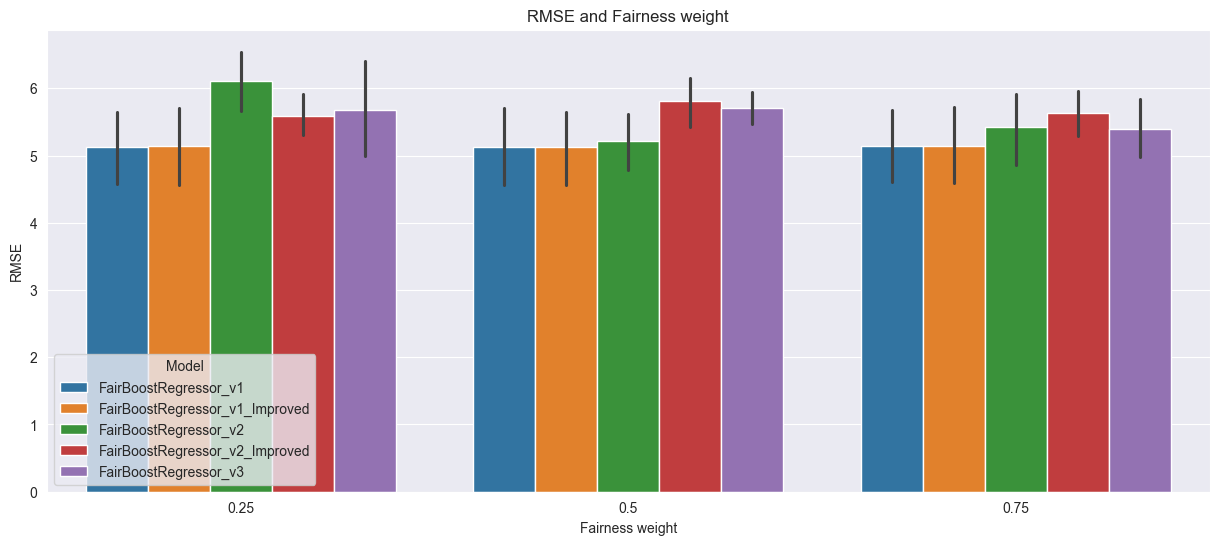

In [19]:
plt.figure(figsize=(15, 6))
sns.barplot(
    data=results_df,
    x="Fairness weight",
    y="RMSE",
    hue="Model",
)
plt.title("RMSE and Fairness weight")
plt.ylabel("RMSE")
plt.xlabel("Fairness weight")
plt.legend(title="Model")
plt.show()

Group difference in RMSE and Fairness weight for each model

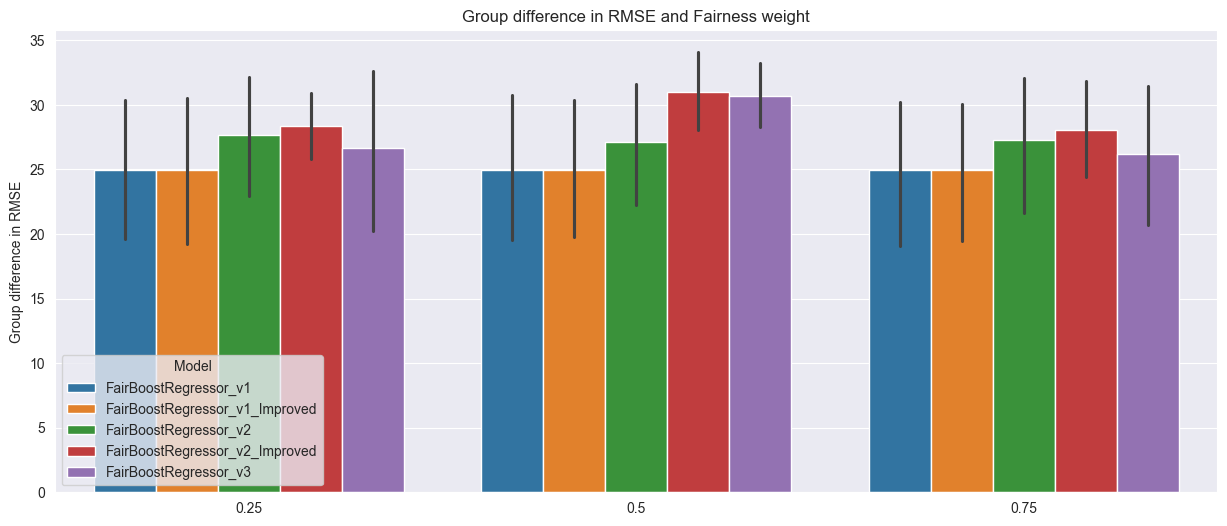

In [20]:
plt.figure(figsize=(15, 6))
sns.barplot(
    data=results_df,
    x="Fairness weight",
    y="Group difference (RMSE)",
    hue="Model"
)
plt.title("Group difference in RMSE and Fairness weight")
plt.ylabel("Group difference in RMSE")
plt.xlabel("")
plt.legend(title="Model")
plt.show()

This plot shows the distribution of Root Mean Square Error (RMSE) values for different groups, broken down by model. The x-axis represents the different groups, and the y-axis shows the RMSE values. Each boxplot represents a model's RMSE distribution across different groups, allowing you to compare the performance of the model across these groups. The plot is useful for identifying potential disparities or biases in model performance across different groups. The models are displayed in separate plots, each showing the RMSE distribution for the corresponding model.

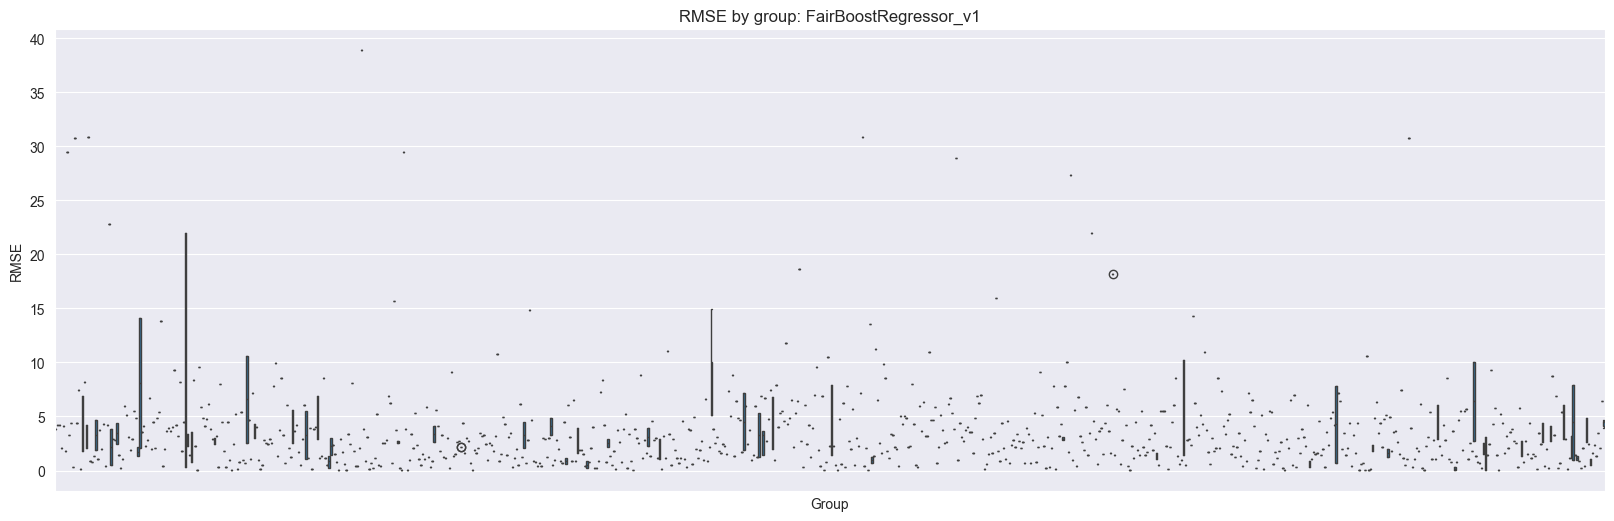

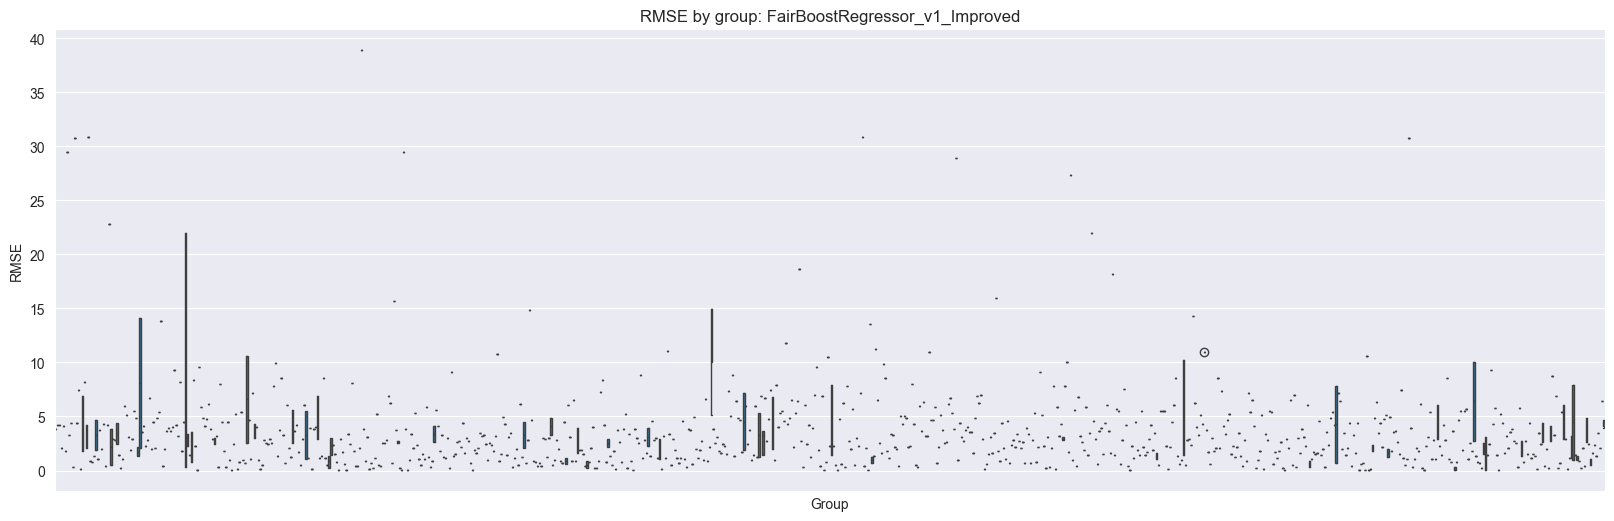

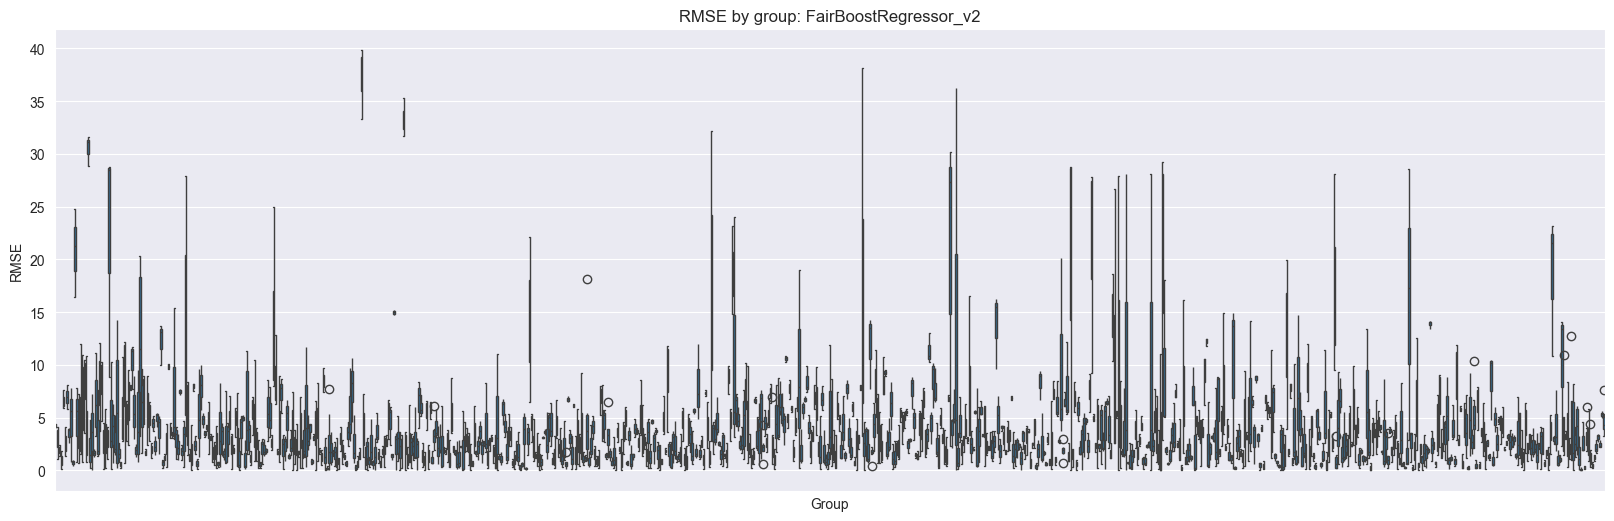

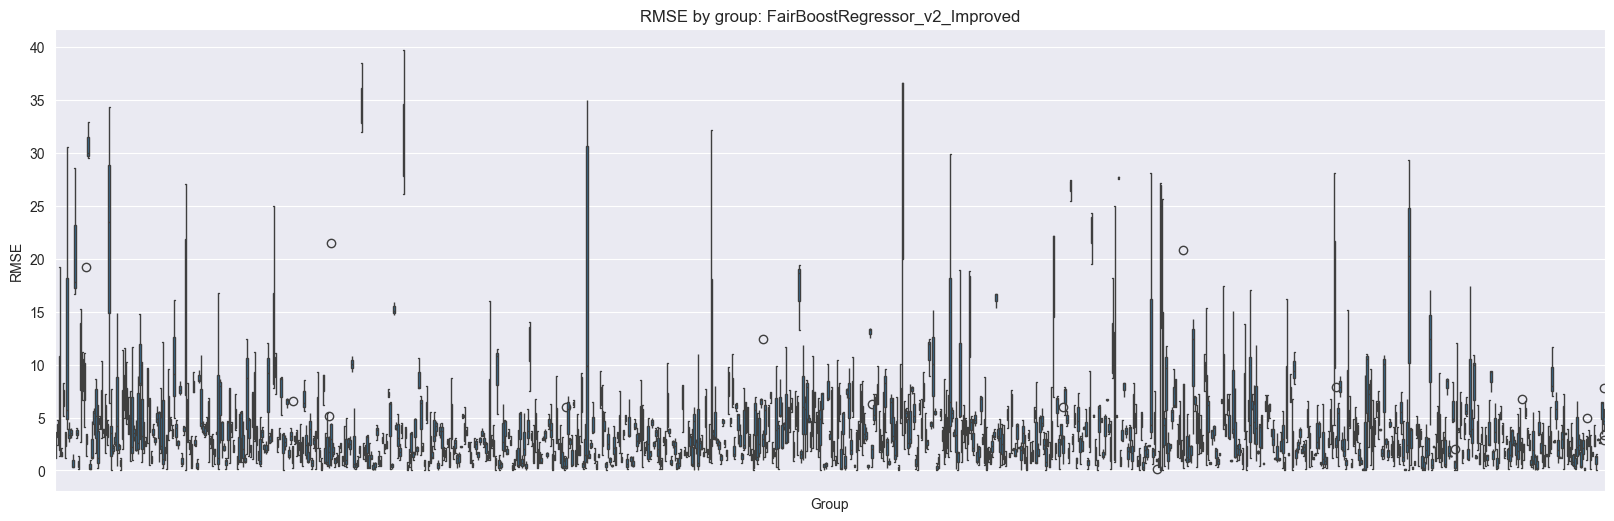

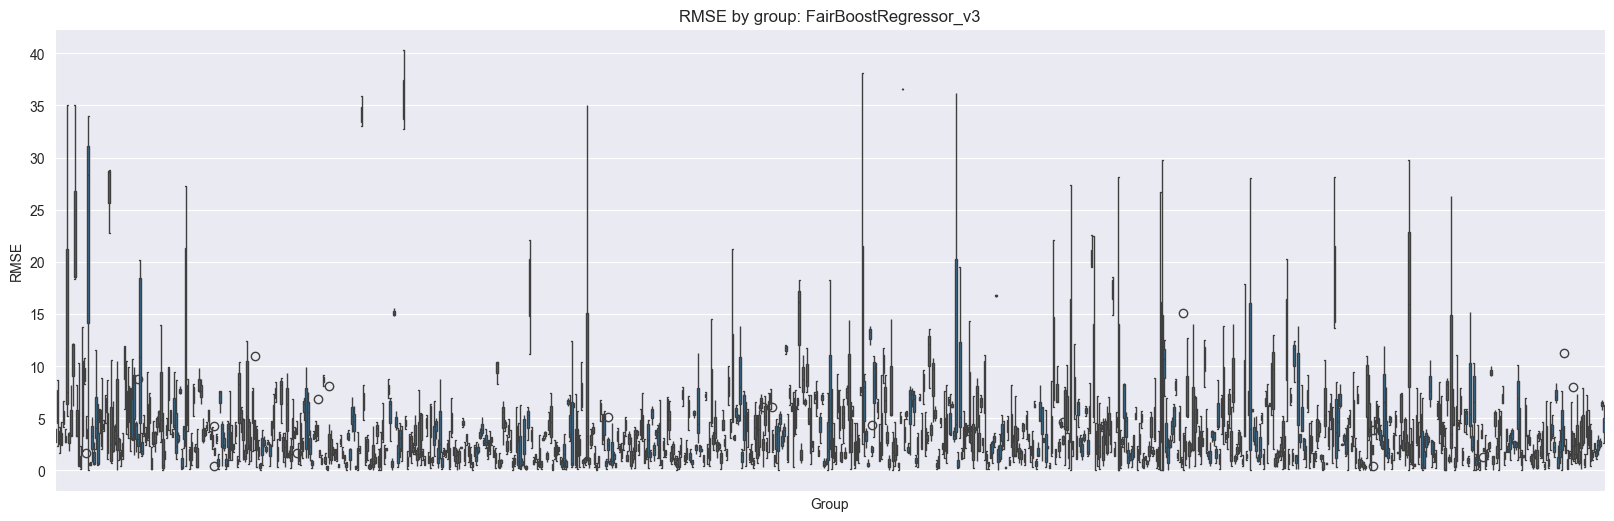

In [21]:
models = group_results_df["Model"].unique()

for model in models:
    model_data = group_results_df[group_results_df["Model"] == model]

    plt.figure(figsize=(20, 6))

    sns.boxplot(
        data=model_data,
        x="Group",
        y="Value",
        order=sorted(group_results_df["Group"].unique())
    )

    plt.title(f"RMSE by group: {model}")
    plt.xlabel("Group")
    plt.ylabel("RMSE")
    plt.xticks([])

    plt.show()

Based on the evaluation and testing process, the v3 model didn't perform well on multiple protected features, so I will remove it.

In [22]:
fair_regressors.pop(-1)

FairBoostRegressor_v3.FairBoostRegressor_v3

A function that performs multi regression and returns error metrics and results in shape of array.

In [23]:
def perform_multi_regression(protected):
    results = []

    X = data.data
    Z = X[protected]
    X = pd.get_dummies(X.drop(protected, axis=1), dtype='int')
    y = data.target

    X_train, X_test, \
    Z_train, Z_test, \
    y_train, y_test = train_test_split(X, Z, y, test_size=0.2, random_state=rnd)

    for fair_regressor in fair_regressors:
        fair_regressor = fair_regressor(n_estimators=50, fairness_weight=0.5, learning_rate=0.01)

        fair_regressor.set_Z(Z_train)
        fair_regressor.fit(X_train, y_train)

        y_pred = fair_regressor.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = np.mean(np.abs(y_test - y_pred))

        metric_frame = MetricFrame(
            metrics=mean_squared_error,
            y_true=y_test,
            y_pred=y_pred,
            sensitive_features=Z_test
        )

        print(f"Regressor: {fair_regressor.__class__.__name__}")
        print(f"Overall RMSE: {rmse}")
        print(f"Overall MAE: {mae}")
        # print(f"Fairness Metrics by Group:\n{metric_frame.by_group.dropna()}")
        print(f"Metric Difference: {metric_frame.difference()}")
        print("__________________________________________________")

        results.append({"name": fair_regressor.__class__.__name__, "RMSE": rmse, "MAE": mae, "metric difference (MSE)": metric_frame.difference()})

    return results

This function visualizes the error metrics (RMSE, MAE, and MSE) for multiple regression models by plotting them in a series of bar charts. Each chart compares the error metric across different model versions. The function takes a list of dictionaries as input, where each dictionary contains the model name and the corresponding error metrics. The results are displayed in three separate subplots, with labeled axes and rotated x-axis ticks for better readability. This allows for easy comparison of model performance based on different error metrics.

In [24]:
def plot_errors(res):
    names = [item['name'] for item in res]
    rmse_values = [item['RMSE'] for item in res]
    mae_values = [item['MAE'] for item in res]
    mse_values = [item['metric difference (MSE)'] for item in res]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].bar(names, rmse_values, color='skyblue', alpha=0.8)
    axes[0].set_title('RMSE Comparison')
    axes[0].set_ylabel('RMSE')
    axes[0].set_xlabel('Model Versions')
    axes[0].tick_params(axis='x', rotation=45)

    axes[1].bar(names, mae_values, color='lightgreen', alpha=0.8)
    axes[1].set_title('MAE Comparison')
    axes[1].set_ylabel('MAE')
    axes[1].set_xlabel('Model Versions')
    axes[1].tick_params(axis='x', rotation=45)

    axes[2].bar(names, mse_values, color='salmon', alpha=0.8)
    axes[2].set_title('MSE Metric Difference Comparison')
    axes[2].set_ylabel('MSE Metric Difference')
    axes[2].set_xlabel('Model Versions')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

The features B (proportion of Black residents) and LSTAT (percentage of lower status population) are sensitive attributes that can reflect social and economic disparities. B might introduce racial bias, while LSTAT could correlate with socio-economic status, both of which can unfairly influence model predictions, particularly in housing-related data. Using these features as protected attributes in FairRegression ensures the model does not amplify these biases, aiming for fairness across different demographic groups.

Performin FairRegression for protected features: ['B', 'LSTAT']

Regressor: FairBoostRegressor_v1
Overall RMSE: 7.14300934253778
Overall MAE: 3.943826746062874
Metric Difference: 1546.6578111426782
__________________________________________________
Regressor: FairBoostRegressor_v1_Improved
Overall RMSE: 7.143009342537781
Overall MAE: 3.943826746062875
Metric Difference: 1546.6578111426786
__________________________________________________
Regressor: FairBoostRegressor_v2
Overall RMSE: 6.355670295161828
Overall MAE: 3.7634768329893937
Metric Difference: 1585.2784391975308
__________________________________________________
Regressor: FairBoostRegressor_v2_Improved
Overall RMSE: 6.518897037635036
Overall MAE: 3.9430326304103294
Metric Difference: 1369.384238488784
__________________________________________________


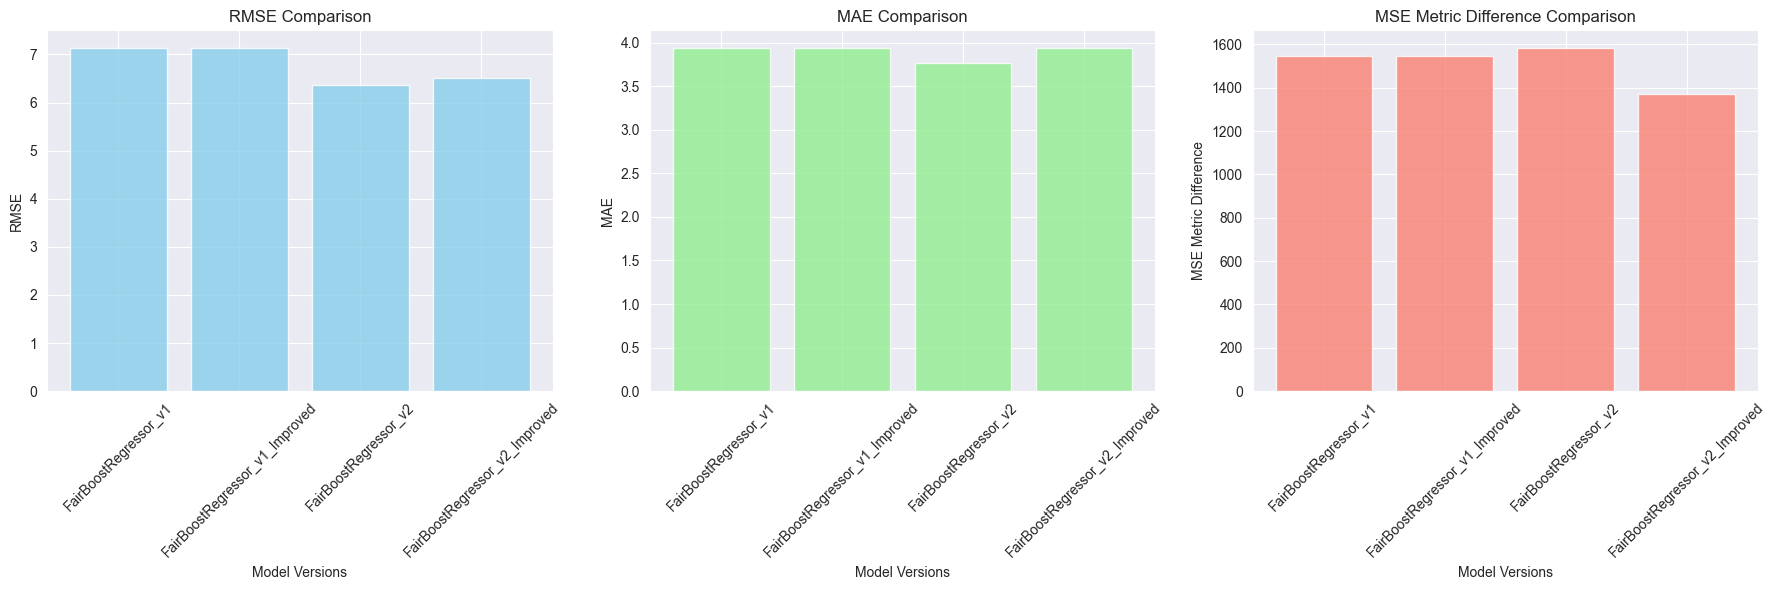

In [25]:
protected = ['B', 'LSTAT']
print(f'Performin FairRegression for protected features: {protected}\n')
plot_errors(perform_multi_regression(protected))

The features CRIM (per capita crime rate) and AGE (proportion of owner-occupied units built before 1940) are sensitive attributes that can impact model predictions. High crime rates (CRIM) may correlate with socio-economic factors and lower property values, while older housing stock (AGE) could reflect historical disparities in urban development. Using these features as protected attributes in FairRegression helps ensure the model does not unfairly disadvantage certain communities based on crime rates or housing age, promoting fairness in predictions.

Performin FairRegression for protected features: ['CRIM', 'AGE']

Regressor: FairBoostRegressor_v1
Overall RMSE: 6.8874330726160045
Overall MAE: 4.042870620191592
Metric Difference: 1225.0
__________________________________________________
Regressor: FairBoostRegressor_v1_Improved
Overall RMSE: 6.887433072616004
Overall MAE: 4.042870620191592
Metric Difference: 1225.0
__________________________________________________
Regressor: FairBoostRegressor_v2
Overall RMSE: 4.856331630989443
Overall MAE: 3.698190434538926
Metric Difference: 442.8686419753083
__________________________________________________
Regressor: FairBoostRegressor_v2_Improved
Overall RMSE: 6.90495274415025
Overall MAE: 3.9903071628563067
Metric Difference: 1224.9998497398544
__________________________________________________


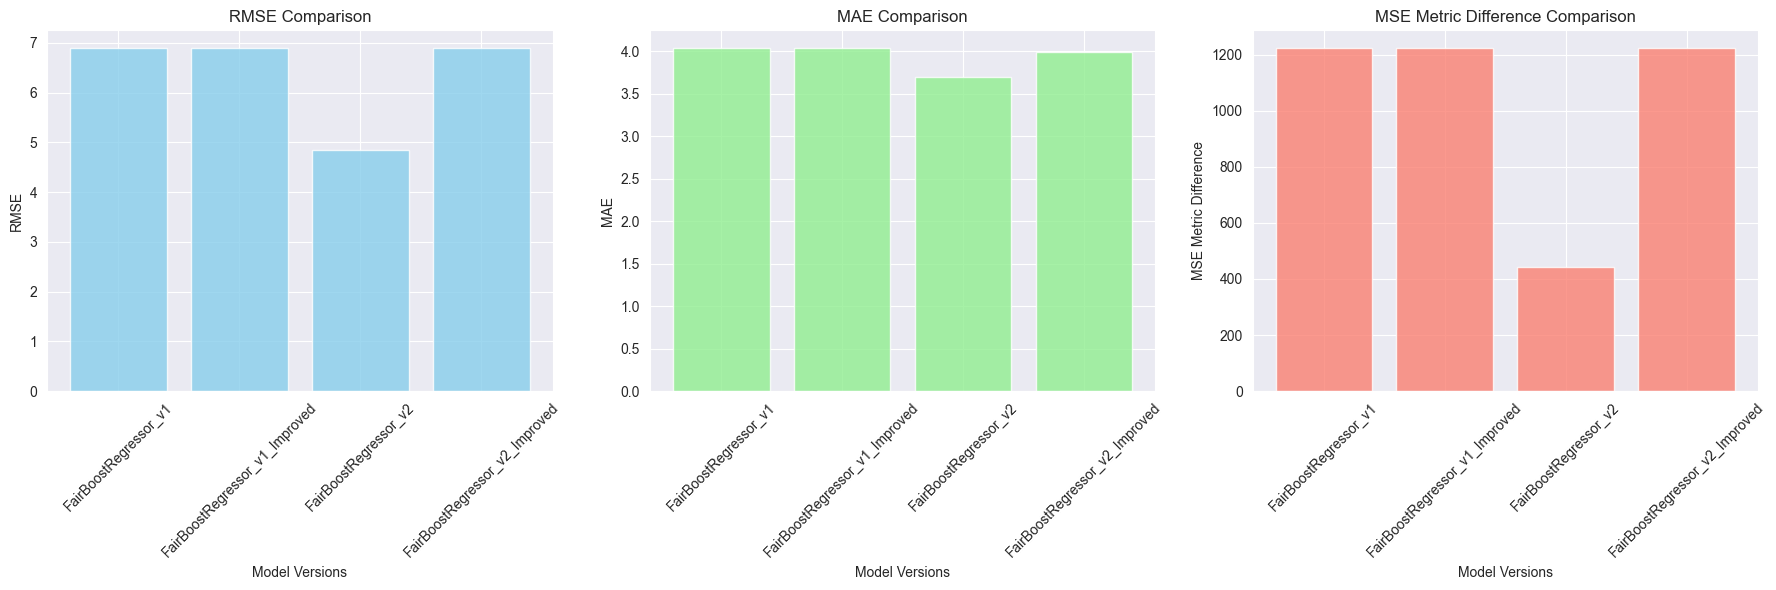

In [26]:
protected = ['CRIM', 'AGE']
print(f'Performin FairRegression for protected features: {protected}\n')
plot_errors(perform_multi_regression(protected))

The features LSTAT (percentage of lower status population) and CHAS (Charles River dummy variable) are sensitive attributes that can influence model predictions. High levels of LSTAT may reflect socio-economic disparities, while CHAS indicates proximity to the Charles River, which can affect property values and desirability. Using these features as protected attributes in FairRegression ensures the model doesn't unfairly discriminate based on socio-economic status or geographical location, promoting fairness across different communities.

Performin FairRegression for protected features: ['LSTAT', 'CHAS']

Regressor: FairBoostRegressor_v1
Overall RMSE: 7.143009342537781
Overall MAE: 3.9438267460628755
Metric Difference: 1546.6578111426782
__________________________________________________
Regressor: FairBoostRegressor_v1_Improved
Overall RMSE: 7.1430093425377805
Overall MAE: 3.943826746062874
Metric Difference: 1546.6578111426786
__________________________________________________
Regressor: FairBoostRegressor_v2
Overall RMSE: 6.87777343715315
Overall MAE: 4.440509545923632
Metric Difference: 1534.0277772853187
__________________________________________________
Regressor: FairBoostRegressor_v2_Improved
Overall RMSE: 7.308108346083088
Overall MAE: 4.10446844966943
Metric Difference: 1543.3163875775033
__________________________________________________


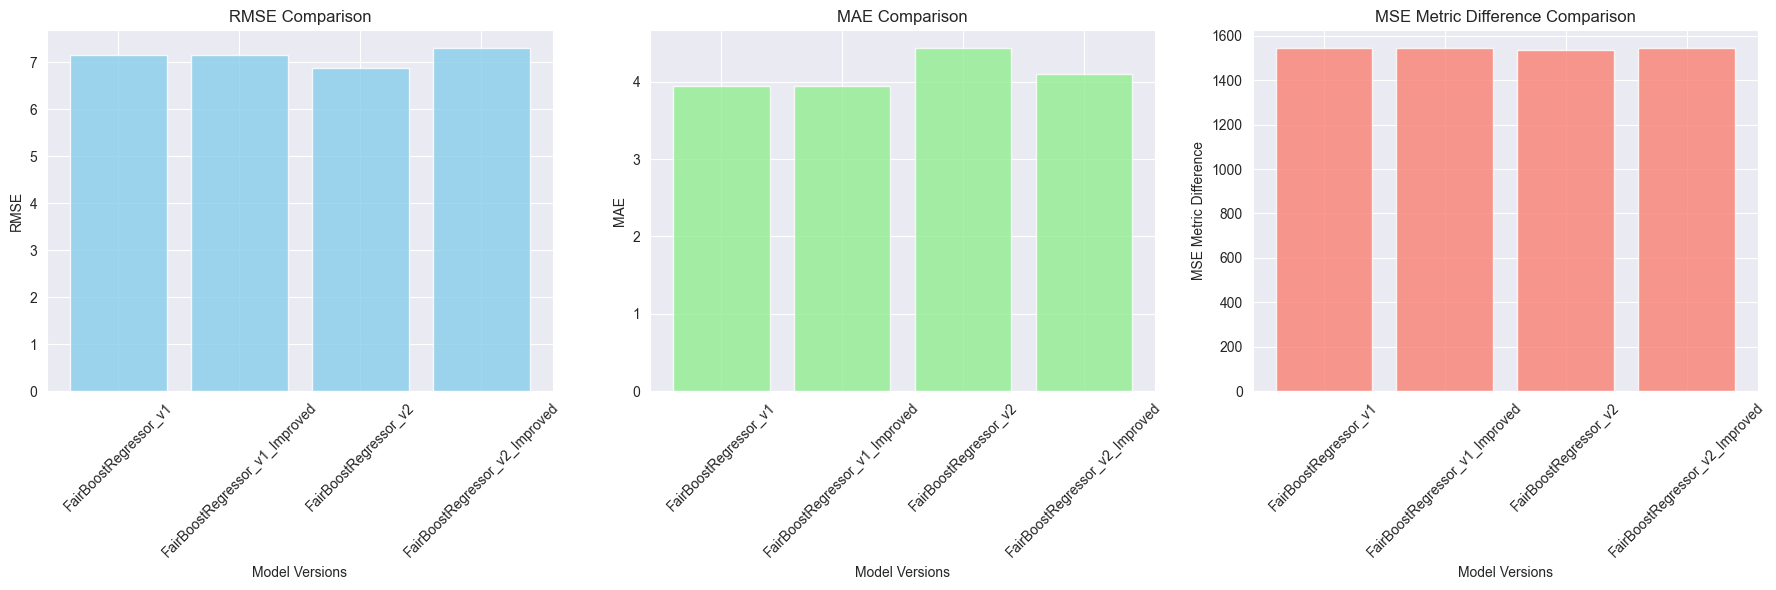

In [27]:
protected = ['LSTAT', 'CHAS']
print(f'Performin FairRegression for protected features: {protected}\n')
plot_errors(perform_multi_regression(protected))

The features CRIM (per capita crime rate) and B (proportion of Black residents) are sensitive attributes that can introduce bias into model predictions. High crime rates (CRIM) can be linked to socio-economic factors and affect property values, while B represents racial demographics that might influence housing prices. Using these features as protected attributes in FairRegression ensures the model does not unfairly disadvantage communities based on crime rates or racial composition, promoting fairness in predictions.

Performin FairRegression for protected features: ['CRIM', 'B']

Regressor: FairBoostRegressor_v1
Overall RMSE: 6.8874330726160045
Overall MAE: 4.042870620191592
Metric Difference: 1225.0
__________________________________________________
Regressor: FairBoostRegressor_v1_Improved
Overall RMSE: 6.887433072616005
Overall MAE: 4.042870620191592
Metric Difference: 1225.0
__________________________________________________
Regressor: FairBoostRegressor_v2
Overall RMSE: 6.006891772317375
Overall MAE: 3.659345035334791
Metric Difference: 1225.0
__________________________________________________
Regressor: FairBoostRegressor_v2_Improved
Overall RMSE: 5.980656418837244
Overall MAE: 3.774632150255892
Metric Difference: 829.1985628742514
__________________________________________________


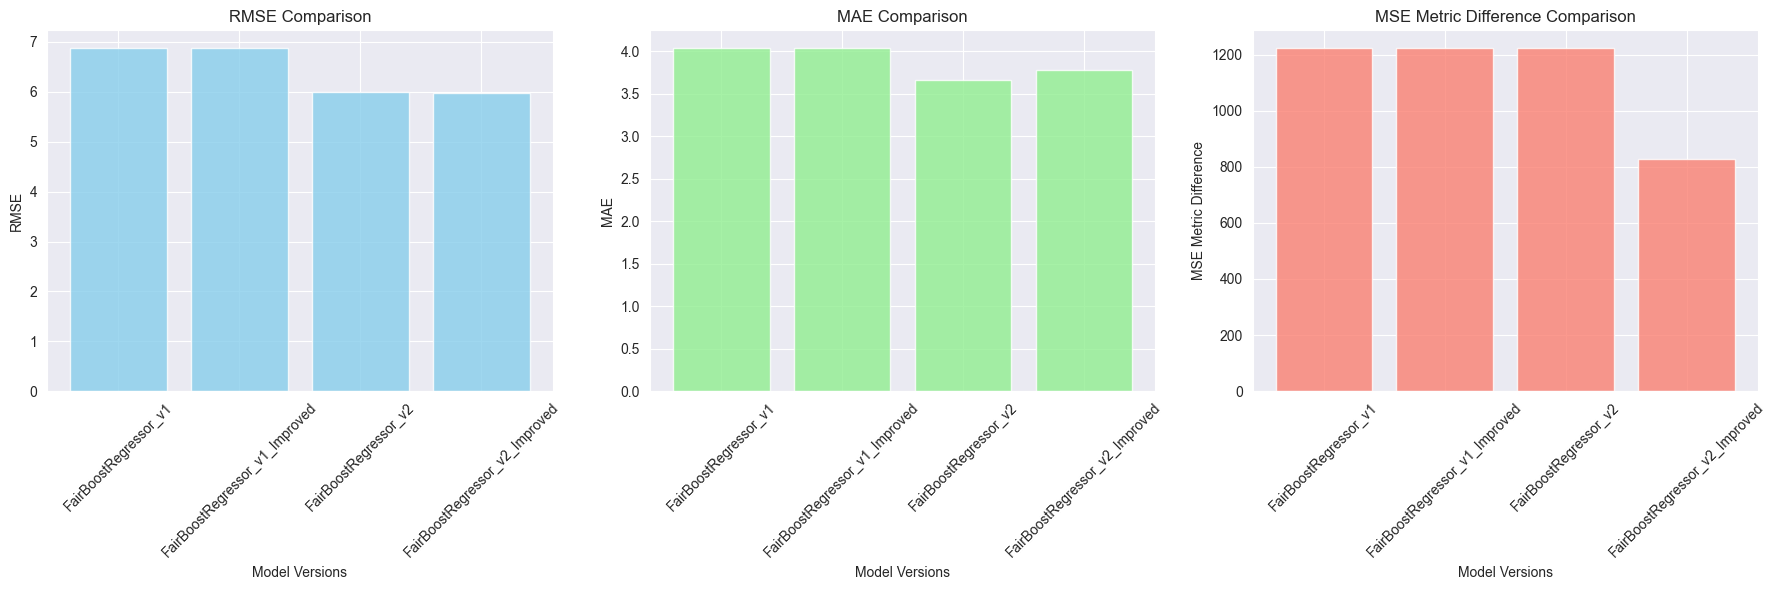

In [28]:
protected = ['CRIM', 'B']
print(f'Performin FairRegression for protected features: {protected}\n')
plot_errors(perform_multi_regression(protected))